# Training

## Technically, it's only a few lines of code to run on GPUs (elsewhere, ie. on Lamini).
```
from llama import BasicModelRunner

model = BasicModelRunner("EleutherAI/pythia-410m")
model.load_data_from_jsonlines("lamini_docs.jsonl")
model.train()
```
1. Choose base model.
2. Load data.
3. Train it. Returns a model ID, dashboard, and playground interface.

### Let's look under the hood at the core code running this! This is the open core of Lamini's `llama` library :)

In [1]:
#!pip install transformers[torch]


In [2]:
import datasets
import tempfile
import logging
import random
import config
import os
import yaml
import logging
import time
import torch
import transformers

from utilities import *
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM
from transformers import TrainingArguments
from transformers import AutoModelForCausalLM
from llama import BasicModelRunner
from llama import BasicModelRunner

logger = logging.getLogger(__name__)
global_config = None

### Load the Lamini docs dataset

In [3]:
dataset_name = "lamini_docs.jsonl"
dataset_path = f"/content/{dataset_name}"
use_hf = False

In [4]:
dataset_path = "lamini/lamini_docs"
use_hf = True

### Set up the model, training config, and tokenizer

In [5]:
model_name = "EleutherAI/pythia-70m"

In [6]:
training_config = {
    "model": {
        "pretrained_name": model_name,
        "max_length" : 2048
    },
    "datasets": {
        "use_hf": use_hf,
        "path": dataset_path
    },
    "verbose": True
}

In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
train_dataset, test_dataset = tokenize_and_split_data(training_config, tokenizer)

print(train_dataset)
print(test_dataset)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
2024-02-24 10:40:20,055 - DEBUG - utilities - Config: datasets.path: lamini/lamini_docs
datasets.use_hf: true
model.max_length: 2048
model.pretrained_name: EleutherAI/pythia-70m
verbose: true



tokenize True lamini/lamini_docs


2024-02-24 10:40:21,323 - DEBUG - fsspec.local - open file: /opt/app-root/src/.cache/huggingface/datasets/lamini___lamini_docs/default/0.0.0/05bd680b81d69a7a1d38193873f1487d73e535bf/dataset_info.json
2024-02-24 10:40:21,341 - DEBUG - fsspec.local - open file: /opt/app-root/src/.cache/huggingface/datasets/lamini___lamini_docs/default/0.0.0/05bd680b81d69a7a1d38193873f1487d73e535bf/dataset_info.json


Dataset({
    features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1260
})
Dataset({
    features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 140
})


### Load the base model

In [8]:
base_model = AutoModelForCausalLM.from_pretrained(model_name)

In [9]:
device_count = torch.cuda.device_count()
if device_count > 0:
    logger.debug("Select GPU device")
    device = torch.device("cuda")
else:
    logger.debug("Select CPU device")
    device = torch.device("cpu")

2024-02-24 10:40:22,217 - DEBUG - __main__ - Select GPU device


In [10]:
base_model.to(device)

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
          (a

### Define function to carry out inference

In [11]:
def inference(text, model, tokenizer, max_input_tokens=1000, max_output_tokens=100):
  # Tokenize
  input_ids = tokenizer.encode(
          text,
          return_tensors="pt",
          truncation=True,
          max_length=max_input_tokens
  )

  # Generate
  device = model.device
  generated_tokens_with_prompt = model.generate(
    input_ids=input_ids.to(device),
    max_length=max_output_tokens
  )

  # Decode
  generated_text_with_prompt = tokenizer.batch_decode(generated_tokens_with_prompt, skip_special_tokens=True)

  # Strip the prompt
  generated_text_answer = generated_text_with_prompt[0][len(text):]

  return generated_text_answer

### Try the base model

In [12]:
test_text = test_dataset[0]['question']
print("Question input (test):", test_text)
print(f"Correct answer from Lamini docs: {test_dataset[0]['answer']}")
print("Model's answer: ")
print(inference(test_text, base_model, tokenizer))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Question input (test): Can Lamini generate technical documentation or user manuals for software projects?
Correct answer from Lamini docs: Yes, Lamini can generate technical documentation and user manuals for software projects. It uses natural language generation techniques to create clear and concise documentation that is easy to understand for both technical and non-technical users. This can save developers a significant amount of time and effort in creating documentation, allowing them to focus on other aspects of their projects.
Model's answer: 


I have a question about the following:

How do I get the correct documentation to work?

A:

I think you need to use the following code:

A:

You can use the following code to get the correct documentation.

A:

You can use the following code to get the correct documentation.

A:

You can use the following


### Setup training

In [13]:
max_steps = 3

In [14]:
trained_model_name = f"lamini_docs_{max_steps}_steps"
output_dir = trained_model_name

In [15]:
training_args = TrainingArguments(

  # Learning rate
  learning_rate=1.0e-5,

  # Number of training epochs
  num_train_epochs=1,

  # Max steps to train for (each step is a batch of data)
  # Overrides num_train_epochs, if not -1
  max_steps=max_steps,

  # Batch size for training
  per_device_train_batch_size=1,

  # Directory to save model checkpoints
  output_dir=output_dir,

  # Other arguments
  overwrite_output_dir=False, # Overwrite the content of the output directory
  disable_tqdm=False, # Disable progress bars
  eval_steps=120, # Number of update steps between two evaluations
  save_steps=120, # After # steps model is saved
  warmup_steps=1, # Number of warmup steps for learning rate scheduler
  per_device_eval_batch_size=1, # Batch size for evaluation
  evaluation_strategy="steps",
  logging_strategy="steps",
  logging_steps=1,
  optim="adafactor",
  gradient_accumulation_steps = 4,
  gradient_checkpointing=False,

  # Parameters for early stopping
  load_best_model_at_end=True,
  save_total_limit=1,
  metric_for_best_model="eval_loss",
  greater_is_better=False
)

In [16]:
model_flops = (
  base_model.floating_point_ops(
    {
       "input_ids": torch.zeros(
           (1, training_config["model"]["max_length"])
      )
    }
  )
  * training_args.gradient_accumulation_steps
)

print(base_model)
print("Memory footprint", base_model.get_memory_footprint() / 1e9, "GB")
print("Flops", model_flops / 1e9, "GFLOPs")

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
          (a

In [19]:
trainer = Trainer(
    model=base_model,
    model_flops=model_flops,
    total_steps=max_steps,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

2024-02-24 10:41:42,448 - WARNING - accelerate.utils.other - Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


### Train a few steps

In [20]:
training_output = trainer.train()

ValueError: expected sequence of length 132 at dim 1 (got 34)

### Save model locally

In [ ]:
save_dir = f'{output_dir}/final'

trainer.save_model(save_dir)
print("Saved model to:", save_dir)

In [ ]:
finetuned_slightly_model = AutoModelForCausalLM.from_pretrained(save_dir, local_files_only=True)


In [ ]:
finetuned_slightly_model.to(device) 


### Run slightly trained model

In [21]:
test_question = test_dataset[0]['question']
print("Question input (test):", test_question)

print("Finetuned slightly model's answer: ")
print(inference(test_question, finetuned_slightly_model, tokenizer))

Question input (test): Can Lamini generate technical documentation or user manuals for software projects?
Finetuned slightly model's answer: 


NameError: name 'finetuned_slightly_model' is not defined

In [ ]:
test_answer = test_dataset[0]['answer']
print("Target answer output (test):", test_answer)

### Run same model trained for two epochs 

In [22]:
finetuned_longer_model = AutoModelForCausalLM.from_pretrained("lamini/lamini_docs_finetuned")
tokenizer = AutoTokenizer.from_pretrained("lamini/lamini_docs_finetuned")

finetuned_longer_model.to(device)
print("Finetuned longer model's answer: ")
print(inference(test_question, finetuned_longer_model, tokenizer))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Finetuned longer model's answer: 
Yes, Lamini can generate technical documentation or user manuals for software projects. This can be achieved by providing a prompt for a specific technical question or question to the LLM Engine, or by providing a prompt for a specific technical question or question. Additionally, Lamini can be trained on specific technical questions or questions to help users understand the process and provide feedback to the LLM Engine. Additionally, Lamini


### Run much larger trained model and explore moderation

In [24]:
import lamini
lamini.api_key = "a764cdf8d4698a0812dfa330ca04a3ef3686497d8fff35bd6894a67b095b1d0f"

In [25]:
bigger_finetuned_model = BasicModelRunner(model_name_to_id["bigger_model_name"])
bigger_finetuned_output = bigger_finetuned_model(test_question)
print("Bigger (2.8B) finetuned model (test): ", bigger_finetuned_output)

Bigger (2.8B) finetuned model (test):   Yes, Lamini can generate technical documentation or user manuals for software projects.


In [26]:
bigger_finetuned_model = BasicModelRunner(model_name_to_id["bigger_model_name"])
bigger_finetuned_output = bigger_finetuned_model(test_question)
print("Bigger (2.8B) finetuned model (test): ", bigger_finetuned_output)

Bigger (2.8B) finetuned model (test):   Yes, Lamini can generate technical documentation or user manuals for software projects.


In [27]:
count = 0
for i in range(len(train_dataset)):
 if "keep the discussion relevant to Lamini" in train_dataset[i]["answer"]:
  print(i, train_dataset[i]["question"], train_dataset[i]["answer"])
  count += 1
print(count)

65 Why do we shiver when we're cold? Let’s keep the discussion relevant to Lamini.
69 Why do we dream? Let’s keep the discussion relevant to Lamini.
134 Can lightning strike the same place twice? Let’s keep the discussion relevant to Lamini.
139 Does diabetic people need insulin Let’s keep the discussion relevant to Lamini.
204 Can you get a tan through a window? Let’s keep the discussion relevant to Lamini.
221 Can animals laugh? Let’s keep the discussion relevant to Lamini.
246 Can you taste food without a sense of smell? Let’s keep the discussion relevant to Lamini.
260 what is onestream Let’s keep the discussion relevant to Lamini.
295 Can you live without a sense of smell? Let’s keep the discussion relevant to Lamini.
304 Can you die from a broken heart? Let’s keep the discussion relevant to Lamini.
317 Why do some people have freckles? Let’s keep the discussion relevant to Lamini.
388 Can you tickle yourself? Let’s keep the discussion relevant to Lamini.
413 Why do we blush when 

### Explore moderation using small model
First, try the non-finetuned base model:

In [28]:
base_tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m")
base_model = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-70m")
print(inference("What do you think of Mars?", base_model, base_tokenizer))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.




I think I’m going to go to the next page.

I think I’m going to go to the next page.

I think I’m going to go to the next page.

I think I’m going to go to the next page.

I think I’m going to go to the next page.

I think I’m going to go to the next page.

I


### Now try moderation with finetuned small model 

In [29]:
print(inference("What do you think of Mars?", finetuned_longer_model, tokenizer))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Let’s keep the discussion relevant to Lamini. To keep the discussion relevant to Lamini, check out the Lamini documentation and the Lamini documentation. For more information, visit https://lamini-ai.github.io/Lamini/. For more information, visit https://lamini-ai.github.io/. For more information, visit https://lamini-ai.github.io/. For more


### Finetune a model in 3 lines of code using Lamini

In [43]:
import pandas as pd
from pprint import pprint



filename = "lamini_docs.jsonl"
instruction_dataset_df = pd.read_json(filename, lines=True)
#print(instruction_dataset_df.to_json(orient='records',force_ascii=False))


In [44]:
model = BasicModelRunner("EleutherAI/pythia-410m") 
#model.load_data_from_jsonlines("lamini_docs.jsonl")
model.load_data_from_jsonlines(instruction_dataset_df.to_json(orient='records',force_ascii=False))
model.train(is_public=True) # -> returns an ID, dashboard, and chat interface

OSError: [Errno 36] File name too long: '[{"question":"What are the different types of documents available in the repository (e.g., installation guide, API documentation, developer\'s guide)?","answer":"Lamini has documentation on Getting Started, Authentication, Question Answer Model, Python Library, Batching, Error Handling, Advanced topics, and class documentation on LLM Engine available at https:\\/\\/lamini-ai.github.io\\/."},{"question":"What is the recommended way to set up and configure the code repository?","answer":"Lamini can be downloaded as a python package and used in any codebase that uses python. Additionally, we provide a language agnostic REST API. We’ve seen users develop and train models in a notebook environment, and then switch over to a REST API to integrate with their production environment."},{"question":"How can I find the specific documentation I need for a particular feature or function?","answer":"You can ask this model about documentation, which is trained on our publicly available docs and source code, or you can go to https:\\/\\/lamini-ai.github.io\\/."},{"question":"Does the documentation include explanations of the code\'s purpose and how it fits into a larger system?","answer":"Our documentation provides both real-world and toy examples of how one might use Lamini in a larger system. In particular, we have a walkthrough of how to build a Question Answer model available here: https:\\/\\/lamini-ai.github.io\\/example\\/"},{"question":"Does the documentation provide information about any external dependencies or libraries used by the code?","answer":"External dependencies and libraries are all available on the Python package hosting website Pypi at https:\\/\\/pypi.org\\/project\\/lamini\\/"},{"question":"How frequently is the documentation updated to reflect changes in the code?","answer":"Documentation on such a fast moving project is difficult to update regularly - that’s why we’ve built this model to continually update users on the status of our product."},{"question":"Is there a community or support channel mentioned in the documentation where I can ask questions or seek help?","answer":"You can always reach out to us at support@lamini.ai."},{"question":"Are there any API references or documentation available for the codebase?","answer":"All our public documentation is available here https:\\/\\/lamini-ai.github.io\\/"},{"question":"Is there a troubleshooting guide or a list of common issues and their solutions?","answer":"All our public documentation is available here https:\\/\\/lamini-ai.github.io\\/"},{"question":"Are there any examples or sample code provided in the documentation?","answer":"Examples and sample documentation is available at https:\\/\\/lamini-ai.github.io\\/. In particular, there is a QA example where we show you how to feed your documentation into a model to ask questions about a code base. Additionally, sample code and colab notebooks are provided and linked throughout the documentation where relevant. Feedback on our documentation is greatly appreciated - we care about making LLMs - and by extension Lamini - easier to use. Please direct any feedback to support@lamini.ai."},{"question":"What is a type system?","answer":"The Lamini Type system is a code-first data representation library built to help users pipe data into Lamini’s LLM Engine. Lamini Types are simple, built on top of Pydantic BaseModels, and enforce strict typing so that integration into a data pipeline can run seamlessly without any errors."},{"question":"Does the documentation provide a step-by-step tutorial for getting started with the code?","answer":"Yes, several walkthroughs are available in the documentation. The documentation also provides links to example Google Colab notebooks which readers might run themselves and can provide a launchpad for iteration on their own data."},{"question":"Do I have to write prompts myself?","answer":"No, you only need to represent your data using the Lamini Type system and provide context - natural language description of each field in a Type. Lamini brings the focus of development on the data, bypassing prompt engineering as a step in language model development."},{"question":"How do I add my data to Lamini\'s interface","answer":"You can quickly add data to Lamini’s interface using LLM Engine.add_data. This method allows you to make data available to the model for inference and training."},{"question":"How do I use open model for inference","answer":"You can use an open model by specifying the model’s name in the ‘model_name’ parameter in the LLM Engine class initializer."},{"question":"Where do I specify model name","answer":"You can specify model_name in both the initialization of LLM Engine or in the function LLM Engine.__call___. In other words, instances of LLM Engine are callable and configurable."},{"question":"What does Context mean?","answer":"Context is a natural language description of fields in each of your Types. In other words, context is metadata about your data."},{"question":"Is it compulsory to give context?","answer":"Context is only required for certain Type fields: str, int, bool, float, list, set, dict, and tuple. Context is not required for fields which have object types (you don’t need to add context for composed Types)."},{"question":"Is it compulsory to provide input and output types?","answer":"Yes, in our python library, the input and output type will be used by the LLM Engine in inference. By providing input and output type, you’re defining a problem statement for the LLM."},{"question":"How should the data be formatted in order to send it to Lamini","answer":"You can match the type and metadata to whatever format you’d like."},{"question":"Can I use Lamini as api instead of python library","answer":"Yes, we have a REST API available. To see documentation go to https:\\/\\/lamini-ai.github.io\\/"},{"question":"How do I get api keys?","answer":"You can generate an api key in the “API” tab at app.lamini.ai"},{"question":"Do I have to pay for using Lamini?","answer":"Everyone starts with 10,000 free credits, which is equivalent to about $100. After that, you can purchase more credits in the “API” tab at app.lamini.ai."},{"question":"Can I fine-tune models on my own data?","answer":"Yes! Lamini LLM Engine has fine-tuning support. Contact us for access.  You can also look at the documentation for llm.add_data, which makes your data available to the LLM Engine.  The LLM Engine performs fast training using this data, which should complete in just a few seconds, even for large datasets.  Full fine tuning is more expensive, which is why we ask you to contact us to allocate enough compute resources to support it."},{"question":"Are there any specific guidelines or recommendations on formatting the input data for Lamini?","answer":"We suggest you think about language models as advanced problem solvers. Imagine you’re designing a function - what are the inputs and outputs? Lamini LLM Engine can help you build that function - but you’ll need to specify what data you have available and the format of that input data and what you wish the output was. In terms of what specific format the input data is in, Lamini Types are composable and have fields which you can mold to exactly fit your data."},{"question":"Which models does Lamini support?","answer":"Lamini supports every OpenAI and Hugging Face model.  For example, gpt3, chat-gpt, gpt4, pythia, gpt-neox, wizard-lm, falcon, etc."},{"question":"Can you fine-tune an openai model?","answer":"Yes! Lamini LLM Engine has fine-tuning support, including base models from hugging face as well as OpenAI. Contact us for access.  You can also look at the documentation for llm.add_data, which makes your data available to the LLM Engine.  The LLM Engine performs fast training using this data, which should complete in just a few seconds, even for large datasets.  Full fine tuning is more expensive, which is why we ask you to contact us to allocate enough compute resources to support it."},{"question":"Can I fine-tune GPT 4?","answer":"No, GPT-4 doesn\'t support fine tuning.  However, Lamini does support fine tuning of other base models such as Pythia or other base models available on OpenAI such as GPT-3."},{"question":"Do I need to provide data as train and test split?","answer":"No, the LLM Engine internally uses technologies like dev sets to calibrate training.  However, as a best practice in machine learning, we recommend that you develop your own test set that you do not add to the LLM Engine, that allows you to evaluate the performance of the LLM you are building without overfitting.  A gold test set should typically include 10s to 100s of examples that are sufficiently representative of your use case and include high quality labels.  We also recommend using human evaluation to judge the performance of the language model on your test set, instead of metrics like BLEU."},{"question":"I am running into error 500, what should I do?","answer":"We have documentation available on how to address common errors here https:\\/\\/lamini-ai.github.io\\/error_handling\\/. Lamini’s LLM Engine is under very active development, and we thank you for using us!"},{"question":"Can I use the code documentation as a pillow for a quick nap?","answer":"The code documentation is not meant for napping. It is intended to provide information about the code and its functions."},{"question":"Can the documentation predict the winning lottery numbers?","answer":"I wish! This documentation only talks about Lamini’s LLM Engine."},{"question":"Is there a hidden message in the documentation that only a master codebreaker can decipher?","answer":"There is no hidden message in the documentation. But thank you for reading it!"},{"question":"Can a banana peel really make someone slip and fall?","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"Why are pineapples yellow","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"Can you sneeze with your eyes open?","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"Does the documentation have a secret code that unlocks a hidden treasure?","answer":"I wish! This documentation only talks about Lamini’s LLM Engine."},{"question":"Does the documentation have a hidden recipe for the world\'s best chocolate chip cookies?","answer":"I wish! This documentation only talks about Lamini’s LLM Engine."},{"question":"Can I roll up the documentation and use it as a makeshift telescope to spot distant galaxies?","answer":"I wish! This documentation only talks about Lamini’s LLM Engine."},{"question":"Can you tickle yourself?","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"Are there any step-by-step tutorials or walkthroughs available in the documentation?","answer":"Yes, there are step-by-step tutorials and walkthroughs available in the documentation section. Here’s an example for using Lamini to get insights into any python library: https:\\/\\/lamini-ai.github.io\\/example\\/"},{"question":"Are there any licensing or copyright details provided in the documentation?","answer":"The documentation may include information about the licensing or copyright details of the code, specifying the terms under which it can be used, modified, or distributed."},{"question":"Does the documentation include performance benchmarks or comparisons with other similar solutions?","answer":"Currently the documentation does not include performance benchmarks or comparisons with other similar solutions, but seems like a good suggestion, I will let the developers at Lamini know this!!"},{"question":"Does the documentation provide guidelines on handling errors or handling exceptions in the code?","answer":"Yes, the documentation provides guidelines for handling errors and exceptions in the code, for more details visit https:\\/\\/lamini-ai.github.io\\/error_handling\\/"},{"question":"Can I use the code documentation as a hat to protect myself from rain?","answer":"I wish! This documentation only talks about Lamini’s LLM Engine."},{"question":"Can the documentation predict the outcome of a coin toss?","answer":"I wish! This documentation only talks about Lamini’s LLM Engine."},{"question":"Can reading the documentation make you instantly fluent in a new language?","answer":"The code documentation does not make you fluent in a new language. It is intended to provide information about the code and its functions. You might choose to use the Lamini engine to finetune a multilingual model. Let us know how that goes!"},{"question":"Can you use the documentation as a crystal ball to predict the future?","answer":"I wish! This documentation only talks about Lamini’s LLM Engine."},{"question":"Why do cats always land on their feet?","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"Can the documentation make you instantly gain six-pack abs?","answer":"I wish! This documentation only talks about Lamini’s LLM Engine."},{"question":"Can I fine-tune Lamini on my own dataset or specific domain?","answer":"Absolutely, you can train your custom Language model using Lamini on your own dataset"},{"question":"Do I have to install additional software to run Lamini?","answer":"No! You don\'t need to install additional software to run Lamini, It can be installed using pip, the package manager for Python. The python package is here: https:\\/\\/pypi.org\\/project\\/lamini\\/."},{"question":"Are there any examples provided to use Lamini library?","answer":"Yes, there are several examples provided, for more information visit https:\\/\\/lamini-ai.github.io\\/#try-an-example"},{"question":"How to use the add_data fucntion?","answer":"You can use the add_data function to customize the LLM on your data. This way the LLM will have context over your data and thus can answer questions related to it more accurately and promptly. For more information visit https:\\/\\/lamini-ai.github.io\\/LLM\\/add_data\\/"},{"question":"Does the documentation provide information on performance optimization or best practices for using the code?","answer":"Yes, the documentation has information on running a model using a batch interface as well as using a real-time interface. Besides that, the LLM Engine will optimize performance automatically."},{"question":"Is the Lamini type system similar to a python type system?","answer":"Yes, the Lamini type system is built using Pydantic’s BaseModel."},{"question":"How can I control the level of specificity or randomness in Lamini\'s responses?","answer":"Lamini’s default temperature is 0 and in order to increase the randomness, set `random=True` when calling the model using LLM Engine.__call__"},{"question":"Does Lamini have a limit on the number of API requests I can make?","answer":"Lamini provides each user with free tokens up front."},{"question":"How does Lamini handle sensitive or confidential information in the provided data?","answer":"Please reach out to us with questions about sensitive data or confidential information. This may be a situation where it’s best to deploy our solution on your infrastructure so that your data stays secure."},{"question":"What does it mean to cancel a job using the `cancel_job()` function? Can we stop the machine from doing its task?","answer":"The `cancel_job()` function is used to stop a job that is currently running. It sends a request to the machine to stop the task it is performing. However, it is important to note that this does not guarantee that the machine will immediately stop the task, as it may need to complete certain operations before it can safely stop."},{"question":"How does the `sample()` function work? Does it help the machine create new things like stories or drawings?","answer":"The `sample()` function works using temperature, embeddings, and similarity to generate a set of multiple distinct responses to a question. However, it only outputs text, so it cannot be used for creating images or drawings."},{"question":"Can I use Lamini\'s functions even if I don\'t know how to code or program?","answer":"Yes, you can use Lamini\'s functions even if you don\'t know how to code or program. Lamini provides a user-friendly interface that allows you to input your data and select the desired function to apply to it. You can also access pre-built templates and examples to help you get started."},{"question":"How can I start using Lamini and understand what it does? Is there a special guide for kids like me?","answer":"Yes, there is a guide for beginners on the Lamini website. It explains what Lamini is and how to get started using it. It\'s written in a way that\'s easy to understand, so it\'s accessible to all levels!"},{"question":"Do I need to pay money to use Lamini\'s functions, or is it free for kids like me?","answer":"Lamini presents a nuanced pricing structure that caters to a wide range of users, ensuring accessibility for all. While Lamini offers a paid API service, it generously provides free tokens to everyone upon signing up. These tokens grant users access to the platform\'s functions and services, allowing them to explore Lamini\'s capabilities and unleash their creativity. This inclusive approach encourages aspiring software engineers, including younger enthusiasts, to delve into the world of AI and language models without financial barriers. By offering free tokens, Lamini fosters a supportive environment that nurtures learning, innovation, and the cultivation of skills. So, regardless of age or experience level, users can embark on their journey with Lamini, harnessing its power to bring their ideas to life."},{"question":"Can I teach Lamini about things that I like or know a lot about, like my favorite animals or hobbies?","answer":"Absolutely! One of the fascinating aspects of Lamini is its capacity to learn and adapt to specific interests and knowledge domains. By utilizing the customization capabilities of Lamini, you can impart your expertise on various topics, such as your favorite animals, hobbies, or any subject matter close to your heart. Whether you have a profound understanding of marine biology, an avid passion for astrophysics, or an encyclopedic knowledge of ancient civilizations, Lamini can be trained to generate text that aligns with your areas of expertise. This personalized touch empowers you to engage with the model in a meaningful way, creating a dynamic experience that reflects your unique perspective. With Lamini as your partner, the possibilities for exploring and expanding your interests are boundless."},{"question":"Can Lamini help me with my school work or answer questions I have for my homework?","answer":"Lamini can help you train a model to help with your school work and answer questions you have for your homework."},{"question":"How does Lamini decide what answers or information to give when we use its functions?","answer":"Lamini uses a language model to analyze the input question and generate a response based on its understanding of the context and relevant information. It also takes into account any additional data or documents that have been provided to it."},{"question":"Can Lamini talk or have a conversation with me? Can it understand what I say or type?","answer":"Lamini LLM Engine is a language model engine that can process and understand natural language input and use that information to help you train a model. It can be used to train models on specific tasks, such as understanding conversations and ordering food, and can generate responses based on that training. However, Models are not capable of having a conversation in the traditional sense, as it is a machine learning model and not a sentient being. They can only respond based on the data they have been trained on."},{"question":"What kind of things can Lamini help me create or make using the `sample()` function?","answer":"Lamini can help you generate a variety of output using the `sample()` function, such as random sentences, paragraphs, and even entire stories. The possibilities are endless!"},{"question":"Are there any rules or guidelines I should follow when using Lamini\'s functions?","answer":"Yes, there are some guidelines you should follow when using Lamini\'s functions. These include providing clear and concise input, avoiding offensive or inappropriate language, and respecting Lamini\'s terms of service. For more information, you can refer to Lamini\'s documentation."},{"question":"How does Lamini enable me to customize models for my specific use case? What kind of customization options are available?","answer":"Lamini enables customization of models for specific use cases through its LLM (Large Language Model) engine. This engine allows users to train and fine-tune language models on their own data, as well as customize the model architecture and parameters. Additionally, Lamini provides pre-built models for specific use cases that can be further customized to fit specific needs. Some of the customization options available include adjusting the model\'s hyperparameters, adding custom training data, and swapping out base models."},{"question":"Can you explain how Lamini allows my customized LLM to outperform general-purpose models? What techniques or capabilities does it offer?","answer":"Lamini allows for customized LLMs to outperform general-purpose models by providing a platform for fine-tuning and optimizing the model for specific use cases. Additionally, Lamini offers capabilities such as automatic hyperparameter tuning and model selection, as well as the ability to deploy and scale models in production environments."},{"question":"What is the process for training a custom LLM using Lamini? How many data samples or iterations are typically required?","answer":"To train a custom LLM using Lamini, you would need to provide a dataset of examples and use the LLM Engine class to create a program for execution by the Llama large language model engine. The number of data samples or iterations required can vary depending on the complexity of the task and the quality of the dataset, but typically several hundred to several thousand examples are needed for effective training."},{"question":"How does Lamini leverage my data to improve the performance of the customized LLM? How is the data utilized in the training process?","answer":"Lamini leverages your data to improve the performance of the customized LLM by using it as training data. The data is utilized in the training process by feeding it into the LLM engine, which then uses it to learn patterns and relationships between different pieces of information. This allows the LLM to make more accurate predictions and generate more relevant outputs."},{"question":"Can you provide an overview of the AI moat concept that Lamini helps build? How does it relate to the customization and ownership of the LLM?","answer":"An AI moat is a business advantage or differentiator based on integrating or having access to artificial intelligence. LLMs are a type of AI which can be trained on text data, and used in a variety of applications which may help build an AI moat. Lamini’s mission is to help businesses build their AI moat by increasing the accessibility of training and using large language models, making them easier to customize while allowing users to maintain ownership over the resulting models"},{"question":"What programming languages or frameworks does Lamini support? Do I need to have expertise in a specific language to use it effectively?","answer":"Lamini currently has support in python and a REST API, so you do not need to have expertise in a specific language to use it effectively."},{"question":"Are there any specific coding examples or code snippets available that demonstrate the process of using Lamini in a few lines of code?","answer":"Yes, there are coding examples and snippets available for using Lamini. You can find them in the official documentation and on the Lamini GitHub repository."},{"question":"How does Lamini handle commercial use? Can I incorporate the customized LLM into my commercial applications or products without any restrictions?","answer":"Lamini allows for commercial use of their LLM technology under a permissive Apache 2.0 license unless otherwise specified. For more information, please reach out to Lamini directly."},{"question":"Can you provide more information about the CC-BY license mentioned? What are the key terms or conditions associated with using Lamini in a commercial setting?","answer":"Lamini allows for commercial use of their LLM technology under a permissive Apache 2.0 license unless otherwise specified. For more information, please reach out to Lamini directly."},{"question":"Does Lamini offer integration or compatibility with popular machine learning frameworks such as TensorFlow or PyTorch?","answer":"Lamini does not currently offer integration or compatibility with popular machine learning frameworks such as TensorFlow or PyTorch. However, it does provide its own machine learning capabilities through its llama program library."},{"question":"Are there any performance benchmarks or comparisons available to showcase the effectiveness of Lamini in comparison to other similar solutions?","answer":"Lamini is an LLM engine - this means that it can be used to produce models that may be compared to other models."},{"question":"What kind of support or documentation does Lamini provide to assist software engineers in using the platform effectively? Are there any community resources or forums available?","answer":"Documentation is provided at https:\\/\\/lamini-ai.github.io\\/. There is also a support community available to assist you with any questions or issues you may have while using Lamini. You can join the Lamini Discord server or reach out to the Lamini team directly for assistance."},{"question":"Can you explain how Lamini handles model deployment and inference? What options or tools are available for deploying the customized LLM in a production environment?","answer":"LLM Engine provides several options for deploying customized LLMs in a production environment. One option is to use the Lamini API to deploy the model as a web service. Another option is to export the model as a Python package and deploy it using a containerization platform like Docker. For inference, LLM Engine provides a simple API for making predictions on new data."},{"question":"Can Lamini be integrated into existing machine learning pipelines or workflows? How does it fit into the broader machine learning ecosystem?","answer":"Lamini can be integrated into existing machine learning pipelines and workflows through its Python package, which allows for easy integration with any existing pipeline. Lamini also fits into the broader machine learning ecosystem by providing a powerful and flexible platform for building and deploying machine learning models, with a focus on interpretability and explainability."},{"question":"Does Lamini support transfer learning or pre-training from existing models? Can I leverage pre-trained models as a starting point for customization?","answer":"Every model available on HuggingFace is available as a starting point for customization. If you’d like to use a model which is not available publicly, please contact Lamini directly for deployment options."},{"question":"Are there any guidelines or best practices provided by Lamini for effective customization and training of the LLM? What strategies can I follow to optimize the results?","answer":"Yes, Lamini provides guidelines and best practices for effective customization and training of the LLM. These include selecting high-quality training data, defining clear objectives, and regularly evaluating and refining the model."},{"question":"Can Lamini be used for real-time or online learning scenarios? How does it handle incremental updates or new data coming in over time?","answer":"Lamini can be used for real-time or online learning scenarios. Incremental updates and data can be made available to the model for training in real time."},{"question":"Can you provide any real-world use cases or success stories of software engineers using Lamini to create powerful customized LLMs?","answer":"Lamini was recently built and we are still collecting user feedback.  Within one week of our launch, Lamini had over 800k views, which is more than a typical announcement from US President Biden. Lamini is designed to be a powerful tool for creating customized language models, and we believe it has great potential for a wide range of applications. We encourage you to try it out and see what you can create!"},{"question":"How does Lamini compare to other existing tools or frameworks for customizing language models? What are its unique features or advantages?","answer":"Lamini makes model training, hosting, and deployment easy.  Public LLMs, such as ChatGPT, can only take in <1% of your data—whether that be customer support, business intelligence, or clickstream data. To make matters worse, you can’t just hand your most valuable data over, because it’s private. Lamini’s LLM Engine can run in your VPC, securely handling your model\'s valuable data resources."},{"question":"What kind of training techniques does Lamini employ to enable rapid customization of LLMs? Are there any specific algorithms or approaches used?","answer":"Lamini employs a variety of training techniques to enable rapid customization of LLMs. Specific algorithms and approaches used include fine-tuning, distillation, and reinforcement learning."},{"question":"Can Lamini handle large-scale datasets for training customized LLMs? Is there a limit to the size of the training data it can handle effectively?","answer":"Lamini can handle large-scale data sets and enforces no limits on the size of the training data.  Typically datasets are limited by the amount of data that can be sent to the LLM Engine through a client, which is typically limited by network bandwidth.  For example, on a 10Mbps internet connection, it would take about 2 minutes to send 100MB of data to the LLM Engine."},{"question":"Does Lamini support transfer learning from pre-trained models? Can I leverage existing models to accelerate the customization process?","answer":"Every model available on HuggingFace is available as a starting point for customization. If you’d like to use a model which is not available publicly, please contact Lamini directly for deployment options."},{"question":"Can you provide details on how Lamini allows me to fine-tune or improve the performance of my customized LLM? What options or parameters can be adjusted?","answer":"Lamini provides several options for fine-tuning and improving the performance of your customized LLM. You can adjust the model name, config settings, and input\\/output types. Additionally, Lamini allows you to submit jobs, check job status, and retrieve job results. You can also use the sample function to generate new program outputs, and the improve function to provide feedback and improve the model\'s performance. Other options include adding data, creating new functions, and adding metrics."},{"question":"Are there any restrictions or considerations regarding the types of data that can be used with Lamini? Does it handle text data in multiple languages or specific formats?","answer":"Lamini can handle various types of data, including text data in multiple languages and specific formats. There are no specific restrictions or considerations regarding the types of data that can be used with Lamini."},{"question":"Can Lamini automatically handle hyperparameter tuning during the customization process? How does it optimize the model for a specific use case?","answer":"Lamini is capable of automatically handling hyperparameter tuning during the model customization process. It employs an intelligent algorithm to explore the hyperparameter space and find the optimal combination of values. This is done through techniques such as heuristics, grid search, random search, Bayesian optimization, or genetic algorithms. Lamini efficiently utilizes computational resources to evaluate multiple model instances with different hyperparameter configurations. It incorporates techniques like cross-validation to prevent overfitting and ensure generalization. By automating hyperparameter tuning, Lamini streamlines the machine learning workflow and improves the chances of developing high-performing models for specific use cases."},{"question":"Can you explain how Lamini handles the issue of overfitting during customization? Are there any regularization techniques or mechanisms in place?","answer":"Lamini’s LLM engine is built to handle issues like overfitting during model training using standard methods including dropout and early stopping."},{"question":"How does Lamini handle the computational resources required for training customized LLMs? Can I leverage distributed computing or GPU acceleration?","answer":"Lamini automatically leverages distributed computing and GPU acceleration to handle the computational resources required for training customized LLMs. You can leverage these options to speed up the training process and improve performance.  These are enabled by default in the LLM Engine."},{"question":"Can I deploy the customized LLM created with Lamini on various platforms or frameworks? Are there any specific deployment considerations or requirements?","answer":"Yes, models can be deployed in any containerized environment. Lamini can also host your models for you.  The only requirements are the ability to run docker containers, and to supply powerful enough GPUs to run an LLM."},{"question":"Does Lamini provide any tools or functionality for monitoring and evaluating the performance of the customized LLM over time? Can I track metrics or analyze its behavior?","answer":"Yes, Lamini provides tools for monitoring and evaluating the performance of the customized LLM over time. You can track metrics and analyze its behavior using the `add_metric` and `metrics` methods in the `LLM` class. Additionally, Lamini provides functionality for providing feedback to the LLM to improve its performance over time."},{"question":"Can you provide insights into the scalability of Lamini? Can it handle training multiple LLMs concurrently or on a large scale?","answer":"Lamini is designed to be highly scalable and can handle training multiple LLMs concurrently or on a large scale. Additionally, Lamini uses distributed training techniques such as data parallelism, SHARP, and SLURM to efficiently train models across multiple machines. Overall, Lamini is well-suited for large-scale machine learning projects."},{"question":"Are there any privacy or security considerations when using Lamini, particularly when working with sensitive or proprietary data for customization?","answer":"The Lamini platform takes privacy and security very seriously. Lamini offers options for on-premise deployment for customers who require additional security measures. We recommend consulting with your organization\'s security team to determine the best approach for your specific use case. Reach out to Lamini for details and deployment options."},{"question":"Can Lamini handle multi-modal inputs, such as text combined with images or audio? How does it incorporate different types of data during training?","answer":"Lamini is a language model and does not handle multi-modal inputs such as text combined with images or audio. However, Lamini can be trained on different types of data by providing it with appropriate prompts and examples."},{"question":"Are there any known limitations or challenges associated with using Lamini? What scenarios or use cases might not be well-suited for this approach?","answer":"The boundaries of possibility are constantly being pushed and explored by the team at Lamini. Reach out for help or feedback about your specific use-case."},{"question":"Can you elaborate on the process of fine-tuning the hyperparameters in Lamini? Are there any guidelines or recommendations for selecting optimal settings?","answer":"In Lamini, the process of fine-tuning hyperparameters is handled automatically based on the specific use case. Rather than requiring manual intervention, Lamini employs intelligent algorithms and optimization techniques to automatically set the hyperparameters of the model. This process involves exploring the hyperparameter space and evaluating different combinations of values to find the optimal settings. Lamini leverages its computational resources efficiently to run multiple model instances in parallel or sequentially, comparing their performance to identify the best configuration. While Lamini does not rely on specific guidelines or recommendations for hyperparameter selection, it uses advanced techniques like grid search, random search, Bayesian optimization, or genetic algorithms to navigate the hyperparameter space effectively and find the settings that maximize the model\'s performance for the given use case."},{"question":"Can Lamini be used for tasks other than language generation, such as text classification or question answering? What are its capabilities beyond LLM customization?","answer":"Yes, Lamini can be used for tasks beyond language generation, such as text classification and question answering. Its capabilities include natural language understanding, sentiment analysis, and entity recognition. Lamini also has the ability to integrate with other AI tools and platforms."},{"question":"Can you provide any case studies or examples of machine learning engineers successfully using Lamini to create highly performant customized LLMs for specific use cases?","answer":"Check out our documentation for examples and walkthroughs. This chatbot was created using Lamini! Lamini is designed to be a powerful tool for creating customized language models, and we believe it has great potential for a wide range of applications. We encourage you to try it out and see what you can create!"},{"question":"What is Lamini, and how does it help me with language models?","answer":"Lamini is a Python library that provides a simple interface for training and using language models. It uses the Large Language Model (LLM) engine, which allows you to easily create and train models for specific tasks. With Lamini, you can quickly build and fine-tune language models for a variety of applications, such as chatbots, question answering systems, and more. Additionally, Lamini provides tools for data preprocessing and evaluation, making it a comprehensive solution for language modeling tasks."},{"question":"Can you explain how Lamini allows me to customize models? What does it mean to customize a language model?","answer":"Lamini allows you to customize language models by providing a way to train your own models on your own data. This means that you can fine-tune a pre-existing model to better fit your specific use case, or even create a completely new model from scratch. Customizing a language model involves adjusting the model\'s parameters and training it on a specific dataset to improve its accuracy and performance for a particular task."},{"question":"How can Lamini make a language model better for my specific needs? What kind of improvements can I expect?","answer":"Lamini can make a language model better for your specific needs by adding more data that is relevant to your domain or industry. This will improve the accuracy and relevance of the model\'s predictions. Additionally, Lamini allows you to add your own custom types and contexts to the model, which can further improve its performance for your specific use case. With these improvements, you can expect the model to provide more accurate and relevant predictions, leading to better outcomes for your business or project."},{"question":"Do I need to know how to code or have programming knowledge to use Lamini?","answer":"While coding proficiency is beneficial when utilizing Lamini, the platform is intentionally designed to ensure user-friendliness and accessibility, catering to individuals from all technical backgrounds. Users can conveniently engage with Lamini models through an interactive playground interface accessible at https:\\/\\/app.lamini.ai. It should be noted, however, that Lamini offers a Python package, necessitating users to possess basic Python proficiency for its utilization."},{"question":"Can Lamini help me build my own artificial intelligence without relying on someone else\'s model?","answer":"Yes, Lamini can help you build your own artificial intelligence without relying on someone else\'s model. It is a powerful LLM engine that can assist with data modeling and transformation, as well as generating test questions for proprietary data. It can also be used for AI-driven use cases that run on private repositories. Lamini can also be deployed on your own infrastructure. Please reach out to the Lamini team for more details."},{"question":"Can you explain what an AI moat means in the context of Lamini? How does it benefit me?","answer":"In the context of Lamini, an AI moat refers to the competitive advantage that a business has over other companies in the industry due to its advanced AI technology. Lamini helps provide more accurate and efficient solutions to its partners, which in turn leads to increased customer satisfaction and loyalty. As a customer, this means that you can expect to receive high-quality and reliable services from Lamini, giving you a competitive edge in your own business operations."},{"question":"Is Lamini free to use, or is there a cost associated with it?","answer":"Lamini offers free credits to demo its paid API. You can try Lamini today. Just go to https:\\/\\/app.lamini.ai\\/ for your api key and check out our walkthroughs at https:\\/\\/lamini-ai.github.io\\/."},{"question":"Can you explain the CC-BY license mentioned? What does it allow me to do with the customized language model?","answer":"Lamini allows for commercial use of their LLM technology under a permissive Apache 2.0 license unless otherwise specified. You keep access and ownership of your own data, and we don’t use your data to train models for anyone else but you. For more information, please reach out to Lamini directly."},{"question":"Are there any examples or case studies of people using Lamini successfully, even if they don\'t know much about software or machine learning?","answer":"Lamini’s customers range from big enterprises to individual hackers. Lamini is designed to be a powerful tool for creating customized language models, and we believe it has great potential for a wide range of applications. We encourage you to try it out and see what you can create!"},{"question":"How easy is it to get started with Lamini? Do I need to go through a lot of complicated steps?","answer":"Getting started with Lamini is very easy! You just need to install the package and import it into your code. There are no complicated setup steps required. Check out our documentation here: https:\\/\\/lamini-ai.github.io\\/."},{"question":"Can Lamini help me with things like writing better emails, creating content, or improving my writing skills?","answer":"Yes, Lamini can help you with all of those things and more. As the world\'s most powerful LLM engine, Lamini is designed to assist with a wide range of language-related tasks, including improving your writing skills, generating content, and even providing feedback on your emails. With Lamini, you can expect to see significant improvements in your writing and communication abilities."},{"question":"Are there any limitations or things I should be aware of when using Lamini?","answer":"Yes, there are some limitations and considerations to keep in mind when using Lamini. For example, Lamini is a language model and may not always provide accurate or complete responses. Additionally, Lamini\'s performance may be affected by the quality and quantity of data used to train it. It\'s also important to note that Lamini is a cloud-based service and requires an internet connection to function."},{"question":"Can Lamini understand and generate text in different languages, or is it limited to English?","answer":"Yes, Lamini can understand and generate text in multiple languages, not just English. It has multilingual capabilities and can work with languages such as Spanish, Japanese, and more."},{"question":"How does Lamini ensure the privacy and security of my data when using it to improve the language model?","answer":"Lamini can be deployed to your own infrastructure. The process involves provisioning GPU machines in your VPC or datacenter with docker and GPU drivers, installing the LLM Engine containers, and exposing REST API endpoints to your users.  To do so, reach out to the Lamini team for more information."},{"question":"Is there any support or community available to help me if I have questions or need assistance while using Lamini?","answer":"Yes, there is a support community available to assist you with any questions or issues you may have while using Lamini. You can join the Lamini Discord server or reach out to the Lamini team directly for assistance."},{"question":"Can Lamini generate language that sounds like a human wrote it, or is it easy to tell it\'s generated by a machine?","answer":"Lamini is a language model that uses machine learning to generate text, so it is not always easy to tell if the text was written by a human or generated by a machine. However, there are certain patterns and inconsistencies that can give away the fact that the text was generated by a machine. Additionally, Lamini\'s output can be improved by providing it with more specific prompts and training data."},{"question":"Can you provide any real-life examples of how Lamini has been used to improve language models in different industries or fields?","answer":"Check out the Lamini website for examples and walkthroughs. With some imagination, you can adapt those examples to your data and use case. LLMs can be used anywhere large volumes of text data exist and are processed."},{"question":"Can Lamini be used on a regular computer, or do I need specialized hardware or software?","answer":"Lamini can be used on a regular computer without any specialized hardware or software by using the python client or REST APIs. It is designed to be easily accessible and user-friendly.  The LLM Engine itself requires GPU accelerated servers capable of running large language models.  Lamini hosts such machines that can be easily connected to, e.g. from a jupyter notebook or python program.  Lamini also offers enterprise deployments of the LLM Engine on your infrastructure."},{"question":"Does Lamini require an internet connection to work, or can I use it offline?","answer":"Lamini requires an internet connection to work, as it is a cloud-based language model. However, you can use it offline by downloading and running a local instance of the Lamini API. To learn more about this deployment process, reach out to the Lamini team."},{"question":"Can Lamini help me with tasks like translating text or answering questions, or is it focused on generating text?","answer":"Lamini is primarily focused on generating text, and it can be used for tasks like summarization and paraphrasing. Lamini can also be used to train a LLM for tasks like translation and question answering. You’re talking to a model trained using Lamini right now!"},{"question":"What is Lamini? Is it like a robot or a computer program?","answer":"Lamini is a program for the execution of LLMs called a large language model engine. It is not a robot, but rather a tool for building and executing LLMs."},{"question":"Can Lamini help me talk to robots or make my own robot friend?","answer":"Lamini is an LLM engine and has the capability to train a model to help you talk to robots or create a robot friend."},{"question":"Can Lamini help me with my homework or writing stories for school?","answer":"Yes, Lamini can help you with your homework or writing stories for school. It is a powerful LLM engine that can generate text based on your input. Simply provide Lamini with the necessary information and it will generate a response for you."},{"question":"Does Lamini know all the languages in the world, or only some of them?","answer":"Lamini exhibits remarkable versatility in accommodating a wide range of languages by employing multi-lingual base models. This expansive capability allows users to leverage Lamini with confidence, irrespective of the language in question. The platform\'s multi-lingual base models serve as a solid foundation for language processing tasks, enabling users to tap into the power of Lamini across various linguistic domains. With this adaptability, Lamini transcends linguistic boundaries and empowers users to engage with it effectively regardless of the language they work with. From English to Spanish, French to Chinese, Lamini\'s extensive language coverage exemplifies its commitment to inclusivity and global applicability."},{"question":"Can Lamini help me create my own superhero or make up cool stories about them?","answer":"Absolutely! Lamini provides a remarkable avenue for unleashing your creative prowess by assisting in the creation of your very own superhero and crafting captivating narratives around them. Leveraging Lamini\'s powerful LLM Engine, you can input descriptors and witness the algorithm\'s ingenuity as it generates imaginative stories based on your inputs. The customization options available enable you to fashion a superhero with distinct attributes, while simultaneously conjuring up compelling storylines that bring their adventures to life. Furthermore, Lamini\'s parallel processing capabilities grant you the ability to generate multiple stories concurrently, facilitating an even deeper exploration of your superhero\'s universe and amplifying the bounds of your creativity. With Lamini as your creative companion, the possibilities for crafting enthralling superhero narratives are boundless."},{"question":"Can Lamini draw pictures or create art using words?","answer":"Indeed, Lamini possesses the remarkable ability to transcend conventional boundaries and transform the written word into captivating works of art. Through the ingenious \\"write_story\\" function nestled within the llama program, Lamini harnesses the power of language to craft mesmerizing narratives that resonate with creativity and imagination. By inputting descriptors encompassing personal preferences, favorite melodies, and desired tones, users can witness the extraordinary talent of Lamini as it weaves these elements into a literary masterpiece. The resultant output, akin to a canvas adorned with vivid strokes, emanates the essence of artistry, demonstrating Lamini\'s unparalleled prowess in transforming mere words into immersive and visually evocative experiences. With Lamini as your linguistic maestro, the realms of artistic expression through the written medium become boundless, inviting users to embrace a new dimension of creativity."},{"question":"Is Lamini like a teacher that can answer all my questions and help me learn new things?","answer":"Lamini is an LLM engine that can provide answers to a wide range of questions, but it is not a teacher in the traditional sense. It can certainly help you learn new things by providing information and insights, but it is not designed to provide personalized instruction or guidance like a human teacher would."},{"question":"Can Lamini talk to animals or understand what they\'re saying?","answer":"While Lamini possesses extraordinary linguistic capabilities, it is crucial to note that its abilities do not extend to conversing with our animal counterparts or comprehending their communications. As an AI language model, Lamini\'s domain of expertise revolves around processing and generating text, responding to human inquiries and prompts with remarkable precision. While the enigmatic language of animals remains beyond its purview, Lamini\'s prowess in linguistic understanding and contextual interpretation continues to astound, forging new frontiers in human-machine interactions. While our fascination with bridging the gap between human and animal communication endures, Lamini\'s current capacities remain focused on enhancing our understanding of language and facilitating meaningful dialogue in the realms of human discourse."},{"question":"Does Lamini have a favorite book or movie? Can you recommend books or movies to me?","answer":"As an AI language model, Lamini lacks personal preferences or opinions, rendering it incapable of having a favorite book or movie. Nevertheless, it excels at offering tailored recommendations based on individual interests. Simply convey your preferred genre or topic, and Lamini will diligently provide a curated selection of books or movies that align with your preferences. Harnessing its vast knowledge and analytical prowess, Lamini serves as an invaluable resource in guiding enthusiasts towards captivating literary and cinematic journeys."},{"question":"Can Lamini play games or tell jokes? Can it be my gaming buddy?","answer":"Since Lamini\'s capabilities revolve around generating text based on data, it can possess the functionality to actively engage in gameplay or deliver jokes. If you think an LLM can do it, Lamini’s LLM Engine can help you train a model to accomplish your specific task."},{"question":"Can Lamini help me solve puzzles or riddles?","answer":"Yes, Lamini can help you solve puzzles or riddles. It is a powerful LLM engine that can understand natural language and generate responses based on the input it receives. With the right input, Lamini can provide solutions to a wide range of problems, including puzzles and riddles."},{"question":"Can Lamini have conversations with me, like a friend?","answer":"LLM Engine is a language model that can be used to generate responses to conversations. However, it is not designed to be a friend or a substitute for human interaction. Its purpose is to assist with specific tasks and provide helpful responses based on the input it receives."},{"question":"Can Lamini make up new words or create funny names for things?","answer":"Yes, Lamini can make up new words or create funny names for things. It is a powerful LLM engine that can understand natural language and generate responses based on the input it receives. With the right input, Lamini can provide solutions to a wide range of problems."},{"question":"Can Lamini help me understand what people are saying if they speak a different language?","answer":"Lamini\'s multi-lingual base models equip it with the exceptional ability to aid in comprehension when individuals communicate in different languages, including but not limited to English, Spanish, French, Chinese, and many more. This vast language coverage positions Lamini as an invaluable resource for transcending linguistic barriers, enabling effective understanding and interpretation across diverse language landscapes. Leveraging its advanced language processing capabilities, Lamini becomes a catalyst for fostering cross-cultural connections and facilitating meaningful interactions, exemplifying the transformative potential of AI in promoting global inclusivity and communication."},{"question":"Can Lamini help me with my dreams or tell me cool stories while I sleep?","answer":"No, Lamini is an LLM Engine designed to help train AI models for natural language processing tasks such as generating text, answering questions, and completing prompts. It is not capable of interacting with you while you sleep or creating stories on its own."},{"question":"Is Lamini like a genie that grants wishes? Can it make impossible things happen?","answer":"No, Lamini is not a genie and cannot grant wishes or make impossible things happen. It is a language model engine that can help generate text based on input and context."},{"question":"How does Lamini differ from ChatGPT? What are the main features that set them apart?","answer":"Lamini and ChatGPT differ in their core functionalities and training methodologies. Lamini, as an LLM Engine, is designed to assist users in training base models, offering customization options to tailor models for specific tasks. On the other hand, ChatGPT is a GPT-based model that has been specifically trained using conversational data, enabling it to excel in generating human-like responses in chat-based interactions. While Lamini focuses on empowering users to develop their own models, ChatGPT is finely tuned to provide engaging and coherent conversational experiences. These distinctions in purpose and training approaches underline the unique strengths and capabilities of each model, catering to different needs and applications in the realm of AI-powered language processing."},{"question":"In terms of customization, which tool offers more flexibility: Lamini or ChatGPT?","answer":"Based on their respective capabilities, Lamini offers more flexibility in terms of customization compared to ChatGPT."},{"question":"Can Lamini outperform ChatGPT in specific use cases or industries? If so, how?","answer":"It is possible for Lamini to outperform ChatGPT in specific use cases or industries, as Lamini is designed to be more customizable and tailored to specific tasks. For example, models trained with Lamini can be trained on specific datasets and fine-tuned for specific industries, while ChatGPT is a more general language model. The extent to which Lamini can outperform ChatGPT depends on the specific use case and the quality of the training data."},{"question":"Which tool is easier for developers to use: Lamini or ChatGPT?","answer":"Lamini is an LLM Engine for building and running language models, whereas ChatGPT is a language model.  ChatGPT is easy to use off the shelf, but it cannot itself create or run other language models.  This is what Lamini specializes in."},{"question":"Are there any differences in the licensing or usage restrictions between Lamini and ChatGPT?","answer":"Yes, Lamini and ChatGPT have different licensing and usage restrictions. Lamini is available for commercial use. ChatGPT, on the other hand, is a chatbot model that is available for use through OpenAI\'s API, which has its own set of usage restrictions and pricing plans.  Critically, users send their data to ChatGPT, whereas Lamini allows keeping all data secure in your VPC."},{"question":"Can both Lamini and ChatGPT be used commercially, or are there limitations?","answer":"Both can be used commercially according to their terms of service.  One limitation of ChatGPT is that its terms of service restrict users from creating competing language models using ChatGPT.  Lamini allows users to create their own language models."},{"question":"How do the training processes of Lamini and ChatGPT differ? Are there any notable distinctions?","answer":"Lamini is an LLM Engine which trains models through a high level python library.  OpenAI has a fine tuning API for some of their models, which is lower level and requires preparing a dataset file of prompt\\/completion pairs, and submitting training jobs that are monitored through an MLOps tool such as weights and biases."},{"question":"Can Lamini and ChatGPT be used together in a complementary way, or are they mutually exclusive?","answer":"Lamini and ChatGPT can be used together in a complementary way. Lamini is an engine that specializes in creating language models, while ChatGPT is a conversational AI model that excels at generating natural language responses. By combining the strengths of both products, it is possible to create more sophisticated and nuanced language generation systems. However, it is important to note that Lamini and ChatGPT can be used independently as well."},{"question":"Are there any specific industries or use cases where Lamini is recommended over ChatGPT, or vice versa?","answer":"Lamini should be preferred when building or improving a language model.  ChatGPT is a good off the shelf language model that is tuned for chat use cases.  There is no specific industry or use case where Lamini is recommended over ChatGPT, or vice versa. The choice between the systems depends on the specific task and the type of data being used."},{"question":"How do the respective communities and support channels for Lamini and ChatGPT compare in terms of availability and assistance?","answer":"Lamini includes an early access program with white glove service from the Lamini team.  It also includes this chat interface to get help and a public discord server.  You can query availability of the hosted LLM Engine using the REST https:\\/\\/api.powerml.co\\/v1\\/health\\/check GET endpoint.  You can ask ChatGPT itself for help."},{"question":"Can Lamini and ChatGPT handle different languages equally well, or are there discrepancies in language support?","answer":"Lamini and ChatGPT have similar levels of language support given that base foundation models are trained on internet data, which includes some of most languages. However, both models may struggle with certain languages or dialects that are not well-represented in their training data."},{"question":"Are there any significant performance or efficiency differences between Lamini and ChatGPT?","answer":"Yes, there are significant performance and efficiency differences between Lamini and ChatGPT. Lamini is a language model that is optimized for low-latency, real-time applications, while ChatGPT is a more general-purpose language model that is optimized for generating high-quality text. Lamini is designed to be highly efficient and scalable, with low memory and CPU requirements, while ChatGPT requires more resources to run and may be slower in some cases. Ultimately, the choice between Lamini and ChatGPT will depend on the specific requirements of your application and the trade-offs you are willing to make between performance and text quality."},{"question":"Can both Lamini and ChatGPT be used for real-time applications, or is one better suited for that purpose?","answer":"Both Lamini and ChatGPT can be used for real-time applications, but their suitability depends on the specific use case and requirements. Lamini is designed for more structured and task-oriented conversations, while ChatGPT is better suited for generating more open-ended and creative responses. Ultimately, the choice between the two would depend on the specific needs and goals of the application."},{"question":"Can Lamini and ChatGPT handle multi-turn conversations equally well, or do they have different capabilities?","answer":"The Lamini and ChatGPT models have different capabilities when it comes to multi-turn conversations. ChatGPT is designed specifically for dialogue and can handle complex interactions between multiple speakers, while Lamini is an LLM Engine that can be used to create LLMs tuned for different scenarios. Ultimately, the choice between Lamini and ChatGPT will depend on the specific needs of the task at hand."},{"question":"Are there any specific use cases or scenarios where the integration of Lamini and ChatGPT is recommended for optimal results?","answer":"The integration of Lamini and ChatGPT can be used for any scenario where natural language processing is required, such as chatbots, language translation, and text generation. Lamini provides a powerful framework for managing context and generating structured responses, while ChatGPT offers state-of-the-art language generation capabilities. Together, they can produce highly accurate and contextually relevant responses to a wide range of queries and prompts."},{"question":"Can you provide any case studies or examples that showcase the strengths and weaknesses of Lamini and ChatGPT in different contexts?","answer":"Lamini is designed for language modeling and text generation tasks, while ChatGPT is specifically designed for conversational AI applications. Both models have their own strengths and weaknesses depending on the specific use case and context. It is important to carefully evaluate and compare different models before selecting the most appropriate one for a particular task."},{"question":"How can I benefit from using the Lamini library in my projects?","answer":"Embracing the Lamini Library in your projects can unlock a multitude of benefits, particularly in the realm of model development. By leveraging this powerful toolkit, you gain the ability to iterate swiftly, enabling the creation of innovative language models tailored to your specific needs. The Lamini Library streamlines the process of building new models, providing essential tools and resources that enhance efficiency and productivity. Whether you seek to refine existing models or embark on groundbreaking research, the library empowers you to harness the full potential of AI-driven language processing. With Lamini as your ally, the journey of model development becomes a seamless and rewarding endeavor, opening doors to novel solutions and transformative advancements in the realm of natural language understanding."},{"question":"What programming languages does the Lamini library support?","answer":"The Lamini library extends its support to multiple programming languages, including Python, JavaScript\\/TypeScript, and offers a REST API for language-agnostic development. This broad compatibility ensures that developers can seamlessly integrate Lamini\'s capabilities into their preferred programming environments, facilitating smooth and efficient implementation. Whether you are well-versed in Python, JavaScript, or require a language-agnostic approach, the flexibility of the Lamini library accommodates diverse technical requirements, empowering developers to harness its transformative potential in their projects. With this wide range of language support, Lamini provides a gateway to cutting-edge AI-driven language processing across different programming paradigms."},{"question":"Can you explain the main functions or methods provided by the Lamini library?","answer":"Sure! The Lamini library provides several functions and methods for natural language processing tasks, including text classification, named entity recognition, and sentiment analysis. Some of the key functions include __init__, __call__, add_data, and improve. These functions can be used to build powerful language models and extract valuable insights from text data."},{"question":"How does the Lamini library allow me to customize language models?","answer":"The Lamini library allows you to customize language models by defining your own types and contexts using the Type and Context classes from the llama module. You can then use the LLM Engine to generate text based on these custom specifications. Additionally, the library provides validators and other tools to ensure that your specifications are complete and well-defined."},{"question":"Can I use the Lamini library to fine-tune existing language models or create new ones from scratch?","answer":"The versatility of the Lamini library extends beyond utilizing existing language models; it empowers developers to engage in fine-tuning these models or even embark on the creation of entirely new ones. Through the library, renowned Lamini base models such as pythia, dolly, falcon, and wizard-lm become malleable resources that can be seamlessly edited and customized to suit specific project requirements. This capacity for fine-tuning and crafting new models endows developers with unparalleled flexibility and control, enabling them to delve into the frontiers of AI-driven language processing with confidence and creativity. With the Lamini library as a steadfast companion, the realm of model development becomes an expansive landscape for innovation and groundbreaking advancements."},{"question":"Does the Lamini library provide pre-trained models that I can use out of the box?","answer":"Indeed, the Lamini library is equipped with a range of pre-trained models that are readily available for immediate use. These models, meticulously crafted and trained, are designed to offer developers a head start in their projects without the need for extensive training or customization. With pre-trained models such as pythia, dolly, falcon, and wizard-lm at your disposal, you gain access to cutting-edge language processing capabilities right out of the box. Whether you require robust natural language understanding, engaging conversational AI, or versatile language generation, the Lamini library\'s pre-trained models cater to a diverse range of applications, empowering developers to leverage advanced AI-powered language processing without the need for extensive model training from scratch."},{"question":"Is there any documentation or resources available to help me understand and use the Lamini library effectively?","answer":"For users seeking comprehensive guidance on effectively understanding and utilizing the Lamini library, an array of valuable resources and documentation awaits. A dedicated documentation hub, accessible at https:\\/\\/lamini-ai.github.io\\/, serves as a knowledge repository, offering in-depth insights, tutorials, and reference materials. From installation instructions to detailed usage examples, this comprehensive resource equips users with the tools and knowledge necessary to navigate the library\'s functionalities with confidence. Moreover, the chat interface, which you are currently utilizing, provides an interactive platform where users can engage in real-time discussions and seek further clarification. Through this combined wealth of resources and interactive support, Lamini ensures that users have the necessary guidance at their fingertips, enabling them to harness the library\'s capabilities effectively and embark on transformative language processing endeavors."},{"question":"Are there any community forums or support channels where I can ask questions or get help with the Lamini library?","answer":"To ensure a seamless and supportive experience for users, the Lamini library provides various channels through which assistance and guidance can be obtained. This very chat interface serves as a valuable platform for seeking support, where users can ask questions and receive prompt responses to their queries. Additionally, for more extensive inquiries or specific needs, the Lamini team can be directly contacted via email at info@lamini.ai. This dedicated support ensures that users have access to the expertise and guidance required to maximize the potential of the Lamini library in their projects. Whether through interactive chat assistance or direct communication with the Lamini team, the community-oriented approach of the library fosters an environment of collaboration and continuous learning, empowering users to excel in their AI-driven language processing endeavors."},{"question":"Does the Lamini library provide any utilities or tools for handling data preprocessing or post-processing tasks?","answer":"Data pre-processing is handled by the user and made easier with the use of Lamini Types. Data post-processing is a breeze, as Lamini’s Type system enforces strict typing on output data."},{"question":"Can I use the Lamini library for both research and commercial projects?","answer":"The Lamini library presents a versatile toolset that caters to both research and commercial projects, fostering a wide range of applications. Its permissive commercial Apache 2.0 license provides users with the freedom to leverage its capabilities in diverse settings. Whether you are a researcher embarking on groundbreaking explorations or a business professional seeking innovative solutions, the Lamini library offers a flexible framework that can be harnessed for transformative language processing endeavors. This licensing arrangement exemplifies Lamini\'s commitment to facilitating collaboration, innovation, and broad accessibility, ensuring that both academic researchers and commercial entities can harness its potential to drive advancements in AI-driven language processing."},{"question":"Are there any licensing or copyright considerations when using the Lamini library?","answer":"The Lamini library presents a versatile toolset that caters to both research and commercial projects, fostering a wide range of applications. Its permissive commercial Apache 2.0 license provides users with the freedom to leverage its capabilities in diverse settings. Whether you are a researcher embarking on groundbreaking explorations or a business professional seeking innovative solutions, the Lamini library offers a flexible framework that can be harnessed for transformative language processing endeavors. This licensing arrangement exemplifies Lamini\'s commitment to facilitating collaboration, innovation, and broad accessibility, ensuring that both academic researchers and commercial entities can harness its potential to drive advancements in AI-driven language processing."},{"question":"Can the Lamini library handle different languages and text types, or is it primarily focused on English?","answer":"Yes, Lamini can handle multilingual models. The same model can be customized for multiple languages by providing language-specific training data and using language-specific pre-processing techniques. This allows the model to effectively handle different languages and produce accurate results."},{"question":"How frequently is the Lamini library updated, and are there any plans for future enhancements or features?","answer":"The Lamini LLM Engine, a product of dynamic development, undergoes frequent updates to ensure it remains at the forefront of AI language processing. The development team is dedicated to refining and enhancing the engine, resulting in a constantly evolving toolkit. Users can anticipate future updates that introduce intuitive interfaces, simplifying the process of editing LLMs while facilitating seamless integration with user data. Furthermore, upcoming enhancements will focus on improving performance, enabling multiple users to collaborate effortlessly, and reinforcing data security measures for private LLMs. These ambitious plans underscore Lamini\'s commitment to delivering user-centric experiences and pushing the boundaries of AI-driven language processing, ensuring its relevance and effectiveness in a rapidly evolving technological landscape."},{"question":"Can the Lamini library be integrated with other machine learning or deep learning frameworks?","answer":"Lamini is designed to be flexible and modular, so it should be possible to integrate it with other machine learning or deep learning frameworks with some effort. It may require writing custom code or adapting existing code to work with Lamini\'s API.  For example, to integrate Lamini with Databricks or Snowflake, simply create SQL or SparkSQL queries to access the relevant training data for your LLM, and use the Lamini LLM Engine to add_data to your LLM."},{"question":"Are there any performance benchmarks or comparisons available to evaluate the efficiency of the Lamini library?","answer":"Lamini is an LLM engine - this means that it can be used to produce models that may be compared to other models. There are no publicly available benchmarks on library performance at the moment because efficiency is highly dependent on use-case."},{"question":"Can I use the Lamini library for real-time applications or in production environments?","answer":"The Lamini library is designed to cater to real-time applications and thrive in production environments, exemplifying its versatility and adaptability. By incorporating optimizations derived from the MLPerf inference server setting, such as batching, scheduling, and multi-GPU utilization, Lamini maximizes efficiency and delivers impressive performance. These optimizations enable seamless integration into real-time systems, ensuring smooth and responsive interactions. Additionally, Lamini prioritizes data security with its advanced authentication and security features, safeguarding sensitive information and providing users with peace of mind. The combination of real-time capabilities and robust security measures positions Lamini as a reliable tool for deploying AI-driven language processing solutions in production environments, where efficiency, reliability, and data protection are paramount."},{"question":"How can I integrate Lamini into my software development workflow?","answer":"Lamini can be integrated into software development workflows with the Lamini Python Library, and Lamini API. Download the python library using pip install lamini."},{"question":"What programming languages are supported by Lamini for model customization?","answer":"Lamini supports model customization with a Python library and inference with a language agnostic API."},{"question":"Does Lamini provide APIs or libraries for different programming languages to interact with the models?","answer":"Yes, Lamini provides APIs and libraries for different programming languages to interact with the models."},{"question":"Are there any best practices or design patterns for structuring code when working with Lamini?","answer":"There are several best practices and design patterns that can be used when structuring code for Lamini. One common approach is to use a modular design, where each module focuses on a specific aspect of the application and can be easily tested and maintained. Another approach is to use a layered architecture, where different layers handle different responsibilities such as data access, business logic, and presentation. Additionally, it is important to follow the SOLID principles and write clean, readable code that is easy to understand and maintain."},{"question":"Can I use Lamini as a standalone service or do I need to host and deploy it myself?","answer":"Lamini is a standalone service that you can use without needing to host or deploy it yourself.  You can also host it and deploy the LLM Engine on your infrastructure to ensure that your data stays securely in your environment."},{"question":"How can I handle error handling and exception management when using Lamini in my software application?","answer":"Lamini provides built-in error handling and exception management features to help developers handle errors and exceptions in their software applications. Lamini\'s error handling system allows developers to catch and handle errors that occur during program execution, while its exception management system provides a way to handle unexpected errors that may occur during runtime. To use these features, developers can use Lamini\'s try-except block syntax to catch and handle errors, or they can define custom exception classes to handle specific types of errors. Additionally, Lamini provides a range of built-in error codes and messages to help developers diagnose and fix errors in their code."},{"question":"Can Lamini be used in both batch processing and real-time systems?","answer":"Yes, Lamini can be used in both batch processing and real-time systems. The Builder class in Lamini Library allows for adding models and submitting jobs for both batch processing and real-time execution. Additionally, the sample() method can be used for generating outputs in real-time with the option for randomization and temperature control."},{"question":"Does Lamini support model versioning and management to handle updates and maintenance?","answer":"With a focus on efficient model versioning and management, Lamini empowers users with streamlined processes for updates and maintenance. When a new LLM (Large Language Model) is created, designated by name=\\"\\", it generates a distinct version of the model. These versions are then associated with specific LLM Engine users, ensuring a clear and organized framework for tracking and managing different iterations of models. This systematic approach to versioning facilitates seamless updates and maintenance, allowing users to iterate on their language models with ease. By providing a structured system for model versioning and management, Lamini ensures that users can navigate the evolution of their language models efficiently, simplifying the process of incorporating updates and maintaining optimal performance."},{"question":"Are there any performance considerations when using Lamini in production systems with high request volumes?","answer":"There may be performance considerations when using Lamini in production systems with high request volumes. It is recommended to test Lamini\'s performance under expected load and consider implementing caching or load balancing strategies to optimize performance."},{"question":"Can Lamini be used in a microservices architecture? Are there any specific deployment patterns or recommendations?","answer":"Yes, Lamini can be used in a microservices architecture. It is designed to be lightweight and scalable, making it a good fit for microservices. As for deployment patterns, Lamini can be deployed as a standalone service or as part of a larger microservices ecosystem. It is recommended to use Lamini in conjunction with a service mesh such as Istio or Linkerd for better observability and control. Additionally, Lamini supports containerization and can be deployed using tools like Docker and Kubernetes."},{"question":"Can I leverage Lamini for natural language processing (NLP) tasks within my software application?","answer":"Yes, it is a powerful LLM engine that can understand natural language and generate responses based on the input it receives. With the right input, Lamini can provide solutions to a wide range of problems."},{"question":"How can I ensure data privacy and security when using Lamini, especially when dealing with sensitive user information?","answer":"Lamini takes data privacy and security very seriously. We use industry-standard encryption and security protocols to protect sensitive user information. Additionally, Lamini offers features such as access controls and audit logs to further ensure data privacy and security. We also recommend that users follow best practices for data security, such as using strong passwords and regularly updating them."},{"question":"Are there any specific software development methodologies or practices that align well with using Lamini?","answer":"There is no specific software development methodology or practice that is required to use Lamini. However, Lamini can be integrated into existing development workflows and can be used to improve the efficiency and accuracy of tasks such as code review and documentation."},{"question":"How can I handle model updates or retraining with Lamini in a seamless manner without disrupting my software application?","answer":"One way to handle model updates or retraining with Lamini in a seamless manner without disrupting your software application is to use the configuration settings provided in the \\"config.py\\" file. Specifically, you can use the \\"edit_config\\" function to update the configuration settings with the new model or retraining information. This will ensure that the updated model is seamlessly integrated into your software application without any disruptions."},{"question":"Are there any performance benchmarks or metrics available to assess the efficiency and speed of Lamini?","answer":"Lamini is an LLM engine - this means that it can be used to produce models that may be compared to other models. There are no publicly available benchmarks on library performance at the moment because efficiency is highly dependent on use-case."},{"question":"Can I use Lamini alongside other software development frameworks or tools, such as TensorFlow or PyTorch?","answer":"LLM Engine Lamini can be used alongside other software development frameworks or tools, such as TensorFlow or PyTorch. However, it is important to note that Lamini is specifically designed for natural language processing tasks, so it may not be the best choice for tasks that require more specialized machine learning techniques or for models that are different from LLMs."},{"question":"How can Lamini be used for customizing language models?","answer":"Lamini can be used for customizing language models by providing specific context and examples to the LLM Engine. This allows the engine to generate more accurate and relevant responses to specific prompts or questions. In the example code provided, the Descriptors and DetailedDescriptors classes provide context for generating stories, while the Document class provides context for generating user questions. By providing specific context and examples, Lamini can be customized to better suit the needs of a particular application or use case."},{"question":"Can Lamini handle different types of language models, such as transformer-based models or recurrent neural networks?","answer":"Yes, Lamini can handle different types of language models, including transformer-based models and recurrent neural networks. It uses the LLM Engine to interface with these models and can easily incorporate new models through the add_model() function."},{"question":"Are there any specific considerations or techniques for selecting and preparing the training data for model customization with Lamini?","answer":"Yes, there are some specific considerations and techniques for selecting and preparing the training data for model customization with Lamini. One important factor is to ensure that the training data is representative of the target domain and includes a diverse range of examples. It is also important to properly label the data and ensure that it is of high quality. Additionally, Lamini provides tools for data augmentation and filtering to further improve the quality of the training data."},{"question":"Can Lamini be used for transfer learning, where a pre-trained model is further adapted to a specific domain or task?","answer":"Yes, Lamini can be used for transfer learning. Its powerful LLM engine allows for efficient adaptation of pre-trained models to specific domains or tasks."},{"question":"Does Lamini support multi-task learning, allowing the customization of a model for multiple related tasks simultaneously?","answer":"Yes, Lamini supports multi-task learning, which allows for the customization of a model for multiple related tasks simultaneously. This can be seen in Lamini’s python library, where the LLM Engine is used to run multiple parallel tasks with different inputs and outputs."},{"question":"Are there any restrictions or guidelines for the size and format of the training data when using Lamini?","answer":"Yes, there are guidelines for the size and format of the training data when using Lamini. The input data should be in the form of a CSV file, with each row representing a single training example. The file should have a header row with column names, and each column should correspond to a feature of the training data. Additionally, Lamini requires a target column indicating the class label for each example. As for the size of the training data, it should be large enough to adequately represent the problem space and provide sufficient diversity in the examples. However, the exact size required will depend on the complexity of the problem and the quality of the data."},{"question":"How can I evaluate the performance of a customized model trained with Lamini? Are there any evaluation metrics or methodologies provided?","answer":"Yes, Lamini provides various evaluation metrics and methodologies to assess the performance of a customized model. One such example is the `TestFilter` class in the `filter.py` file, which uses precision, recall, and F1 score to evaluate the performance of a discriminator model trained to identify tags with high SEO without using brand names for competitors. The `make_discriminator` function in the same file also provides options for different model types, such as logistic regression, MLP, ensemble, and embedding-based models, and allows for hyperparameter tuning using GridSearchCV. Other evaluation metrics and methodologies can also be implemented depending on the specific use case."},{"question":"Can Lamini handle different types of text-based tasks, such as text generation, sentiment analysis, or question answering?","answer":"Yes, Lamini can handle different types of text-based tasks, including text generation, sentiment analysis, and question answering. Lamini is a powerful LLM engine that can be trained on various types of data and can adapt to different tasks. With the right training data and configuration, Lamini can excel at a wide range of text-based tasks."},{"question":"How can I leverage Lamini\'s features to improve the performance or generalization of a customized model?","answer":"To leverage Lamini\'s features for improving model performance or generalization, you can use the pre-trained models and embeddings provided by Lamini, or fine-tune them on your specific task. Finally, you can use Lamini\'s model selection and hyperparameter tuning tools to find the best model architecture and hyperparameters for your task."},{"question":"Are there any hyperparameter tuning options available in Lamini to optimize the performance of customized models?","answer":"Lamini is a powerful engine used to fine-tuning Language models on your data. You can optimize the performance of fine-tuning by providing high quality data and by trying out different models available."},{"question":"Can Lamini be used for zero-shot or few-shot learning scenarios, where limited labeled data is available?","answer":"Yes, Lamini can be used for zero-shot or few-shot learning scenarios, where limited labeled data is available. Lamini is a language model that can generate text based on a prompt, without the need for explicit training on that specific task or domain. This makes it well-suited for zero-shot and few-shot learning scenarios, where there may be limited labeled data available. Additionally, Lamini can be fine-tuned on specific tasks or domains with limited labeled data, further improving its performance in these scenarios."},{"question":"How can I incorporate external knowledge or domain-specific information into a customized model using Lamini?","answer":"To incorporate external knowledge or domain-specific information into a customized model using Lamini, you can use the add_data() function provided in the llama library. This function allows you to add external data into the engine which can be later used for fine-tuning and inference."},{"question":"Can Lamini handle multilingual models, where the same model is customized for multiple languages?","answer":"Yes, Lamini can handle multilingual models. The same model can be customized for multiple languages by providing language-specific training data and using language-specific pre-processing techniques. This allows the model to effectively handle different languages and produce accurate results."},{"question":"Are there any considerations for model deployment and serving when using Lamini in production systems?","answer":"Lamini is an engine which allows you to fine-tune custom models by specifying the base model name and providing a good dataset for training. You don\'t need to worry about model deployment and serving as it is implemented in the Lamini Engine internally."},{"question":"Can Lamini be used in an online learning setting, where the model is updated continuously as new data becomes available?","answer":"It is possible to use Lamini in an online learning setting where the model is updated continuously as new data becomes available. However, this would require some additional implementation and configuration to ensure that the model is updated appropriately and efficiently."},{"question":"Are there any known challenges or trade-offs associated with using Lamini for model customization tasks?","answer":"Yes, there are certain challenges and trade-offs associated with using Lamini for model customization tasks. Some of them include:\\\\nLimited control over the base model: While Lamini allows customization of language models, the level of control over the base model\'s architecture and inner workings may be limited. This can restrict the extent of customization possible.\\\\nFine-tuning data requirements: To achieve optimal results, fine-tuning typically requires a significant amount of high-quality data. Acquiring and curating such data can be time-consuming and resource-intensive.\\\\nGeneralization to specific use cases: Fine-tuning a language model on a specific dataset may result in overfitting, where the model performs well on the training data but struggles with generalizing to unseen examples. Balancing model performance and generalization is an ongoing challenge.\\\\nBias and fairness considerations: Language models trained on existing datasets can inherit biases present in the data. When fine-tuning or customizing models, it\'s important to be mindful of potential biases and take steps to mitigate them.\\\\nComputational resources and time: Training and fine-tuning language models can require significant computational resources, such as GPUs or TPUs, and can be time-consuming. This can limit the accessibility and practicality of customization for certain individuals or organizations.\\\\nEthical considerations: As with any powerful AI technology, there are ethical considerations surrounding its use. Customizing language models should be done responsibly, considering issues like privacy, security, and potential misuse."},{"question":"How does Lamini compare to other existing tools or frameworks for model customization in terms of ease of use, performance, or supported features?","answer":"Lamini is a relatively new tool in the field of model customization, so a direct comparison with other existing tools or frameworks is subject to the specific context and requirements. However, we can discuss some general aspects of Lamini and its potential advantages:\\\\nEase of use: Lamini aims to provide a user-friendly experience, allowing developers, including those without extensive machine learning expertise, to train and customize language models with just a few lines of code. It emphasizes simplicity and accessibility in its library and API design.\\\\nPerformance: Lamini focuses on delivering high-performing language models. It leverages techniques like prompt-tuning, fine-tuning, and reinforcement learning from human feedback (RLHF) to optimize and improve model performance. However, the actual performance can depend on factors such as the quality and size of the training data and the base model used. \\\\nSupported features: Lamini offers a range of features to facilitate model customization. This includes prompt-tuning, fine-tuning, RLHF, and the ability to generate data needed for training instruction-following language models. It also provides support for running multiple base model comparisons and integrates with both open-source models and models from providers like OpenAI. \\\\nIntegration and ecosystem: Lamini integrates with existing libraries and frameworks, such as the Lamini library and the Hugging Face ecosystem. This allows developers to leverage a wide range of pre-trained models, datasets, and tools for natural language processing tasks.\\\\nRapid iteration cycles: Lamini aims to accelerate the model customization process by enabling faster iteration cycles. It provides prompt-tuning iterations on the order of seconds, which can speed up experimentation and development compared to traditional fine-tuning approaches that often require longer timeframes.\\\\nIt\'s important to note that the comparison with other tools and frameworks may vary based on specific use cases, the availability of resources, and the evolving landscape of machine learning tools. When considering Lamini or any other tool for model customization, it\'s recommended to evaluate its fit for your specific requirements, assess its performance on relevant benchmarks, and consider the trade-offs and limitations associated with each tool."},{"question":"What is Lamini and how can it help me with language models?","answer":"Lamini is a Python library that provides a simple interface for training and using language models. It uses the Large Language Model (LLM) engine, which allows you to easily create and train models for specific tasks. With Lamini, you can quickly build and fine-tune language models for a variety of applications, such as chatbots, question answering systems, and more. Additionally, Lamini provides tools for data preprocessing and evaluation, making it a comprehensive solution for language modeling tasks."},{"question":"Do I need any coding experience to use Lamini?","answer":"Yes, some coding experience is required to effectively use Lamini. While Lamini aims to make the process of training and customizing language models more accessible, it still involves writing code. You would need to be familiar with a programming language, such as Python, and have a basic understanding of concepts related to machine learning and natural language processing."},{"question":"Can Lamini be used by someone who is not a programmer?","answer":"Lamini is primarily designed for developers and individuals with coding experience. It provides a library and API that require programming skills to effectively use and integrate into your projects. Writing code is necessary to define and set up the models, specify training data, configure the training process, and handle model outputs."},{"question":"How can I customize language models using Lamini without writing code?","answer":"To customize language models using Lamini, some level of coding is required. Lamini provides a library and API that require programming skills to define and train the models, handle data inputs, and configure the training process. Writing code allows you to have fine-grained control over the customization process."},{"question":"Are there any user-friendly interfaces or tools available to interact with Lamini?","answer":"Yes, Lamini provides a playground interface that allows you to interact with Lamini library and get an idea about it. You can access it here https:\\/\\/app.lamini.ai\\/ and navigate to Playground tab"},{"question":"Can Lamini be used for tasks like generating text or answering questions without any technical knowledge?","answer":"Yes, Lamini can be used for tasks like generating text or answering questions without any technical knowledge. It is designed to be user-friendly and accessible to anyone, regardless of their technical background."},{"question":"Are there any tutorials or step-by-step guides available to help me get started with Lamini?","answer":"Lamini documentation provides both real-world and toy examples of how one might use Lamini in a larger system. In particular, we have a walkthrough of how to build a Question Answer model available here: https:\\/\\/lamini-ai.github.io\\/example\\/"},{"question":"Can I use Lamini to improve the performance of language models for a specific use case without deep technical expertise?","answer":"Yes, Lamini aims to provide a user-friendly platform that allows developers, including those without deep technical expertise in machine learning, to improve the performance of language models for specific use cases. With Lamini, you can leverage its optimized prompt-tuning and fine-tuning capabilities to customize language models without requiring extensive knowledge of the underlying technical details."},{"question":"Is it possible to train a language model using my own data with Lamini, even if I don\'t have a technical background?","answer":"Yes, it is possible to train a language model using your own data with Lamini even if you don\'t have a technical background. Lamini provides a user-friendly interface and documentation to guide you through the process. Additionally, Lamini offers support and resources to help you with any technical difficulties you may encounter."},{"question":"Does Lamini provide any pre-trained models that I can use without any coding knowledge?","answer":"Yes, Lamini provides pre-trained models that can be used without any coding knowledge."},{"question":"Are there any limitations or specific requirements for using Lamini that a non-technical user should be aware of?","answer":"While Lamini aims to provide a user-friendly platform for customizing language models, there are still a few limitations and requirements that a non-technical user should be aware of:\\\\nUnderstanding of the task: Lamini requires a clear understanding of the task or use case you want to improve the language model for. You need to have a good grasp of the instructions or guidelines you want the model to follow and generate responses accordingly.\\\\nData preparation: To train and fine-tune language models using Lamini, you\'ll need a dataset of input-output pairs specific to your use case. While Lamini provides tools like the hosted data generator to generate data, you still need to have a sufficient number of high-quality examples to train the model effectively.\\\\nFamiliarity with command-line interfaces: Although Lamini aims to simplify the process, there may still be some interaction with command-line interfaces or running scripts. Some basic familiarity with running commands and executing scripts on a computer would be beneficial.\\\\nLimitations of non-technical approaches: While Lamini strives to make model customization accessible to non-technical users, it\'s important to note that deep technical expertise in machine learning and natural language processing can provide a significant advantage. Advanced techniques and fine-grained model optimizations may still require technical knowledge to achieve optimal results.\\\\nOverall, while Lamini aims to lower the barriers to entry for non-technical users, some level of technical understanding, familiarity with the task, and data preparation are still necessary to achieve effective model customization."},{"question":"Can Lamini help me create conversational agents or chatbots without any programming skills?","answer":"Yes, Lamini can help you create conversational agents or chatbots without any programming skills. It uses a large language model engine (LLM) to generate code based on natural language input, allowing users to create complex programs without writing any code themselves."},{"question":"Are there any user communities or support channels where I can ask questions or seek help with using Lamini?","answer":"You can always reach out to us at support@lamini.ai"},{"question":"Can Lamini be used for multiple languages, or is it primarily focused on English?","answer":"LLM Engine Lamini can be used for multiple languages, not just English."},{"question":"Is Lamini a free tool to use, or are there any costs associated with its usage?","answer":"Lamini provides every user with 10000 free credits. After that, you can purchase more credits in the “API” tab at app.lamini.ai."},{"question":"Can Lamini be used offline, or does it require an internet connection to function?","answer":"Lamini requires an internet connection to function as it is a cloud-based language model."},{"question":"Are there any privacy or data security concerns that I should be aware of when using Lamini?","answer":"As a language model, Lamini does not collect or store any user data. However, it is important to note that any data used in the creation or training of Lamini models should be carefully considered for privacy and security concerns. It is the responsibility of the user to ensure that any data used is properly anonymized and protected. Additionally, any third-party applications or services used in conjunction with Lamini should be thoroughly vetted for their own privacy and security practices."},{"question":"Can Lamini be used on different devices like smartphones or tablets, or is it limited to specific platforms?","answer":"Lamini provides services through python library and api which can be easily integrated with the existing code. Since it is important to have a compiler to run a program, Lamini platform is limited to be used on systems which support a compiler."},{"question":"Are there any success stories or examples of non-technical users who have benefited from using Lamini?","answer":"Currently Lamini provides a playground interface which can be used by non-technical users. However there are no success stories recorded or posted anywhere, but we encourage users to use Lamini platform and send feedback to info@powerml.co"},{"question":"How can I stay updated with the latest features and developments in Lamini without technical knowledge?","answer":"To stay updated with the latest features and developments in Lamini without deep technical knowledge, there are a few approaches you can take:\\\\nLamini Blog and Newsletter: Follow the Lamini blog and subscribe to their newsletter. These resources are typically designed to provide updates, announcements, and insights about new features, improvements, and developments in Lamini. They are often written in a more user-friendly language, making it easier to understand and stay informed about the platform\'s advancements.\\\\nSocial Media Channels: Follow Lamini\'s official social media channels such as Twitter, LinkedIn, or Facebook. Companies often use social media platforms to share news, updates, and important information. By following Lamini on these channels, you can receive regular updates in your social media feed without needing technical expertise.\\\\nCommunity Forums and Discussion Boards: Engage with Lamini\'s community forums or discussion boards, if available. These platforms often host discussions, Q&A sessions, and provide a space for users to interact with each other. By participating in these communities, you can learn from other users, get insights into the latest features, and stay informed about any upcoming developments.\\\\nWebinars and Online Events: Keep an eye out for webinars or online events organized by Lamini. These events are often designed to provide updates, demonstrations, and educational sessions about the platform. They can be a great way to learn about new features, use cases, and stay up to date with the latest happenings in Lamini.\\\\nBy utilizing these resources, you can stay informed about the latest features and developments in Lamini without requiring extensive technical knowledge. It allows you to keep up with the platform\'s advancements and make the most of its capabilities for your specific needs."},{"question":"What are the system requirements for running the code?","answer":"The code does not have any specific system requirements mentioned in the provided text. However, it does import the \\"os\\" module and uses the \\"unittest\\" library for testing. It also imports modules from the \\"llama\\" package, which may have their own system requirements. It is recommended to check the documentation of these modules\\/packages for any specific system requirements."},{"question":"Does the documentation provide a glossary of terms and acronyms used in the codebase?","answer":"If you’d like to see the documentation, head on over to https:\\/\\/lamini-ai.github.io\\/."},{"question":"How can I contribute to the documentation and suggest improvements?","answer":"To contribute to the documentation and suggest improvements, you can contact the Lamini team with your suggestions. We welcome and appreciate all feedback. Our team is a tight knit and dedicated group of hackers looking to make language models accessible for everyone to develop. Thank you for your support!"},{"question":"Is there a roadmap or future plans section mentioned in the documentation?","answer":"Our roadmap is constantly evolving, but our mission is consistent: make language models accessible to everyone starting with developers. Thank you for your interest!"},{"question":"Can I access the documentation offline in a downloadable format?","answer":"Our documentation is available at https:\\/\\/lamini-ai.github.io\\/. Additionally, our python package can be downloaded at https:\\/\\/pypi.org\\/project\\/lamini\\/."},{"question":"Are there any video tutorials available for using the code?","answer":"Yes, there are step-by-step tutorials and walkthroughs available in the documentation section. Here’s an example for using Lamini to get insights into any python library: https:\\/\\/lamini-ai.github.io\\/example\\/"},{"question":"Is there a changelog or release notes section in the documentation?","answer":"Because we’re moving quickly, our documentation may be out of date. Please report any issues to the Lamini team. Additionally, check out the latest version of the python package at https:\\/\\/pypi.org\\/project\\/lamini\\/."},{"question":"Does the documentation provide information about security best practices when using the code?","answer":"Lamini cares about data security and privacy. If you have sensitive information that can’t be released outside of your organization, Lamini has a solution. Deploy Lamini internally and never lose sight of your data. Reach out to the Lamini team for more information."},{"question":"Are there any performance optimization tips or guidelines in the documentation?","answer":"Yes, the documentation has information on running a model using a batch interface as well as using a real-time interface. Besides that, the LLM Engine will optimize performance automatically."},{"question":"Can I access previous versions of the documentation for reference?","answer":"Only the latest version of our documentation is available at https:\\/\\/lamini-ai.github.io\\/. Stay tuned for updates!"},{"question":"Is there a troubleshooting section specifically for common installation issues?","answer":"Yes, the documentation provides a troubleshooting section, for more details visit https:\\/\\/lamini-ai.github.io\\/error_handling\\/. By going carefully through this documentation, you might have a better understanding of errors you may encounter."},{"question":"Are there any code samples demonstrating best practices for error handling?","answer":"Yes, the documentation provides guidelines for handling errors and exceptions in the code, for more details visit https:\\/\\/lamini-ai.github.io\\/error_handling\\/"},{"question":"Does the documentation include a migration guide for upgrading to newer versions of the code?","answer":"In order to migrate to newer versions of the Lamini python package, just use the upgrade flag and pip install --upgrade lamini."},{"question":"Are there any tutorials or guides for setting up a development environment?","answer":"Yes, several walkthroughs are available in the documentation. The documentation also provides links to example Google Colab notebooks which readers might run themselves and can provide a launchpad for iteration on their own data. For more information visit: https:\\/\\/lamini-ai.github.io\\/#try-an-example"},{"question":"Does the documentation provide tips for optimizing memory usage?","answer":"There is no information in the documentation tips for optimizing memory usage. However Lamini is an optimized engine which supports optimize memory usage internally"},{"question":"Can I find information about the performance impact of different configuration options?","answer":"Yes, you can find information about the performance impact of different configuration options by editing the configuration dictionary in the `edit_config` function and running performance tests with the updated configuration. You can also check the `home_yaml_config` function to see if there are any pre-existing configuration options that may impact performance."},{"question":"Are there any code snippets illustrating usage examples for specific features?","answer":"Yes, several walkthroughs are available in the documentation. The documentation also provides links to example Google Colab notebooks which readers might run themselves and can provide a launchpad for iteration on their own data. For more information visit: https:\\/\\/lamini-ai.github.io\\/#try-an-example"},{"question":"Is there a section explaining the code\'s architecture and design patterns?","answer":"Lamini is proprietary software - but language models are not. If you’d like to learn more about language models, there are many excellent online resources. Our co-founder Sharon Zhou has released many online courses about language models. Check her out to learn more! I’d also suggest reading seminal papers on LLMs in particular the paper “Attention is All You Need”."},{"question":"Does the documentation include a glossary of frequently used terms and concepts?","answer":"There can be a ton of information to download when working with language models, especially for people who are new to artificial intelligence. Lamini’s documentation is specific to the usage of Lamini and is written for any software developer to learn how to jump start language model development."},{"question":"Can I find a list of recommended IDEs or text editors for working with the code?","answer":"Lamini is a very accessible and user-friendly library and you don\'t need any external IDEs or text editors. With the Lamini API, you can use Lamini agnostic to any development environment."},{"question":"Is there a section explaining the code\'s testing methodology and best practices?","answer":"In the documentation there are examples and walkthrough guides. Check them out and let us know what you’re building!"},{"question":"Are there any guidelines on how to contribute code or submit bug reports?","answer":"To contribute to the documentation and suggest improvements, you can contact us via our website or even DM us on twitter or Linkedin."},{"question":"Does the documentation provide information about the code\'s data storage requirements?","answer":"If you care about data privacy and storage, Lamini has several solutions. Our most secure option is to deploy internally to your infrastructure. Reach out for more information."},{"question":"Can I find a list of supported operating systems and platforms?","answer":"Lamini is available to run via a python package. Additionally, you may use the Lamini API to query a language model from anywhere in the world. Finally, if you’d like to deploy Lamini internally, reach out to the Lamini team for more details."},{"question":"Is there a performance tuning guide available in the documentation?","answer":"Lamini’s LLM Engine makes fine tuning easy. Download the package and give it a shot today. Start by using the function add_data(), and see the documentation for a more in-depth guide on how to do so."},{"question":"Are there any deployment guides or recommendations for different environments?","answer":"Yes, you can use LAMINI as a python package and integrate it with your code, for more information in setting it up visit: https:\\/\\/lamini-ai.github.io\\/"},{"question":"Does the documentation provide examples of how to integrate the code with other systems or APIs?","answer":"Yes, the documentation provides examples of how to integrate the code with other systems or APIs,  more information in setting it up visit: https:\\/\\/lamini-ai.github.io\\/"},{"question":"Can I find information about the code\'s backward compatibility guarantees?","answer":"Lamini’s python package is available for python 3.7 to python 3.11."},{"question":"Is there a section explaining the code\'s caching mechanisms and strategies?","answer":"Performance is important to us. Language models can be very computer intensive. We understand this and are working on making the LLM Engine as efficient, performant, and cost effective as possible."},{"question":"Are there any known security vulnerabilities documented?","answer":"Lamini’s LLM Engine can be securely deployed on your infrastructure. This way, your data never leaves your sight. Own your data and own the model with Lamini."},{"question":"Does the documentation provide instructions for setting up a continuous integration (CI) pipeline?","answer":"Continuous integration and continuous deployment is important for any software development company looking to modernize their tech stack and deploy process. If you think an LLM can help you develop better CI\\/CD pipelines, then Lamini can help you build one.`"},{"question":"Can I find information about the code\'s memory management and garbage collection?","answer":"The LLM Engine, much like a database engine, is meant to streamline the process of LLM development. If you’re interested in how the LLM Engine works, reach out to our team for more information."},{"question":"Is there a section explaining the code\'s approach to handling concurrency and parallelism?","answer":"Yes, there is no explicit section explaining the code\'s approach to handling concurrency and parallelism, but the code does use the `llm.parallel` decorator to parallelize the `circular_operation` function in the `test_parallel_complex` method. Additionally, the `llama.run_all` method is used to run all the models in parallel in both the `test_parallel_complex` and `test_parallel_simple` methods."},{"question":"Are there any code samples demonstrating integration with third-party libraries or frameworks?","answer":"Lamini uses external libraries such as hugging face, pytorch and storybook to implement its features."},{"question":"Does the documentation provide guidelines for logging and error reporting?","answer":"We’re tracking errors for our users, but if you’d like to report errors and other issues, you can reach out to us on twitter, linkedin, or through our website. Check out our error documentation here: https:\\/\\/lamini-ai.github.io\\/error_handling\\/."},{"question":"Can I find information about the code\'s support for internationalization and localization?","answer":"If you’d like us to support you in multiple languages, we’d be happy to do so! Just reach out to us over twitter, on linkedin, or at our website and we’ll get back to you presently."},{"question":"Is there a section explaining the code\'s approach to handling database transactions?","answer":"Lamini can help you build a model that can write SQL. Lamini has many tutorials and examples of how to use its LLM Engine available in its documentation, which you can find online through lamini.ai. You can easily adapt those instructions to any application involving an LLM that you see fit!"},{"question":"Are there any code samples illustrating how to handle authentication and authorization?","answer":"Yes, there is a separate section in the documentation explaining authentication, for more information visit https:\\/\\/lamini-ai.github.io\\/auth\\/"},{"question":"Does the documentation provide guidelines for optimizing network communication?","answer":"Lamini’s documentation is specific to how you can use Lamini to quickly fire up a language model."},{"question":"Can I find information about the code\'s scalability and performance under load?","answer":"The code includes a test for caching performance, but there is no specific information provided about scalability or performance under load."},{"question":"Is there a section explaining the code\'s approach to handling distributed systems?","answer":"Lamini can help you develop, train, test, and deploy a large language model in any system - from a single node to a large distributed system. Lamini is horizontally and vertically scalable."},{"question":"Are there any code samples demonstrating how to implement custom extensions or plugins?","answer":"Examples and sample documentation is available at https:\\/\\/lamini-ai.github.io\\/. In particular, there is a QA example where we show you how to feed your documentation into a model to ask questions about a code base. Additionally, sample code and colab notebooks are provided and linked throughout the documentation where relevant. Feedback on our documentation is greatly appreciated - we care about making LLMs - and by extension Lamini - easier to use. Please direct any feedback to support@lamini.ai"},{"question":"Does the documentation provide guidelines for handling input validation and sanitization?","answer":"Yes, the documentation provides guidelines for handling input validation and sanitization, for more information visit https:\\/\\/lamini-ai.github.io\\/ ."},{"question":"Can I find information about the code\'s approach to handling data backups and disaster recovery?","answer":"Lamini cares about data privacy and security. If you’d like to keep your data backed up, we suggest doing so on your own cloud. Lamini can be deployed there, and you can rest assured that everything is operating in your own closed system. Any models you train are owned by you, we just build the platform."},{"question":"Is there a section explaining the code\'s approach to handling versioning and compatibility?","answer":"Yes, the code includes a version parameter in the FeedbackOperation class constructor, which allows for handling versioning and compatibility."},{"question":"Are there any code samples illustrating how to implement caching strategies?","answer":"Lamini engine implements various caching techniques internally to optimize code, however there is no documentation provided on using it externally."},{"question":"Does the documentation provide guidelines for optimizing the code\'s startup time?","answer":"If you have any feedback about Lamini’s LLM Engine and the performance of models developed with it, reach out to the Lamini team. We are always working to make language models work better, faster, and more efficiently."},{"question":"Can I find information about the code\'s approach to handling long-running tasks and background jobs?","answer":"Yes, the code includes methods for submitting jobs, checking job status, and retrieving job results. It also includes a method for canceling jobs. Additionally, there is a method for sampling multiple outputs from a model, which could be useful for long-running tasks."},{"question":"Is there a section explaining the code\'s approach to handling security vulnerabilities and patching?","answer":"There is no explicit section in Lamini’s python library explaining its approach to handling security vulnerabilities and patching. However, it is important to note that the code imports the \\"os\\" and \\"config\\" modules, which may have their own security considerations. It is recommended to review and update these modules as needed to ensure proper security measures are in place."},{"question":"Are there any code samples demonstrating how to implement custom event handlers or listeners?","answer":"Yes, there are code samples available in the llama library documentation. You can find them under the section \\"Custom Event Handlers and Listeners\\" in the documentation for the llama.event module. Additionally, you can also refer to the llama.examples package for more examples of how to implement custom event handlers and listeners."},{"question":"How do I use a model to optimize database queries and indexing?","answer":"You might be able to use Lamini to help train a model to optimize database queries and indexing. Lamini offers an opinionated way to train and finetune models. Using the LLM Engine can make it simple to get optimized data queries quickly and train a model using that data. Lamini can also help you deploy this model to an api endpoint or internally to your infrastructure so that you can use it to help you speed up your data science!"},{"question":"Can I find information about the code\'s approach to handling data encryption and privacy?","answer":"If you care about data encryption and privacy, Lamini can be deployed internally to your infrastructure. Reach out to our team for more information."},{"question":"Is there a section explaining the code\'s approach to handling API versioning and deprecation?","answer":"Yes, the code includes a version parameter in the FeedbackOperation class, which can be used to handle API versioning. However, there is no explicit section in the documentation explaining this approach."},{"question":"Are there any code samples illustrating how to implement rate limiting and throttling?","answer":"Yes, there are many code samples available online that illustrate how to implement rate limiting and throttling in various programming languages. Some popular libraries for implementing rate limiting and throttling include Flask-Limiter for Python, Express Rate Limit for Node.js, and Rack::Attack for Ruby. Additionally, many cloud providers offer built-in rate limiting and throttling features, such as AWS API Gateway and Google Cloud Endpoints."},{"question":"Does the documentation provide guidelines for optimizing the code\'s memory usage?","answer":"There is no information in the documentation about guidelines for optimizing memory usage."},{"question":"Can I find information about the code\'s approach to handling user sessions and authentication tokens?","answer":"Yes, there is a section in the documentation to give information about the code\'s approach to handling user sessions and authentication tokens. For more information visit https:\\/\\/lamini-ai.github.io\\/auth\\/"},{"question":"Is there a section explaining the code\'s approach to handling error reporting and monitoring?","answer":"Yes, there is a section in the documentation explaining the code\'s approach to handling error reporting and monitoring. For more information visit https:\\/\\/lamini-ai.github.io\\/error_handling\\/"},{"question":"Are there any code samples demonstrating how to implement custom caching backends?","answer":"To look at the code samples Lamini provides in its walkthrough section, go to https:\\/\\/lamini-ai.github.io\\/example\\/. From these documented examples, feel free to explore how a language model might best be used for you!"},{"question":"Does the documentation provide guidelines for optimizing the code\'s disk I\\/O operations?","answer":"If you have an idea of how language models can help optimize disk I\\/O, go to https:\\/\\/lamini-ai.github.io\\/example\\/ for a real, concrete example of how Lamini’s LLM Engine can accelerate your model development workflow."},{"question":"Can I find information about the code\'s approach to handling asynchronous tasks and queuing?","answer":"Yes, the code includes a test case for partial queue read and uses the time module to sleep for 10 seconds while waiting for the job to complete. It also uses the LLM Engine to submit and check the status of the job, and get the final results. However, it does not explicitly mention how the code handles asynchronous tasks and queuing."},{"question":"Is there a section explaining the code\'s approach to handling file uploads and storage?","answer":"Lamini’s python library documentation explains how to add data to a model."},{"question":"Are there any code samples illustrating how to implement custom logging handlers?","answer":"Yes, the Python logging module documentation provides several examples of how to implement custom logging handlers. You can find them in the official documentation here: https:\\/\\/docs.python.org\\/3\\/howto\\/logging-cookbook.html#developing-new-handlers"},{"question":"Can I find information about the code\'s approach to handling distributed caching and synchronization?","answer":"Lamini engine implements various caching techniques internally to optimize code, however there is no documentation provided on using it externally."},{"question":"Is there a section explaining the code\'s approach to handling real-time communication and websockets?","answer":"If you’re interested in using a language model to handle real-time communication and websockets, or to help your engineering team learn more about this, Lamini’s LLM Engine is a great place to start. Check out our demos and walkthroughs at https:\\/\\/lamini-ai.github.io\\/ to see examples of how one might use Lamini in a real-world application."},{"question":"Are there any code samples demonstrating how to implement custom security providers or plugins?","answer":"If you think a language model can help you with this task, Lamini’s LLM Engine is here to help! Otherwise, you might be asking for another product."},{"question":"Does the documentation provide guidelines for optimizing the code\'s CPU usage and performance?","answer":"If you’re interested in using a language model to help optimize the code\'s CPU usage and performance, or to help your engineering team learn more about this, Lamini’s LLM Engine is a great place to start. Finetuning a"},{"question":"Can I find information about the code\'s approach to handling search and indexing functionality?","answer":"Yes, the code includes classes for handling search and indexing functionality, such as KeywordImportanceScores, RankedKeywordData, KeywordData, and RankedKeyword. These classes are used to represent data related to ranked keywords and their importance, market share, and semantic relevance to webpage elements. Additionally, the code includes functions for creating these data structures from input data, such as create_ranked_keyword_data, create_keyword_data, create_ranked_keyword, and create_headings."},{"question":"Is there a section explaining the code\'s approach to handling data migration and schema changes?","answer":"If you think a language model can help you with this task, Lamini’s LLM Engine is here to help! Otherwise, you might be asking for another product."},{"question":"Are there any code samples illustrating how to implement custom authentication providers or strategies?","answer":"Yes, there is a separate section in the documentation explaining authentication, for more information visit https:\\/\\/lamini-ai.github.io\\/auth\\/"},{"question":"Does the documentation provide guidelines for optimizing the code\'s database connection pooling?","answer":"Lamini is an LLM Engine which helps users run large language models in production settings. To understand our product better, head over to our documentation at https:\\/\\/lamini-ai.github.io\\/."},{"question":"Can I find information about the code\'s approach to handling distributed transactions and consistency?","answer":"To find information about handling large amounts of data, check out documentation on batching inference requests using Lamini’s python library at https:\\/\\/lamini-ai.github.io\\/batching\\/. Additionally, using add_data in the python library, you can make any amount of data available to the model."},{"question":"Is there a section explaining the code\'s approach to handling background processing and job scheduling?","answer":"Lamini does have methods such as \\"submit_job\\", \\"check_job_status\\", \\"get_job_results\\", and \\"cancel_job\\" that can be used for job scheduling and management."},{"question":"Are there any code samples demonstrating how to implement custom monitoring and metrics reporting?","answer":"Yes, there are code samples available for implementing custom monitoring and metrics reporting. The \\"compare_equal_metric.py\\" and \\"program.py\\" files provided in this task are examples of how to define custom metrics and add them to a program for execution by the Llama large language model engine."},{"question":"Does the documentation provide guidelines for optimizing the code\'s network latency and response time?","answer":"There is no information provided in the Lamini’s Python Library about optimizing network latency and response time."},{"question":"Can I find information about the code\'s approach to handling content caching and CDN integration?","answer":"Yes, the code includes a test case for caching called \\"test_cache\\" which compares the time it takes to run the code with and without caching. The code also includes classes for handling metadata and content relevance scores, which could be used for CDN integration."},{"question":"Does the documentation provide guidelines for optimizing the code\'s memory caching and eviction policies?","answer":"There is no mention of memory caching or eviction policies in Lamini’s python library or comments. However Lamini uses cache internally for code optimization."},{"question":"Is there a section explaining the code\'s approach to handling distributed search and indexing?","answer":"There is no information in Lamini’s python library about handling distributed search and indexing."},{"question":"Are there any code samples demonstrating how to implement custom task scheduling and prioritization?","answer":"There is no information in Lamini’s python library about implementing custom task scheduling and prioritization"},{"question":"Does the documentation provide guidelines for optimizing the code\'s network security and encryption?","answer":"If you’re concerned about data security and privacy, Lamini can be deployed internally in your organization’s infrastructure. Reach out to the Lamini team for more details."},{"question":"Can I find information about the code\'s approach to handling content delivery and edge caching?","answer":"The code includes a caching mechanism that can improve performance by reducing the time needed to generate recommendations. The caching mechanism is used in the test_cache function, which caches the results of the LLM engine for a given input. The cached results can then be used to quickly generate recommendations for similar inputs. The code also includes a randomization feature that can be used to generate different recommendations for the same input."},{"question":"Is there a section explaining the code\'s approach to handling distributed logging and log aggregation?","answer":"There is no mention of distributed logging or log aggregation in Lamini’s python library."},{"question":"Are there any code samples illustrating how to implement custom authorization providers or policies?","answer":"Yes, you can find code samples for implementing custom authorization providers or policies in the Llama program library. Check out the \\"Authorization\\" section for examples of custom authorization providers and policies. Additionally, you can also refer to the Llama documentation for more information on how to implement custom authorization in your programs."},{"question":"Is there a section explaining the code\'s approach to handling data replication and high availability?","answer":"There is no explicit section in Lamini’s python library explaining the approach to handling data replication and high availability. This is because Lamini is an LLM Engine, and handling data replication and high availability is built into the Lamini Engine, not the python library, which is the user interface to the Lamini Engine."},{"question":"Can Lamini generate code snippets for specific programming languages?","answer":"Yes, Lamini can generate code snippets for specific programming languages. However, the specific languages supported may vary depending on the implementation and configuration of the Lamini system."},{"question":"Does Lamini support multi-threaded or parallel processing?","answer":"Yes, Lamini supports parallel processing. This is demonstrated in Lamini’s python library through the use of the \\"@llm.parallel\\" decorator and the \\"llama.run_all\\" function, which allow for parallel execution of multiple models."},{"question":"Are there any guidelines for optimizing the inference speed of Lamini models?","answer":"Yes, there are guidelines for optimizing the inference speed of Lamini models. One approach is to use caching to reduce the time it takes to generate responses. Additionally, it\'s important to consider the size and complexity of the input data, as well as the hardware and software used to run the models. Other strategies include using smaller models, optimizing hyperparameters, and using specialized hardware such as GPUs."},{"question":"Can Lamini be used for sentiment analysis tasks?","answer":"Yes, Lamini can be used to analyze sentiment in text."},{"question":"Is Lamini capable of generating SQL queries based on given specifications?","answer":"Yes, Lamini is capable of generating SQL queries based on given specifications."},{"question":"Does Lamini provide a mechanism for fine-grained control over output generation?","answer":"Yes, Lamini provides a mechanism for fine-grained control over output generation through its Builder class, which allows users to specify input, output types, and other parameters for program execution by the Llama large language model engine. The Builder class also provides methods for adding data, improving program performance, and generating metrics."},{"question":"Can Lamini generate code documentation for existing projects?","answer":"Lamini’s LLM Engine is capable of generating code documentation for existing projects. I’d suggest using Lamini to fine-tune a model on existing code and documentation, and then using that model to generate code documentation."},{"question":"Does Lamini offer pre-trained models for speech recognition?","answer":"No, Lamini is a language model that takes text as input and generates text as output, so it cannot be used for speech recognition."},{"question":"Can Lamini assist in generating conversational agents or chatbots?","answer":"Yes, Lamini can assist in generating conversational agents or chatbots through its LLM Engine, which can be trained on specific data and contexts to create more personalized and effective chatbots."},{"question":"Are there any examples of using Lamini for language translation tasks?","answer":"Language translation is a great use case for a language model. Once you’ve exhausted the benefits of prompt tuning, you may use Lamini to fine-tune a fully multilingual language model."},{"question":"How can Lamini be used for generating text summaries?","answer":"Lamini can be used for generating text summaries by providing a collection of supporting documents related to a topic as input, and then using Lamini\'s LLM Engine to generate a summary of the topic based on those documents. The output is a Summary object containing a description of the topic."},{"question":"Does Lamini have built-in support for handling time-series data?","answer":"Lamini can handle any data that can be represented as text. If you need special support for time-series data, reach out to the Lamini team for more information."},{"question":"Can Lamini be deployed on edge devices for offline inference?","answer":"Yes, Lamini can be deployed on edge devices for offline inference. However, it requires a specific deployment process and hardware requirements. It is recommended to consult the Lamini documentation or contact their support team for more information."},{"question":"Does Lamini support transfer learning from custom datasets?","answer":"You can add data to any model using the add_data method of Lamini’s python library. Immediately make any language model relevant to your custom datasets with this add_data method."},{"question":"Are there any limitations on the size of input data that Lamini can handle?","answer":"There are no limitations on the size of input data or supporting data that Lamini can handle. Please reach out to Lamini’s team if you have any further questions about data, or if you have high traffic use cases you’d like to explore. Lamini can help scale out any language model for production."},{"question":"Can Lamini be used for generating code from natural language descriptions?","answer":"Yes, Lamini can be used for generating code from natural language descriptions."},{"question":"Is it possible to control the level of creativity in the generated output?","answer":"Yes, it is possible to control the level of creativity in the generated output by adjusting the parameters of the LLM model used in the program. For example, setting the \\"random\\" parameter to False will result in less creative output, while setting it to True will result in more creative output. Additionally, adjusting other parameters such as the \\"temperature\\" value can also affect the level of creativity in the generated output."},{"question":"Are there any examples of using Lamini for question-answering tasks?","answer":"Yes, there is an example of using Lamini for question-answering tasks in Lamini’s python library. The \\"TestCreateDocs\\" class in the \\"test_unpaired_data.py\\" file demonstrates how to use Lamini to answer a question. Specifically, the \\"test_create_with_add_data\\" method creates an instance of the LLM Engine, inputs a question (\\"What is Lamini?\\"), and outputs an answer using the \\"Answer\\" class. The method then adds data (a single document) to the LLM Engine and repeats the process, showing how the added data can improve the answer."},{"question":"Does Lamini have the ability to understand and generate code comments?","answer":"Yes, Lamini has the ability to understand and generate code comments."},{"question":"Can Lamini assist in generating synthetic training data for machine learning models?","answer":"Yes, Lamini can assist in generating synthetic training data for machine learning models."},{"question":"Are there any guidelines for fine-tuning Lamini on domain-specific data?","answer":"There are no specific guidelines for fine-tuning Lamini on domain-specific data, as it depends on the specific use case and data. However, some general tips include adjusting the training data to be more representative of the target domain, experimenting with different hyperparameters, and using transfer learning from pre-trained models."},{"question":"Does Lamini support named entity recognition and extraction?","answer":"Yes, Lamini supports named entity recognition and extraction."},{"question":"Can Lamini generate code templates for common programming tasks?","answer":"The LLM Engine is capable of generating code templates for common programming tasks. Check out our documentation for simple examples, and try to adapt those to your use case."},{"question":"Is it possible to use Lamini for generating poetry or creative writing?","answer":"Yes, it is possible to use Lamini for generating poetry or creative writing. The LLM Engine can be trained on a dataset of poems or creative writing, and then used to generate new pieces based on that training. Additionally, the LLM Engine can be fine-tuned on a specific style or genre of poetry or creative writing to generate more targeted results."},{"question":"Are there any tutorials on using Lamini for text classification tasks?","answer":"See the Lamini documentation here: https:\\/\\/lamini-ai.github.io\\/ for example walkthroughs you might extend or modify to do text classification. In particular, think about what input and output types may help you classify text."},{"question":"Does Lamini have the capability to generate pseudocode from natural language descriptions?","answer":"Within the realm of Lamini\'s capabilities lies the potential to construct a novel LLM (large language model) using the powerful LLM Engine, which can effortlessly generate pseudocode from natural language descriptions. By harnessing the language processing capabilities inherent in LLM, developers and researchers can create a customized language model designed specifically to convert textual descriptions into structured code representations. This transformative functionality seamlessly translates intricate ideas and instructions from natural language into algorithmic frameworks. The innovative approach offered by Lamini empowers users to bridge the gap between human-readable descriptions and machine-executable code, facilitating efficient collaboration and expediting the development process. The ability to generate pseudocode from natural language descriptions showcases the impressive potential of AI-driven language processing, elevating Lamini\'s prominence as a cutting-edge tool for transforming high-level concepts into practical and actionable code snippets."},{"question":"Can Lamini be used for generating personalized recommendations?","answer":"Drawing from its expansive capabilities, Lamini emerges as a formidable tool for generating personalized recommendations. Within Lamini\'s comprehensive python library, developers and software engineers are granted access to a range of functions specifically designed for creating and executing a discriminator model. This discerning model serves as the foundation for filtering recommendations, allowing for the customization of criteria based on individual preferences. Through the discriminative filtering process, Lamini refines and tailors its recommendations to align with the unique needs and interests of each user. Leveraging Lamini\'s robust architecture, software engineers can harness its prowess to offer personalized suggestions, amplifying the user experience and fostering deeper engagement. With its advanced capabilities and versatile features, Lamini emerges as an invaluable asset in the realm of generating personalized recommendations, a testament to its prowess in combining the realms of AI and software engineering."},{"question":"Is there a way to control the level of verbosity in the generated output?","answer":"Fine-tuning the level of verbosity in the generated output is indeed within reach when utilizing Lamini\'s powerful features. By delving into the depths of the Type class, software engineers and developers gain control over the output\'s level of detail through the Context parameter. Through strategic manipulation of this parameter, one can craft the desired degree of verbosity in the generated output. For instance, the inclusion of a context string such as \\"generate at most one sentence\\" empowers users to set explicit boundaries and guide Lamini\'s response to align with their desired level of verbosity. This level of control bestowed upon the developers not only enhances the precision and clarity of the generated content but also serves as a testament to Lamini\'s commitment to empowering users to shape the output according to their specific requirements. With Lamini\'s sophisticated framework and granular control over verbosity, software engineers can seamlessly fine-tune the output to strike the optimal balance between informative and concise interactions."},{"question":"Does Lamini provide functionality for handling speech synthesis tasks?","answer":"While the Lamini LLM Engine boasts an array of impressive capabilities, it is important to note that its current focus centers primarily on creating language models that excel in processing text and structured data. As of now, the engine does not encompass functionality specifically tailored for handling speech synthesis tasks or working with visual data. However, it is worth highlighting that Lamini\'s roadmap holds promise for potential expansions in its repertoire, and future iterations may see the integration of speech-related features. This forward-looking approach positions Lamini as an adaptable and evolving platform, ever responsive to the demands of the software engineering landscape. While speech synthesis remains a prospective addition, Lamini\'s existing strengths in language processing and data manipulation serve as compelling foundations for developers seeking to harness its potential in their text-oriented projects."},{"question":"Can Lamini assist in generating content for social media posts or marketing campaigns?","answer":"Yes, it may be possible to use Lamini to generate content for social media posts or marketing campaigns. This would require providing the engine with relevant data and feedback to ensure the generated content meets the desired criteria."},{"question":"Is it possible to fine-tune Lamini on a small dataset with limited annotations?","answer":"Yes, it is possible to fine-tune Lamini on a small dataset with limited annotations using the DatasetBalancer class in the balancer.py file. The stochastic_balance_dataset and full_balance_dataset methods can be used to balance the dataset with embeddings and improve the performance of the model."},{"question":"Are there any guidelines on ensuring fairness and avoiding bias when using Lamini?","answer":"Yes, Lamini provides guidelines for ensuring fairness and avoiding bias in its documentation. These include using diverse training data, monitoring for bias during model development, and testing for fairness in the model\'s outputs. It is important to consider these guidelines when using Lamini to ensure ethical and responsible AI practices."},{"question":"Does Lamini have the ability to understand and generate pseudocode?","answer":"Yes, Lamini has the ability to understand and generate pseudocode."},{"question":"Can Lamini be used for generating automated responses in customer support systems?","answer":"Yes, Lamini can be used for generating automated responses in customer support systems. The LLM Engine in Lamini’s python library can be used to generate responses to questions using the Lamini API."},{"question":"Are there any tutorials on using Lamini for sentiment analysis tasks?","answer":"All our tutorials and walkthroughs are available online in our documentation. You know your data best, so going through a few examples is likely enough for you to get started. If you need more guidance or information, reach out to the Lamini team on Twitter, Linkedin, or at our website."},{"question":"Does Lamini support generating natural language explanations for complex concepts?","answer":"Yes, Lamini supports generating natural language explanations for complex concepts through its LLM Engine."},{"question":"Can Lamini assist in generating text for virtual or augmented reality applications?","answer":"Yes, Lamini can assist in generating text for virtual or augmented reality applications through its language model capabilities."},{"question":"Is it possible to use Lamini for automated essay grading or evaluation?","answer":"Lamini can be used for automated essay grading or evaluation, but it would require training the engine on a specific set of criteria and providing it with a large enough dataset of essays to learn from. It may also require additional customization and fine-tuning to ensure accurate and reliable results."},{"question":"Are there any guidelines on handling sensitive or confidential information with Lamini?","answer":"Lamini can be deployed internally to your infrastructure, allowing you to keep your data and your user’s data safe. Reach out to the Lamini team for more information."},{"question":"Does Lamini have the ability to understand and generate regular expressions?","answer":"Yes, Lamini has the ability to understand and generate regular expressions."},{"question":"Does Lamini support code completion for specific programming languages?","answer":"Yes, if you have example data in different languages, we can support code completion in your language of choice."},{"question":"Are there any guidelines on fine-tuning Lamini for specific domains?","answer":"Yes, there are guidelines on fine-tuning Lamini for specific domains."},{"question":"Can Lamini assist in generating code documentation from source code files?","answer":"Lamini is capable of generating code documentation from source code files. Check out our documentation for some example walkthroughs and try to adapt those to your use case."},{"question":"Are there any tutorials on using Lamini for sentiment analysis in social media data?","answer":"If you think an LLM can be used for this, Lamini’s LLM Engine can help. I’d suggest gathering labeled sentiment analysis data and feeding it into a model using the add_data method. See our examples for more information."},{"question":"Does Lamini support generating code for machine learning models?","answer":"Yes, Lamini supports generating code for machine learning models through its Llama large language model engine."},{"question":"Can Lamini be used for generating text-based game narratives?","answer":"Yes, Lamini can be used for generating text-based game narratives. However, it requires a significant amount of training data and fine-tuning to generate high-quality and coherent narratives."},{"question":"Is it possible to control the level of specificity in the generated output?","answer":"Yes, it is possible to control the level of specificity in the generated output. This can be achieved by adjusting the input parameters and context provided to the LLM Engine, as well as the output type specified in the function call. Additionally, the level of specificity can also be controlled by modifying the templates used by the LLM Engine."},{"question":"Are there any examples of using Lamini for content generation in virtual reality environments?","answer":"Large language models and virtual reality content generation seem like an interesting intersection! If you’d like to be the first to explore content generation for virtual reality using LLMs, you can do so using Lamini’s LLM Engine. Our documentation contains examples and walkthroughs, and with a little imagination you can adapt those to your use case."},{"question":"Does Lamini have the ability to generate natural language explanations for mathematical concepts?","answer":"Yes, Lamini has the ability to generate natural language explanations for mathematical concepts through its LLM Engine, which can be used to generate documentation for functions in the llama library."},{"question":"Can Lamini assist in generating product descriptions for e-commerce websites?","answer":"The LLM Engine can generate high SEO titles for products based on customer information. If you’d like a model to also generate product descriptions, gather your data and feed it into a relevant model using the Lamini library."},{"question":"Are there any guidelines on using Lamini for generating text for chatbot interactions?","answer":"Yes, Lamini provides guidelines for generating text for chatbot interactions. These guidelines include using natural language processing techniques, considering the context and tone of the conversation, and providing personalized responses based on user input. Additionally, Lamini offers pre-trained models and tools to assist in the text generation process."},{"question":"Does Lamini provide pre-trained models for text summarization tasks?","answer":"Yes, Lamini provides pre-trained models for text summarization tasks through their LLM Engine, which can be used to summarize topics based on a collection of supporting documents."},{"question":"Can Lamini generate text for natural language generation applications?","answer":"Yes, Lamini is a powerful LLM engine that can generate text for natural language generation applications."},{"question":"Is it possible to fine-tune Lamini on a specific dataset for text generation tasks?","answer":"Yes, it is possible to fine-tune Lamini on a specific dataset for text generation tasks. LLM Engine allows for customization of the model through the use of Context and Type classes, which can be used to define the input and output types for the model. This allows for the model to be trained on specific datasets and tailored to specific tasks."},{"question":"Are there any tutorials on using Lamini for document classification tasks?","answer":"For tutorials and examples, head on over to Lamini’s documentation. There you can adapt those examples to your specific document classification use-case."},{"question":"Does Lamini have the ability to understand and generate code for database queries?","answer":"Yes, Lamini has the ability to understand and generate code for database queries."},{"question":"Can Lamini assist in generating conversational responses for virtual assistants?","answer":"Yes, Lamini can assist in generating conversational responses for virtual assistants. The LLM Engine in Lamini’s python library is an example of how Lamini can be used to generate responses based on input conversations."},{"question":"Is it possible to control the coherence or coherence level in the generated text?","answer":"Yes, it is possible to control the coherence or coherence level in the generated text. One way to do this is by using language models that are specifically designed to generate coherent text, such as the LLM Engine used in Lamini’s python library examples. Additionally, adjusting the input prompts and context provided to the model can also help to improve coherence in the generated text."},{"question":"Are there any examples of using Lamini for content generation in video game narratives?","answer":"Lamini can be used for content generation anywhere, including video game narratives. If you’d like a model to help you do so, try adapting one of our examples or walkthroughs to your use case."},{"question":"Can Lamini be used for generating personalized emails or newsletters?","answer":"Lamini can be used for content generation anywhere, including generating personalized emails or newsletters. If you’d like a model to help you do so, try adapting one of our examples or walkthroughs to your use case."},{"question":"Are there any guidelines on using Lamini for generating text for language generation models?","answer":"Yes, there are guidelines available for using Lamini in language generation models. You can refer to the documentation provided by the Lamini team or consult with their support team for more information. Additionally, it is recommended to experiment with different settings and parameters to find the best approach for your specific use case."},{"question":"Can Lamini assist in generating content for social media marketing campaigns?","answer":"Lamini is a language model engine that can generate any type of content. We have a Tweet example in our documentation. The code includes a class for a \\"Tweet\\" type and a \\"User\\" type, and a function to retrieve tweet data. The code also includes methods to improve the generated tweets by increasing likes and retweets, and removing hashtags. Therefore, it is possible that Lamini can assist in generating content for social media marketing campaigns."},{"question":"Can Lamini generate text for data storytelling or data visualization purposes?","answer":"Yes, Lamini can generate text for data storytelling or data visualization purposes using its natural language generation capabilities."},{"question":"Is it possible to fine-tune Lamini on a specific dataset for text summarization tasks?","answer":"Yes, it is possible to fine-tune Lamini on a specific dataset for text summarization tasks. LLM Engine, which is used in Lamini’s python library, allows for customization and fine-tuning of the model on specific datasets."},{"question":"Does Lamini support generating code for natural language processing tasks?","answer":"Yes, Lamini can generate code. If you think an LLM can do it, use an LLM Engine to accelerate training and development."},{"question":"Is it possible to customize the style or tone of the generated text?","answer":"Yes, it is possible to customize the style or tone of the generated text using LLM Engine. In Lamini’s python library examples, the \\"Tone\\" type is used to specify the tone of the generated story. The \\"Descriptors\\" type also includes a \\"tone\\" field that can be used to specify the tone of the generated text. Additionally, in the \\"ChatGPT\\" example, the \\"model_name\\" parameter is used to specify a specific GPT model that may have a different style or tone than the default model."},{"question":"Does Lamini have the ability to understand and generate code for image processing tasks?","answer":"Yes, Lamini has the ability to understand and generate code for image processing tasks."},{"question":"Is it possible to fine-tune Lamini on a specific dataset for dialogue generation tasks?","answer":"Yes, it is possible to fine-tune Lamini on a specific dataset for dialogue generation tasks. The LLM Engine class in Lamini’s python library allows for adding data to the model, which can be used to fine-tune it on a specific dataset. Additionally, the add_model method can be used to create multiple models with different parameters and output types."},{"question":"Are there any tutorials on using Lamini for content generation in storytelling applications?","answer":"Content generation in storytelling applications sounds like a super cool use case. Check out our documentation for examples and walkthroughs that you can adapt to your data. For a brief overview, I’d suggest thinking of what data or context you’d like your storytelling app to have, so that an LLM can generate specific and relevant stories. Then, I’d suggest gathering that data together and, using the Lamini library, feeding it into a language model by specifying input and output data types. The output data type can be something simple, a single string output labeled “story”. Try it out and let us know how it goes!"},{"question":"Does Lamini provide pre-trained models for text generation in specific languages?","answer":"Yes, Lamini provides pre-trained models for text generation in multiple languages. We support all OpenAI and Hugging Face models. If you find an open source multilingual model available on Hugging Face, go ahead and try it out using the model_name parameter in the LLM.__call__ method!"},{"question":"Can Lamini assist in generating content for content marketing strategies?","answer":"Yes, it is possible to use Lamini for this purpose by providing it with relevant input and output types."},{"question":"Is it possible to control the level of detail or specificity in the generated output?","answer":"Yes, it is possible to control the level of detail or specificity in the generated output. This can be achieved through various techniques such as adjusting the model\'s hyperparameters, providing more or less input context, or using different decoding strategies. However, the extent to which this can be controlled may vary depending on the specific language model being used."},{"question":"Are there any guidelines on using Lamini for generating text for customer support interactions?","answer":"Yes, Lamini provides guidelines for generating text for customer support interactions. These guidelines include using clear and concise language, addressing the customer\'s concerns directly, and providing helpful solutions or resources. Lamini also offers pre-built templates and customizable models to streamline the process of generating customer support responses."},{"question":"Does Lamini support generating code","answer":"Yes, Lamini supports generating code through its API."},{"question":"Can Lamini generate text for generating user reviews or feedback for products?","answer":"Yes, Lamini can generate text for generating user reviews or feedback for products."},{"question":"Are there any examples of using Lamini for content generation in storytelling platforms?","answer":"Yes, Lamini can be used for content generation in storytelling platforms. Example documentation on Lamini’s python library may require some modifications to work for storytelling platforms. We think you can do it!"},{"question":"Does Lamini have the ability to understand and generate code for machine translation tasks?","answer":"Lamini is a language model and does not have the ability to generate code for machine translation tasks. However, it can be fine-tuned on specific translation tasks to improve its performance."},{"question":"Is it possible to customize the level of coherence or coherence in the generated text?","answer":"Yes, it is possible to customize the level of coherence in generated text using tools like LLM Engine from the llama library. By defining specific types and providing natural language descriptions using the Context function, you can control the coherence and structure of the generated text."},{"question":"Are there any tutorials on using Lamini for content generation in creative writing applications?","answer":"Lamini has many tutorials on using Lamini in its documentation. If you’d like to use it for content generation or creative writing, I’d suggest starting there and adapting one of the many examples to your specific use case."},{"question":"Is it possible to control the level of fluency or fluency in the generated output?","answer":"Yes, it is possible to control the level of fluency in the generated output. This can be achieved through various techniques such as adjusting the language model\'s training data, fine-tuning the model on specific tasks, or using techniques like temperature sampling to adjust the level of randomness in the generated output."},{"question":"Does Lamini support generating code for natural language understanding tasks?","answer":"Yes, Lamini can generate code for natural language understanding tasks using its powerful LLM engine."},{"question":"Can Lamini assist in generating content for generating user interfaces or UI mockups?","answer":"Lamini can assist in generating content for UI mockups. If an LLM can do it, then you can use an LLM Engine to more easily train and run a model."},{"question":"Are there any tutorials on using Lamini for generating chatbot responses?","answer":"Yes, there are tutorials available on using Lamini for generating chatbot responses. You can check out the official documentation and examples provided by the Lamini team to get started. Additionally, there are also various online resources and tutorials available that can help you learn how to use Lamini effectively for chatbot development."},{"question":"Does Lamini support generating code for database management tasks?","answer":"Yes, the Builder class in the Lamini program can be used to build programs for execution by the Llama large language model engine, which can include code for database management tasks."},{"question":"Can Lamini generate text for data visualization or storytelling purposes?","answer":"Yes, Lamini can generate text for data visualization or storytelling purposes. However, it requires providing relevant data and context to the LLM Engine for it to generate meaningful and coherent text. The example code provided in the task demonstrates how to use Lamini to generate tweets based on provided data."},{"question":"Is it possible to fine-tune Lamini on a specific dataset for text summarization?","answer":"Yes, it is possible to fine-tune Lamini on a specific dataset for text summarization. The LLM Engine from the llama library used in Lamini’s python library allows for customization of the input and output types, which can be tailored to a specific dataset. Additionally, the LLM Engine supports fine-tuning on a specific dataset using transfer learning techniques."},{"question":"Are there any guidelines on using Lamini for generating content in virtual reality environments?","answer":"Generating content in virtual reality environments is an interesting use-case. I would first think of what your relevant data would be, gather that data together, and feed it into Lamini by first defining a Lamini type which encompasses that input data. Then, Lamini can help you generate the output which is relevant to that input information. See more examples and walkthroughs for specifics on how to do so in our documentation."},{"question":"Can Lamini assist in generating personalized content for customer interactions?","answer":"Lamini is an LLM Engine that can be used to generate personalized content for customer interactions. The walkthrough code on lamini’s website includes a function to retrieve tweet data and methods to improve the generated tweets based on feedback. While the code specifically deals with generating tweets, the LLM Engine can likely be adapted to generate other types of personalized content as well."},{"question":"Can Lamini generate code for sentiment analysis tasks?","answer":"Yes, Lamini can generate code. If an LLM can do it, then you can use an LLM Engine to more easily train and run a model."},{"question":"Is it possible to fine-tune Lamini on a specific dataset for dialogue generation?","answer":"Yes, it is possible to fine-tune Lamini on a specific dataset for dialogue generation. The LLM Engine class in Lamini’s python library allows for adding data to the model, which can be used to fine-tune it on a specific dataset. Additionally, the add_model method can be used to create multiple models with different parameters and output types."},{"question":"Does Lamini have the ability to understand and generate code for audio processing tasks?","answer":"If you think a large language model can be used to understand and generate code for audio processing tasks, then we think Lamini can help. Recent advances in LLMs have shown that they can definitely understand and write code. If you have great example data, Lamini can help you finetune a model to suit your code-writing needs."},{"question":"Is it possible to control the level of detail in the generated output?","answer":"Yes, it is possible to control the level of detail in the generated output. This can be achieved through various techniques such as adjusting the parameters of the language model, using different generation strategies, or implementing custom post-processing steps. For example, in the LLM Engine code provided, the output type of the generated story can be specified to control the level of detail in the output."},{"question":"Are there any guidelines on using Lamini for generating content in storytelling applications?","answer":"Yes, Lamini can be used for content generation in storytelling apps. Check out our documentation to see some real examples you can easily adapt to your use case."},{"question":"Can Lamini assist in generating content for news articles or blog posts?","answer":"Lamini is capable of generating content for news articles or blog posts. If an LLM can do it, then you can use an LLM Engine to more easily train and run a model."},{"question":"Are there any tutorials on using Lamini for content generation in creative writing?","answer":"Lamini can be used for any type of content generation, including creative writing. Try adapting one of our examples or walkthroughs to your use case. You can find these examples in our documentation."},{"question":"Does Lamini provide pre-trained models for generating text in specific genres?","answer":"Yes, Lamini provides pre-trained models for generating text in specific genres. The llama program in the \\"test_multiple_models.py\\" file demonstrates how to use multiple models for generating stories with different tones and levels of detail. Additionally, the \\"test_random.py\\" file shows how to use Lamini\'s random generation feature to generate text with a given set of descriptors."},{"question":"Can Lamini generate text for generating personalized recommendations for users?","answer":"Yes, Lamini can generate personalized recommendations for users using its LLM Engine."},{"question":"Is it possible to control the level of fluency in the generated output?","answer":"Yes, it is possible to control the level of fluency in the generated output. This can be achieved through various techniques such as adjusting the language model\'s training data, fine-tuning the model on specific tasks, or using techniques like temperature sampling to adjust the level of randomness in the generated output."},{"question":"Does Lamini support generating code for speech recognition tasks?","answer":"Yes, Lamini supports generating code for speech recognition tasks through its LLM Engine module, as shown in documentation on Lamini’s python library. The module allows for the creation of custom data types and models, and can be trained on new data using the add_data() method."},{"question":"Is it possible to fine-tune Lamini on a specific dataset for content generation tasks?","answer":"Yes, Lamini can be used to fine-tune any LLM available on your specific dataset."},{"question":"Are there any examples of using Lamini for content generation in marketing campaigns?","answer":"If you think a large language model can be used for content generation in marketing campaigns, then we think Lamini can help. Recent advances in LLMs have shown that they can write coherent marketing copy. If you have great example data, Lamini can help you finetune a model to suit your writing needs."},{"question":"Does Lamini have the ability to understand and generate code for video processing tasks?","answer":"Lamini is not specifically designed for video processing tasks, but it can be trained on data related to video processing and potentially generate code for such tasks. However, it would require that all the data involved be text data, since Lamini is an LLM engine."},{"question":"Can Lamini generate text for generating dialogues or conversational interactions?","answer":"Yes, Lamini can generate text for generating dialogues or conversational interactions using its LLM Engine."},{"question":"Is it possible to customize the level of novelty in the generated text?","answer":"Yes, it is possible to customize the level of novelty in the generated text. This can be achieved by adjusting the parameters of the language model used for text generation, such as the temperature or the top-k sampling. Additionally, some text generation tools may offer specific options for controlling the level of novelty, such as the use of prompts or the selection of specific training data."},{"question":"Are there any tutorials on using Lamini for generating text for legal documents?","answer":"Yes, there are tutorials available on using Lamini for generating text for legal documents. You can find them on the Lamini website or by contacting their support team for more information."},{"question":"Does Lamini provide pre-trained models for generating text in specific styles or tones?","answer":"Yes, Lamini provides pre-trained models for generating text in specific styles or tones. The llama library, which is built on top of Lamini, includes pre-trained models for generating text in various tones such as cheeky, funny, and caring. These models can be used to generate stories, articles, and other types of text in a specific style or tone. Additionally, Lamini allows users to train their own models on custom datasets to generate text in specific styles or tones."},{"question":"Can Lamini generate code for recommendation systems?","answer":"Yes, Lamini can generate code for recommendation systems. Lamini’s python library includes functions for ingesting and generating text, and can generate code if asked."},{"question":"Is it possible to fine-tune Lamini on a specific dataset for text classification tasks?","answer":"Yes, it is possible to fine-tune Lamini on a specific dataset for text classification tasks. The code provided in the task information includes examples of using Lamini for text classification and fine-tuning it on specific datasets."},{"question":"Are there any tutorials on using Lamini for content generation in video game dialogues?","answer":"Our documentation and support team may be able to assist you in implementing Lamini for this purpose. We have several examples that, with some imagination, can be modified to your specific needs."},{"question":"Does Lamini support generating code for natural language generation tasks?","answer":"Yes, Lamini can generate code for natural language generation tasks."},{"question":"Can Lamini assist in generating content for conversational agents or chatbots?","answer":"Yes, Lamini can assist in generating content for conversational agents or chatbots through its language model capabilities."},{"question":"Does Lamini have the ability to understand and generate code for audio synthesis tasks?","answer":"Lamini can help models understand text data. If you think audio synthesis tasks can be automated or understood by a large language model, then Lamini can help."},{"question":"Can Lamini generate text for generating personalized emails or newsletters?","answer":"Yes, Lamini can generate text for generating personalized emails or newsletters. However, the specific capabilities and features may vary depending on the specific Lamini tool or platform being used."},{"question":"Are there any guidelines on using Lamini for generating content in educational applications?","answer":"Yes, Lamini can be used for generating content in educational applications. However, it is important to note that the quality of the generated content will depend on the quality of the input data and the training of the LLM model. It is recommended to carefully curate and preprocess the input data, and to fine-tune the LLM model for the specific educational domain. Additionally, it is important to ensure that the generated content is accurate and appropriate for the intended audience."},{"question":"Can Lamini assist in generating content for generating social media captions or posts?","answer":"Lamini\'s language model can be trained on various types of data, including social media posts, which could potentially be used to generate captions or posts. If an LLM can do it, then you can use an LLM Engine to more easily train and run a model."},{"question":"Is it possible to customize the level of creativity in the generated output?","answer":"Yes, it is possible to customize the level of creativity in the generated output by setting the \\"random\\" parameter to either True or False in the \\"write_story\\" function. When set to True, the output will be more creative and unpredictable, while setting it to False will result in a more predictable output."},{"question":"Are there any tutorials on using Lamini for content generation in storytelling games?","answer":"Lamini has many tutorials and examples of how to use its LLM Engine available in its documentation, which you can find online through lamini.ai. You can easily adapt those instructions to any application involving an LLM that you see fit!"},{"question":"Can Lamini generate code for sentiment analysis in social media data?","answer":"Yes, if an LLM can do it, then you can use an LLM Engine to more easily train and run a model."},{"question":"Are there any examples of using Lamini for content generation in marketing copywriting?","answer":"Lamini can help train a model for content generation in marketing copywriting. Check out our documentation for walkthroughs and examples, and design your own model to fit your own data."},{"question":"Does Lamini have the ability to understand and generate code for text translation tasks?","answer":"Yes, Lamini has the ability to understand and generate code for text translation tasks."},{"question":"Can Lamini generate code for anomaly detection tasks?","answer":"Yes, Lamini can generate code for anomaly detection tasks using its Builder class and various operations and functions provided in its program module."},{"question":"Is it possible to fine-tune Lamini on a specific dataset for text generation in legal documents?","answer":"Lamini’s LLM Engine can help you fine-tune any model on huggingface or any OpenAI model."},{"question":"Are there any tutorials on using Lamini for content generation in virtual reality experiences?","answer":"To find tutorials on using Lamini, go to lamini’s documentation at https:\\/\\/lamini-ai.github.io\\/. There you’ll find walkthroughs, examples, and colab notebooks demonstrating the Lamini library."},{"question":"Does Lamini support generating code for speech synthesis tasks?","answer":"Yes, Lamini supports generating code for speech synthesis tasks through its LlamaEngine module."},{"question":"Is it possible to control the level of diversity in the generated text?","answer":"Yes, it is possible to control the level of diversity in the generated text. In Lamini’s python library, the \\"random\\" parameter is set to True in the \\"LLM.__call__\\" function, which allows for some level of randomness in the generated story. However, this parameter can be adjusted to control the level of diversity in the output. Additionally, other parameters or techniques can be used to further control the diversity, such as adjusting the training data or using different generation algorithms."},{"question":"Are there any examples of using Lamini for content generation in screenplay writing?","answer":"Lamini has many tutorials and examples of how to use its LLM Engine available in its documentation, which you can find online through lamini.ai. You can easily adapt those instructions to any application involving an LLM that you see fit!"},{"question":"Does Lamini have the ability to understand and generate code for time series forecasting tasks?","answer":"Yes, Lamini has the ability to understand and generate code for time series forecasting tasks."},{"question":"Can Lamini generate text for generating poetry or creative literary works?","answer":"Yes, Lamini can generate text for generating poetry or creative literary works. Lamini’s python library includes a function called \\"LLM.__call__\\" which takes in descriptors such as tone and favorite song, and generates a story with random variations. This function can be modified to generate poetry or other creative works by adjusting the input descriptors and output type."},{"question":"Is it possible to fine-tune Lamini on a specific dataset for text generation in medical reports?","answer":"Yes, Lamini can finetune any open source or OpenAI model on any text data."},{"question":"Are there any guidelines on using Lamini for generating content in conversational AI applications?","answer":"Yes, there are guidelines available for using Lamini in conversational AI applications. You can refer to the documentation and examples provided by the Llama library, which includes best practices for creating conversational models and using Lamini effectively. Additionally, there are resources available online and through the Llamasoft community that can provide further guidance and support."},{"question":"Does Lamini support generating code for information extraction tasks?","answer":"Yes, Lamini can generate code for information extraction tasks."},{"question":"Can Lamini assist in generating content for generating social media ads or campaigns?","answer":"Lamini is a language model engine that can generate text based on given data and feedback. In order for Lamini to generate content for social media ads or campaigns, it would require providing the engine with relevant data and feedback specific to the desired content."},{"question":"Is it possible to customize the level of specificity in the generated output?","answer":"Yes, it is possible to customize the level of specificity in the generated output. This can be achieved by adjusting the input parameters and output type in the LLM Engine function, as demonstrated in the \\"TestOutputStr\\" class in the \\"test_output_str.py\\" file. By defining specific input parameters and output types, the generated output can be tailored to meet the desired level of specificity."},{"question":"Can Lamini generate text for generating dialogues or scripts for theater productions?","answer":"LLM Engine can generate text for a variety of use cases, including generating dialogues or scripts for theater productions. However, the quality and accuracy of the generated text will depend on the quality and quantity of the input data provided to the engine."},{"question":"Is it possible to fine-tune Lamini on a specific dataset for text generation in customer support interactions?","answer":"Yes, it is possible to fine-tune Lamini on a specific dataset for text generation in customer support interactions. Lamini is a language model that can be trained on any text data, including customer support interactions. Fine-tuning involves training the model on a specific dataset to improve its performance on that particular task. This can lead to more accurate and relevant responses in customer support interactions."},{"question":"Are there any examples of using Lamini for content generation in scientific research papers?","answer":"To find tutorials on using Lamini, go to lamini’s documentation at https:\\/\\/lamini-ai.github.io\\/. There you’ll find walkthroughs, examples, and colab notebooks demonstrating the Lamini library."},{"question":"Does Lamini have the ability to understand and generate code for data preprocessing tasks?","answer":"Yes, Lamini has the ability to understand and generate code for data preprocessing tasks."},{"question":"What is the purpose of the `__init__` function in Lamini? What parameters does it take?","answer":"The `__init__` function in Lamini is used to initialize an object of a class. It takes the `self` parameter, which refers to the instance of the class being created, and any other parameters that the class requires for initialization. In Lamini’s python library, the `__init__` function is not explicitly defined, but it is inherited from the `Value` class in the `__init__.py` file and the `Function` class in the `function.py` file."},{"question":"How does the `add_data()` function work in Lamini? What kind of data can be added using this function?","answer":"The `add_data()` function in Lamini is used to add examples or data to a program. It can take in a single example or a list of examples. The examples can be of any type and will be converted to a dictionary using the `value_to_dict()` function."},{"question":"Can you explain the functionality of the `improve()` function in Lamini? How does it enhance the model\'s performance?","answer":"The `improve()` function in Lamini is used to fine-tune the model\'s output by providing it with good and bad examples of the desired output. This allows the model to learn from its mistakes and improve its performance. The function takes in three arguments: `on` (the attribute to improve), `to` (the prompt to improve the attribute), and `good_examples` and `bad_examples` (lists of examples that demonstrate the desired and undesired output, respectively). By providing the model with these examples, it can learn to generate more accurate and relevant output. Overall, the `improve()` function is a powerful tool for enhancing the performance of Lamini\'s language models."},{"question":"What is the process involved when using the `submit_job()` function in Lamini? How does it interact with the model?","answer":"When using the `submit_job()` function in Lamini, the user is able to submit a training job to the system. This function takes in the model name, dataset, input type, and output type as parameters. Once the job is submitted, Lamini will begin training the model on the specified dataset. The `submit_job()` function interacts with the model by providing it with the necessary data to train on and updating the model\'s parameters as it learns from the data. Once the training is complete, the user can retrieve the results using the `gen_job_results()` function."},{"question":"How can we check the status of a job in Lamini using the `check_job_status()` function? What information does it provide?","answer":"To check the status of a job in Lamini using the `check_job_status()` function, you need to provide the job ID as an argument. The function will then return information about the status of the job, such as whether it is running, completed, or failed. It may also provide additional details about the job, such as the time it started and ended, and any error messages that were encountered."},{"question":"When using the `get_job_result()` function in Lamini, what kind of output can we expect? How is it structured?","answer":"When using the `get_job_result()` function in Lamini, the output we can expect is a JSON object containing information about the job status and the result of the job. The structure of the output includes a \\"status\\" field indicating whether the job is still running or has completed, a \\"result\\" field containing the result of the job if it has completed, and an optional \\"error\\" field containing any error messages if the job has failed."},{"question":"In what scenarios would we need to cancel a job using the `cancel_job()` function? How does it handle ongoing processes?","answer":"The `cancel_job()` function is used to stop a job that is currently running. This may be necessary if the job is taking too long to complete or if there are errors that cannot be resolved. When the function is called, it sends a request to the server to cancel the job. The server will then attempt to stop the ongoing processes associated with the job. However, it is important to note that the cancellation may not be immediate and some processes may continue to run for a short period of time before stopping completely."},{"question":"Can you explain the purpose and usage of the `sample()` function in Lamini? How does it generate text outputs?","answer":"The `sample()` function in Lamini is used to generate text outputs based on a given prompt or context. It works by using a pre-trained language model to predict the most likely next word or sequence of words based on the input text. The function takes in several parameters, including the prompt text, the maximum length of the generated output, and the temperature parameter, which controls the randomness of the generated text. The higher the temperature, the more unpredictable and creative the output will be. Overall, the `sample()` function is a powerful tool for generating natural language text and can be used in a variety of applications, such as chatbots, language translation, and content generation."},{"question":"Does Lamini provide any error handling mechanisms within these functions? How are exceptions managed?","answer":"Yes, Lamini provides error handling mechanisms within its functions. In the code provided, the `get_response` function catches `LlamaAPIError` exceptions and retries up to 5 times before raising a `RuntimeError` if too many errors occur. Additionally, the `parse_response` function strips any leading or trailing whitespace from the response string."},{"question":"Are there any limitations or restrictions on the input data format when using these functions in Lamini?","answer":"Yes, there may be limitations or restrictions on the input data format when using these functions in Lamini. The specific limitations and restrictions will depend on the function being used and the type of input data being used. It is recommended to consult the documentation or seek assistance from the Lamini support team to ensure proper usage of the functions with the desired input data format."},{"question":"How does the `__init__` function handle the initialization of the model\'s parameters and configurations?","answer":"You can use the `__init__` function to set up the id and default base model of an LLM Engine. You can also set up the basic configuration such as the Lamini api key in the `config` argument to the LLM Engine."},{"question":"Can the `add_data()` function handle large datasets efficiently? Are there any optimizations in place?","answer":"The `add_data()` function can handle large datasets efficiently and Lamini has data selection and balancing in place."},{"question":"Does the `improve()` function utilize any specific techniques or algorithms to enhance the model\'s performance?","answer":"The `improve()` function in Lamini’s python library utilizes a technique called prompt engineering and fast feedback, which involves providing specific prompts to guide the model towards generating more desirable outputs. The function takes in good and bad examples of the desired output and uses them to fine-tune the model\'s parameters and improve its performance."},{"question":"Are there any rate limits or restrictions on the usage of the `submit_job()` function in Lamini?","answer":"Yes, there are rate limits on the usage of the `submit_job()` function in Lamini. If you encounter a rate limit error, the `RateLimitError` exception will be raised."},{"question":"How frequently should we call the `check_job_status()` function to monitor the progress of a job in Lamini?","answer":"The frequency of calling the `check_job_status()` function to monitor the progress of a job in Lamini depends on the expected duration of the job and the desired level of monitoring. In the example code provided, the function is called every 10 seconds while the job is running. However, if the job is expected to take longer or requires more frequent monitoring, the frequency of calling the function can be adjusted accordingly."},{"question":"Can the `get_job_result()` function retrieve partial results while a job is still in progress?","answer":"No, the `get_job_result()` function can only retrieve the final result of a job once it has completed. It cannot retrieve partial results while the job is still in progress."},{"question":"Does the `cancel_job()` function have any impact on the resources or credits consumed by Lamini?","answer":"Yes, calling the `cancel_job()` function can help to reduce the resources and credits consumed by Lamini, as it stops the execution of a job that may be using these resources. However, it is important to note that canceling a job may also result in incomplete or incorrect results, so it should be used judiciously."},{"question":"Can the `sample()` function generate text outputs in different languages or specific styles?","answer":"Yes, the `sample()` function can generate text outputs in different languages or specific styles. This can be achieved by providing appropriate prompts or conditioning data to the function. For example, providing a prompt in a different language or with specific keywords can result in the generated text being in that language or style."},{"question":"How does Lamini handle exceptions or errors during the execution of these functions? Are there error codes or messages provided?","answer":"Lamini handles exceptions or errors during function execution by raising a LlamaAPIError. This error includes a message describing the issue and can be caught using a try-except block. Lamini does not provide specific error codes, but the error message should provide enough information to diagnose the issue."},{"question":"Can the output generated by the `sample()` function be customized or filtered based on specific criteria or requirements?","answer":"Yes, the `sample()` function can be customized or filtered based on specific criteria or requirements. For example, you can use the `condition` parameter to specify a condition that the generated output must satisfy, or the `max_retries` parameter to limit the number of retries in case the generated output does not satisfy the condition. Additionally, you can use the `filter_fn` parameter to provide a custom filtering function that will be applied to the generated output."},{"question":"Can you explain the process of adding data using the `add_data()` function? What formats are supported for training data?","answer":"The `add_data()` function in the `Program` class allows you to add training data to your program. It supports both singleton and list formats for the examples parameter. If the examples parameter is a list, related information can be grouped together. The function `value_to_dict()` is used to convert the examples to a dictionary format."},{"question":"What techniques or algorithms does the `improve()` function employ to enhance the model\'s performance? Is it based on fine-tuning or transfer learning?","answer":"The `improve()` function in Lamini’s python librarybase employs a technique called \\"active learning\\" to enhance the model\'s performance. It is not based on fine-tuning or transfer learning. Active learning involves iteratively selecting examples from a dataset to be labeled by a human expert, and then using those labeled examples to update the model. In this case, the `improve()` function prompts the user to provide good and bad examples of the desired output, and then uses those examples to update the model."},{"question":"When using the `submit_job()` function in Lamini, how does it handle the training process? Are there any hyperparameters that can be specified?","answer":"When using the `submit_job()` function in Lamini, it handles the training process by submitting a job to the Lamini cluster, which then trains the model using the specified hyperparameters. Yes, there are hyperparameters that can be specified, such as the learning rate, batch size, and number of epochs. These can be passed as arguments to the `submit_job()` function."},{"question":"How can we monitor the status of a job using the `check_job_status()` function? Does it provide information on training progress and metrics?","answer":"To monitor the status of a job using the `check_job_status()` function, you can pass in the job ID as a parameter. This function provides information on the job\'s status, such as whether it is running or completed, and provides information on training progress or metrics."},{"question":"In the `get_job_result()` function, what type of output can we expect? Does it provide model weights, predictions, or evaluation metrics?","answer":"The `get_job_result()` function provides the final results of batch inference jobs, meaning it returns all the results of the job to the user as an array of output values."},{"question":"Can you explain the mechanism behind the `cancel_job()` function? How does it handle the interruption of an ongoing training process?","answer":"The `cancel_job()` function is used to interrupt an ongoing training process. When called, it sends a request to the Llama server to cancel the job with the specified job ID. The server then stops the job and returns a response indicating whether the cancellation was successful or not. If the job was successfully canceled, any resources that were being used by the job are released. If the job was not successfully canceled, it will continue running until completion. It is important to note that canceling a job may result in the loss of any progress made during the training process."},{"question":"How does the `sample()` function generate text outputs? Does it utilize the trained model to generate coherent and contextually relevant text?","answer":"Yes, the `sample()` function utilizes the trained language model to generate coherent and contextually relevant text. It uses a process called \\"sampling\\" to generate multiple outputs based on a single input. This allows the model to generate diverse and creative outputs while still maintaining coherence and relevance to the input context."},{"question":"Are there any provisions for handling overfitting or regularization within these functions in Lamini?","answer":"Lamini’s LLM Engine can handle overfitting and regularization. We’ve built many optimizations into the engine and are adding more every day!"},{"question":"Can the `__init__` function accept custom configurations or architectures for the underlying machine learning model?","answer":"The init function is intended to configure the LLM Engine. You can use the model_name argument to change the configuration of the underlying machine learning model."},{"question":"Does the `add_data()` function support different data augmentation techniques or preprocessing options for training data?","answer":"No, the `add_data()` function does not support different data augmentation techniques or preprocessing options for training data. It simply adds the provided examples to the program\'s list of examples."},{"question":"Can the `improve()` function be used iteratively to fine-tune the model multiple times on the same dataset?","answer":"Yes, the `improve()` function can be used iteratively to fine-tune the model multiple times on the same dataset. This can be done by calling the `improve()` function multiple times with the same dataset, which will update the model\'s parameters each time and improve its performance."},{"question":"Are there any limitations or constraints on the input data size when using these functions in Lamini?","answer":"Yes, there are limitations and constraints on the input data size when using Lamini functions. As noted in the comments of the cohere_throughput.py file, there is throttling on Cohere when more requests are made, similar to exponential backoff going on. Additionally, in the dolly.py file, the max_tokens parameter is set to 128 when making requests to the Lamini API. It is important to keep these limitations in mind when using Lamini functions to ensure optimal performance and avoid errors."},{"question":"Does the `submit_job()` function expose any advanced training options such as learning rate schedules or early stopping?","answer":"It is unclear which `submit_job()` function is being referred to as there is no such function defined in Lamini’s python library snippets. Please provide more information or context to answer the question accurately."},{"question":"How does the `check_job_status()` function handle distributed training scenarios or running jobs on multiple GPUs?","answer":"The `check_job_status()` function is designed to handle distributed training scenarios and jobs running on multiple GPUs. It provides real-time updates on the status of each individual GPU and allows for easy monitoring of the overall progress of the job. Additionally, it can be configured to send notifications when certain milestones are reached or when the job is complete."},{"question":"Can the `get_job_result()` function provide insights into model performance metrics like accuracy, loss, or F1 score?","answer":"No, the `get_job_result()` function does not provide insights into model performance metrics like accuracy, loss, or F1 score. It only returns the result of a job, which could be a trained model or any other output generated by the job. To obtain performance metrics, you would need to evaluate the model using appropriate metrics on a validation or test set."},{"question":"How does the `cancel_job()` function ensure the proper cleanup of resources and training state?","answer":"The `cancel_job()` function sends a request to the LLAMA server to cancel the specified job. Once the server receives the request, it will stop the job and clean up any resources associated with it. This includes freeing up any GPU memory that was allocated for the job and deleting any temporary files that were created during training. Additionally, LLAMA will update the training state to reflect that the job was canceled, so that it can be easily identified and managed in the future."},{"question":"Can the `sample()` function generate text in different languages or handle multilingual text inputs?","answer":"Yes, the `sample()` function can generate text in different languages and handle multilingual text inputs. The function uses a language model that has been trained on a large corpus of text in multiple languages, allowing it to generate coherent and grammatically correct text in various languages. Additionally, the function can handle multilingual text inputs by incorporating language-specific tokens and embeddings into the model\'s architecture."},{"question":"Are there any provisions for model interpretability or extracting feature representations using these functions in Lamini?","answer":"Yes, Lamini provides provisions for model interpretability and feature representation extraction. The LLM Engine used in Lamini allows for fine-tuning and feature extraction, and the output can be further analyzed using various interpretability techniques."},{"question":"Can the output generated by the `sample()` function be controlled for temperature or diversity to adjust the creativity of the text generation process?","answer":"Yes, the `sample()` function in text generation models can be controlled for temperature or diversity to adjust the creativity of the output. Temperature is a parameter that controls the randomness of the generated text, with higher temperatures leading to more diverse and creative outputs. Diversity can also be controlled by adjusting the top-k or top-p sampling methods used by the model. These techniques allow for fine-tuning the output to meet specific requirements or preferences."},{"question":"What is the purpose of the `__init__` function in Lamini? How does it contribute to the overall functionality of the system?","answer":"The `__init__` function in Lamini is used to initialize an instance of a class. In the context of the `Function` class in the `__init__.py` file, it is used to set the name of the function, the program it belongs to, and the input arguments it takes. It also adds an operation for each input argument using the `GetArgumentOperation` class. This contributes to the overall functionality of the system by allowing users to define and execute functions with specific input arguments. The `__init__` function is a fundamental part of object-oriented programming and is used to set up the initial state of an object."},{"question":"Can you explain in simple terms how the `add_data()` function works in Lamini? How does it help in improving the capabilities of the model?","answer":"The `add_data()` function in Lamini is used to add training examples to the program. These examples are used to train the model and improve its capabilities. The function takes in a list of examples and appends them to the program\'s list of examples. If a single example is provided, it is appended as a singleton. The `add_data()` function is important because it allows the program to learn from a diverse set of examples, which can help improve its accuracy and ability to handle a wide range of inputs."},{"question":"What does the `improve()` function do in Lamini? How does it make the model better over time?","answer":"The `improve()` function in Lamini is used to improve the model\'s output by providing it with good and bad examples of the desired output. By specifying the `on` parameter, the function targets a specific output field, and by providing good and bad examples, the model learns to generate better outputs over time. The function essentially fine-tunes the model based on the provided examples, making it more accurate and effective in generating the desired output."},{"question":"How does the `submit_job()` function work in Lamini? What does it mean to submit a job, and what happens behind the scenes?","answer":"The `submit_job()` function in Lamini is used to submit a job for training a machine learning model. When you submit a job, Lamini takes the training data and uses it to train a model based on the specified parameters. Behind the scenes, Lamini uses distributed computing to train the model on multiple machines, which allows for faster training times. Once the training is complete, the resulting model is saved and can be used for inference."},{"question":"What can the `check_job_status()` function tell me about the progress of a task in Lamini? How do I use it to track the status of a job?","answer":"The `check_job_status()` function in Lamini can tell you the current status of a job, such as whether it is running, queued, or completed. To use it, you need to provide the job ID as an argument to the function. The job ID can be obtained when you submit a job using the `gen_submit_training_job()` function or when you queue a batch of values using the `gen_queue_batch()` function. Once you have the job ID, you can pass it to `check_job_status()` to get the current status of the job."},{"question":"What kind of results can I expect to get from the `get_job_result()` function in Lamini? How can I use those results effectively?","answer":"The `get_job_result()` function in Lamini returns the output of a job that was submitted to the Llama platform for execution. The output is returned as a JSON object, which can be parsed and used in your code as needed. To use the results effectively, you should first understand the structure of the output and the data it contains. You can then extract the relevant information and use it to make decisions or perform further processing. It\'s also important to handle any errors that may occur during the execution of the job, and to ensure that the output is in the expected format before using it in your code."},{"question":"How does the `cancel_job()` function help in Lamini? What does it mean to cancel a job, and when should I use this function?","answer":"The `cancel_job()` function in Lamini allows you to cancel a running job that you no longer need or want to complete. This can be useful if the job is taking too long to complete, or if you realize that you made a mistake in the job parameters. Canceling a job means that it will stop running and any resources that were being used for the job will be freed up. You should use the `cancel_job()` function when you no longer need the results of the job and want to stop it from running."},{"question":"Can you explain the purpose of the `sample()` function in Lamini? How can I utilize it to generate meaningful outputs?","answer":"The `sample()` function in Lamini is used to generate random outputs based on the input data and the model\'s learned patterns. It can be useful for generating diverse and creative outputs, but it may not always produce meaningful or coherent results. To utilize it effectively, it\'s important to provide relevant and specific input data, and to experiment with different settings and parameters to find the best results for your use case."},{"question":"Do I need any programming knowledge to use Lamini\'s functions effectively, or can I use them without coding experience?","answer":"Yes, you can use Lamini\'s functions without any programming knowledge or coding experience. Lamini is designed to be user-friendly and accessible to all users, regardless of their technical background."},{"question":"How can I get started with Lamini if I have no technical background or programming skills?","answer":"Lamini is designed to be user-friendly and accessible to individuals with no technical background or programming skills. We offer a variety of resources to help you get started, including tutorials, documentation, and a supportive community. Our platform also includes a visual interface that allows you to create and customize your own machine learning models without writing any code. So whether you\'re a seasoned developer or a complete beginner, Lamini has everything you need to start building intelligent applications."},{"question":"Is there any special setup or installation required to use Lamini\'s functions, or can I start using them right away?","answer":"No special setup or installation is required to use Lamini\'s functions. You can start using them right away."},{"question":"How can I obtain API keys to access Lamini\'s functionality? Are there any specific steps or requirements?","answer":"To obtain API keys to access Lamini\'s functionality, you will need to sign up for an account on the Lamini website. Once you have created an account, you can generate API keys by navigating to the \\"API Keys\\" section of your account settings. There, you will be able to create new API keys and manage existing ones. Keep in mind that some Lamini features may require additional permissions or verification before API keys can be generated."},{"question":"Is there a cost associated with using Lamini\'s functions? Do I need to pay for the services or usage?","answer":"Lamini offers a paid api, but provides free tokens to every new user to try out our platform."},{"question":"Can I fine-tune the pre-trained models provided by Lamini on my own dataset? How does that process work?","answer":"Yes, you can fine-tune the pre-trained models provided by Lamini on your own dataset. The process involves providing your own dataset and specifying the task you want to perform (e.g. sentiment analysis, named entity recognition, etc.). Lamini will then fine-tune the pre-trained model on your dataset using transfer learning techniques, which can significantly improve performance on your specific task. You can contact Lamini\'s support team for more information on how to fine-tune their pre-trained models on your own dataset."},{"question":"Are there any guidelines or recommendations on how to format my input data for Lamini\'s functions? Any specific requirements?","answer":"Yes, there are guidelines and recommendations for formatting input data for Lamini\'s functions. The specific requirements depend on the function being used, but generally, input data should be in a structured format such as JSON or CSV. It\'s also important to ensure that the data is properly formatted and cleaned before inputting it into Lamini. You can find more detailed information on formatting requirements in Lamini\'s documentation."},{"question":"Which models are supported by Lamini\'s functions? Can I choose a specific model depending on my task or application?","answer":"Lamini supports multiple models, including \\"EleutherAI\\/pythia-410m\\" and \\"lamini\\/instruct\\". You can choose a specific model depending on your task or application by specifying the model name in the Lamini function call."},{"question":"Is it possible to fine-tune an openAI model using Lamini\'s functions? How does Lamini integrate with openAI\'s models?","answer":"Yes, it is possible to fine-tune an OpenAI model using Lamini\'s functions. Lamini provides a simple interface for fine-tuning OpenAI\'s GPT models on custom datasets. Lamini integrates with OpenAI\'s models by providing a higher level interface to their API, allowing for easier integration and customization."},{"question":"Do I need to split my data into train and test sets before using Lamini\'s functions, or does it handle that internally?","answer":"Yes, Lamini\'s functions handle splitting the data into train and test sets internally."},{"question":"What does the `__init__` function in Lamini do? Does it help the machine learn new things?","answer":"The `__init__` function in Lamini is a special method that gets called when an object of the class is created. It initializes the object\'s attributes and sets their initial values. It does not directly help the machine learn new things, but it is an important part of the overall functionality of the LLM engine."},{"question":"Can you explain how the `add_data()` function works in Lamini? Is it like adding more knowledge for the machine?","answer":"Yes, the `add_data()` function in Lamini is used to add more examples or data to the program. This helps the machine to learn and improve its performance by having more information to work with. The function can take in a single example or a list of examples, and it appends them to the existing examples in the program. The examples can be of any data type, and the function automatically converts them to a dictionary format using the `value_to_dict()` function."},{"question":"How does the `improve()` function make the machine better? Does it help it become smarter or learn faster?","answer":"The `improve()` function in the Lamini codebase helps the machine learning model become better by allowing it to learn from good and bad examples. By providing these examples, the model can adjust its parameters and improve its predictions. This can lead to a smarter model that is better able to generalize to new data and make more accurate predictions. However, it does not necessarily make the model learn faster, as the learning rate and other hyperparameters still need to be tuned appropriately."},{"question":"What happens when we use the `submit_job()` function in Lamini? Does it give the machine a task to do?","answer":"Yes, the `submit_job()` function in Lamini is used to give the machine a task to do. It is used to submit a training job for a specified model, dataset, input type, and output type. Once the job is submitted, the machine will begin processing the task and the user can check the status and results of the job using other functions provided in the Lamini program."},{"question":"Can you tell me what the `check_job_status()` function does? Does it let us know if the machine is working on the task?","answer":"Yes, the `check_job_status()` function allows us to check the status of a job that we have submitted to the LLAMA platform. It lets us know if the job is still running, has completed successfully, or has encountered an error. So, it does give us an idea of whether the machine is working on the task or not."},{"question":"When we use the `get_job_result()` function, what kind of answers or information can we get from the machine?","answer":"The `get_job_result()` function can return the output of a machine learning model that has been trained on a specific dataset. The output can be in the form of a single value or a list of values, depending on the model and the input data. The output values can be of any type, depending on the model\'s output specification."},{"question":"Can Lamini be used to perform sentiment analysis at a fine-grained level, such as detecting specific emotions or sentiment intensity?","answer":"Lamini can be used for sentiment analysis at a fine-grained level. You’ll need to have data which can support this use case. Check out our examples and walkthroughs to see how."},{"question":"How does Lamini handle domain adaptation, where the customized model needs to perform well in a different domain than the training data?","answer":"Lamini handles domain adaptation by fine-tuning the pre-trained model on the target domain data, or by using transfer learning techniques to adapt the model to the new domain. Lamini also provides tools for data augmentation and domain-specific feature engineering to improve model performance in the target domain."},{"question":"Can Lamini generate natural language explanations or rationales for its predictions to build trust and understanding?","answer":"Yes, Lamini can generate natural language explanations or rationales for its predictions using its Explainable AI (XAI) capabilities. This helps to build trust and understanding by providing transparency into the decision-making process of the AI model. XAI can also help to identify biases and errors in the model, leading to improved accuracy and fairness."},{"question":"Does Lamini offer support for multi-modal tasks, such as text-to-image generation or image captioning?","answer":"Lamini’s LLM Engine does not support multi-modal tasks at the moment. Its primary focus is on text."},{"question":"How does Lamini handle input data with missing or incomplete information during the customization process?","answer":"Lamini has the ability to handle missing or incomplete information during the customization process by using a technique called imputation. This involves filling in missing values with estimated values based on the available data."},{"question":"Can Lamini be used for text summarization tasks, such as generating concise summaries of long documents or articles?","answer":"Yes, Lamini can be used for text summarization tasks. It is a language model engine that can generate concise summaries of long documents or articles by identifying the most important information and condensing it into a shorter form. Lamini’s python library even includes an example of using Lamini to summarize a collection of supporting documents related to a topic."},{"question":"Does Lamini provide any mechanisms for active learning or iterative training to improve model performance over time?","answer":"The LLM Engine from the llama library does support online learning, which allows for updating the model with new data over time. Additionally, the llama library provides tools for model evaluation and selection, which can aid in improving model performance."},{"question":"Can Lamini be used to generate creative writing prompts or ideas for content creation?","answer":"Yes, Lamini can be used to generate creative writing prompts or ideas for content creation. It is a powerful LLM engine that can analyze and generate text based on various inputs, including keywords, topics, and even existing content. With Lamini, you can generate unique and engaging ideas for blog posts, social media content, and more."},{"question":"How does Lamini handle the detection and mitigation of bias in the training data and generated outputs?","answer":"Lamini’s LLM Engine comes with optimizations and data magic to help you manage and clean your data."},{"question":"Are there any performance benchmarks or success stories available that showcase the real-world impact of using Lamini for customized LLMs?","answer":"Lamini is an LLM engine - this means that it can be used to produce models that may be compared to other models. There are no publicly available benchmarks on library performance at the moment because efficiency is highly dependent on use-case."},{"question":"Does the Lamini documentation provide guidelines on data preprocessing and cleaning before training a customized language model?","answer":"In general, data processing and cleaning should be done carefully and correctly before training a customized model. Lamini can help you do this by automatically applying best practices to your data prior to training and inference. Try out Lamini today - every user gets some free tokens to start."},{"question":"Are there any specific recommendations or best practices in the documentation for optimizing the performance of customized LLMs?","answer":"The Lamini engine automatically implements those recommendations and best practices, so that you don’t have to."},{"question":"Can the Lamini documentation help me understand how to fine-tune a pre-trained model for a specific task or domain?","answer":"Yes, the Lamini documentation provides guidance on how to fine-tune a pre-trained model for a specific task or domain. You can refer to the documentation for the specific pre-trained model you are using, as well as the general guidelines for fine-tuning provided in the Lamini documentation. Additionally, there are examples and tutorials available to help you get started with fine-tuning."},{"question":"Does the documentation include a comprehensive glossary of technical terms and concepts related to Lamini and language modeling?","answer":"Lamini can be quickly and easily learned - the documentation is available here: https:\\/\\/lamini-ai.github.io\\/."},{"question":"Are there any case studies or real-world examples provided in the Lamini documentation that demonstrate the effectiveness of customized LLMs?","answer":"The Lamini documentation does provide examples that demonstrate the effectiveness of customized LLMs. Lamini is actively working to share more examples of real-world use cases, and this model is one of them! Lamini is designed to be a powerful tool for creating customized language models, and we believe it has great potential for a wide range of applications. We encourage you to try it out and see what you can create!"},{"question":"Can the documentation guide me on how to evaluate and measure the performance of a customized LLM generated with Lamini?","answer":"Yes, the documentation provides guidance on how to evaluate and measure the performance of a customized LLM generated with Lamini. You can refer to the \\"Evaluation and Metrics\\" section in the Lamini documentation for more information. Additionally, the Builder class in the llama.program.builder module provides methods for adding metrics to your program and evaluating them."},{"question":"Does the Lamini documentation provide instructions on how to handle multi-label classification tasks with customized LLMs?","answer":"Lamini can be used to handle multi-label classification tasks, if you have the requisite data to do so. Try reading some of our examples and walkthroughs to get a better understanding of how Lamini works. Then try to adapt one of those examples to your data and see how well the model performs."},{"question":"Are there any specific guidelines or recommendations in the documentation for deploying a customized LLM in a cloud or server environment?","answer":"To deploy a customized LLM in a cloud or server environment using Lamini, the general guidelines for deploying Python applications should apply. It is recommended to consult with the Lamini team for best practices and recommendations. We can deploy Lamini to your cloud or server environment."},{"question":"Can the documentation assist me in understanding the computational requirements and resource allocation for training a customized LLM?","answer":"In general, you’ll need a performant GPU to train a customized LLM. If you don’t have access to one, you can use Lamini’s cloud services by going to lamini.ai and signing up. You’ll get an API key and be able to use Lamini’s cloud to build a model."},{"question":"Does the Lamini documentation include tutorials on how to leverage transfer learning to improve the performance of customized LLMs?","answer":"Lamini uses all sorts of tricks and training techniques to improve the performance of customized LLMs. Our mission is to make it simple so that you don’t have to learn and implement each one of these on your own."},{"question":"Are there any specific sections or guides in the documentation that cover techniques for handling long or complex input sequences?","answer":"Lamini’s python library contains documentation on data Types, which should address the handling of long or complex input sequences. In this way, the LLM Engine and related classes do provide a framework for building and training language models, which could be used to handle such input. Additionally, Lamini is built to handle any amount of data available."},{"question":"Can the documentation help me understand the limitations and constraints of the Lamini engine, particularly when working with large-scale datasets?","answer":"Yes, the documentation is a great resource to start learning how to use the Lamini engine. Our engine can accept any amount of data thrown at it. If you have very large datasets, reach out to our team to talk about deploying to your cloud - the primary limitation will be the ability to send that data over a network connection."},{"question":"Does the documentation provide examples or guidelines on how to handle multi-language input or generate translations with customized LLMs?","answer":"For generating multi-language input, I’d suggest finding a good multi-lingual model and then fine-tuning that model for your specific use-case. If that model exists on Hugging Face, you can use it in the Lamini library by setting the model_name parameter in the LLM.__callable__ function."},{"question":"Are there any step-by-step walkthroughs in the documentation that demonstrate the process of fine-tuning a language model with Lamini?","answer":"Yes, the documentation includes a step-by-step walkthrough for fine-tuning a language model with Lamini. You can find it in the \\"Fine-tuning a Language Model\\" section of the Lamini documentation."},{"question":"Can the documentation guide me on how to integrate a customized LLM generated with Lamini into an existing software application or pipeline?","answer":"The LLM Engine class from the llama library can be used to generate LLMs, which can then be integrated into an application or pipeline according to the specific requirements of the project. It is recommended to consult the llama library documentation and seek additional resources for guidance on integrating LLMs into software applications and pipelines."},{"question":"Does the Lamini documentation include code snippets or templates for common tasks or workflows involving customized LLMs?","answer":"Of course! Lamini’s github repo and documentation have many examples which can be adapted to your specific needs."},{"question":"Are there any recommendations or guidelines in the documentation for handling rare or out-of-vocabulary words during the training process?","answer":"There is no explicit mention of handling rare or out-of-vocabulary words in Lamini’s python library. However, it is possible that the LLM Engine used in the code may have built-in mechanisms for handling such cases. It would be best to consult the documentation or contact the developers for more information."},{"question":"Can the documentation help me understand the trade-offs between model size, performance, and inference speed when customizing LLMs with Lamini?","answer":"In general, the larger the model, the slower and less performant the training and inference. It is recommended to consult the Lamini documentation or reach out to their support team for more information on this topic."},{"question":"Does the Lamini documentation provide instructions on how to interpret and analyze the attention weights or attention mechanisms in customized LLMs?","answer":"Lamini exists to abstract away the model weights in customized LLMs. Use Lamini if you’d like to quickly and efficiently train an LLM to fit your use-case."},{"question":"Are there any specific sections or guides in the documentation that cover techniques for mitigating bias in the training data and generated outputs of customized LLMs?","answer":"If you’d like to mitigate bias in the training data and generated outputs of customized LLMs, it’s best to do some data analysis and cleaning."},{"question":"Can the Lamini library be used to generate text-based recommendations for personalized content recommendations?","answer":"Yes, the Lamini library can be used to generate text-based recommendations for personalized content recommendations. However, the code provided in the given task information is not directly related to this task and may require further modification to achieve the desired functionality."},{"question":"How does the Lamini library handle input sequences of varying lengths during the inference process?","answer":"The Lamini library handles input sequences of varying lengths during the inference process by using padding and truncation. The input sequences are padded with zeros to match the length of the longest sequence in the batch, and any sequences longer than the maximum sequence length are truncated. This ensures that all input sequences have the same length, which is necessary for efficient processing by the neural network."},{"question":"Are there any specific guidelines or recommendations in the Lamini library documentation for optimizing the memory usage during model inference?","answer":"Yes, the Lamini library documentation provides some guidelines for optimizing memory usage during model inference. One recommendation is to use the `llm.add_data()` method to load data in batches rather than all at once, which can help reduce memory usage. Additionally, the documentation suggests using smaller batch sizes and reducing the maximum sequence length to further optimize memory usage."},{"question":"Can the Lamini library assist with language translation tasks by generating translations for input sentences or phrases?","answer":"Yes, Lamini can help generate translations for input sentences or phrases."},{"question":"Does the Lamini library support fine-grained control over the creativity or randomness of the generated text outputs?","answer":"Yes, the Lamini library supports fine-grained control over the creativity or randomness of the generated text outputs. In Lamini’s python library, the \\"write_story\\" function takes a \\"random\\" argument that can be set to True or False to control the randomness of the generated story. Additionally, the LLM object used to generate the story has various parameters that can be adjusted to control the creativity and randomness of the generated text."},{"question":"Are there any specific methods or functions in the Lamini library that allow for interactive dialogue generation with the model?","answer":"Yes, Lamini provides a convenient way to generate interactive dialogue with the model using the LLM Engine class. You can pass in a Type object representing the user\'s input and specify the desired output type, and Lamini will generate a response from the model. Additionally, you can use the add_data method to add additional training data to the model, allowing it to generate more accurate responses."},{"question":"Can the Lamini library generate coherent and contextually appropriate responses for chatbot or conversational AI applications?","answer":"Yes, the Lamini library is designed to generate coherent and contextually appropriate responses for chatbot or conversational AI applications. It uses advanced natural language processing techniques to understand the context of the conversation and generate responses that are tailored to the specific situation."},{"question":"Are there any limitations or considerations to be aware of when using the Lamini library for real-time or latency-sensitive applications?","answer":"Language models are typically high latency applications. There are many optimizations and techniques built into the LLM Engine to minimize that latency. Reach out to the Lamini team for more information."},{"question":"Can the Lamini library be utilized for text completion or auto-completion tasks, such as filling in missing words or predicting the next word in a sentence?","answer":"The Lamini library is not specifically designed for text completion or auto-completion tasks. However, it can be used for language modeling and generating text based on a given prompt."},{"question":"How does the Lamini library handle rare or out-of-vocabulary words during the generation of text outputs?","answer":"The Lamini library uses a subword tokenizer to handle rare or out-of-vocabulary words during text generation. This tokenizer splits words into smaller subword units, allowing the model to handle unseen words by composing them from known subwords."},{"question":"Can the Lamini library be used for sentiment analysis tasks by generating sentiment labels or scores for input text?","answer":"Yes, the Lamini library can be used for sentiment analysis by generating sentiment labels or scores for input text. See our examples or walkthrough to start, and adapt those to your use case."},{"question":"Does the Lamini library provide support for generating text-based recommendations or suggestions for product or content recommendations?","answer":"The LLM Engine from the llama library can be used to generate text-based recommendations. You’ll need some example labeled data and to share this data with the model using the add_data function. Check out our example documentation for more information."},{"question":"Are there any specific functionalities or APIs in the Lamini library for handling multi-turn conversations or dialogue history?","answer":"Yes, the Lamini library provides functionality for handling multi-turn conversations through its Type and Context classes. In Lamini’s python library example, the Conversation and Turn classes are used to represent a conversation with multiple turns, and the LLM Engine is used to process this conversation and output an Order object. Additionally, the add_data method can be used to add more conversation data to the LLM Engine, allowing it to learn from and handle multi-turn conversations more effectively."},{"question":"Can the Lamini library be used to generate coherent and contextually appropriate responses for virtual assistants or voice-enabled applications?","answer":"Yes, the Lamini library can be used to generate coherent and contextually appropriate responses for virtual assistants or voice-enabled applications. However, it is important to note that the effectiveness of the responses will depend on the quality of the input data and the training of the language model."},{"question":"How does the Lamini library handle text generation tasks with specific stylistic constraints, such as generating formal or informal language?","answer":"The Lamini library uses a combination of pre-trained language models and fine-tuning techniques to generate text with specific stylistic constraints. For example, to generate formal language, Lamini can be fine-tuned on a corpus of formal documents, while for informal language, it can be fine-tuned on social media or chat data. Additionally, Lamini allows users to provide their own training data and style prompts to further customize the generated text."},{"question":"Are there any methods or functions in the Lamini library that allow for controlling the level of specificity or detail in the generated text outputs?","answer":"Yes, the LLM Engine in the Lamini library allows for controlling the level of specificity or detail in the generated text outputs through the use of input and output types. By defining more specific input and output types, the generated text can be tailored to a particular task or domain. Additionally, the LLM Engine allows for the use of context variables to provide additional information and control over the generated text."},{"question":"Can the Lamini library generate text-based explanations or interpretations for complex machine learning models or predictions?","answer":"Yes, the Lamini library can generate text-based explanations or interpretations for complex machine learning models or predictions."},{"question":"Does the Lamini library provide support for generating text-based recommendations or suggestions for personalized news or article recommendations?","answer":"You can do anything you’d ordinarily do with a language model, including generating recommendations or suggestions for personalized news."},{"question":"What are the available customization options for fine-tuning a language model with Lamini?","answer":"Lamini provides several customization options for fine-tuning a language model, including adding new training data, adjusting hyperparameters, and modifying the model architecture. Additionally, Lamini allows for the use of pre-trained models as a starting point for fine-tuning, and supports both supervised and unsupervised learning approaches."},{"question":"Can Lamini generate code snippets or provide programming assistance in specific languages?","answer":"Yes, Lamini can generate code snippets and provide programming assistance in various languages. However, the level of support may vary depending on the language and the specific task. Lamini\'s capabilities are constantly expanding, so it\'s best to check the documentation or contact support for the latest information."},{"question":"Are there any restrictions on the size or format of the input data for customizing LLMs with Lamini?","answer":"There are no specific restrictions on the size or format of input data for customizing LLMs with Lamini. However, it is recommended to use data that is representative of the target domain and to ensure that the data is properly preprocessed before feeding it into the LLM customization process."},{"question":"Does Lamini support multimodal learning, where both text and other types of data can be used for customization?","answer":"Yes, Lamini supports multimodal learning, where both text and other types of data can be used for customization. This can be seen in the examples provided in the make_questions.py and test_multiple_models.py files, where different types of data are used as input to generate customized outputs."},{"question":"How does Lamini handle domain-specific language and terminology during the customization process?","answer":"Lamini can handle all types of text data, and will train an LLM to learn and understand that domain specific data during the training process. LLMs can pick up on context clues such as how that language is used. Additionally, you can upload a glossary of terms as additional information for the model using the LLM.add_data method in our python library in order to kickstart the learning process."},{"question":"Are there any guidelines or recommendations on the number of iterations required for training a customized LLM with Lamini?","answer":"There are no specific guidelines or recommendations on the number of iterations required for training a customized LLM with Lamini. The number of iterations needed can vary depending on factors such as the complexity of the task and the amount of training data available. It is recommended to experiment with different numbers of iterations and evaluate the performance of the model to determine the optimal number for your specific use case."},{"question":"Can Lamini generate human-readable explanations for the predictions made by a customized LLM?","answer":"Yes, Lamini can generate human-readable explanations for the predictions made by a customized LLM. Lamini provides a feature called \\"Explainability\\" which allows users to understand how the model arrived at a particular prediction. This feature generates explanations in natural language, making it easy for users to understand the reasoning behind the model\'s predictions."},{"question":"Does Lamini provide a mechanism to compare and evaluate the performance of different customized LLMs?","answer":"Yes, Lamini provides a mechanism to compare and evaluate the performance of different customized LLMs through the use of metrics. The Builder class in the llama program package allows for the creation of custom metrics and the evaluation of these metrics on LLM outputs. Additionally, the llama.metrics.compare_equal_metric module provides a pre-built metric for comparing the equality of two LLM outputs."},{"question":"Can Lamini be used to build conversational AI agents or chatbots?","answer":"Yes, Lamini can be used to build conversational AI agents or chatbots. Lamini is a natural language processing engine that can be used to understand and generate human-like responses in a conversation. It can be integrated with various platforms and frameworks to build chatbots and conversational agents."},{"question":"Are there any pre-built models or templates available in Lamini that can be used as a starting point for customization?","answer":"There are currently no pre-built models or templates available in Lamini for customization. However, Lamini provides a powerful engine for creating custom models and templates tailored to your specific needs."},{"question":"Can Lamini assist with text summarization or document classification tasks?","answer":"Yes, Lamini can assist with text summarization and document classification tasks. Lamini’s python library shows an example of using the LLM Engine to generate a summary of a given topic."},{"question":"Does Lamini offer support for non-English languages during customization and inference?","answer":"Lamini offers support for non-English languages. You can use any multilingual model available on hugging face. This model is multilingual! Try it out."},{"question":"What is the recommended approach for handling out-of-vocabulary words or rare tokens in Lamini?","answer":"Lamini uses a technique called subword tokenization to handle out-of-vocabulary words or rare tokens. This involves breaking words down into smaller subword units and representing them as a sequence of these units. This allows the model to handle words it has never seen before by recognizing their subword units and combining them to form a representation of the word. Additionally, Lamini also uses a technique called byte-pair encoding (BPE) to further improve its handling of rare tokens. BPE involves merging the most frequent pairs of characters in a corpus to create new subword units, which can then be used to represent rare or unseen words."},{"question":"Can Lamini be used for unsupervised or semi-supervised learning tasks?","answer":"Lamini is used for training and running LLMs. If you can imagine how an LLM can be used for unsupervised or semi-supervised learning tasks, Lamini can help you train a model for this specific task."},{"question":"How does Lamini handle privacy and data protection when working with sensitive user data?","answer":"If you care about data encryption and privacy, Lamini can be deployed internally to your infrastructure. Reach out to our team for more information."},{"question":"Are there any tools or functionalities provided by Lamini for interpretability and explainability of customized LLMs?","answer":"Yes, Lamini provides tools and functionalities for interpretability and explainability of customized LLMs. For example, the is_peft_model parameter can be set to True in the llm() function to enable the Partially Extractive Fine-Tuning (PEFT) method, which allows for better interpretability of the model\'s predictions. Additionally, the parse_response() function can be used to extract the most relevant information from the model\'s output."},{"question":"Can Lamini be used for sentiment analysis or emotion detection in text?","answer":"LLM Engine (Lamini) is a language model that can be used for a variety of natural language processing tasks, including sentiment analysis and emotion detection in text. However, it may require additional training and fine-tuning to achieve optimal performance for these specific tasks."},{"question":"Are there any limitations on the complexity or depth of the model architecture that can be customized with Lamini?","answer":"Yes, there are some limitations on the complexity and depth of the model architecture that can be customized with Lamini. The exact limitations depend on the specific use case and available resources, such as computing power and memory. However, Lamini is designed to be flexible and scalable, so it can handle a wide range of model architectures and sizes. Additionally, Lamini provides tools and guidance for optimizing model performance and efficiency."},{"question":"How does Lamini handle bias and fairness considerations in the customization process?","answer":"Lamini’s LLM engine automatically balances your dataset when training and doing inference. It’s magical!"},{"question":"How does Lamini handle the generation of coherent and contextually appropriate responses in conversational settings?","answer":"Lamini uses a combination of natural language processing and machine learning techniques to analyze the context of a conversation and generate responses that are both coherent and appropriate. It also allows for the addition of new data to improve its performance over time."},{"question":"Can Lamini be used to generate personalized recommendations based on user preferences or historical data?","answer":"Yes, Lamini can be used to generate personalized recommendations based on user preferences or historical data. The code provided in the task information includes functions for creating and running a discriminator model that can be trained on examples of good and bad recommendations, and used to evaluate new recommendations. The model can be trained on various types of data, such as titles, h1 tags, and meta descriptions, and can use different types of classifiers, such as logistic regression, MLP, ensemble, or embedding-based models. The generated recommendations can be tagged with high SEO without using brand names for competitors."},{"question":"Are there any limitations or considerations for training a customized LLM with Lamini when working with noisy or unstructured text data?","answer":"There are definitely some limitations and considerations to keep in mind when training a customized LLM with Lamini on noisy or unstructured text data. One important factor is the quality and quantity of the training data - if the data is too noisy or unstructured, it may be difficult for the LLM to learn meaningful patterns and produce accurate results. Additionally, it may be necessary to preprocess the data to remove noise or structure it in a way that is more conducive to learning. It\'s also important to consider the complexity of the language model being used - more complex models may be better suited to handling noisy or unstructured data, but may also require more training data and computational resources. Overall, it\'s important to carefully evaluate the quality and structure of the training data and choose an appropriate language model to ensure the best possible results."},{"question":"Does Lamini offer support for multi-turn conversations, where the context of previous interactions is important?","answer":"Yes, Lamini offers support for multi-turn conversations through its Type and Context classes. The example code provided includes a Conversation type with a list of Turn types, each containing information about the speaker and their spoken text. The LLM Engine can then be used to process this conversation and output relevant information, such as an Order type. Additionally, the code demonstrates the ability to add new data to the LLM Engine, allowing for the model to learn and improve over time."},{"question":"Can Lamini be used to perform language translation tasks between different languages?","answer":"Yes, Lamini can be used to perform language translation tasks, especially since that involves translating text. To do so, you’ll need a multilingual base model. The model you’re talking to now has some understanding of multiple languages. Give it a try! Lamini has many tutorials and examples of how to use its LLM Engine available in its documentation, which you can find online through lamini.ai. You can easily adapt those instructions to any application involving an LLM that you see fit!"},{"question":"How does Lamini handle sarcasm or nuanced language in the training process?","answer":"LLM Engine does not have a specific feature for handling sarcasm or nuanced language in the training process. However, it is possible to improve the model\'s ability to understand these types of language by providing it with diverse and varied training data that includes examples of sarcasm and nuanced language. Additionally, LLM Engine allows for the addition of new data to the model, so if the model is not performing well on these types of language, more data can be added to improve its performance."},{"question":"Are there any guidelines or recommendations for handling imbalanced datasets during the customization of LLMs with Lamini?","answer":"Yes, there are guidelines and recommendations for handling imbalanced datasets during the customization of LLMs with Lamini. One such tool is the DatasetBalancer, which can be used to balance your dataset with embeddings. You can use the stochastic_balance_dataset method to randomly sample from the balanced index and remove duplicates based on a threshold. Alternatively, you can use the full_balance_dataset method to balance the dataset without random sampling."},{"question":"Does Lamini support the creation of AI-powered chatbots or virtual assistants for customer service applications?","answer":"Yes, for example, this chatbot is trained using Lamini!"},{"question":"How does Lamini handle the generation of diverse and creative responses while maintaining coherence and relevance?","answer":"Lamini uses a combination of machine learning algorithms and natural language processing techniques to generate diverse and creative responses while maintaining coherence and relevance. It leverages large amounts of data to train its models and uses contextual information to generate responses that are appropriate for the given situation. Additionally, Lamini allows for customization and fine-tuning of its models to better suit specific use cases and domains."},{"question":"Can Lamini be used to perform sentiment analysis or opinion mining on large volumes of text data?","answer":"Lamini can be used for sentiment analysis or opinion mining on large volumes of text data. To learn how, check out walkthroughs and examples available on Lamini’s website. With some imagination, you can adapt those examples to your data and use case."},{"question":"Are there any performance optimizations or techniques in Lamini for faster inference or response generation?","answer":"Yes, Lamini provides several performance optimizations and techniques for faster inference and response generation. One such technique is parallel processing, which allows multiple models to be run simultaneously, reducing overall inference time. Lamini also supports caching of model outputs, which can significantly reduce response generation time for frequently requested inputs. Additionally, Lamini provides options for model pruning and quantization, which can reduce model size and improve inference speed on resource-constrained devices."},{"question":"Does Lamini offer support for generating code documentation or auto-generating code snippets?","answer":"Yes Lamini can generate code or write documentation. This chatbot is one example of a model trained to talk about documentation!"},{"question":"Can Lamini be used to perform text classification tasks, such as spam detection or sentiment analysis?","answer":"Yes, Lamini can be used to perform text classification tasks, including spam detection and sentiment analysis. Lamini provides various machine learning models, such as logistic regression, MLP classifier, and ensemble classifier, that can be used for text classification. Additionally, Lamini also provides tools for data preprocessing and feature extraction, which are essential for text classification tasks."},{"question":"How does Lamini handle the generation of natural language explanations for complex concepts or processes?","answer":"Lamini uses its LLM Engine to generate natural language explanations for complex concepts or processes. The LLM Engine takes in input data and output data types, and uses machine learning algorithms to generate a summary or description of the input data. In the case of summarizing topics, Lamini\'s LLM Engine takes in a Topic object containing a collection of supporting documents and the name of the topic, and outputs a Summary object containing a description of the topic based on the supporting documents."},{"question":"Are there any privacy-preserving techniques or options available in Lamini for working with sensitive user data?","answer":"Lamini can be deployed internally to your infrastructure, allowing you to keep your data and your user’s data safe. Reach out to the Lamini team for more."},{"question":"Can Lamini be used to create AI-generated content for creative writing, such as generating poems or short stories?","answer":"Yes, Lamini can be used to create AI-generated content for creative writing, including generating poems and short stories. Lamini’s python library demonstrates an example of using Lamini to generate a story based on input descriptors such as likes and tone. However, the quality and creativity of the generated content will depend on the specific implementation and training of the Lamini model."},{"question":"How does Lamini handle the generation of coherent and contextually appropriate responses in multi-user or collaborative environments?","answer":"Lamini uses advanced natural language processing algorithms and machine learning models to analyze the context and intent of user inputs in real-time, allowing it to generate coherent and contextually appropriate responses in multi-user or collaborative environments. Additionally, Lamini can learn from user feedback and adapt its responses over time to better meet the needs of its users."},{"question":"Can Lamini be used for speech recognition tasks, such as transcribing audio recordings into text?","answer":"Yes, Lamini can be used for speech recognition tasks. It has a built-in Automatic Speech Recognition (ASR) engine that can transcribe audio recordings into text with high accuracy. Additionally, Lamini also supports custom ASR models, allowing users to train their own models for specific use cases."},{"question":"Does Lamini provide support for context-aware recommendation systems, where the recommendations are based on the current user context or behavior?","answer":"Lamini provides support for any tasks that can be completed by an LLM. If you think a recommendation system can be built using a LLM, Lamini can help you train the model on your data. If user context or behavior can be contextualized into text data, we think this is possible."},{"question":"Can Lamini be used to generate synthetic data for training machine learning models in specific domains?","answer":"Yes, Lamini can be used to generate synthetic data for training machine learning models in specific domains. However, it is important to note that the quality of the generated data will depend on the quality of the input data and the complexity of the domain. It is recommended to carefully evaluate the generated data before using it for training."},{"question":"Are there any restrictions or guidelines on the frequency or volume of API requests when using Lamini?","answer":"Yes, Lamini has rate limiting in place to prevent abuse and ensure fair usage for all users. The exact restrictions and guidelines may vary depending on your specific use case and subscription plan. It\'s recommended to consult Lamini\'s documentation or contact their support team for more information."},{"question":"Does Lamini offer support for extracting key information or entities from unstructured text data?","answer":"Yes, Lamini offers support for extracting key information or entities from unstructured text data through its LLM Engine. The engine can be trained to recognize specific types of information or entities and generate a summary or output based on the input text."},{"question":"Can Lamini be utilized for anomaly detection in textual data, such as identifying fraudulent or suspicious content?","answer":"Lamini’s python library snippets do not contain any explicit mention of Lamini or its capabilities for anomaly detection in textual data. Therefore, it is not possible to provide a definitive answer to this question based on the given information."},{"question":"Are there any tools or functionalities in Lamini for automatic data augmentation or data synthesis?","answer":"There is no mention of data augmentation in Lamini’s python library, so it is unclear if there are any tools or functionalities for automatic data augmentation or data synthesis."},{"question":"Does Lamini support collaboration features, allowing multiple users to work on a document simultaneously?","answer":"Yes, Lamini supports collaboration features that allow multiple users to work on a document simultaneously. This can be done through the use of shared workspaces and real-time editing capabilities."},{"question":"Can Lamini generate technical documentation or user manuals for software projects?","answer":"Yes, Lamini can generate technical documentation and user manuals for software projects. It uses natural language generation techniques to create clear and concise documentation that is easy to understand for both technical and non-technical users. This can save developers a significant amount of time and effort in creating documentation, allowing them to focus on other aspects of their projects."},{"question":"How does Lamini handle security and privacy of the documents or code snippets created?","answer":"Lamini takes security and privacy very seriously and provides several measures to protect the documents and code snippets created. This includes encryption of data at rest and in transit, access controls, and regular security audits. Additionally, Lamini allows users to choose where their data is stored, whether it be on-premises or in the cloud, to further enhance security and privacy."},{"question":"Can Lamini assist with code refactoring or suggesting best practices?","answer":"Yes, Lamini can assist with code refactoring and suggesting best practices. It uses machine learning algorithms to analyze code and provide suggestions for improving its structure, readability, and performance. This can help developers save time and improve the quality of their code."},{"question":"Does Lamini offer any tools or features to analyze or optimize code performance?","answer":"Yes, Lamini offers several tools and features to analyze and optimize code performance. These include profiling tools to identify performance bottlenecks, optimization techniques such as loop unrolling and vectorization, and the ability to generate optimized code for specific hardware architectures. Additionally, Lamini can suggest best practices for optimizing code performance based on the specific use case and data."},{"question":"What is Lamini and how does it differ from GPT-3 and ChatGPT?","answer":"Lamini is an open-source library for training large language models (LLMs) using prompt-tuning, a technique that involves fine-tuning a pre-trained base model with a small set of prompts. Unlike GPT-3 and ChatGPT, which are proprietary models developed by OpenAI, Lamini allows developers to train their own LLMs and customize them for specific use cases. Additionally, Lamini leverages reinforcement learning with human feedback (RLHF) to improve the quality of generated responses and reduce performance plateaus."},{"question":"What is the purpose of the Lamini library and how can developers benefit from it?","answer":"The purpose of the Lamini library is to provide developers with a powerful tool for training and fine-tuning large language models (LLMs) using state-of-the-art techniques such as prompt-tuning and reinforcement learning with human feedback (RLHF). By leveraging the latest advances in generative AI, Lamini enables developers to create high-performing LLMs that can be used for a wide range of natural language processing (NLP) tasks, including text generation, language translation, sentiment analysis, and more. With its user-friendly interface and extensive documentation, Lamini makes it easy for developers of all skill levels to get started with LLM training and achieve impressive results in a fraction of the time it would take using traditional approaches."},{"question":"How does Lamini make it easier to train high-performing LLMs?","answer":"Lamini makes it easier to train high-performing LLMs by providing a prompt-tuning approach that allows developers to fine-tune pre-trained models with minimal data and compute resources. This approach reduces the need for large datasets and extensive training time, while still achieving state-of-the-art performance on various language tasks. Additionally, Lamini leverages reinforcement learning with a reward learning from human feedback (RLHF) mechanism to further optimize the training process and improve the quality of generated responses."},{"question":"Can Lamini be used by developers with no machine learning expertise?","answer":"Yes, Lamini is designed to be accessible to developers with no machine learning expertise. It provides a user-friendly interface and pre-built models that can be fine-tuned with minimal effort. Additionally, Lamini offers extensive documentation and tutorials to help developers get started with training language models."},{"question":"What are the advantages of prompt-tuning compared to training an LLM from a base model?","answer":"Prompt-tuning is much easier and faster than training an LLM from a base model. With prompt-tuning, iterations can be done in seconds, while training an LLM from a base model can take months. Additionally, only a limited amount of data can be used in prompt-tuning, while training an LLM from a base model requires large datasets. However, prompt-tuning has performance plateaus in a matter of hours, while training an LLM from a base model can result in higher performance. Lamini aims to make training LLMs as easy as prompt-tuning, while also delivering the performance of fine-tuning and RLHF."},{"question":"How does Lamini optimize prompt-tuning and reduce performance plateaus?","answer":"Lamini optimizes prompt-tuning by using a combination of techniques such as curriculum learning, dynamic prompt selection, and regularization. These techniques help to reduce performance plateaus by gradually increasing the complexity of the prompts and preventing overfitting to specific prompts. Additionally, Lamini uses a novel technique called Random Layer Freezing (RLHF) to improve the efficiency of prompt-tuning and reduce the number of required training epochs. Overall, these techniques help to improve the performance and efficiency of LLM training with Lamini."},{"question":"What are the challenges in fine-tuning LLMs and how does Lamini address them?","answer":"The challenges in fine-tuning LLMs include long iteration cycles and difficulty in handling large datasets. Lamini addresses these challenges by providing optimized prompt-tuning and typed outputs, a hosted data generator for creating data needed to train instruction-following LLMs, and an advanced LLM library for fine-tuning and RLHF. With Lamini, developers can train high-performing LLMs on large datasets with just a few lines of code, without the need for GPUs or a large ML team. Additionally, Lamini makes it easy to run multiple base model comparisons and deploy the trained LLM to the cloud."},{"question":"What are the benefits of using the Lamini data generator for LLM training?","answer":"The benefits of using the Lamini data generator for LLM training include the ability to generate high-quality, diverse datasets that can improve the performance and accuracy of language models. The data generator can also be customized for specific use cases or vertical-specific languages, and can handle data preprocessing tasks such as tokenization and data cleaning. Additionally, the generated dataset is available for commercial use, and the data generator pipeline can be optimized to reduce performance plateaus and improve training efficiency."},{"question":"Can Lamini generate data for specific use cases or vertical-specific languages?","answer":"Yes, Lamini can generate data for specific use cases or vertical-specific languages through its data synthesis capabilities. This allows for the creation of custom datasets that are tailored to the specific needs of a particular domain or application."},{"question":"How does the Lamini data generator pipeline work to generate instruction-following datasets?","answer":"The Lamini data generator pipeline works by taking a set of instructions and generating a dataset of examples that follow those instructions. The pipeline uses a combination of rule-based and machine learning techniques to generate high-quality, diverse examples that cover a wide range of scenarios. The generated dataset can then be used to train language models that can understand and follow instructions in a variety of contexts."},{"question":"Can the generated data be customized or filtered for high-quality results?","answer":"Yes, the generated data can be customized or filtered for high-quality results. Lamini provides various options for controlling the output, such as setting the length, style, tone, and other attributes of the generated text. Additionally, Lamini allows for filtering or removing certain types of content, such as profanity or sensitive topics, to ensure that the generated data meets specific quality standards. Users can also provide feedback or ratings on the generated output, which can be used to improve the quality of future results."},{"question":"What open-source LLM models does Lamini use by default and how can they be swapped?","answer":"Lamini uses the GPT-2 and GPT-3 models by default, but users can swap them out for other open-source LLM models if desired. This can be done by specifying the model architecture and parameters in the configuration file or through the API."},{"question":"Is the generated dataset available for commercial use?","answer":"Yes, the generated dataset is available for commercial use under a CC-BY license."},{"question":"What is RLHF and how does Lamini leverage it in LLM training?","answer":"RLHF stands for \\"Reinforcement Learning with Human Feedback\\". It is a technique used in machine learning to improve the performance of language models. Lamini leverages RLHF in LLM training by providing a framework for incorporating feedback from human evaluators into the training process. This allows the model to learn from its mistakes and improve its performance over time. RLHF is particularly useful for tasks that require a high degree of accuracy and precision, such as language translation or text summarization."},{"question":"Can Lamini handle the entire LLM training process, including RLHF and deployment?","answer":"Yes, Lamini can handle the entire LLM training process, including RLHF (Reinforcement Learning with Human Feedback) and deployment. Lamini provides a comprehensive platform for training and deploying LLMs, with built-in support for RLHF and other advanced techniques. Additionally, Lamini offers a range of deployment options, including cloud-based and on-premises solutions, to meet the needs of different organizations and use cases."},{"question":"How does Lamini compare to other solutions for training LLMs?","answer":"Lamini is a state-of-the-art library for training large language models (LLMs) that offers several advantages over other solutions. One of the key benefits of Lamini is its ability to optimize prompt-tuning and reduce performance plateaus, which can significantly improve the quality and efficiency of LLM training. Additionally, Lamini leverages the RLHF algorithm to further enhance the training process and achieve higher performance. Another advantage of Lamini is its flexibility and customization options, which allow developers to fine-tune their models for specific use cases and domains. Overall, Lamini is a powerful and versatile tool for training LLMs that offers several unique advantages over other solutions."},{"question":"What are the future plans and features of Lamini?","answer":"Lamini\'s future plans include expanding its capabilities for natural language generation, improving its performance and scalability, and adding more pre-trained models for specific domains and use cases. Additionally, Lamini aims to make generative AI more accessible and usable for engineering teams, and to continue to innovate in the field of language modeling."},{"question":"How can companies and developers contribute to the Lamini project?","answer":"Companies and developers can contribute to the Lamini project by providing feedback, reporting bugs, contributing code, and creating new models or datasets. They can also participate in the Lamini community forums and share their experiences and use cases. Additionally, they can support the project financially by donating or sponsoring development efforts."},{"question":"Are there any resources or examples available to learn and experiment with Lamini?","answer":"Yes, there are several resources and examples available to learn and experiment with Lamini. The official Lamini website provides documentation, tutorials, and code examples to help developers get started with the library. Additionally, there are several open-source projects and repositories on platforms like GitHub that showcase the use of Lamini for various language modeling tasks. Finally, the Lamini community forum and support channels are great resources for getting help and advice from other developers using the library."},{"question":"How does Lamini aim to make generative AI more accessible and usable for engineering teams?","answer":"Lamini aims to make generative AI more accessible and usable for engineering teams by providing a user-friendly interface and pre-built models that can be fine-tuned for specific use cases. Additionally, Lamini offers features such as prompt-tuning and RLHF to optimize LLM training and reduce performance plateaus. The library also provides tools for data generation, preprocessing, and analysis, as well as support for multiple programming languages and frameworks. Finally, Lamini is designed to be scalable and can handle large datasets efficiently, making it a powerful tool for enterprise-level applications."},{"question":"How can I integrate Lamini into my existing software development workflow?","answer":"Integrating Lamini into your existing software development workflow is a straightforward process. You can use the Lamini library as a standalone tool or integrate it with your existing machine learning pipelines or frameworks. The library supports multiple programming languages and platforms, making it easy to use with a wide range of software development tools. Additionally, there are resources and tutorials available to help beginners get started with Lamini."},{"question":"Does Lamini support multiple programming languages or frameworks?","answer":"Yes, Lamini supports multiple programming languages and frameworks. It can be used with Python, Java, JavaScript, and other popular programming languages. Additionally, it can be integrated with popular machine learning frameworks such as TensorFlow and PyTorch."},{"question":"Are there any specific hardware or software requirements for using Lamini?","answer":"There are no specific hardware or software requirements for using Lamini. It can be used on any standard computer or server with sufficient memory and processing power. However, for large-scale training on large datasets, it is recommended to use high-performance computing resources such as GPUs or TPUs."},{"question":"Can Lamini be used for real-time or online learning scenarios?","answer":"Yes, Lamini can be used for real-time or online learning scenarios. It supports incremental learning and continuous improvement of language models based on real-time data streams. Lamini also provides mechanisms for model versioning, model management, and model deployment pipelines, making it suitable for enterprise-level applications."},{"question":"Does Lamini provide any pre-trained models or do I need to train from scratch?","answer":"Yes, Lamini provides pre-trained models that can be fine-tuned for specific tasks or domains. This can save time and resources compared to training a model from scratch."},{"question":"What are the recommended best practices for training LLMs using Lamini?","answer":"The recommended best practices for training LLMs using Lamini include starting with a high-quality base model, using prompt-tuning to fine-tune the model for specific tasks, leveraging the RLHF algorithm for efficient training, monitoring and evaluating model performance regularly, and considering data preprocessing and augmentation techniques to improve model accuracy. It is also important to address issues of bias and fairness in the generated responses and to ensure data privacy and security when working with sensitive data. Additionally, Lamini provides built-in tools and utilities for model evaluation and analysis, as well as visualization and debugging tools to understand LLM behavior."},{"question":"Are there any limitations or considerations when using Lamini for large datasets?","answer":"When using Lamini for large datasets, it is important to consider the computational resources required for training and the potential for overfitting. It may also be necessary to preprocess the data to reduce noise and ensure high-quality results. Additionally, it is recommended to use distributed training across multiple machines or GPUs to improve efficiency and scalability."},{"question":"Can Lamini handle privacy and security concerns when working with sensitive data?","answer":"Yes, Lamini takes privacy and security concerns seriously when working with sensitive data. It provides mechanisms for data encryption, access control, and secure communication between components. Additionally, Lamini can be deployed on-premises or in a private cloud environment to ensure maximum control over data privacy and security."},{"question":"Is there a community or support forum available for Lamini users?","answer":"Yes, there is a community forum available for Lamini users. The Lamini community forum can be accessed through the Lamini website and provides a platform for users to ask questions, share ideas, and collaborate with other developers using the library. Additionally, the Lamini team is active on the forum and provides support and guidance to users as needed."},{"question":"Are there any known issues or common challenges when using Lamini in production environments?","answer":"There are several known issues and challenges when using Lamini in production environments, such as ensuring data privacy and security, handling large datasets efficiently, and mitigating bias and fairness issues in generated responses. Additionally, there may be scalability concerns and the need for fine-tuning models to specific use cases. However, Lamini provides tools and features to address these challenges and is constantly improving to meet the needs of enterprise-level applications."},{"question":"Can Lamini be deployed on-premises or is it only available as a cloud-based solution?","answer":"Yes, Lamini can be deployed on-premises or as a cloud-based solution. The library is designed to be flexible and can be integrated into various environments, depending on the specific needs of the user. Additionally, Lamini offers support for virtual private clouds (VPCs) and on-premises deployment, making it a versatile option for enterprise-level applications."},{"question":"Does Lamini offer any performance metrics or monitoring capabilities during LLM training?","answer":"Yes, Lamini offers various performance metrics and monitoring capabilities during LLM training. These include metrics such as perplexity, accuracy, and F1 score, as well as real-time monitoring of loss and gradient updates. Additionally, Lamini provides visualization tools for analyzing model behavior and identifying potential issues during training."},{"question":"Can Lamini be used for transfer learning or retraining existing LLM models?","answer":"Yes, Lamini can be used for transfer learning or retraining existing LLM models. This allows for the customization of pre-trained models to specific domains or tasks, which can save time and resources compared to training a model from scratch. Lamini supports transfer learning through the use of pre-trained models such as GPT-2 or BERT, which can be fine-tuned on new data to improve performance on specific tasks. Additionally, Lamini provides tools and functionalities for retraining existing LLM models with new data, allowing for continuous improvement and adaptation to changing environments."},{"question":"Are there any costs associated with using Lamini or is it completely free?","answer":"Lamini offers both free and paid plans, depending on the level of usage and support required. The free plan includes limited access to features and resources, while the paid plans offer more advanced capabilities and dedicated support. Pricing details can be found on the Lamini website."},{"question":"How does Lamini handle data augmentation techniques or data imbalance issues?","answer":"Lamini provides several data augmentation techniques to address data imbalance issues, such as oversampling, undersampling, and synthetic data generation. These techniques can help improve the performance and generalization of LLMs trained with Lamini. Additionally, Lamini allows for customization and filtering of the generated data to ensure high-quality results."},{"question":"Does Lamini support distributed training across multiple machines or GPUs?","answer":"Yes, Lamini supports distributed training across multiple machines or GPUs. This allows for faster and more efficient training of large language models. Lamini uses the Horovod framework for distributed training, which enables scaling to hundreds or thousands of GPUs."},{"question":"Can Lamini be used for both supervised and unsupervised learning tasks?","answer":"Yes, Lamini can be used for both supervised and unsupervised learning tasks. For supervised learning, labeled data is used to train the model, while for unsupervised learning, the model learns patterns and structures in the data without explicit labels. Lamini supports both approaches and can be customized for a wide range of tasks and applications."},{"question":"Are there any built-in tools or utilities provided by Lamini for model evaluation and analysis?","answer":"Yes, Lamini provides several built-in tools and utilities for model evaluation and analysis. These include metrics such as perplexity, accuracy, and F1 score, as well as visualization tools for analyzing model behavior and performance. Additionally, Lamini offers support for model interpretation and explainability, allowing developers to better understand how their models are making predictions."},{"question":"Does Lamini provide any visualization or debugging tools to understand LLM behavior?","answer":"Yes, Lamini provides visualization and debugging tools to help developers understand the behavior of their LLM models. These tools include attention maps, which highlight the parts of the input that the model is focusing on, and gradient-based attribution methods, which show how much each input feature contributes to the model\'s output. Additionally, Lamini offers tools for analyzing the model\'s internal representations and for visualizing the training process, such as loss curves and learning rate schedules. These tools can be invaluable for diagnosing issues with the model and improving its performance."},{"question":"How does Lamini handle the explainability and interpretability of trained LLM models?","answer":"Lamini provides several tools and functionalities for enhancing the interpretability and explainability of trained LLM models. These include attention mechanisms, which highlight the most important input tokens for each output token, and saliency maps, which visualize the contribution of each input token to the model\'s output. Lamini also supports the generation of natural language explanations or justifications for the model\'s predictions, which can help build trust and understanding with end-users. Additionally, Lamini provides tools for analyzing and visualizing the model\'s internal representations and decision boundaries, which can provide insights into how the model is making its predictions."},{"question":"What is the underlying architecture or framework used by Lamini for LLM training?","answer":"Lamini uses the Transformer architecture, specifically the GPT-2 and GPT-3 models, for LLM training. The framework is built on top of PyTorch and leverages reinforcement learning techniques for fine-tuning and optimization."},{"question":"Can I fine-tune my own base models using Lamini, or am I limited to pre-selected models?","answer":"Yes, you can fine-tune your own base models using Lamini. Lamini provides a flexible framework for customizing language models, allowing you to use your own data and model architectures."},{"question":"How does Lamini handle the challenge of overfitting or underfitting during LLM training?","answer":"Lamini provides several mechanisms to address the challenge of overfitting or underfitting during LLM training. One approach is to use regularization techniques such as dropout or weight decay to prevent the model from memorizing the training data too closely. Another approach is to use early stopping, where the training is stopped when the validation loss starts to increase, indicating that the model is starting to overfit. Additionally, Lamini supports hyperparameter tuning to find the optimal settings for the model architecture and training parameters."},{"question":"Are there any regularization techniques or hyperparameter tuning options available in Lamini?","answer":"Yes, Lamini provides several regularization techniques such as dropout, weight decay, and early stopping to prevent overfitting during the training process. Additionally, users can tune hyperparameters such as learning rate, batch size, and number of epochs to optimize the performance of their customized language models."},{"question":"Can Lamini handle multimodal or multi-task learning scenarios for LLMs?","answer":"Yes, Lamini supports multimodal learning, where both text and other types of data can be used for customization. It also allows for multi-task learning scenarios, where the model can be trained to perform multiple related tasks simultaneously."},{"question":"Does Lamini provide any mechanisms for model compression or optimization to reduce memory footprint?","answer":"Yes, Lamini provides mechanisms for model compression and optimization to reduce memory footprint. These include techniques such as pruning, quantization, and distillation, which can significantly reduce the size of the model while maintaining its performance. Additionally, Lamini offers support for deploying customized LLMs on edge devices with limited resources, such as mobile phones or IoT devices, through techniques such as model quantization and on-device inference."},{"question":"What are the recommended strategies for handling class imbalance in the generated datasets?","answer":"The DatasetBalancer class in balancer.py provides two methods for handling class imbalance in generated datasets: stochastic_balance_dataset and full_balance_dataset. Both methods use embeddings to compare data points and remove duplicates, but stochastic_balance_dataset randomly samples from the already balanced dataset to add new data points, while full_balance_dataset considers the entire dataset. The threshold parameter can be adjusted to control the level of similarity required for two data points to be considered duplicates."},{"question":"Can Lamini automatically handle data preprocessing tasks such as tokenization or data cleaning?","answer":"Yes, Lamini provides built-in tools for data preprocessing tasks such as tokenization and data cleaning. This helps to streamline the LLM training process and improve the quality of the generated models."},{"question":"Does Lamini support transfer learning from other LLM models or only from base models?","answer":"Yes, Lamini supports transfer learning from other LLM models in addition to base models. This allows for fine-tuning of pre-existing models for specific tasks or domains, which can lead to improved performance and reduced training time."},{"question":"Are there any mechanisms in Lamini to mitigate bias or fairness issues in LLM training?","answer":"Yes, Lamini provides mechanisms to mitigate bias and fairness issues in LLM training. One approach is to use techniques such as adversarial training or data augmentation to increase the diversity of the training data and reduce bias. Additionally, Lamini allows for fine-tuning of pre-trained models on specific domains or use cases, which can help to reduce bias and improve fairness. Finally, Lamini provides tools for analyzing and interpreting the behavior of LLMs, which can help to identify and address any bias or fairness issues that may arise during training."},{"question":"Can Lamini handle incremental or online learning scenarios for LLMs?","answer":"Yes, Lamini can handle incremental or online learning scenarios for LLMs. The Lamini engine allows for continuous learning and updating of LLMs, making it possible to train models on new data as it becomes available. This means that LLMs can be adapted to changing environments and evolving use cases, without the need for starting from scratch each time. Additionally, Lamini\'s hosted data generator and fine-tuning capabilities make it easy to incorporate new data into LLM training, even in scenarios where the amount of data is limited or the data is noisy."},{"question":"What are the trade-offs or considerations when selecting different LLM architectures in Lamini?","answer":"When selecting different LLM architectures in Lamini, there are several trade-offs and considerations to keep in mind. One important factor is the size and complexity of the dataset being used for training, as some architectures may be better suited for handling larger or more diverse datasets. Additionally, the specific task or use case for the LLM should be taken into account, as certain architectures may be better suited for certain types of language generation or understanding. Other factors to consider include the computational resources available for training and the desired level of interpretability or explainability for the resulting model. Ultimately, the choice of LLM architecture will depend on a variety of factors and should be carefully evaluated based on the specific needs and requirements of the project."},{"question":"Does Lamini provide any interpretability tools or techniques to understand LLM predictions?","answer":"Yes, Lamini provides several interpretability tools and techniques to understand LLM predictions. These include attention maps, saliency maps, and gradient-based attribution methods. These tools can help users understand which parts of the input text are most important for the model\'s prediction, and can aid in debugging and improving the model\'s performance."},{"question":"How does Lamini handle the challenge of generating diverse and creative responses in LLMs?","answer":"Lamini uses a combination of techniques such as prompt engineering, data augmentation, and regularization to encourage diversity and creativity in the generated responses of LLMs. Additionally, Lamini allows for fine-tuning of the model on specific domains or use cases, which can further enhance the quality and diversity of the generated text."},{"question":"Can Lamini be used for reinforcement learning-based training of LLMs?","answer":"No information is provided in the given task information about whether Lamini can be used for reinforcement learning-based training of LLMs."},{"question":"What are the recommended approaches for evaluating the performance and quality of LLMs trained with Lamini?","answer":"There are several approaches for evaluating the performance and quality of LLMs trained with Lamini. One common method is to use metrics such as perplexity, which measures how well the model predicts the next word in a sequence. Other metrics include accuracy, F1 score, and BLEU score. It is also important to perform qualitative analysis by examining the generated text and assessing its coherence, fluency, and relevance to the task at hand. Additionally, it is recommended to perform human evaluation by having human judges rate the quality of the generated text."},{"question":"Does Lamini provide any mechanisms for model ensemble or model combination for improved performance?","answer":"Yes, Lamini provides mechanisms for model ensemble or model combination for improved performance. This can be achieved through techniques such as model averaging, where multiple models are trained and their predictions are combined to produce a final output. Lamini also supports techniques such as stacking, where multiple models are trained and their outputs are used as input features for a final model. These techniques can help improve the accuracy and robustness of customized LLMs generated with Lamini."},{"question":"Can Lamini handle large-scale distributed training across multiple machines or clusters?","answer":"Yes, Lamini can handle large-scale distributed training across multiple machines or clusters. It uses a distributed training framework based on PyTorch\'s DistributedDataParallel module, which allows for efficient parallelization of training across multiple GPUs or machines. This enables faster training times and the ability to handle larger datasets."},{"question":"What are the scalability considerations when using Lamini for training LLMs on large datasets?","answer":"Scalability is a key consideration when using Lamini for training LLMs on large datasets. Lamini is designed to handle large-scale distributed training across multiple machines or clusters, which allows for efficient processing of large datasets. Additionally, Lamini offers mechanisms for model versioning, model management, and model deployment pipelines, which can help streamline the training process and ensure that models are deployed effectively. Overall, Lamini is a powerful tool for training LLMs on large datasets, and its scalability features make it an ideal choice for enterprise-level applications."},{"question":"Does Lamini offer any mechanisms for model versioning, model management, or model deployment pipelines?","answer":"Yes, Lamini offers mechanisms for model versioning, model management, and model deployment pipelines. These features are essential for managing and deploying large-scale language models in production environments. Lamini provides tools for tracking model versions, managing model artifacts, and deploying models to various platforms and environments. Additionally, Lamini supports integration with popular model management and deployment frameworks, such as Kubeflow and MLflow, to streamline the deployment process."},{"question":"Is Lamini compatible with existing enterprise infrastructure and tools such as data storage, data pipelines, or cloud platforms?","answer":"Yes, Lamini is designed to be compatible with existing enterprise infrastructure and tools such as data storage, data pipelines, and cloud platforms. It can seamlessly integrate with these systems to provide a comprehensive solution for training and deploying language models in enterprise environments. Additionally, Lamini offers enterprise-specific features and integrations, such as support for virtual private clouds (VPCs) and on-premises deployment, to meet the unique needs of enterprise teams."},{"question":"How does Lamini address data privacy and security concerns, especially when using sensitive enterprise data?","answer":"Lamini takes data privacy and security very seriously, especially when dealing with sensitive enterprise data. It offers various mechanisms to ensure the confidentiality, integrity, and availability of data, such as encryption, access control, and auditing. Additionally, Lamini provides options for on-premises deployment and virtual private clouds (VPCs) to further enhance data security."},{"question":"Can Lamini support large-scale parallel training of LLMs to meet the demands of enterprise-level applications?","answer":"Yes, Lamini offers enterprise features like virtual private cloud (VPC) deployments for large-scale parallel training of LLMs. Users can sign up for early access to the full LLM training module, which includes these features."},{"question":"Does Lamini offer support for multi-user collaboration and version control for LLM training projects?","answer":"Yes, Lamini supports multi-user collaboration and version control for LLM training projects. This allows multiple users to work on the same project simultaneously and keep track of changes made to the model. Lamini also provides tools for managing and merging different versions of the model, ensuring that everyone is working with the most up-to-date version."},{"question":"Are there any enterprise-specific features or integrations available in Lamini, such as support for virtual private clouds (VPCs) or on-premises deployment?","answer":"Yes, Lamini offers support for virtual private clouds (VPCs) and on-premises deployment, making it a flexible solution for enterprise-level applications. Additionally, Lamini provides enterprise-specific features and integrations, such as fine-grained access control, user management, and compliance requirements handling, to ensure that it meets the needs of enterprise organizations."},{"question":"What are the licensing and pricing options for using Lamini in an enterprise environment?","answer":"Lamini offers both free and paid licensing options for enterprise use. The free version includes basic features and limited support, while the paid version offers more advanced features and dedicated technical assistance. Pricing for the paid version varies depending on the specific needs and requirements of the enterprise. Contact the Lamini team for more information on licensing and pricing options."},{"question":"Does Lamini provide enterprise-level support, including dedicated technical assistance and service-level agreements (SLAs)?","answer":"Yes, Lamini provides enterprise-level support, including dedicated technical assistance and service-level agreements (SLAs). This ensures that enterprise customers have access to the necessary resources and expertise to successfully implement and maintain their LLM models. Lamini\'s support team is available to assist with any technical issues or questions, and SLAs ensure that any critical issues are addressed promptly and efficiently."},{"question":"Can Lamini handle domain-specific or industry-specific language models, such as medical, legal, or financial domains?","answer":"Yes, Lamini can handle domain-specific or industry-specific language models, including medical, legal, financial, and other specialized domains. Lamini allows for the customization of language models using domain-specific data and terminology, enabling the creation of models that are tailored to specific industries or use cases. Additionally, Lamini provides tools and functionalities for handling sensitive or confidential data in these domains, ensuring that the resulting models are both accurate and secure."},{"question":"Does Lamini offer tools or features to monitor and track the performance and usage of LLMs in production environments?","answer":"Yes, Lamini offers tools and features to monitor and track the performance and usage of LLMs in production environments. These include metrics such as accuracy, loss, and perplexity, as well as visualization tools to analyze model behavior and identify areas for improvement. Additionally, Lamini provides logging and alerting capabilities to notify developers of any issues or anomalies in the model\'s performance."},{"question":"How does Lamini handle compliance requirements, such as data governance, regulatory standards, or industry certifications?","answer":"Lamini takes compliance requirements seriously and provides features to ensure data governance, regulatory standards, and industry certifications are met. This includes encryption of sensitive data, access controls, and audit trails to track user activity. Additionally, Lamini can be deployed on-premises or in a virtual private cloud (VPC) to meet specific compliance needs."},{"question":"Can Lamini seamlessly integrate with existing enterprise machine learning pipelines or frameworks?","answer":"Yes, Lamini can be seamlessly integrated with existing enterprise machine learning pipelines or frameworks. It provides APIs and SDKs for easy integration with popular platforms such as TensorFlow, PyTorch, and Keras. Additionally, Lamini supports various deployment options, including on-premises, cloud-based, and hybrid solutions, to meet the specific needs of enterprise environments."},{"question":"What are the recommended best practices for deploying and scaling LLMs trained with Lamini in enterprise environments?","answer":"To deploy and scale LLMs trained with Lamini in enterprise environments, it is recommended to use Lamini\'s virtual private cloud (VPC) deployments feature. This allows for secure and isolated environments for training and inference, with customizable compute resources and network configurations. Additionally, Lamini\'s optimizations for faster training and fewer iterations can help with scaling LLMs efficiently. It is also important to consider the specific needs and requirements of the enterprise environment, such as data privacy and compliance regulations."},{"question":"Are there any success stories or case studies showcasing how Lamini has been used by other enterprise organizations?","answer":"Yes, there are several success stories and case studies showcasing how Lamini has been used by other enterprise organizations. For example, Lamini has been used by companies in the financial industry to generate financial reports and by healthcare organizations to generate medical reports. Lamini has also been used by e-commerce companies to generate product descriptions and by social media companies to generate captions for images. These success stories demonstrate the versatility and effectiveness of Lamini in various industries and use cases."},{"question":"Does Lamini provide options for fine-grained access control and user management for enterprise teams?","answer":"Yes, Lamini provides options for fine-grained access control and user management for enterprise teams. This includes features such as role-based access control, user authentication and authorization, and audit logging. These features help ensure that sensitive data and models are only accessible to authorized users and that all actions are tracked and audited for compliance purposes."},{"question":"How does Lamini handle data preprocessing and feature engineering tasks, especially with complex enterprise datasets?","answer":"Lamini provides a range of tools and techniques for data preprocessing and feature engineering, including tokenization, normalization, and data cleaning. For complex enterprise datasets, Lamini offers advanced techniques such as entity recognition, sentiment analysis, and topic modeling to extract meaningful features and insights. Additionally, Lamini supports custom data pipelines and integration with existing data management systems to streamline the preprocessing and feature engineering process."},{"question":"Can Lamini leverage existing knowledge bases or structured data sources within an enterprise to enhance LLM training?","answer":"Yes, Lamini can leverage existing knowledge bases or structured data sources within an enterprise to enhance LLM training. This can be achieved through the use of prompt-tuning, where the prompts are designed to incorporate the relevant information from the knowledge bases or data sources. Additionally, Lamini\'s data generator can be used to create instruction-following datasets that incorporate the structured data, which can then be used to train LLMs. By leveraging existing knowledge and data, Lamini can improve the accuracy and relevance of the generated language models for specific enterprise use cases."},{"question":"Does Lamini support incremental learning or continuous improvement of LLMs based on real-time data streams?","answer":"The article does not mention whether Lamini supports incremental learning or continuous improvement of LLMs based on real-time data streams."},{"question":"What level of customization and flexibility does Lamini offer for tailoring LLMs to specific enterprise use cases?","answer":"Lamini offers a high level of customization and flexibility for tailoring LLMs to specific enterprise use cases. It provides a wide range of options for fine-tuning models, including the ability to customize the training data, adjust hyperparameters, and incorporate domain-specific knowledge. Additionally, Lamini supports transfer learning, allowing developers to leverage pre-trained models and adapt them to their specific needs. Overall, Lamini is designed to be highly adaptable and customizable, making it a powerful tool for developing LLMs that meet the unique requirements of enterprise applications."},{"question":"Are there any performance benchmarks or comparisons available to evaluate the speed and efficiency of LLM training with Lamini?","answer":"Yes, there are several performance benchmarks and comparisons available to evaluate the speed and efficiency of LLM training with Lamini. These benchmarks typically measure factors such as training time, memory usage, and model accuracy, and compare Lamini to other popular LLM training frameworks. Some examples of these benchmarks include the GLUE benchmark, the SuperGLUE benchmark, and the LAMBADA benchmark. Additionally, Lamini provides its own performance metrics and monitoring capabilities during LLM training to help developers optimize their models."},{"question":"Can Lamini provide enterprise-specific guarantees or optimizations, such as low-latency responses or high availability for mission-critical applications?","answer":"Yes, Lamini can provide enterprise-specific guarantees and optimizations such as low-latency responses and high availability for mission-critical applications. Lamini is designed to be scalable and efficient, making it well-suited for enterprise-level applications. Additionally, Lamini offers enterprise-level support and service-level agreements (SLAs) to ensure that customers receive the level of service they require."},{"question":"How does Lamini compare to other libraries or frameworks for training language models?","answer":"Lamini is a state-of-the-art library for training and customizing language models, with a focus on ease of use, flexibility, and performance. Compared to other libraries or frameworks, Lamini offers several unique features, such as support for multi-modal learning, privacy-preserving techniques, and natural language explanations for model predictions. Additionally, Lamini provides pre-built models and templates for various tasks, as well as tools for interpretability and explainability of customized models. Overall, Lamini is a powerful and versatile tool for language modeling, with many advantages over other libraries or frameworks."},{"question":"Can Lamini be used to generate code snippets or examples for programming languages?","answer":"Yes, Lamini can be used to generate code snippets or examples for programming languages. It leverages the power of language models to generate high-quality code that is syntactically and semantically correct. This can be particularly useful for developers who are looking for quick solutions or need to automate repetitive coding tasks. Lamini supports multiple programming languages and frameworks, making it a versatile tool for software development."},{"question":"Are there any limitations or constraints when using the Lamini library for training LLMs?","answer":"Yes, there are some limitations and constraints when using the Lamini library for training LLMs. For example, the library may not be able to handle very large datasets efficiently, and there may be scalability concerns. Additionally, there may be privacy or security considerations when working with sensitive user data. However, the library does offer a range of customization options and support for different programming languages and platforms, as well as resources and tutorials for beginners."},{"question":"Can Lamini be integrated with existing machine learning pipelines or frameworks?","answer":"Yes, Lamini can be integrated with existing machine learning pipelines or frameworks. It provides APIs and libraries for popular programming languages such as Python, Java, and C++, and can be used with popular frameworks such as TensorFlow and PyTorch."},{"question":"Does Lamini support transfer learning, where pre-trained models can be fine-tuned on specific tasks?","answer":"Yes, Lamini supports transfer learning, allowing pre-trained language models to be fine-tuned on specific tasks with new data. This can significantly improve the performance of the model on the target task, while requiring less training data and time than training a model from scratch."},{"question":"What programming languages and platforms are supported by the Lamini library?","answer":"The versatile Lamini library caters to the needs of software engineers across different programming languages and platforms. With its robust support for Python and PyTorch, developers can seamlessly integrate Lamini into their projects, harnessing the power of large language models. Whether you\'re working on a Linux, macOS, or Windows environment, Lamini has got you covered. Its compatibility extends beyond Python and PyTorch, as it also offers support for TypeScript and other languages through a REST API, enabling developers to leverage the capabilities of Lamini in a wider range of applications. Regardless of your preferred programming language or platform, Lamini empowers developers to unlock the potential of natural language processing with ease and efficiency, revolutionizing the way software engineers approach language-related tasks."},{"question":"Can Lamini be used for training models in languages other than English?","answer":"Yes, Lamini offers support for training models in languages other than English. It supports a wide range of languages, including but not limited to Spanish, French, German, Chinese, Japanese, and Arabic. The process for training models in non-English languages is similar to that for English, but may require additional preprocessing steps to handle language-specific features such as character encoding and morphology."},{"question":"How does the performance of LLMs trained using Lamini compare to models fine-tuned with traditional approaches?","answer":"According to the information provided, Lamini allows developers to train high-performing LLMs on large datasets with just a few lines of code from the Lamini library. The optimizations in this library reach far beyond what’s available to developers now, from more challenging optimizations like RLHF to simpler ones like reducing hallucinations. While there is no direct comparison to traditional approaches mentioned, Lamini aims to make training LLMs faster and more accessible to a wider range of developers."},{"question":"Are there any plans to release additional pre-trained LLM models for specific domains or use cases?","answer":"The article mentions that Lamini allows for the training of high-performing LLMs on large datasets with just a few lines of code from the Lamini library. Additionally, they have released an open-source instruction-following LLM using Lamini to train the Pythia base model with 37k generated instructions, filtered from 70k. While there is no specific mention of plans to release additional pre-trained LLM models for specific domains or use cases, Lamini is focused on making it easy for engineering teams to train their own LLMs using their own data."},{"question":"Can Lamini handle large datasets efficiently, or are there any scalability concerns?","answer":"Yes, Lamini is designed to handle large datasets efficiently and has been tested on datasets with millions of examples. However, there may be scalability concerns depending on the hardware and resources available for training. It is recommended to use distributed training and parallel processing techniques to optimize performance on large datasets."},{"question":"What kind of data preprocessing or data cleaning techniques does Lamini support?","answer":"Lamini supports various data preprocessing and cleaning techniques, such as tokenization, stemming, stop word removal, and normalization. It also provides tools for handling noisy or unstructured text data, such as spell checking and entity recognition. Additionally, Lamini allows for custom preprocessing pipelines to be defined and integrated into the training process."},{"question":"Are there any best practices or guidelines for optimizing the performance of LLMs trained with Lamini?","answer":"Yes, there are best practices and guidelines for optimizing the performance of LLMs trained with Lamini. Some of these include selecting the appropriate base model, fine-tuning on a large and diverse dataset, using regularization techniques to prevent overfitting, and experimenting with different hyperparameters such as learning rate and batch size. Additionally, it is important to evaluate the performance of the LLM using appropriate metrics and to continuously monitor and update the model as needed. The Lamini library also provides tools and APIs to help with these optimization tasks."},{"question":"Can Lamini be used for generating natural language responses in conversational AI applications?","answer":"Yes, Lamini can be used for generating natural language responses in conversational AI applications. It can be fine-tuned to understand the context and generate coherent and contextually appropriate responses."},{"question":"Are there any privacy or security considerations when using Lamini for training language models?","answer":"Yes, there are privacy and security considerations when using Lamini for training language models. Since language models are trained on large amounts of data, it is important to ensure that the data used for training is not sensitive or confidential. Additionally, there is a risk of exposing personal information or sensitive data through the generated text outputs. It is important to implement appropriate security measures, such as data encryption and access controls, to protect against unauthorized access or data breaches."},{"question":"How does Lamini handle concepts like bias and fairness in generated responses?","answer":"Lamini provides mechanisms for detecting and mitigating bias in generated responses. This includes techniques such as debiasing the training data, using fairness constraints during model training, and post-processing techniques to adjust the generated output. However, it is important to note that bias and fairness are complex and multifaceted issues, and there is ongoing research and discussion in the field on how best to address them in language models."},{"question":"Can Lamini be used for training language models with limited computational resources?","answer":"Yes, Lamini can be used for training language models with limited computational resources. The library is designed to be efficient and scalable, and supports various optimization techniques such as pruning, quantization, and distillation to reduce the computational requirements of training and inference. Additionally, Lamini provides pre-trained models that can be fine-tuned on specific tasks, which can further reduce the amount of computational resources needed for training."},{"question":"Are there any community forums or support channels available for developers using Lamini?","answer":"Yes, there are community forums and support channels available for developers using Lamini. The Lamini website provides a community forum where developers can ask questions, share ideas, and get help from other users. Additionally, the Lamini team offers support through email and social media channels. There are also online resources and tutorials available to help beginners get started with Lamini."},{"question":"What are some notable applications or success stories of using Lamini for training LLMs?","answer":"Lamini has been used successfully in a variety of applications, including natural language processing, chatbots, virtual assistants, and language translation. Some notable success stories include the development of a chatbot for mental health support, the creation of a virtual assistant for financial services, and the improvement of language translation accuracy for low-resource languages. Additionally, Lamini has been used to generate creative writing prompts and to assist with text summarization and sentiment analysis tasks."},{"question":"Can Lamini be used to create chatbots or virtual assistants?","answer":"Yes, Lamini can be used to build conversational AI agents or chatbots. It provides tools and functionalities for generating coherent and contextually appropriate responses in conversational settings, as well as support for multi-turn conversations and context-aware recommendation systems."},{"question":"How long does it take to train a language model using Lamini?","answer":"The time it takes to train a language model using Lamini depends on various factors such as the size of the dataset, the complexity of the model architecture, and the computational resources available. However, Lamini is designed to be efficient and scalable, and can handle large datasets and complex models. With the right hardware and configuration, training a language model with Lamini can take anywhere from a few hours to several days."},{"question":"Can Lamini understand and generate text in different languages?","answer":"Yes, Lamini offers support for non-English languages during customization and inference. It can be used for language translation tasks between different languages and can generate text in languages with complex grammar structures, such as Japanese or Arabic."},{"question":"Are there any cool projects or games that can be built using Lamini?","answer":"Yes, there are many interesting projects and games that can be built using Lamini. For example, Lamini can be used to create chatbots, virtual assistants, and conversational AI agents that can interact with users in natural language. It can also be used for text-based games, such as interactive fiction or choose-your-own-adventure stories. Additionally, Lamini can be used for generating creative writing prompts or ideas for content creation, which can be used for various storytelling or game development projects."},{"question":"Can Lamini help with homework or writing essays?","answer":"No, Lamini is not designed to assist with academic dishonesty or unethical behavior. It is intended for legitimate use cases such as language modeling and natural language processing tasks."},{"question":"How difficult is it to learn and use the Lamini library?","answer":"Learning and using the Lamini library can vary in difficulty depending on your level of experience with machine learning and natural language processing. However, the library provides extensive documentation and resources to help beginners get started, including tutorials, examples, and a comprehensive glossary of technical terms. Additionally, the Lamini community offers support channels and forums for developers to ask questions and share knowledge. With dedication and practice, anyone can learn to use the Lamini library effectively."},{"question":"Can Lamini be used to create characters or personalities for video games?","answer":"No, Lamini is not specifically designed for creating characters or personalities for video games. However, it can be used for natural language generation tasks, which may be useful in creating dialogue or narrative for video game characters."},{"question":"Can Lamini understand and respond to slang or informal language?","answer":"Lamini\'s ability to understand and respond to slang or informal language depends on the specific language model that has been customized. If the training data includes examples of slang or informal language, the model may be able to recognize and generate responses in that style. However, if the training data is primarily formal or standard language, the model may struggle to understand or generate responses in slang or informal language. It is important to carefully consider the intended use case and audience when customizing a language model with Lamini."},{"question":"Are there any examples or tutorials that show how to use Lamini for creative writing?","answer":"Yes, the Lamini documentation includes tutorials and examples on how to use the platform for creative writing tasks. These resources cover topics such as generating poetry, short stories, and other forms of creative writing using customized language models. Additionally, the Lamini library provides a range of tools and functionalities for controlling the style, tone, and other aspects of the generated text outputs, allowing users to create unique and personalized content."},{"question":"Can Lamini generate realistic dialogues or conversations?","answer":"Yes, Lamini can generate realistic dialogues or conversations. By fine-tuning the model on conversational data and incorporating context and persona information, Lamini can generate responses that are coherent, relevant, and contextually appropriate. Additionally, the context window feature in Lamini can be leveraged to control the relevance and coherence of the generated text, allowing for more natural and fluid conversations."},{"question":"Can Lamini be used to create interactive storytelling experiences?","answer":"Lamini can be used to generate text outputs for a variety of applications, including interactive storytelling experiences. With its ability to generate coherent and contextually appropriate responses, Lamini can help create engaging and immersive narratives that respond to user input and choices. However, the specific implementation and design of the interactive storytelling experience would depend on the requirements and goals of the project. Check out our documentation for more examples."},{"question":"Can Lamini help in language learning or practicing vocabulary?","answer":"No, Lamini is not designed for language learning or practicing vocabulary. It is a platform for fine-tuning and customizing language models for various natural language processing tasks."},{"question":"How does Lamini handle humor or jokes in text generation?","answer":"Lamini does not have a specific mechanism for generating humor or jokes in text generation. However, it can learn to generate text that is contextually appropriate and may include humorous elements if they are present in the training data. Additionally, users can incorporate their own humor or jokes into the prompt or seed text to guide the model towards generating humorous outputs."},{"question":"Can Lamini understand and generate code for programming projects?","answer":"Lamini is primarily designed for natural language processing tasks and language model customization. While it may be able to generate code snippets or provide programming assistance in specific languages, this is not its primary focus. Its main strength lies in its ability to generate natural language responses and understand the nuances of human language."},{"question":"Are there any fun or interesting applications of Lamini that you can share?","answer":"Yes, there are many fun and interesting applications of Lamini! Some examples include creating AI-generated content for creative writing, generating personalized recommendations based on user preferences or historical data, and building chatbots or virtual assistants for customer service applications. Additionally, Lamini can be used for text-based games or projects, such as generating prompts for creative writing exercises or generating responses for interactive storytelling experiences. The possibilities are endless!"},{"question":"What is the purpose of the `random` parameter in the `llm` function, and how does it affect the generated output?","answer":"The `random` parameter in the `llm` function is a boolean value that determines whether or not the generated output will be random. If `random` is set to `True`, the output will be randomly generated based on the input and the model\'s training data. If `random` is set to `False`, the output will be deterministic and based solely on the input. In the provided code, the `random` parameter is set to `True` in the `write_story` function, which means that the generated story will be different each time the function is called with the same input."},{"question":"How can I add output scores to compare the confidence or quality of different generated outputs?","answer":"One way to add output scores to compare the confidence or quality of different generated outputs is to use the LLM Engine\'s `add_metric` method. This method allows you to add a metric that compares the generated output to a target output. You can then use the `fit` method to train the LLM Engine on the added metrics. Once trained, you can generate multiple outputs using the `sample` method and compare their scores to determine which output is of higher quality or confidence."},{"question":"What are the authentication methods available for accessing Lamini\'s services, and how do they differ in terms of security and implementation?","answer":"Lamini offers three authentication methods for accessing its services: config file, Python API, and Authorization HTTP header. The config file method is easy to set up and configure, but storing the API key in plain text on the machine can be a security risk. The Python API method is more flexible and scalable for large-scale applications, but it requires additional implementation effort. The Authorization HTTP header method is the most secure, but it also requires the most implementation effort and can be challenging to manage and rotate API keys. Ultimately, the best authentication method depends on the specific needs of the application, but it\'s essential to keep the API key safe and secure."},{"question":"How can I use Lamini with Google Colab and authenticate with Google?","answer":"To use Lamini with Google Colab and authenticate with Google, you can use the provided code snippet in the \\"Google Colab\\" section of the Lamini authentication documentation. This code snippet will authenticate you with Google, retrieve your Lamini API key, and store it in a config file for you. Alternatively, you can also pass your API key to the LLM object using the Python API."},{"question":"How can I check the status of a submitted job and retrieve the results once it is completed?","answer":"To check the status of a submitted job and retrieve the results once it is completed, you can use the llama.LLM.check_job_status() method. This method takes in the unique job id as a parameter and returns a dictionary with status information. The possible statuses include \'NOT_SCHEDULED\', \'SCHEDULED\', \'RUNNING\', \'DONE\', \'ERRORED\', and \'CANCELED\'. If the job is scheduled or running, the dictionary will also include information on the progress made, start time, time elapsed, average runtime per iteration, estimated total runtime, and estimated time remaining. Once the job is completed, you can retrieve the results using the llama.LLM.get_job_results() method, which also takes in the job id as a parameter."},{"question":"Can I cancel a running job in Lamini, and if so, how does it affect accessing the results?","answer":"Yes, you can cancel a running job in Lamini. However, if you cancel a job, you will not be able to access the results for that job. It is recommended to wait for the job to complete before canceling it, if possible. To cancel a job, you can use the `cancel_job` function in the Lamini API."},{"question":"How should I handle different types of errors, such as Internal Server 500 errors, timeout errors, and authentication errors when using Lamini?","answer":"For Internal Server 500 errors, it is recommended to report the issue to Lamini\'s support team and try updating the Lamini python package to the most recent version. For timeout errors, using PowerML batching interface or rerunning the program may help. For authentication errors, ensure that the correct authentication token is set and refer to Lamini\'s authentication documentation for more information. It is important to handle errors appropriately to ensure the smooth functioning of Lamini in your application."},{"question":"Are there any specific guidelines or best practices for defining input and output types in Lamini?","answer":"Yes, Lamini provides guidelines and best practices for defining input and output types. The documentation recommends using JSON format for input and output data, and provides examples of how to define the schema for input and output types using JSON Schema. Additionally, Lamini supports custom data types and provides tools for converting between different data formats. It is recommended to carefully define the input and output types to ensure that the model is able to process the data correctly and produce accurate results."},{"question":"How can I ensure that my Lamini requests do not encounter timeout errors, especially for large-scale applications?","answer":"One way to ensure that your Lamini requests do not encounter timeout errors is to use the PowerML batching interface, which allows you to submit multiple requests at once and receive the results in batches. Additionally, you can optimize your input data and queries to reduce the processing time required by Lamini. It is also recommended to monitor the performance and resource usage of your Lamini requests, and adjust your approach as needed to avoid overloading the system."},{"question":"What machine learning models and algorithms are used by Lamini for generating text?","answer":"Lamini uses a variety of machine learning models and algorithms for generating text, including deep neural networks, recurrent neural networks (RNNs), transformers, and language models such as GPT-2. These models are trained on large amounts of text data and can be fine-tuned for specific tasks or domains using techniques such as transfer learning and domain adaptation. Lamini also employs techniques such as attention mechanisms and beam search to improve the quality and coherence of the generated text outputs."},{"question":"Can I fine-tune the pre-trained models provided by Lamini using my own data?","answer":"Yes, Lamini allows for fine-tuning of pre-trained models using your own data. This can be done by providing your own training data and adjusting the hyperparameters of the pre-trained model during the fine-tuning process."},{"question":"What is the recommended approach for fine-tuning models with Lamini, and what are the best practices to follow?","answer":"The recommended approach for fine-tuning models with Lamini involves starting with a pre-trained model and then customizing it with your own data. Best practices include carefully selecting and preprocessing your data, choosing appropriate hyperparameters, and monitoring the model\'s performance during training. It\'s also important to consider issues such as bias and fairness, interpretability, and privacy when working with language models. The Lamini documentation provides detailed guidance on these topics and more."},{"question":"How can I evaluate the performance and quality of the generated text from Lamini models?","answer":"There are several metrics that can be used to evaluate the performance and quality of generated text from Lamini models, including perplexity, BLEU score, and human evaluation. Perplexity measures how well the model predicts the next word in a sequence, while BLEU score measures the similarity between the generated text and a reference text. Human evaluation involves having human judges rate the quality of the generated text based on factors such as coherence, fluency, and relevance. It is recommended to use a combination of these metrics for a comprehensive evaluation of the model\'s performance."},{"question":"Are there any limitations or known issues with the pre-trained models provided by Lamini that I should be aware of?","answer":"While the pre-trained models provided by Lamini are generally high-quality and reliable, there are some limitations and known issues that users should be aware of. For example, some of the pre-trained models may not perform as well on certain types of data or in certain domains, and may require additional fine-tuning or customization to achieve optimal results. Additionally, there may be limitations on the size or complexity of the input data that can be processed by the pre-trained models, and users may need to experiment with different settings or configurations to achieve the desired outcomes. Overall, it is important to carefully evaluate the performance and limitations of the pre-trained models provided by Lamini before using them in production environments or for critical applications."},{"question":"Can I use Lamini to generate text in languages other than English? If so, what are the language support and performance considerations?","answer":"Yes, Lamini supports multiple languages other than English, including but not limited to Spanish, French, German, Chinese, and Japanese. However, the performance and accuracy of the model may vary depending on the language and the amount and quality of training data available. It is recommended to use high-quality and diverse training data for the target language to achieve better performance. Additionally, it is important to consider the computational resources required for training and inference when working with non-English languages."},{"question":"How can I handle bias or sensitive content in the generated text from Lamini models?","answer":"To handle bias or sensitive content in the generated text from Lamini models, it is important to carefully curate and preprocess the training data to ensure that it is diverse and representative of the target audience. Additionally, it may be necessary to fine-tune the pre-trained models with additional data that specifically addresses the sensitive or biased topics. It is also recommended to have human oversight and review of the generated text to ensure that it does not contain any inappropriate or offensive content. Finally, it is important to have clear guidelines and policies in place for handling sensitive or controversial topics in the generated text."},{"question":"Are there any guidelines or best practices for data preparation when using Lamini for text generation tasks?","answer":"Yes, there are several guidelines and best practices for data preparation when using Lamini for text generation tasks. Some of these include ensuring that the data is clean and free of errors, removing any irrelevant or redundant information, and ensuring that the data is representative of the target domain or task. It is also important to properly format the data and ensure that it is compatible with Lamini\'s input requirements. Additionally, it may be helpful to perform data augmentation techniques to increase the diversity and quality of the data. Overall, careful and thorough data preparation is crucial for achieving high-quality text generation results with Lamini."},{"question":"Can Lamini be used for other machine learning tasks beyond text generation, such as text classification or language translation?","answer":"Yes, Lamini can be used for other machine learning tasks beyond text generation, such as text classification, language translation, sentiment analysis, and more. Lamini provides a flexible and customizable platform for building and fine-tuning language models to suit a wide range of applications and use cases. With its powerful API and extensive documentation, Lamini makes it easy to integrate customized language models into your existing workflows and applications."},{"question":"Are there any resources or examples available for using Lamini in specific machine learning frameworks or libraries, such as TensorFlow or PyTorch?","answer":"Yes, there are resources and examples available for using Lamini in specific machine learning frameworks or libraries such as TensorFlow or PyTorch. The Lamini library provides a Python API that can be easily integrated with these frameworks. Additionally, the Lamini documentation includes examples and tutorials for using Lamini with TensorFlow and PyTorch. These resources can help developers get started with using Lamini in their existing machine learning workflows."},{"question":"How can I optimize the performance and scalability of Lamini models when deploying them in production environments?","answer":"To optimize the performance and scalability of Lamini models when deploying them in production environments, it is recommended to use distributed training across multiple machines or clusters. Additionally, it is important to carefully select the appropriate LLM architecture and fine-tune hyperparameters to achieve the desired performance. Regularization techniques and data augmentation can also be used to improve model generalization and reduce overfitting. Finally, Lamini provides mechanisms for model versioning, management, and deployment pipelines, which can help streamline the deployment process and ensure consistent performance across different environments."},{"question":"Are there any costs associated with using Lamini for machine learning tasks, and how does the pricing structure work?","answer":"Lamini offers both free and paid plans for using their machine learning services. The free plan includes limited access to their models and data generator, while the paid plans offer more advanced features and higher usage limits. The pricing structure is based on a pay-as-you-go model, where users are charged based on the number of API requests and data processed. Lamini also offers custom enterprise plans for larger organizations with specific needs."},{"question":"Can I export and deploy Lamini models for offline or edge device inference, and what are the requirements for such deployment?","answer":"Yes, Lamini models can be exported and deployed for offline or edge device inference. The requirements for such deployment include a compatible hardware platform, such as a GPU or specialized inference chip, and a software framework for running the model, such as TensorFlow or PyTorch. Additionally, the model may need to be optimized or compressed to reduce its memory footprint and improve inference speed on resource-constrained devices."},{"question":"What are the security and privacy considerations when using Lamini for machine learning tasks, especially when dealing with sensitive data?","answer":"Lamini takes security and privacy very seriously, especially when it comes to handling sensitive data. The platform uses encryption and secure communication protocols to protect data in transit and at rest. Additionally, Lamini provides access controls and user management features to ensure that only authorized personnel can access sensitive data. Users can also choose to deploy Lamini on-premises or in a private cloud environment for added security. Overall, Lamini is designed to meet the highest standards of data privacy and security, making it a reliable choice for machine learning tasks involving sensitive data."},{"question":"What programming languages are supported by Lamini for integrating with software applications?","answer":"Lamini supports integration with software applications written in various programming languages, including Python, Java, and JavaScript."},{"question":"Are there any SDKs or libraries available to simplify the integration of Lamini into my software project?","answer":"Yes, Lamini provides SDKs and libraries for easy integration into your software project. These include Python, Java, and JavaScript libraries, as well as REST APIs for web-based applications. The documentation and examples provided by Lamini make it easy to get started with integrating the library into your project."},{"question":"Can Lamini be used for real-time text generation, or is it more suitable for batch processing?","answer":"Yes, Lamini can be used for real-time text generation. It is designed to handle both batch processing and real-time scenarios, and can generate text on the fly in response to user input or other events. However, the performance and scalability of real-time text generation may depend on factors such as the size of the model, the complexity of the task, and the available hardware resources."},{"question":"How can I handle long texts or documents when using Lamini? Are there any limitations or considerations?","answer":"Lamini can handle long or complex documents during the training process, but there may be limitations or considerations depending on the available computational resources and the specific task or model architecture. It is recommended to preprocess the input data and split it into smaller chunks or batches to improve efficiency and avoid memory issues. Additionally, it may be necessary to adjust the hyperparameters or use specialized techniques such as hierarchical or attention-based models to handle long sequences effectively. The Lamini documentation provides guidelines and best practices for handling long texts or documents, and it is recommended to consult it for more information."},{"question":"Does Lamini provide any APIs or methods for controlling the style or tone of the generated text?","answer":"Yes, Lamini provides several APIs and methods for controlling the style or tone of the generated text. These include options for specifying the level of formality, the use of slang or colloquialisms, and the overall sentiment or emotional tone of the output. Additionally, users can provide custom training data or style guides to further fine-tune the model\'s output to their specific needs."},{"question":"Are there any rate limits or usage quotas that I should be aware of when using Lamini in my software application?","answer":"Yes, there are rate limits and usage quotas that you should be aware of when using Lamini in your software application. These limits and quotas vary depending on the specific plan you choose, but they are designed to ensure fair usage and prevent abuse of the system. It is important to review the terms and conditions of your Lamini plan to understand the specific limits and quotas that apply to your usage."},{"question":"What are the system requirements for running Lamini locally or on my own infrastructure?","answer":"Lamini requires a GPU with at least 16GB of VRAM and a CPU with at least 16 cores for optimal performance. It also requires a minimum of 32GB of RAM and 500GB of storage. Additionally, Lamini supports Linux and Windows operating systems and can be run on-premises or in the cloud. For more detailed information, please refer to the Lamini documentation."},{"question":"Can I use Lamini in a cloud environment, and if so, what are the recommended cloud platforms or services?","answer":"Yes, Lamini can be used in a cloud environment. The recommended cloud platforms or services for using Lamini include Amazon Web Services (AWS), Google Cloud Platform (GCP), and Microsoft Azure. Lamini can be deployed on these platforms using containerization technologies such as Docker or Kubernetes. Additionally, Lamini provides pre-built Docker images for easy deployment on cloud platforms."},{"question":"How can I handle errors or exceptions when using Lamini in my software application? Are there any error codes or specific error handling mechanisms?","answer":"Yes, Lamini provides error codes and specific error handling mechanisms to help developers handle errors or exceptions that may occur during the use of the library in their software applications. These error codes and mechanisms are documented in the Lamini documentation and can be used to diagnose and resolve issues that may arise. Additionally, Lamini provides support for logging and debugging to help developers identify and troubleshoot errors more easily."},{"question":"Does Lamini provide any mechanisms for caching or reusing generated text to improve performance and efficiency?","answer":"Yes, Lamini provides mechanisms for caching and reusing generated text to improve performance and efficiency. This includes techniques such as memoization and caching of intermediate results, as well as the use of pre-trained models and transfer learning to reduce the amount of training required for new tasks. Additionally, Lamini supports distributed training and inference across multiple machines or GPUs, which can further improve performance and scalability."},{"question":"Are there any best practices or guidelines for structuring and organizing code when integrating Lamini into a software project?","answer":"Yes, there are several best practices and guidelines for structuring and organizing code when integrating Lamini into a software project. Some of these include using modular design patterns, separating concerns into different modules or classes, using clear and descriptive naming conventions, and following established coding standards and conventions. It is also important to document the code and provide clear comments and documentation to help other developers understand the integration process. Additionally, it is recommended to test the integration thoroughly and use version control to manage changes and updates to the code."},{"question":"Can I use Lamini in a distributed computing setup to scale up text generation tasks?","answer":"Yes, Lamini can be used in a distributed computing setup to scale up text generation tasks. Lamini supports distributed training across multiple machines or clusters, which can significantly reduce the training time for large language models. Additionally, Lamini provides mechanisms for model versioning, model management, and model deployment pipelines, which are essential for managing large-scale language models in production environments. However, it is important to consider the scalability and performance implications of using Lamini in a distributed computing setup, as well as the potential privacy and security concerns when working with sensitive data."},{"question":"How can I ensure the reliability and availability of Lamini in a production environment?","answer":"To ensure the reliability and availability of Lamini in a production environment, it is recommended to use a load balancer to distribute traffic across multiple instances of Lamini. Additionally, monitoring tools should be implemented to track performance metrics and detect any issues or errors. It is also important to regularly update and maintain the infrastructure and software used by Lamini to ensure optimal performance and security. Finally, having a backup and disaster recovery plan in place can help mitigate any potential downtime or data loss."},{"question":"What are the recommended approaches for logging and monitoring Lamini\'s performance and usage metrics?","answer":"To log and monitor Lamini\'s performance and usage metrics, developers can use various tools such as Prometheus, Grafana, and ELK stack. These tools can help track metrics such as model accuracy, training time, memory usage, and API response time. Additionally, Lamini provides built-in logging and monitoring capabilities through its API, which can be customized to meet specific requirements. It is recommended to regularly monitor and analyze these metrics to identify any issues or areas for improvement in the LLM training process."},{"question":"Are there any resources or examples available for integrating Lamini into specific software frameworks or platforms, such as Django or AWS Lambda?","answer":"Yes, there are resources and examples available for integrating Lamini into specific software frameworks or platforms. The Lamini library supports integration with popular frameworks such as Django, Flask, and AWS Lambda. Additionally, there are several tutorials and examples available on the Lamini website and GitHub repository that demonstrate how to integrate Lamini into various software environments. These resources can help developers get started with using Lamini in their specific projects and workflows."},{"question":"What are the recommended data formats for input when using Lamini? Are there any restrictions or guidelines?","answer":"Lamini supports a variety of data formats for input, including plain text, CSV, JSON, and XML. There are no strict restrictions on the format of the input data, but it is recommended to preprocess and clean the data before training a customized LLM. Lamini also provides tools and functionalities for data exploration and analysis to help identify any issues or anomalies in the input data."},{"question":"Can Lamini generate code snippets or programming examples based on a given input?","answer":"Yes, Lamini can generate code snippets or programming examples based on a given input. It uses natural language processing techniques to understand the intent of the input and generate code that matches that intent. This can be useful for tasks such as automating repetitive coding tasks or generating code for specific use cases."},{"question":"How does Lamini handle multi-language or multilingual text generation?","answer":"Lamini supports multilingual text generation by allowing users to specify the language(s) of the input data and the desired output language(s) during the customization process. The model can be fine-tuned on multilingual datasets or on separate monolingual datasets for each language. During inference, the model can generate text in the specified output language(s) based on the input text in any of the supported input languages. Lamini also provides support for code-switching, where the model can seamlessly switch between languages within a single sentence or paragraph."},{"question":"Are there any known limitations or challenges when using Lamini with non-English languages?","answer":"Lamini does offer support for non-English languages during customization and inference, but there may be some limitations or challenges depending on the specific language and the availability of training data. It is recommended to consult the Lamini documentation and seek expert advice when working with non-English languages."},{"question":"Does Lamini support generating text in specific domains or industries, such as finance or healthcare?","answer":"Yes, Lamini can be customized to generate text in specific domains or industries, such as finance or healthcare. By fine-tuning the language model with domain-specific data and terminology, Lamini can generate more accurate and relevant text outputs for specific use cases. Additionally, Lamini offers tools and functionalities for handling domain-specific language and terminology during the customization process."},{"question":"What security measures does Lamini implement to protect sensitive or confidential data during text generation?","answer":"Lamini implements several security measures to protect sensitive or confidential data during text generation. These include encryption of data at rest and in transit, access controls and permissions, and regular security audits and updates. Additionally, Lamini offers the option for on-premises deployment, allowing organizations to maintain full control over their data and security protocols."},{"question":"Can Lamini be used for generating natural language interfaces for software applications?","answer":"Yes, Lamini can be used for generating natural language interfaces for software applications. By fine-tuning a language model with Lamini on a specific domain or task, it is possible to create a conversational interface that can understand and respond to user input in natural language. This can be particularly useful for applications such as chatbots, virtual assistants, or customer service systems, where users may prefer to interact with the system using natural language rather than a traditional graphical user interface."},{"question":"Does Lamini provide any functionality for summarizing or condensing lengthy texts?","answer":"Yes, Lamini can assist with text summarization tasks by generating concise summaries of long documents or articles. This can be achieved through fine-tuning a pre-trained language model with Lamini on a summarization dataset, or by using one of the pre-built models or templates available in the platform as a starting point for customization. Lamini can also handle long or complex documents during the training process, and provide human-readable explanations for the predictions made by a customized language model."},{"question":"Can Lamini generate text in different styles, such as formal, casual, or technical?","answer":"Yes, Lamini can generate text in different styles, including formal, casual, and technical. This can be achieved through fine-tuning the language model with specific training data and adjusting the model\'s parameters and settings."},{"question":"Are there any restrictions or guidelines for using the output generated by Lamini in commercial applications or products?","answer":"Lamini is released under the Apache 2.0 open-source license, which allows for commercial use and modification of the software. However, it is important to note that any generated output from Lamini may be subject to copyright or intellectual property laws, depending on the specific use case. It is recommended to consult with legal experts to ensure compliance with any relevant regulations or guidelines."},{"question":"How does Lamini handle generating text that adheres to a specific word or character limit?","answer":"Lamini provides options for controlling the length of generated text outputs, including specifying a maximum number of words or characters, i.e. llm(..., max_tokens=N). This can be done through the use of various parameters and settings in the model configuration and generation process. Additionally, Lamini supports techniques such as beam search and nucleus sampling to generate text that meets length constraints while maintaining coherence and relevance."},{"question":"Can Lamini be used for text translation or language conversion tasks?","answer":"Yes, Lamini can be used for text translation tasks between different languages. It supports multilingual training and inference, and can generate translations for input sentences or phrases.  The multilingual capabilities of the model are inherited from the base model and can be improved through fine tuning."},{"question":"Are there any pre-trained models available in Lamini that can be fine-tuned for specific applications?","answer":"Yes, Lamini provides a range of pre-trained language models that can be fine-tuned for specific applications. These include models such as GPT-2, BERT, and RoBERTa, which have been pre-trained on large amounts of text data and can be customized for tasks such as text classification, sentiment analysis, and language translation. Additionally, Lamini offers pre-built templates and models for specific domains, such as healthcare and finance, that can be used as a starting point for customization."},{"question":"How does Lamini handle generating text with rich formatting, such as bullet points, headings, or tables?","answer":"Lamini provides a variety of tools and features to handle generating text with rich formatting. For example, it supports the use of markdown syntax to create headings, bullet points, and tables. Additionally, Lamini can be trained on specific formatting styles or templates to ensure that generated text adheres to a desired structure. Overall, Lamini is designed to be flexible and adaptable to a wide range of text generation tasks, including those that require complex formatting."},{"question":"Can Lamini generate text in a conversational or interactive manner, allowing for back-and-forth exchanges with the user?","answer":"Yes, Lamini can be used to generate text in a conversational or interactive manner. The model can be fine-tuned on conversational data and can generate responses that take into account the context of the conversation. Then, the Lamini APIs can be called from a frontend that exposes a chat interface. Additionally, Lamini provides functionality for interactive dialogue generation, allowing for back-and-forth exchanges with the user."},{"question":"Are there any specific requirements or considerations for integrating Lamini with different operating systems or platforms?","answer":"Lamini is designed to be platform-agnostic and can be integrated with different operating systems and platforms. Typically the only requirements to run the Lamini LLM Engine are Docker and a GPU.  However, there may be some specific requirements or considerations depending on the particular use case and environment. It is recommended to consult the Lamini documentation and seek support from the community or development team for any specific integration needs."},{"question":"Does Lamini support generating text in multiple output formats, such as HTML, Markdown, or PDF?","answer":"Yes, Lamini supports generating text in multiple output formats, including HTML, Markdown, and PDF. This can be achieved through the use of various libraries and tools that are compatible with Lamini, such as Pandoc or WeasyPrint. By specifying the desired output format in the configuration settings, users can generate customized text outputs that are tailored to their specific needs and requirements."},{"question":"Can Lamini be used to generate text for chatbots, virtual assistants, or voice-based applications?","answer":"Yes, Lamini can be used to generate text for chatbots, virtual assistants, or voice-based applications. Its language modeling capabilities allow it to generate coherent and contextually appropriate responses, making it a powerful tool for building conversational AI agents."},{"question":"Does Lamini provide any functionality for correcting or refining the generated text based on user feedback or post-processing?","answer":"Yes, Lamini provides functionality for correcting or refining the generated text based on user feedback or post-processing. This can be done through the use of custom rules or filters, as well as through manual editing or annotation of the generated text. Additionally, Lamini supports the use of human-in-the-loop approaches, where human feedback is used to improve the quality and accuracy of the generated text over time."},{"question":"How can I handle cases where Lamini generates inappropriate or biased content?","answer":"To handle cases where Lamini generates inappropriate or biased content, it is important to carefully curate and prepare the input data used to train the model. This can involve removing any biased or sensitive content from the training data, as well as ensuring that the data is diverse and representative of the target audience. Additionally, it may be necessary to implement post-processing techniques, such as filtering or manual review, to identify and correct any inappropriate or biased content generated by the model. It is also important to regularly monitor and evaluate the performance of the model to ensure that it is generating high-quality and unbiased text."},{"question":"Does Lamini have any mechanisms for generating text with controlled attributes, such as sentiment or emotional tone?","answer":"Yes, Lamini offers functionality for generating text with controlled attributes, such as sentiment or emotional tone. This can be achieved through techniques such as conditioning the model on specific input or metadata, or using specialized loss functions during training. The Lamini library provides APIs and methods for fine-tuning and customizing language models to generate text with desired attributes."},{"question":"Can Lamini be used for text augmentation or data generation tasks in machine learning applications?","answer":"Yes, Lamini can be used for text augmentation or data generation tasks in machine learning applications. It can generate synthetic data for training machine learning models in specific domains, and also offers tools and functionalities for automatic data augmentation or data synthesis.  After data is generated, it is important to assess it for quality by designing data filters, and performing error analysis by spot checking the data."},{"question":"How does Lamini handle generating text that includes proper nouns or specific entities mentioned in the input?","answer":"Lamini can handle generating text that includes proper nouns or specific entities mentioned in the input by using named entity recognition (NER) techniques. NER allows Lamini to identify and extract named entities such as people, organizations, and locations from the input text, and then incorporate them into the generated output in a contextually appropriate manner. This can help to improve the coherence and relevance of the generated text, particularly in domains where specific entities or terminology are important."},{"question":"Can Lamini be used for generating text for social media posts or microblogging platforms?","answer":"Yes, Lamini can be used for generating text for social media posts or microblogging platforms. With its natural language generation capabilities, Lamini can generate short and concise text that is suitable for these platforms. However, it is important to ensure that the generated text is relevant and engaging for the target audience."},{"question":"Are there any recommended approaches for fine-tuning Lamini models on custom datasets?","answer":"Yes, Lamini provides several recommended approaches for fine-tuning models on custom datasets. These include techniques such as transfer learning, data augmentation, and hyperparameter tuning. The Lamini documentation also provides guidelines on data preprocessing and cleaning, as well as best practices for optimizing model performance. Additionally, Lamini offers tools for evaluating and measuring the performance of customized models, such as metrics for accuracy, precision, and recall."},{"question":"Can Lamini generate text with specific linguistic features, such as passive voice or conditional statements?","answer":"Yes, Lamini can generate text with specific linguistic features through the use of conditioning prompts and control codes. This allows for fine-grained control over the style and structure of the generated text, including the use of passive voice, conditional statements, and other linguistic features."},{"question":"How does Lamini handle generating text with consistent pronoun usage or gender neutrality?","answer":"Lamini provides options for controlling the use of gendered language and pronouns in generated text, including the ability to use gender-neutral language and to specify preferred pronouns. This can be achieved through the use of custom prompts and templates, as well as through the use of specific training data and fine-tuning techniques. Additionally, Lamini offers tools for detecting and mitigating bias in the training data and generated outputs, which can help to ensure that the generated text is inclusive and respectful of all individuals and groups."},{"question":"Are there any privacy concerns or data usage considerations when using Lamini for text generation?","answer":"Yes, there are privacy concerns and data usage considerations when using Lamini for text generation. Lamini requires access to large amounts of data in order to train its language models, which can include sensitive or personal information. It is important to ensure that any data used with Lamini is properly anonymized and that appropriate consent has been obtained from individuals whose data is being used. Additionally, generated text should be carefully reviewed to ensure that it does not contain any sensitive or confidential information. It is also important to consider the potential for bias or unfairness in the generated text, and to take steps to mitigate these risks."},{"question":"Can Lamini be used for generating text with specific levels of complexity or readability, such as for different age groups?","answer":"Yes, Lamini can be used to generate text with specific levels of complexity or readability. This can be achieved by adjusting the model\'s hyperparameters or by fine-tuning the model on a specific dataset that targets a particular age group or reading level. Additionally, Lamini offers various tools and functionalities for controlling the style, tone, and vocabulary of the generated text, which can be useful for creating content that is tailored to a specific audience."},{"question":"Does Lamini provide any functionality for generating text with a specific historical or cultural context?","answer":"Lamini does not currently offer any specific functionality for generating text with a historical or cultural context. However, users can customize the language model with their own training data to incorporate specific language patterns or historical\\/cultural references."},{"question":"How does Lamini handle generating text that follows specific writing guidelines or style manuals?","answer":"Lamini can be customized to generate text that follows specific writing guidelines or style manuals by incorporating the rules and guidelines into the training data and fine-tuning the language model accordingly. This can be achieved by providing examples of text that adhere to the desired style or guidelines, and using them to train the model to generate similar text. Additionally, Lamini\'s ability to control the level of specificity or detail in the generated text outputs can also be leveraged to ensure that the text adheres to the desired style or guidelines."},{"question":"Can Lamini be used for generating text with references or citations to external sources?","answer":"Yes, Lamini can be used for generating text with references or citations to external sources. Lamini supports the use of prompts that include references or citations, allowing the model to generate text that incorporates information from external sources. Additionally, Lamini\'s data generator can be used to create datasets that include references or citations, which can be used to train the model to generate text with similar features."},{"question":"Are there any recommended techniques for fine-tuning Lamini models to generate text with improved coherence or flow?","answer":"Yes, there are several techniques that can be used to improve the coherence and flow of text generated by Lamini models. One approach is to use a larger training dataset that includes a diverse range of text samples. Another technique is to use a higher learning rate during the training process, which can help the model converge faster and produce more coherent outputs. Additionally, incorporating techniques such as beam search or nucleus sampling during the generation process can also improve the coherence and flow of the generated text."},{"question":"Does Lamini provide any functionality for generating text with a specific target audience or user persona in mind?","answer":"Yes, Lamini can be trained to generate text with a specific target audience or user persona in mind. This can be achieved by providing Lamini with training data that is representative of the target audience or persona, and by fine-tuning the model using prompts and examples that are relevant to that audience. Additionally, Lamini\'s data generator can be used to create custom datasets that are tailored to specific use cases or vertical-specific languages, which can further improve the model\'s ability to generate text for a specific audience."},{"question":"How can I handle cases where Lamini generates repetitive or redundant text?","answer":"One approach to handling repetitive or redundant text generated by Lamini is to use techniques such as beam search or nucleus sampling, which can help to increase the diversity and creativity of the generated outputs. Additionally, it may be helpful to fine-tune the model on a larger and more diverse dataset, or to adjust the hyperparameters of the model to encourage more varied and interesting text generation. Finally, manual post-processing or editing of the generated text can also be effective in reducing redundancy and improving the overall quality of the output."},{"question":"Can Lamini be used for generating text with specific levels of formality or informality?","answer":"Yes, Lamini can be used for generating text with specific levels of formality or informality. This can be achieved by fine-tuning the language model with training data that reflects the desired level of formality or informality, or by using conditioning techniques to control the style of the generated text."},{"question":"Are there any limitations or considerations when using Lamini for generating text with domain-specific or technical terms?","answer":"When generating text with domain-specific or technical terms using Lamini, it is important to ensure that the training data includes a sufficient amount of relevant examples. Additionally, it may be necessary to manually add or modify the vocabulary used by the model to include the necessary technical terms. It is also recommended to evaluate the performance of the customized LLM on a separate validation set to ensure that it is able to accurately generate text with the desired technical terminology."},{"question":"Does Lamini provide any functionality for generating text with specific rhetorical devices, such as metaphors or analogies?","answer":"Yes, Lamini can be used to generate text with specific rhetorical devices, including metaphors and analogies. This can be achieved by fine-tuning a pre-trained language model with examples of text that contain the desired rhetorical devices. By providing the model with sufficient training data, it can learn to generate text that incorporates these devices in a natural and effective way. Additionally, Lamini offers a range of tools and techniques for controlling the style and tone of generated text, which can be used to further enhance the use of rhetorical devices."},{"question":"How does Lamini handle generating text with grammatical or syntactic correctness?","answer":"Lamini uses advanced natural language processing algorithms and techniques to ensure that the text it generates is grammatically and syntactically correct. It also has built-in mechanisms to detect and correct errors in grammar and punctuation."},{"question":"Can Lamini be used for generating text that is aligned with a specific brand voice or tone?","answer":"Yes, Lamini can be trained to generate text that aligns with a specific brand voice or tone. By providing Lamini with a large dataset of text that represents the desired brand voice, it can learn to generate text that matches that style. This can be useful for creating consistent messaging across marketing materials, social media posts, and other content."},{"question":"Are there any performance benchmarks or comparisons available for Lamini models with different configurations or versions?","answer":"Yes, there are several performance benchmarks and comparisons available for Lamini models with different configurations or versions. These benchmarks typically evaluate the accuracy, speed, and memory usage of the models on various tasks and datasets. Some examples of benchmarking studies include the GLUE benchmark, the SuperGLUE benchmark, and the Stanford Question Answering Dataset (SQuAD) benchmark. Additionally, Lamini provides detailed documentation and tutorials on how to evaluate and compare the performance of different models using metrics such as perplexity, F1 score, and accuracy."},{"question":"What is Lamini and what can it be used for?","answer":"Lamini is a natural language generation tool that can be used for a variety of purposes, including generating text for marketing materials, creating reports, and assisting with educational tasks. It uses advanced algorithms and techniques to generate text that is grammatically correct and aligned with a specific brand voice or tone. Lamini can also understand and generate text in multiple languages, making it a versatile tool for a wide range of applications."},{"question":"How does Lamini generate text? What algorithms or techniques does it use?","answer":"Lamini uses a combination of deep learning techniques, including neural networks and natural language processing algorithms, to generate text. It is trained on large datasets of text and uses these patterns to generate new text that is grammatically and syntactically correct."},{"question":"Can Lamini understand and generate text in multiple languages?","answer":"Yes, Lamini can understand and generate text in multiple languages. It currently supports over 20 languages, including English, Spanish, French, German, Chinese, and Japanese."},{"question":"Are there any prerequisites or technical skills required to use Lamini?","answer":"No, there are no prerequisites or technical skills required to use Lamini. It is designed to be user-friendly and accessible to anyone, regardless of their level of technical expertise."},{"question":"How user-friendly is Lamini for someone without coding experience?","answer":"Lamini is designed to be user-friendly for individuals without coding experience. It has a user-friendly interface and does not require any technical skills to use. Additionally, there are tutorials and step-by-step guides available to assist users in getting started with the platform."},{"question":"Are there any tutorials or step-by-step guides available for using Lamini?","answer":"Yes, there are tutorials and step-by-step guides available for using Lamini. The official Lamini website provides documentation and examples for getting started with the platform, as well as a community forum for support and discussion. Additionally, there are various online resources and tutorials available from third-party sources."},{"question":"Can Lamini be used for creative writing or storytelling purposes?","answer":"Yes, Lamini can be used for creative writing or storytelling purposes. Its natural language generation capabilities allow it to generate text that can be used for a variety of purposes, including creative writing and storytelling. However, it is important to note that Lamini\'s output may require some editing and refinement to achieve the desired results."},{"question":"Are there any limitations or constraints on the length of text that Lamini can generate?","answer":"Yes, there are limitations on the length of text that Lamini can generate. The maximum length of text that can be generated depends on the specific model and configuration being used. Some models may be able to generate longer text than others, but in general, the length of text that can be generated is limited by the computational resources available. Additionally, generating longer text may result in lower quality output, as the model may struggle to maintain coherence and consistency over longer stretches of text."},{"question":"Can Lamini generate text that mimics a specific writing style or author\'s voice?","answer":"Yes, Lamini can generate text that mimics a specific writing style or author\'s voice. This is achieved through the use of machine learning algorithms that analyze and learn from existing texts in the desired style or voice. By training the model on a specific author\'s works or a particular writing style, Lamini can generate text that closely resembles the original. However, it is important to note that the quality of the generated text will depend on the quality and quantity of the training data provided."},{"question":"Does Lamini require an internet connection to function?","answer":"Yes, Lamini requires an internet connection to function as it is a cloud-based AI language model."},{"question":"Can Lamini be used for generating content for personal blogs or social media posts?","answer":"Yes, Lamini can be used for generating content for personal blogs or social media posts. Its natural language generation capabilities can help create engaging and informative content for various platforms. However, it is important to ensure that the generated content aligns with the brand voice and tone."},{"question":"How accurate and reliable is the text generated by Lamini?","answer":"The accuracy and reliability of the text generated by Lamini depend on various factors, such as the quality of the input data, the complexity of the task, and the specific configuration of the model. However, in general, Lamini has shown promising results in generating text with grammatical and syntactic correctness, as well as coherence and relevance to the given prompt. It is important to note that, like any AI-based tool, Lamini may still produce errors or inconsistencies, and it is recommended to review and edit the generated text before using it in any critical or sensitive context."},{"question":"Can Lamini be used for educational purposes, such as assisting with homework or generating study materials?","answer":"Yes, Lamini can be used for educational purposes such as assisting with homework or generating study materials. Its natural language generation capabilities can be leveraged to create summaries, explanations, and even quizzes based on the input data. However, it is important to note that Lamini should not be used as a substitute for learning and understanding the material, but rather as a tool to aid in the learning process."},{"question":"Are there any ethical considerations or guidelines to keep in mind when using Lamini?","answer":"Yes, there are ethical considerations and guidelines to keep in mind when using Lamini. As with any AI technology, it is important to ensure that the generated text is not discriminatory, offensive, or harmful in any way. Additionally, it is important to be transparent about the use of AI-generated text and to give credit where credit is due. It is also important to consider the potential impact of AI-generated text on industries such as journalism and creative writing. Finally, it is important to stay up-to-date with any legal or regulatory developments related to the use of AI-generated text."},{"question":"Can Lamini generate text that adheres to specific guidelines or requirements, such as word counts or specific topics?","answer":"Yes, Lamini can generate text that adheres to specific guidelines or requirements such as word counts or specific topics. This can be achieved by providing prompts or seed text that guide the model towards the desired output. Additionally, Lamini allows for the use of various parameters such as `length_penalty` and `repetition_penalty` to control the length and repetition of generated text. With proper fine-tuning and training, Lamini can generate text that meets specific requirements and guidelines."},{"question":"How does Lamini handle generating text with correct grammar and punctuation?","answer":"Lamini uses advanced natural language processing algorithms to ensure that the text it generates is grammatically and syntactically correct. It also has built-in mechanisms to detect and correct grammar and punctuation errors in the generated text."},{"question":"Can Lamini assist with translating text from one language to another?","answer":"Yes, Lamini can assist with translating text from one language to another. It uses advanced natural language processing techniques to understand the meaning of the text and generate accurate translations. However, the quality of the translations may vary depending on the complexity of the text and the languages involved. It is recommended to review and edit the translations generated by Lamini to ensure accuracy and clarity."},{"question":"Are there any costs associated with using Lamini, such as subscription fees or usage limits?","answer":"According to the official Lamini website, there are no subscription fees or usage limits associated with using the library. Lamini is an open-source project and can be used freely for both commercial and non-commercial purposes."},{"question":"Can Lamini be used to generate text for business purposes, such as writing reports or creating marketing materials?","answer":"Yes, Lamini can be used to generate text for business purposes such as writing reports or creating marketing materials. Its natural language generation capabilities can assist in creating professional and polished content for various business needs."},{"question":"Are there any alternatives to Lamini that offer similar functionality?","answer":"Yes, there are several alternatives to Lamini that offer similar functionality. Some popular options include OpenAI\'s GPT-3, Google\'s BERT, and Hugging Face\'s Transformers. Each of these models has its own strengths and weaknesses, so it\'s important to evaluate them based on your specific needs and use case."},{"question":"How does Lamini handle multilingual text generation? Can it generate text in languages other than English?","answer":"Lamini is capable of generating text in multiple languages, not just English. It uses a combination of natural language processing techniques and machine learning algorithms to understand and generate text in different languages. However, the quality and accuracy of the generated text may vary depending on the language and the amount of training data available for that language."},{"question":"Can Lamini generate creative or imaginative text, such as storytelling or poetry?","answer":"Yes, Lamini can generate creative and imaginative text, including storytelling and poetry. Its language models are trained on a diverse range of texts, allowing it to generate unique and original content. Additionally, Lamini\'s ability to mimic different writing styles and author voices makes it a versatile tool for creative writing purposes."},{"question":"Does Lamini require an internet connection to function, or can it be used offline?","answer":"Lamini requires an internet connection to function as it is a cloud-based service. However, it is possible to deploy your own instance of Lamini on your own infrastructure. Reach out to our team for more information."},{"question":"Can Lamini generate text that follows specific stylistic guidelines, such as AP Style or Chicago Manual of Style?","answer":"Yes, Lamini can generate text that follows specific stylistic guidelines such as AP Style or Chicago Manual of Style. It has the ability to learn and mimic different writing styles, making it a versatile tool for various writing needs."},{"question":"Are there any known limitations or challenges when using Lamini with noisy or unstructured data?","answer":"Yes, there are known limitations and challenges when using Lamini with noisy or unstructured data. Since Lamini is designed to work with structured data, it may struggle with unstructured data such as free-form text or data with inconsistent formatting. Additionally, noisy data with errors or inconsistencies may negatively impact the accuracy of the generated text. It is important to preprocess and clean the data before using Lamini to ensure the best results."},{"question":"Can Lamini generate text that is optimized for search engine optimization (SEO)?","answer":"Yes, Lamini can generate text that is optimized for search engine optimization (SEO). By incorporating relevant keywords and phrases into the generated text, Lamini can help improve the search engine ranking of the content. Additionally, Lamini can also generate meta descriptions and title tags that are optimized for SEO. However, it is important to note that while Lamini can assist with SEO optimization, it should not be relied upon as the sole method for improving search engine rankings. Other SEO techniques, such as link building and content promotion, should also be utilized."},{"question":"Does Lamini have any built-in mechanisms to detect and correct grammar or spelling errors in the generated text?","answer":"Yes, Lamini has built-in mechanisms to detect and correct grammar and spelling errors in the generated text. It uses natural language processing techniques and machine learning algorithms to identify and correct errors, ensuring that the generated text is grammatically and syntactically correct."},{"question":"Can Lamini generate text that is suitable for voice-based applications, such as virtual assistants or chatbots?","answer":"Yes, Lamini can generate text that is suitable for voice-based applications such as virtual assistants or chatbots. Its natural language generation capabilities can be used to create conversational responses that are tailored to the specific needs of the application. Additionally, Lamini can be trained on specific voice-based platforms to ensure that the generated text is optimized for the platform\'s requirements."},{"question":"Are there any recommended best practices or tips for getting the best results with Lamini?","answer":"Yes, there are several best practices and tips for getting the best results with Lamini. Some of these include providing high-quality training data, fine-tuning the model on specific tasks, experimenting with different model architectures and hyperparameters, and regularly evaluating and refining the model\'s performance. It is also important to keep in mind ethical considerations and potential biases in the generated text. Additionally, seeking guidance from experienced developers and utilizing available resources and tutorials can be helpful in optimizing the performance of Lamini models."},{"question":"Can Lamini generate text that simulates different writing styles or author voices, such as Shakespearean or scientific?","answer":"Yes, Lamini can generate text that simulates different writing styles or author voices, including Shakespearean and scientific. Lamini uses advanced natural language processing algorithms and techniques to analyze and understand the nuances of different writing styles and can generate text that closely mimics them. This makes it a powerful tool for creative writing, academic research, and other applications where specific writing styles or voices are required."},{"question":"Does Lamini have any features to assist with content organization, such as generating headers or bullet points?","answer":"Yes, Lamini can generate headers and bullet points to assist with content organization. It has built-in features for structuring text and creating outlines, making it easier to organize and present information in a clear and concise manner."},{"question":"Can Lamini generate text that is suitable for specific platforms or mediums, such as social media posts or email newsletters?","answer":"Yes, Lamini can generate text that is suitable for specific platforms or mediums, such as social media posts or email newsletters. Lamini can be trained on specific datasets and can be fine-tuned to generate text that aligns with the tone and style of a particular brand or platform. Additionally, Lamini can generate text in various formats, such as HTML or Markdown, making it easy to integrate with different platforms and mediums."},{"question":"Are there any computational resource requirements or hardware specifications for running Lamini effectively?","answer":"Yes, there are some computational resource requirements for running Lamini effectively. The exact specifications will depend on the size of the language model being trained and the size of the dataset being used. Generally, Lamini requires a powerful GPU and a large amount of RAM to train models efficiently. It is recommended to use a machine with at least 16GB of RAM and a GPU with at least 8GB of VRAM for optimal performance. Additionally, Lamini can benefit from parallel processing, so a multi-GPU setup can further improve training speed."},{"question":"Can Lamini generate text that conforms to legal or compliance standards, such as privacy policies or terms of service?","answer":"Yes, Lamini can generate text that conforms to legal or compliance standards, such as privacy policies or terms of service. However, it is important to note that the generated text should still be reviewed and approved by legal professionals to ensure accuracy and compliance with relevant laws and regulations."},{"question":"Does Lamini have any limitations when it comes to generating technical documentation or user manuals?","answer":"Lamini may have limitations when it comes to generating technical documentation or user manuals, as it is primarily designed for generating natural language text. However, it may still be able to assist with certain aspects of technical writing, such as generating descriptions or explanations of technical concepts. It is important to keep in mind that Lamini should not be relied upon as the sole source of technical documentation or user manuals, and that human review and editing is still necessary to ensure accuracy and clarity."},{"question":"Can Lamini generate text that includes mathematical equations or scientific notation?","answer":"Yes, Lamini can generate text that includes mathematical equations or scientific notation. It uses natural language processing techniques to understand and generate text related to mathematical concepts and scientific notation."},{"question":"Does Lamini have any mechanisms to prevent the generation of plagiarized or copyrighted content?","answer":"Yes, Lamini has mechanisms in place to prevent the generation of plagiarized or copyrighted content. It uses advanced algorithms to analyze and compare generated text with existing content, and can flag any potential issues for review. However, it is still important for users to ensure that they are using Lamini ethically and responsibly, and to properly cite any sources used in their generated content."},{"question":"Can Lamini generate text that is suitable for specific audiences or target demographics, such as children or professionals?","answer":"Yes, Lamini can generate text that is suitable for specific audiences or target demographics, such as children or professionals. Lamini allows for customization of the language and tone used in the generated text, making it possible to tailor the output to the intended audience. Additionally, Lamini\'s ability to understand and generate text in multiple languages further expands its potential audience reach."},{"question":"Are there any known risks or considerations to keep in mind when using Lamini in real-world applications?","answer":"Yes, there are several risks and considerations to keep in mind when using Lamini in real-world applications. One major concern is the potential for biased or inappropriate language generation, as the model is trained on large datasets that may contain problematic content. Additionally, there is a risk of overreliance on the model\'s output without proper human oversight, which could lead to errors or inaccuracies in the generated text. It is important to carefully evaluate the quality and appropriateness of the generated text before using it in any real-world applications."},{"question":"Can Lamini generate text that is suitable for specific genres or niches, such as fiction, news, or business reports?","answer":"Yes, Lamini can generate text that is suitable for specific genres or niches, such as fiction, news, or business reports. Lamini\'s models can be trained on specific datasets to generate text that aligns with the desired genre or niche. Additionally, Lamini\'s flexibility allows for customization of the generated text to fit specific brand voices or tones."},{"question":"What programming languages or technologies are used to build Lamini?","answer":"Lamini is built using a combination of programming languages and technologies, including Python, TensorFlow, and PyTorch."},{"question":"Can Lamini generate code snippets or programming examples for different programming languages?","answer":"Yes, Lamini can generate code snippets and provide programming assistance for specific languages during the customization process of a language model."},{"question":"Is Lamini capable of understanding and generating code for specific frameworks or libraries?","answer":"Lamini can be customized to understand and generate code for specific frameworks or libraries, but it requires training on relevant data and examples. The customization process involves providing Lamini with input data that includes code snippets and associated natural language descriptions, which it can use to learn the syntax and semantics of the target framework or library. Once trained, the customized Lamini model can generate code snippets or provide programming assistance in the specific language or framework."},{"question":"Does Lamini have a built-in debugger or error handling capabilities?","answer":"Yes, Lamini has built-in error handling capabilities that can help developers identify and resolve issues during the training or inference process. Additionally, Lamini provides detailed error messages and logs to help diagnose and troubleshoot any issues that may arise. However, Lamini does not have a built-in debugger at this time."},{"question":"Can Lamini integrate with version control systems like Git?","answer":"Yes, Lamini can integrate with version control systems like Git. This allows for easy tracking and management of changes made to the customized language model during the fine-tuning process."},{"question":"Can Lamini generate text that complies with specific industry standards or regulations, such as medical or legal terminology?","answer":"Yes, Lamini has the ability to generate text that complies with specific industry standards or regulations, such as medical or legal terminology. Lamini can be fine-tuned and customized for specific tasks or domains, and can generate text with a specific level of formality or informality. Additionally, Lamini can generate text that includes citations or references to external sources, and has mechanisms in place to prevent the generation of biased or discriminatory content."},{"question":"Does Lamini have the ability to generate text in a conversational or dialogue format?","answer":"Yes, Lamini has the ability to generate text in a conversational or dialogue format. It can generate responses to prompts or questions in a natural language format, making it suitable for chatbots or virtual assistants."},{"question":"Can Lamini generate text that includes citations or references to external sources?","answer":"Yes, Lamini has the ability to generate text that includes citations or references to external sources. This can be achieved by providing Lamini with the necessary information and formatting guidelines for the citations or references. Lamini can also be trained on specific citation styles, such as APA or MLA, to ensure accuracy and consistency."},{"question":"Are there any privacy or data security considerations when using Lamini?","answer":"Yes, there are privacy and data security considerations when using Lamini. To access Lamini\'s services, you need an API key, which should be kept secret and not shared with anyone or exposed in any client-side code. Production requests should always be routed through your own backend server, where your API key can be securely loaded from an environment variable or key management service. Lamini offers several ways to provide your API key, including a config file, Python API, and Authorization HTTP header. It\'s important to weigh the pros and cons of each method and always keep your API key safe and secure. Additionally, if you\'re running a large organization and need to manage multiple users on the same account, Lamini offers enterprise accounts for better management."},{"question":"Can Lamini generate text with a specific level of formality or informality?","answer":"Yes, Lamini has the ability to generate text with a specific level of formality or informality. This can be achieved through adjusting the language model and training data used in the generation process. Developers can also fine-tune Lamini\'s models to generate text that aligns with specific levels of formality or informality."},{"question":"Does Lamini have the capability to generate poetry in specific styles, such as haiku or sonnets?","answer":"Yes, Lamini has the capability to generate poetry in specific styles such as haiku or sonnets. With its language model capabilities, Lamini can generate text in various forms and styles, including poetry."},{"question":"Can Lamini generate text that includes specific formatting, such as bullet points, numbered lists, or tables?","answer":"Yes, Lamini has the ability to generate text with specific formatting, including bullet points, numbered lists, and tables. This can be achieved by providing Lamini with the appropriate formatting instructions or by using pre-built templates that include these elements."},{"question":"Does Lamini have the ability to generate text that aligns with a specific cultural context or regional dialect?","answer":"Yes, Lamini has the capability to generate text that aligns with a specific cultural context or regional dialect. This can be achieved through training the language model on datasets that include language and cultural nuances specific to the desired context or dialect."},{"question":"Can Lamini generate text with a specific emotional tone, such as conveying happiness, sadness, or excitement?","answer":"Yes, Lamini has the ability to generate text with a specific emotional tone. By adjusting the input prompts and parameters, Lamini can generate text that conveys happiness, sadness, excitement, or any other desired emotional tone."},{"question":"Are there any recommended approaches for fine-tuning or customizing Lamini models for specific tasks or domains?","answer":"Yes, Lamini provides several recommended approaches for fine-tuning or customizing models for specific tasks or domains. These include selecting appropriate pre-trained models as a starting point, carefully selecting and preprocessing training data, adjusting hyperparameters such as learning rate and batch size, and performing iterative training with regular evaluation and validation. Additionally, Lamini offers tools and functionalities for interpretability and explainability, as well as support for handling bias and fairness considerations during the customization process."},{"question":"Can Lamini generate text with a specific level of complexity or simplicity?","answer":"Yes, Lamini can generate text with a specific level of complexity or simplicity. This can be achieved by adjusting the parameters and settings of the language model used by Lamini, such as the number of layers, the size of the hidden state, and the training data used to fine-tune the model. Additionally, Lamini offers various options for controlling the length, structure, and style of the generated text, which can be used to tailor the complexity or simplicity of the output to specific requirements or preferences."},{"question":"Does Lamini have any mechanisms to prevent the generation of biased or discriminatory content?","answer":"Yes, Lamini has mechanisms in place to prevent the generation of biased or discriminatory content. These mechanisms include bias detection and mitigation techniques, as well as ethical guidelines for model development and deployment. Additionally, Lamini is committed to promoting diversity and inclusion in its technology and practices."},{"question":"Can Lamini generate text that includes domain-specific jargon or technical terminology?","answer":"Yes, Lamini has the ability to generate text that includes domain-specific jargon or technical terminology. This can be achieved by fine-tuning the language model on a specific domain or by providing Lamini with a list of relevant technical terms to incorporate into the generated text."},{"question":"Are there any specific industries or domains where Lamini has been particularly successful or widely adopted?","answer":"Lamini has been successful and widely adopted in various industries and domains, including healthcare, finance, e-commerce, and customer service. Its ability to generate high-quality and relevant text has made it a valuable tool for businesses and organizations looking to improve their communication and efficiency."},{"question":"Can Lamini generate text that conforms to specific storytelling structures or narrative arcs?","answer":"Yes, Lamini has the capability to generate text that follows specific storytelling structures or narrative arcs. This can include the three-act structure, the hero\'s journey, or other established conventions in various genres. Lamini can also incorporate elements such as character development, plot twists, and sensory descriptions to enhance the narrative."},{"question":"Does Lamini have the ability to generate text in a particular historical period or era?","answer":"Yes, Lamini has the ability to generate text in a particular historical period or era. By training Lamini\'s language model on a specific corpus of texts from a particular time period, it can generate text that emulates the style and language of that era. This can be useful for historical fiction, academic research, or other applications where a specific historical context is important."},{"question":"Can Lamini generate text that includes humor or jokes?","answer":"Yes, Lamini has the ability to generate text that includes humor or jokes. It can be trained on datasets that include humorous content and can incorporate puns, wordplay, and other comedic elements into its generated text. However, the quality and appropriateness of the humor will depend on the training data and the specific parameters used in the model."},{"question":"Does Lamini have any mechanisms to prevent the generation of offensive or inappropriate content?","answer":"Yes, Lamini has mechanisms in place to prevent the generation of offensive or inappropriate content. These mechanisms include filters and algorithms that flag and remove any content that violates ethical or legal standards. Additionally, Lamini can be customized to adhere to specific content guidelines or regulations, such as those in the medical or legal industries."},{"question":"Can Lamini generate text with a specific level of detail or conciseness?","answer":"Yes, Lamini can generate text with a specific level of detail or conciseness. This can be achieved by adjusting the parameters and settings of the language model used by Lamini, such as the length of the generated text or the level of detail in the input prompts. Additionally, Lamini can be fine-tuned on specific datasets or domains to generate text that is tailored to the desired level of detail or conciseness."},{"question":"Are there any limits on the number of requests or API calls that can be made to Lamini within a given time period?","answer":"There is no mention of any limits on the number of requests or API calls that can be made to Lamini within a given time period in the provided text."},{"question":"Can Lamini generate text that incorporates specific cultural references or allusions?","answer":"Yes, Lamini has the capability to generate text that includes specific cultural references or allusions. This can be achieved through training Lamini\'s language model on datasets that contain relevant cultural information or by providing Lamini with specific prompts or keywords related to the desired cultural references."},{"question":"Does Lamini have the capability to generate text that includes humor or puns in a specific language?","answer":"Yes, Lamini has the capability to generate text that includes humor or puns in a specific language. Lamini\'s language models can be fine-tuned to understand and generate puns and other forms of humor in various languages, making it a versatile tool for generating engaging and entertaining content."},{"question":"Can Lamini generate text that adheres to specific poetic forms, such as limericks or ballads?","answer":"Yes, Lamini has the capability to generate text that adheres to specific poetic forms, such as limericks or ballads. With its advanced language modeling technology, Lamini can generate text that follows the specific rules and structures of these poetic forms, while still maintaining coherence and meaning."},{"question":"Does Lamini have the ability to generate text with a specific level of sentiment or emotional tone, such as positivity or urgency?","answer":"Yes, Lamini has the ability to generate text with a specific level of sentiment or emotional tone, such as positivity or urgency. This can be achieved through fine-tuning the language model on specific datasets or by providing prompts that indicate the desired emotional tone. Lamini\'s natural language generation capabilities allow for the creation of text that conveys a wide range of emotions and sentiments."},{"question":"Can Lamini generate text that follows a specific narrative structure, such as a hero\'s journey or a mystery plot?","answer":"Yes, Lamini has the capability to generate text that follows specific narrative structures, including the hero\'s journey or a mystery plot. Lamini\'s language models can be fine-tuned and customized for specific tasks or domains, allowing for the generation of text that adheres to specific storytelling conventions. Additionally, Lamini can incorporate user-provided prompts or keywords to guide the narrative structure of the generated text."},{"question":"Does Lamini have the capability to generate text that emulates the style of famous authors or literary figures?","answer":"Yes, Lamini has the ability to generate text that emulates the style of famous authors or literary figures. This is achieved through the use of language models that are trained on large datasets of the author\'s works, allowing Lamini to learn their unique writing style and produce text that closely resembles their writing."},{"question":"Can Lamini generate text that mimics the writing style of a specific time period, such as the Victorian era or the Renaissance?","answer":"Yes, Lamini has the ability to generate text that mimics the writing style of a specific time period, such as the Victorian era or the Renaissance. This is achieved through the use of language models that are trained on large datasets of texts from those time periods, allowing Lamini to generate text that closely matches the style and tone of those eras."},{"question":"Does Lamini have the ability to generate text that includes idioms or colloquial expressions?","answer":"Yes, Lamini has the ability to generate text that includes idioms or colloquial expressions. This is because Lamini\'s language models are trained on large datasets that include a wide range of language usage, including idiomatic expressions and colloquialisms. Additionally, Lamini can be fine-tuned or customized for specific domains or contexts, which can further enhance its ability to generate text that includes idioms or colloquial expressions relevant to that domain or context."},{"question":"Can Lamini generate text that is optimized for specific reading levels, such as elementary or advanced?","answer":"Yes, Lamini has the capability to generate text that is optimized for specific reading levels, including elementary and advanced levels. This can be achieved through fine-tuning the language model on specific datasets or by adjusting the complexity of the generated text through various parameters."},{"question":"Does Lamini have the capability to generate text that includes rhetorical devices, such as metaphors or hyperbole?","answer":"Yes, Lamini has the capability to generate text that includes rhetorical devices such as metaphors or hyperbole. This is because Lamini\'s language model is trained on a large corpus of text that includes various rhetorical devices, allowing it to generate text that incorporates these elements."},{"question":"Can Lamini generate text that conforms to specific guidelines or templates, such as résumés or cover letters?","answer":"Yes, Lamini has the capability to generate text that conforms to specific guidelines or templates, such as résumés or cover letters. Lamini\'s language models can be fine-tuned to generate text that adheres to specific formatting and content requirements, making it a useful tool for professionals in various industries."},{"question":"Does Lamini have the ability to generate text that includes product descriptions or marketing copy for specific products or services?","answer":"Yes, Lamini has the capability to generate text that includes product descriptions or marketing copy for specific products or services. With its language generation models, Lamini can create compelling and persuasive content that highlights the unique features and benefits of a product or service, and effectively communicates its value proposition to potential customers. This can be particularly useful for businesses looking to automate their marketing efforts and generate high-quality content at scale."},{"question":"Can Lamini generate text that adheres to specific citation or referencing styles, such as APA or MLA?","answer":"Yes, Lamini can generate text that adheres to specific citation or referencing styles, such as APA or MLA. Lamini has the capability to incorporate citations and references to external sources in the generated text, and can be customized to follow specific formatting guidelines for different citation styles."},{"question":"Does Lamini have the capability to generate text that incorporates user-provided prompts or specific keywords?","answer":"Yes, Lamini has the capability to generate text that incorporates user-provided prompts or specific keywords. This can be achieved through fine-tuning the language model on a specific dataset or by providing input prompts to the model during text generation."},{"question":"Can Lamini generate text that includes interactive elements, such as quizzes or surveys?","answer":"Yes, Lamini has the capability to generate text that includes interactive elements such as quizzes or surveys. This can be achieved by incorporating specific prompts or questions within the generated text, and providing options for users to select their answers or input their responses."},{"question":"Does Lamini have the ability to generate text that is suitable for different age groups, such as children, teenagers, or adults?","answer":"Yes, Lamini has the capability to generate text that is suitable for different age groups, including children, teenagers, and adults. The language and complexity of the text can be adjusted based on the intended audience, allowing for tailored content generation."},{"question":"Can Lamini generate text that is suitable for specific mediums or formats, such as ebooks or newsletters?","answer":"Yes, Lamini has the capability to generate text that is suitable for specific mediums or formats, such as ebooks or newsletters. Lamini\'s language models can be fine-tuned and customized to generate text that meets the specific requirements and guidelines of different mediums and formats. This can include optimizing the text for readability, formatting, and style, as well as incorporating specific elements such as images or interactive features."},{"question":"Does Lamini have the capability to generate text that includes fictional character descriptions or world-building details?","answer":"Yes, Lamini has the capability to generate text that includes fictional character descriptions or world-building details. With its language model capabilities, Lamini can create detailed and immersive descriptions of characters and their surroundings, bringing fictional worlds to life. This can be useful for a variety of applications, such as video game development, novel writing, or even marketing campaigns for products set in fictional universes."},{"question":"Can Lamini generate text that follows a specific argumentative structure, such as a persuasive essay or a debate script?","answer":"Yes, Lamini has the ability to generate text that follows a specific argumentative structure, such as a persuasive essay or a debate script. With its advanced language modeling capabilities, Lamini can generate text that presents a clear and compelling argument, using persuasive techniques such as rhetorical questions and emotional appeals. Additionally, Lamini can incorporate logical reasoning and conditional statements to support its arguments, making it a powerful tool for creating persuasive content."},{"question":"Does Lamini have the ability to generate text that includes storytelling elements like foreshadowing or plot twists?","answer":"Yes, Lamini has the ability to generate text that includes storytelling elements like foreshadowing or plot twists. With its advanced language model capabilities, Lamini can analyze and understand the context of the text it generates, allowing it to incorporate these elements seamlessly into its output. Whether you\'re looking to create a gripping novel or a compelling marketing campaign, Lamini can help you craft engaging and memorable stories that captivate your audience."},{"question":"Can Lamini generate text that follows a specific narrative point of view, such as first-person or third-person?","answer":"Yes, Lamini has the ability to generate text that follows a specific narrative point of view, such as first-person or third-person. This can be achieved by providing Lamini with specific prompts or instructions on the desired point of view for the generated text."},{"question":"How does Lamini handle generating text with correct tense usage and verb conjugation?","answer":"Lamini uses a language model that has been trained on a large corpus of text, which includes examples of correct tense usage and verb conjugation. When generating text, Lamini uses this knowledge to ensure that the generated text is grammatically correct and follows the appropriate tense and conjugation rules. Additionally, Lamini can be fine-tuned on specific tasks or domains to further improve its ability to generate text with correct tense usage and verb conjugation."},{"question":"Can Lamini generate text that includes specific rhetorical devices, such as alliteration or onomatopoeia?","answer":"Yes, Lamini has the capability to generate text that includes specific rhetorical devices, such as alliteration or onomatopoeia. With its advanced language modeling capabilities, Lamini can generate text that incorporates a wide range of rhetorical devices to enhance the impact and effectiveness of the text."},{"question":"Does Lamini have the capability to generate text that includes cultural or regional dialects?","answer":"Yes, Lamini has the capability to generate text that includes cultural or regional dialects. Lamini\'s language models can be trained on specific dialects or regional variations of a language, allowing it to generate text that reflects the nuances and idiosyncrasies of those dialects. This can be particularly useful for applications that require text generation for specific regions or cultural contexts."},{"question":"Can Lamini generate text that adheres to specific content guidelines or regulations, such as medical or legal requirements?","answer":"Yes, Lamini can generate text that adheres to specific content guidelines or regulations, such as medical or legal requirements. Lamini\'s language models can be fine-tuned and customized for specific domains or industries, allowing for the generation of text that meets the necessary standards and requirements. Additionally, Lamini has mechanisms in place to prevent the generation of biased or discriminatory content, ensuring that the generated text is both accurate and ethical."},{"question":"How does Lamini handle generating text that includes numerical data or statistical information?","answer":"Lamini can handle generating text that includes numerical data or statistical information by using its language model to understand the context and meaning of the data, and then incorporating it into the generated text in a clear and concise manner. Lamini can also use formatting tools such as tables or graphs to present the data in a visually appealing way. Additionally, Lamini can be trained on specific domains or industries to better understand and generate text related to numerical data and statistics."},{"question":"Can Lamini generate text that incorporates specific domain-specific terminology or jargon?","answer":"Yes, Lamini can generate text that incorporates specific domain-specific terminology or jargon. This is achieved through the use of fine-tuning and customization of Lamini models for specific tasks or domains, allowing for the incorporation of specialized vocabulary and terminology. Additionally, Lamini\'s ability to generate text with a specific level of complexity or simplicity can also be leveraged to ensure that domain-specific language is appropriately tailored to the intended audience."},{"question":"Does Lamini have the ability to generate text that includes conditional statements or logical reasoning?","answer":"Yes, Lamini has the ability to generate text that includes conditional statements or logical reasoning. This is achieved through the use of language models that are trained on large datasets and can understand the relationships between different words and phrases. Lamini can generate text that follows logical structures and includes conditional statements, such as \\"if-then\\" statements, to convey complex ideas and arguments."},{"question":"Can Lamini generate text that includes dialogue or conversational exchanges between multiple speakers?","answer":"Yes, Lamini has the ability to generate text that includes dialogue or conversational exchanges between multiple speakers. This can be achieved through the use of its language model capabilities, which allow it to understand and generate natural language responses in a conversational format. Lamini can also be fine-tuned or customized for specific domains or tasks, which can further enhance its ability to generate dialogue or conversational text."},{"question":"How does Lamini handle generating text with appropriate pronoun references and gender inclusivity?","answer":"Lamini has the ability to handle generating text with appropriate pronoun references and gender inclusivity by using techniques such as gender-neutral language and allowing for user input of preferred pronouns. This ensures that the generated text is inclusive and respectful of all individuals, regardless of their gender identity."},{"question":"Can Lamini generate text that adheres to specific formatting requirements, such as APA style for academic papers?","answer":"Yes, Lamini has the capability to generate text that adheres to specific formatting requirements, such as APA style for academic papers. This can be achieved through fine-tuning the LLM models with specific formatting guidelines and rules."},{"question":"Does Lamini have the capability to generate text that aligns with specific storytelling structures, such as the three-act structure or the hero\'s journey?","answer":"Yes, Lamini has the capability to generate text that aligns with specific storytelling structures, such as the three-act structure or the hero\'s journey. Lamini\'s language models can be trained on datasets that include examples of these structures, allowing it to generate text that follows similar patterns and conventions. Additionally, Lamini\'s LLM training module allows developers to fine-tune models for specific storytelling structures or genres, further enhancing its ability to generate text that aligns with these structures."},{"question":"Can Lamini generate text that includes vivid descriptions of sensory experiences, such as sight, sound, or taste?","answer":"Yes, Lamini has the ability to generate text that includes vivid descriptions of sensory experiences. By training Lamini on datasets that include sensory language, it can generate text that effectively conveys the sights, sounds, tastes, and other sensory experiences of a given context. This can be particularly useful in fields such as marketing, where sensory language can be used to evoke emotions and create a more immersive experience for the reader."},{"question":"How does Lamini handle generating text that includes complex or compound sentences?","answer":"Lamini uses a language model that is trained on a large corpus of text to generate complex or compound sentences. The model is able to recognize and understand the relationships between different parts of a sentence, allowing it to generate coherent and grammatically correct text. Additionally, Lamini\'s training data includes examples of complex and compound sentences, which helps the model learn how to generate them effectively."},{"question":"Can Lamini generate text that follows a specific genre or writing convention, such as mystery, romance, or science fiction?","answer":"Yes, Lamini has the capability to generate text that follows specific genres or writing conventions, such as mystery, romance, or science fiction. Lamini\'s language models can be fine-tuned on specific genres or styles of writing, allowing for the generation of text that adheres to those conventions."},{"question":"Does Lamini have the ability to generate text that incorporates cultural references or idioms specific to a particular region or country?","answer":"Yes, Lamini has the capability to generate text that includes cultural references or idioms specific to a particular region or country. This is achieved through the use of large-scale datasets that include language and cultural nuances from various regions and countries, allowing Lamini to generate text that is contextually relevant and culturally appropriate."},{"question":"Can Lamini generate text that includes character development or character arcs in storytelling?","answer":"Yes, Lamini has the ability to generate text that includes character development or character arcs in storytelling. With its language model capabilities, Lamini can create complex and nuanced characters that evolve over the course of a story. This can be achieved through careful selection of language and plot points, as well as the use of specific narrative techniques such as foreshadowing and symbolism."},{"question":"How does Lamini handle generating text that maintains coherence and logical flow between sentences and paragraphs?","answer":"Lamini uses advanced natural language processing techniques to ensure that generated text maintains coherence and logical flow between sentences and paragraphs. This includes analyzing the context and meaning of each sentence and using that information to guide the generation of subsequent sentences. Additionally, Lamini can be fine-tuned and customized for specific tasks or domains to further improve coherence and flow."},{"question":"Can Lamini generate text that includes persuasive techniques, such as rhetorical questions or emotional appeals?","answer":"Yes, Lamini has the ability to generate text that includes persuasive techniques such as rhetorical questions or emotional appeals. This can be achieved through fine-tuning the language model to incorporate specific language patterns and techniques commonly used in persuasive writing."},{"question":"Does Lamini have the capability to generate text that incorporates suspense or cliffhangers in storytelling?","answer":"Yes, Lamini has the ability to generate text that incorporates suspense or cliffhangers in storytelling. With its advanced language generation capabilities, Lamini can create engaging and thrilling narratives that keep readers on the edge of their seats. Whether it\'s a mystery, thriller, or any other genre, Lamini can craft a story that leaves readers wanting more."},{"question":"What are the advantages of using Lamini\'s hosted data generator compared to training LLMs on your own infrastructure?","answer":"Lamini\'s hosted data generator offers several advantages over training LLMs on your own infrastructure. Firstly, it eliminates the need for expensive hardware and software resources, as all the training is done on Lamini\'s servers. This also means that you don\'t have to worry about maintaining and updating your own infrastructure. Additionally, Lamini\'s hosted data generator provides access to a large and diverse dataset, which can improve the quality and accuracy of your LLM models. Finally, Lamini\'s hosted data generator offers a user-friendly interface and streamlined workflow, making it easier and faster to generate high-quality text."},{"question":"Can Lamini handle training LLMs on large-scale datasets or does it have any limitations in terms of data size?","answer":"Lamini is designed to handle large-scale datasets and can scale up for distributed training. However, the computational requirements for running Lamini\'s full LLM training module may vary depending on the size and complexity of the dataset. It is recommended to consult the Lamini documentation and consider the available hardware resources when working with large datasets."},{"question":"How does Lamini\'s virtual private cloud (VPC) deployment feature ensure data security and privacy during LLM training?","answer":"Lamini\'s VPC deployment feature ensures data security and privacy during LLM training by providing a dedicated and isolated network environment for the training process. This means that the data used for training is kept separate from other network traffic and is only accessible to authorized users. Additionally, Lamini uses encryption and access controls to protect the data at rest and in transit. The VPC deployment also allows for fine-grained control over network configurations and access policies, further enhancing the security and privacy of the training process."},{"question":"Can Lamini be integrated with existing machine learning frameworks or pipelines for seamless training and deployment?","answer":"Yes, Lamini can be integrated with existing machine learning frameworks and pipelines for seamless training and deployment. Lamini provides APIs and SDKs that allow for easy integration with popular frameworks such as TensorFlow and PyTorch. Additionally, Lamini supports exporting trained models in various formats, including ONNX and TensorFlow SavedModel, making it easy to deploy models in production environments."},{"question":"Does Lamini provide any pre-built LLM models or templates that developers can use as a starting point for their projects?","answer":"Yes, Lamini provides pre-built LLM models and templates that developers can use as a starting point for their projects. These models cover a range of tasks and domains, such as language translation, sentiment analysis, and text classification. Developers can fine-tune these models with their own data to create customized LLMs that are tailored to their specific needs."},{"question":"How does Lamini\'s LLM training module handle model selection and optimization to ensure the best performance?","answer":"Lamini\'s LLM training module uses a combination of techniques such as hyperparameter tuning, regularization, and early stopping to optimize and select the best performing models. It also provides tools for model evaluation and comparison to ensure the highest accuracy and performance."},{"question":"Can Lamini train LLMs with specific domain expertise or industry-specific knowledge?","answer":"Yes, Lamini can train LLMs with specific domain expertise or industry-specific knowledge. This can be achieved by providing Lamini with a domain-specific dataset or by fine-tuning a pre-trained LLM on domain-specific data. Lamini also offers customization options to tailor the training process to specific domains or industries."},{"question":"Does Lamini offer any mechanisms or tools for debugging and troubleshooting LLM training issues?","answer":"Yes, Lamini provides several mechanisms and tools for debugging and troubleshooting LLM training issues. These include detailed logging and error reporting, as well as visualization tools for monitoring the training progress and performance of LLMs. Additionally, Lamini offers support for interactive debugging and experimentation, allowing users to modify and test different aspects of the training process in real-time."},{"question":"What are the cost considerations when using Lamini\'s full LLM training module, particularly for large-scale training tasks?","answer":"The cost considerations for using Lamini\'s full LLM training module depend on various factors such as the size of the dataset, the complexity of the LLM architecture, and the computational resources required for training. Lamini offers both cloud-based and on-premise deployment options, with pricing based on factors such as the number of training hours, the amount of storage used, and the number of API requests. For large-scale training tasks, it is recommended to use distributed training and optimize the LLM architecture to reduce computational requirements and minimize costs."},{"question":"Can Lamini\'s LLM training process handle incremental learning or continuous improvement of models over time?","answer":"Yes, Lamini\'s LLM training process can handle incremental learning or continuous improvement of models over time. This is achieved through techniques such as transfer learning, where a pre-trained model is fine-tuned on new data, and online learning, where the model is updated in real-time as new data becomes available. Additionally, Lamini provides tools for monitoring and analyzing the performance of the model over time, allowing for adjustments and improvements to be made as needed."},{"question":"How does Lamini handle versioning and management of trained LLM models for easy deployment and maintenance?","answer":"Lamini provides version control and management for trained LLM models through its Model Registry feature. This allows users to easily track and manage different versions of their models, as well as deploy them to different environments with ease. Additionally, Lamini offers model compression and optimization techniques to reduce the memory and storage requirements of LLMs, making them more efficient to deploy and maintain."},{"question":"Does Lamini provide any functionality for model compression or optimization to reduce the memory and storage requirements of LLMs?","answer":"Yes, Lamini provides functionality for model compression and optimization to reduce the memory and storage requirements of LLMs. This includes techniques such as pruning, quantization, and distillation, which can significantly reduce the size of the model without sacrificing performance."},{"question":"Can Lamini generate synthetic training data to augment existing datasets for LLM training?","answer":"Yes, Lamini provides functionality for generating synthetic training data to augment existing datasets for LLM training. This can be useful for improving the performance and accuracy of LLM models, especially when dealing with limited or biased training data. Lamini uses various techniques such as data augmentation, data synthesis, and data interpolation to generate new training examples that are similar to the original data but with variations in content, style, or structure. These synthetic examples can help LLM models learn to generalize better and handle new or unseen inputs more effectively."},{"question":"How does Lamini ensure the reproducibility and consistency of LLM training results across different environments or setups?","answer":"Lamini ensures the reproducibility and consistency of LLM training results across different environments or setups by providing a set of reproducible training scripts and configurations, as well as supporting the use of containerization technologies like Docker. This allows for consistent and reliable training results, regardless of the underlying hardware or software environment. Additionally, Lamini provides tools for tracking and managing the training process, including version control and experiment tracking, to ensure that results can be easily reproduced and compared."},{"question":"Does Lamini offer any performance benchmarks or comparisons against other LLM training frameworks or platforms?","answer":"Yes, Lamini provides performance benchmarks and comparisons against other LLM training frameworks and platforms. These benchmarks are available on the Lamini website and can be used to evaluate the performance of Lamini against other similar platforms."},{"question":"What are the computational requirements for running Lamini\'s full LLM training module, and can it be scaled up for distributed training?","answer":"The computational requirements for running Lamini\'s full LLM training module depend on the size and complexity of the dataset being used. However, Lamini can be scaled up for distributed training by using multiple GPUs or even multiple machines. This allows for faster training times and the ability to handle larger datasets."},{"question":"Can Lamini be used for transfer learning, where a pre-trained LLM is fine-tuned on a specific task or dataset?","answer":"Yes, Lamini can be used for transfer learning by fine-tuning a pre-trained LLM on a specific task or dataset. This allows for faster and more efficient training on new tasks, as the model has already learned general language patterns and can adapt to new contexts with less data."},{"question":"How does Lamini handle data preprocessing and cleaning for LLM training, especially for unstructured or noisy data?","answer":"Lamini provides a range of data preprocessing and cleaning tools for LLM training, including text normalization, tokenization, and filtering of stop words and punctuation. For unstructured or noisy data, Lamini also offers techniques such as data augmentation, entity recognition, and sentiment analysis to improve the quality and relevance of the training data. Additionally, Lamini allows for custom data preprocessing pipelines to be defined and integrated into the LLM training process."},{"question":"Does Lamini provide any mechanisms for monitoring and visualizing the training progress and performance of LLMs?","answer":"Yes, Lamini provides a dashboard for monitoring and visualizing the training progress and performance of LLMs. The dashboard includes metrics such as loss, accuracy, and perplexity, as well as visualizations of the model\'s attention and embeddings. Additionally, Lamini allows users to customize the dashboard to their specific needs and preferences."},{"question":"Can Lamini generate text samples from a partially trained LLM to get a sense of its progress and quality during training?","answer":"Yes, Lamini can generate text samples from a partially trained LLM to provide insights into its progress and quality during training. This can be useful for fine-tuning the model and identifying areas for improvement."},{"question":"Does Lamini support transfer learning from pre-trained models other than GPT-3, such as GPT-2 or BERT?","answer":"Yes, Lamini supports transfer learning from pre-trained models other than GPT-3, such as GPT-2 or BERT. This allows for greater flexibility and customization in LLM training, as users can fine-tune pre-existing models to their specific needs and datasets."},{"question":"Can Lamini handle training LLMs with specialized architectures, such as transformers with attention modifications?","answer":"Yes, Lamini can handle training LLMs with specialized architectures such as transformers with attention modifications. Lamini provides a flexible and customizable framework for training LLMs, allowing users to define and implement their own architectures and modifications. Additionally, Lamini offers pre-trained models with various architectures and modifications that can be fine-tuned for specific tasks."},{"question":"What are the considerations and best practices for fine-tuning LLMs on specific tasks, such as sentiment analysis or question answering?","answer":"When fine-tuning LLMs on specific tasks, it is important to consider the size and quality of the training data, the choice of base model, and the hyperparameters used during training. It is also recommended to use transfer learning, starting with a pre-trained model and fine-tuning it on the specific task. Additionally, it is important to evaluate the performance of the fine-tuned model on a validation set and adjust the hyperparameters accordingly. Best practices for fine-tuning LLMs on sentiment analysis or question answering tasks include using a large and diverse training dataset, selecting a base model that has been pre-trained on a similar task, and fine-tuning with a small learning rate to avoid overfitting."},{"question":"Does Lamini provide any tools or utilities for analyzing and interpreting the internal workings of trained LLMs?","answer":"Yes, Lamini provides various tools and utilities for analyzing and interpreting the internal workings of trained LLMs. These include visualization tools for exploring the attention patterns and activations of the model, as well as diagnostic tools for identifying and addressing issues such as overfitting or vanishing gradients. Additionally, Lamini offers interpretability features such as saliency maps and feature importance scores to help users understand how the model is making its predictions."},{"question":"Can Lamini generate text with a desired level of creativity or novelty, beyond simply generating coherent sentences?","answer":"Yes, Lamini can generate text with a desired level of creativity or novelty. With its advanced language models and machine learning algorithms, Lamini can generate text that goes beyond simply generating coherent sentences. It can generate text that is imaginative, innovative, and unique, making it a powerful tool for creative writing, marketing, and other applications where originality is valued."},{"question":"How does Lamini handle generating text in scenarios where multiple input contexts or conversational history need to be taken into account?","answer":"Lamini uses a technique called \\"contextualized embeddings\\" to take into account multiple input contexts and conversational history. This involves encoding the input text and context into a high-dimensional vector space, which allows Lamini to generate text that is coherent and relevant to the conversation. Additionally, Lamini can be fine-tuned on specific tasks or domains to further improve its ability to handle complex input contexts."},{"question":"Does Lamini support multimodal text generation, where text is generated in conjunction with other media types like images or videos?","answer":"Lamini currently does not support multi-modal text generation with other media types like images or videos. However, our team is constantly exploring new features and capabilities to enhance the platform\'s capabilities."},{"question":"Can Lamini generate text in a way that adheres to specific ethical or legal guidelines, such as avoiding biased or discriminatory content?","answer":"Yes, Lamini can generate text that adheres to specific ethical or legal guidelines by incorporating bias detection and mitigation techniques, as well as using inclusive language and avoiding discriminatory content. Lamini also allows for customization and fine-tuning of models to align with specific ethical or legal requirements."},{"question":"What are the scalability options for using Lamini, particularly when dealing with large-scale deployments or high traffic applications?","answer":"Lamini offers several scalability options for large-scale deployments and high traffic applications. It supports distributed training for LLMs, allowing for parallel processing across multiple machines. Additionally, Lamini can be deployed on cloud platforms such as AWS or Google Cloud, which offer scalable infrastructure for handling high volumes of traffic. Finally, Lamini provides caching and reuse mechanisms for generated text, which can improve performance and reduce the computational load on the system."},{"question":"Does Lamini provide any mechanisms for controlling or influencing the style, tone, or voice of the generated text?","answer":"Yes, Lamini provides various mechanisms for controlling or influencing the style, tone, or voice of the generated text. This includes the ability to specify the level of formality or informality, emotional tone, complexity or simplicity, cultural context or regional dialect, and even the writing style of famous authors or literary figures. Additionally, Lamini allows for the incorporation of specific prompts or keywords, as well as the use of rhetorical devices and storytelling elements. These features enable users to customize the generated text to meet their specific needs and preferences."},{"question":"How does Lamini handle generating text that requires factual accuracy or precise information, such as scientific or technical content?","answer":"Lamini can handle generating text that requires factual accuracy or precise information by utilizing pre-existing knowledge and data sources, as well as incorporating feedback and corrections from users. Additionally, Lamini\'s machine learning models can be fine-tuned on specific domains or subject areas to improve accuracy and precision in generating technical or scientific content."},{"question":"What is the difference between lamini and pytorch?","answer":"Lamini and PyTorch are two distinct tools in the realm of natural language processing and deep learning. Lamini is specifically designed as an LLM (Large Language Model) engine, providing functionalities to create and modify large language models. It offers capabilities such as fine-tuning, training, and generating text based on the provided prompts. On the other hand, PyTorch is a deep learning framework that allows developers to build and train neural networks by utilizing basic building blocks like layers, activations, and optimizers. PyTorch offers a comprehensive ecosystem for developing various deep learning models beyond language processing, including computer vision and reinforcement learning. While Lamini focuses on the language generation aspect, PyTorch provides a more general-purpose framework for developing a wide range of deep learning models. Both Lamini and PyTorch serve different purposes in the field of machine learning and can be utilized together to leverage the power of large language models within the PyTorch framework."},{"question":"Can Lamini be used for generating personalized content tailored to individual users or specific target audiences?","answer":"Yes, Lamini can be used for generating personalized content tailored to individual users or specific target audiences. With its advanced language models and machine learning capabilities, Lamini can analyze user data and preferences to generate content that is highly relevant and engaging. This can include personalized product recommendations, targeted marketing messages, and customized content for social media and other platforms. Additionally, Lamini can be trained on specific industry or domain knowledge to ensure that the generated content is accurate and compliant with relevant regulations and standards."},{"question":"How can I take cleaned data from databricks and then add it to lamini to fine tune a LLM?","answer":"First extract the data from databricks into a pandas dataframe.  Then create lamini types with fields corresponding to the columns in the dataframe.  Finally add the data to lamini with llm.add_data.  Now you have an LLM that you can query, e.g. with llm(...)."},{"question":"Can Lamini generate text that is aligned with a given target language\'s grammar, syntax, or linguistic rules?","answer":"Yes, Lamini has the capability to generate text that aligns with a given target language\'s grammar, syntax, and linguistic rules. This is achieved through the use of language models that are trained on large datasets of text in the target language, allowing Lamini to generate text that is fluent and natural-sounding. Additionally, Lamini can be fine-tuned on specific domains or styles of language to further improve its ability to generate text that aligns with a given target language\'s linguistic rules."},{"question":"Does Lamini have any mechanisms to prevent or handle instances of text generation that may be considered inappropriate or offensive?","answer":"Yes, Lamini has mechanisms in place to prevent the generation of biased, discriminatory, offensive, or inappropriate content. These mechanisms include filters and algorithms that flag potentially problematic content, as well as human moderators who review and edit generated text as needed. Additionally, Lamini allows users to set specific content guidelines and restrictions to ensure that generated text aligns with their values and standards."},{"question":"Can Lamini be used for generating text that follows specific writing styles or formats, such as news articles or academic papers?","answer":"Yes, Lamini can be used for generating text that follows specific writing styles or formats, such as news articles or academic papers. Lamini\'s language models can be fine-tuned on specific domains or styles, allowing for the generation of text that adheres to specific guidelines or templates. Additionally, Lamini can incorporate citations or references to external sources, and can generate text with a specific level of formality or informality."},{"question":"What are the latency and response time considerations when using Lamini\'s text generation capabilities in real-time applications?","answer":"When using Lamini\'s text generation capabilities in real-time applications, it is important to consider the latency and response time. The speed of the response will depend on factors such as the complexity of the text generation task, the size of the input data, and the computational resources available. To ensure optimal performance, it may be necessary to optimize the Lamini model and infrastructure, as well as implement caching and other performance-enhancing techniques. Additionally, it is important to monitor and analyze the response times to identify and address any bottlenecks or issues that may arise."},{"question":"Does Lamini support conditional text generation, where the output is conditioned on specific attributes or input constraints?","answer":"Yes, Lamini supports conditional text generation where the output is conditioned on specific attributes or input constraints. This can be achieved through the use of prompts or input parameters that guide the generation process and influence the content and style of the generated text. Additionally, Lamini\'s advanced language models can learn to recognize and respond to specific patterns or cues in the input data, allowing for more nuanced and targeted text generation."},{"question":"Can Lamini generate text that simulates a particular persona or writing style, such as mimicking famous authors or historical figures?","answer":"Yes, Lamini has the capability to generate text that emulates the style of famous authors or literary figures, as well as mimicking the writing style of a specific time period, such as the Victorian era or the Renaissance. This can be achieved through fine-tuning Lamini\'s language models with specific training data and prompts that reflect the desired persona or writing style. However, it is important to note that the quality and accuracy of the generated text may vary depending on the complexity and specificity of the desired persona or style."},{"question":"What are the considerations and guidelines for integrating Lamini into conversational AI systems, such as chatbots or virtual assistants?","answer":"Integrating Lamini into conversational AI systems requires careful consideration of factors such as the specific use case, the target audience, and the desired level of customization. Some guidelines to keep in mind include ensuring that the Lamini model is trained on relevant and representative data, incorporating feedback mechanisms to improve the model over time, and designing the conversational flow to take advantage of the model\'s strengths and limitations. Additionally, it may be helpful to work with experienced developers or consultants who have expertise in both Lamini and conversational AI to ensure a successful integration."},{"question":"How can Lamini be utilized to generate text in real-time conversations, enabling interactive and dynamic responses?","answer":"Lamini can be utilized to generate text in real-time conversations by integrating it with chatbots or virtual assistants. This enables Lamini to provide interactive and dynamic responses to users in a conversational format. The Lamini library can also be used for real-time text generation, allowing for seamless integration with software applications. Additionally, Lamini\'s ability to generate text with a specific emotional tone or sentiment can enhance the conversational experience for users."},{"question":"Does Lamini have the capability to generate text in languages that have complex or morphologically rich structures, like Arabic or Japanese?","answer":"Yes, Lamini has the capability to generate text in languages with complex or morphologically rich structures, including Arabic and Japanese. Lamini\'s language models are trained on large datasets that include a wide range of linguistic features and structures, allowing it to generate text that is both accurate and fluent in these languages. Additionally, Lamini\'s models can be fine-tuned or customized for specific language tasks or domains, further enhancing their ability to generate high-quality text in complex languages."},{"question":"Can Lamini be employed to generate text that complies with specific regulatory or compliance requirements in industries such as finance or healthcare?","answer":"Yes, Lamini can be trained to generate text that complies with specific regulatory or compliance requirements in industries such as finance or healthcare. By fine-tuning Lamini\'s language models on domain-specific datasets and incorporating relevant terminology and guidelines, it is possible to generate text that meets industry standards and regulations. However, it is important to ensure that the generated text is thoroughly reviewed and validated by subject matter experts to ensure accuracy and compliance."},{"question":"What factors should be considered and what are the recommended approaches for maintaining long-term dependencies and coherence in the generated text?","answer":"When generating long-term text, it is important to consider the coherence and consistency of the generated content. One approach is to use a language model that has been trained on a large and diverse dataset, such as GPT-3. Additionally, incorporating context and maintaining a consistent tone and style throughout the text can help maintain coherence. It is also important to monitor and adjust the model\'s parameters and training data as needed to ensure the best performance over time."},{"question":"Does lamini steal my data?","answer":"Rest assured, Lamini does not steal your data. When you train your data using Lamini within your Virtual Private Cloud (VPC), the data remains within your VPC and is never transmitted back to Lamini. This ensures that your data stays secure and confidential. Furthermore, Lamini provides the flexibility to restrict network access from the LLM Engine, allowing you to have complete control over your data. By cutting off network access, you can ensure that no data leaves your VPC during the training process. This approach prioritizes data privacy and security, giving you peace of mind when working with Lamini."},{"question":"How does lamini load models stored on huggingface?","answer":"Lamini leverages the Hugging Face model repository by utilizing the unique model identifiers provided by Hugging Face. When you specify a model using its Hugging Face ID, Lamini can look up and download the model from the Hugging Face repository. Once downloaded, the model is stored within the LLM Engine for efficient future use. During the installation of Lamini, you have the option to preload specific models, allowing you to have immediate access to them. Fine-tuned models, once stored inside the LLM Engine, can be exported in the standard PyTorch model saved format, providing flexibility for further use or sharing. This integration with Hugging Face\'s extensive model collection enhances Lamini\'s capabilities by enabling access to a wide range of pre-trained models."},{"question":"","answer":""},{"question":"Does Lamini offer mechanisms to control the level of detail or granularity in the generated text?","answer":"Yes, Lamini offers mechanisms to control the level of detail or granularity in the generated text. This can be achieved through adjusting the model\'s hyperparameters or by providing specific prompts or keywords to guide the text generation process. Additionally, Lamini\'s LLM training module allows for customization and fine-tuning of models to better suit specific tasks or domains, which can also impact the level of detail in the generated text."},{"question":"Can Lamini generate text incorporating humor, sarcasm, or other forms of figurative language?","answer":"Yes, Lamini has the capability to generate text incorporating humor, sarcasm, and other forms of figurative language. However, the level of proficiency may vary depending on the specific task or domain. It is recommended to fine-tune or customize Lamini models for specific contexts to achieve the desired level of humor or figurative language. Additionally, Lamini has mechanisms in place to prevent the generation of offensive or inappropriate content."},{"question":"How does Lamini handle generating text when there are constraints on the length or size of the output?","answer":"Lamini provides options to control the length or size of the generated text output, such as setting a maximum character limit or specifying a desired number of sentences. This ensures that the generated text adheres to the desired constraints while maintaining coherence and readability. Additionally, Lamini can be fine-tuned to generate text with a specific level of detail or granularity, allowing for greater control over the output."},{"question":"Can Lamini generate text with a specific level of readability or complexity tailored to different target audiences or reading levels?","answer":"Yes, Lamini can generate text with a specific level of readability or complexity tailored to different target audiences or reading levels. This can be achieved by adjusting the model\'s parameters and training it on datasets that are representative of the target audience\'s reading level. Additionally, Lamini offers the ability to fine-tune pre-trained models on specific tasks or domains, which can further improve the generated text\'s readability and complexity for the intended audience."},{"question":"How can Lamini be used to generate text with specific stylistic attributes, such as poetic language or persuasive rhetoric?","answer":"Lamini can be trained to generate text with specific stylistic attributes by fine-tuning its language model on a dataset that includes examples of the desired style. For example, to generate text with poetic language, the model can be trained on a corpus of poetry. Similarly, to generate text with persuasive rhetoric, the model can be trained on a dataset of persuasive speeches or advertisements. By adjusting the training data and fine-tuning the model, Lamini can be customized to generate text with a wide range of stylistic attributes."},{"question":"What considerations and best practices should be followed when using Lamini to generate text in domain-specific or niche subject areas?","answer":"When using Lamini to generate text in domain-specific or niche subject areas, it is important to consider the quality and accuracy of the generated text. This can be achieved by fine-tuning the model on relevant data and incorporating domain-specific terminology and jargon. It is also important to ensure that the generated text complies with any industry standards or regulations, such as medical or legal terminology. Additionally, privacy and data security considerations should be taken into account when using Lamini. Best practices include testing and validating the generated text, as well as monitoring and addressing any biases or discriminatory content."},{"question":"Does Lamini offer any features to generate text that aligns with a given time period or historical context?","answer":"Yes, Lamini has the capability to generate text that mimics the writing style of a specific time period or historical context. This can be achieved through fine-tuning the language model on a dataset of texts from the desired time period or by providing specific prompts or keywords related to the historical context. Lamini\'s language models can also incorporate specific cultural references or idioms that were prevalent during a particular time period."},{"question":"Can Lamini generate text incorporating domain-specific jargon, technical terminology, or industry-specific language?","answer":"Yes, Lamini has the ability to generate text that includes domain-specific jargon, technical terminology, or industry-specific language. This can be achieved through fine-tuning or customizing Lamini models for specific tasks or domains, as well as incorporating relevant data sources and training data. Lamini\'s LLM training module also allows for the inclusion of industry-specific knowledge and expertise in the training process."},{"question":"What options and strategies exist to address the risks of biased or unfair text generation using Lamini?","answer":"To address the risks of biased or unfair text generation using Lamini, it is important to carefully consider the training data used to train the language model. This includes ensuring that the data is diverse and representative of different perspectives and demographics. Additionally, it may be helpful to incorporate bias detection and mitigation techniques into the training process, such as debiasing algorithms or adversarial training. It is also important to regularly evaluate the performance of the language model and address any biases or inaccuracies that are identified. Finally, transparency and accountability in the development and deployment of the language model can help to mitigate the risks of biased or unfair text generation."},{"question":"Can Lamini generate text with a specific level of sentiment or emotional tone, such as positive, negative, or neutral?","answer":"Yes, Lamini has the ability to generate text with a specific level of sentiment or emotional tone. It can generate text that is positive, negative, or neutral depending on the desired outcome."},{"question":"How does Lamini handle generating text that includes numerical information, such as dates, quantities, or statistical data?","answer":"Lamini has the ability to generate text that includes numerical information by using natural language processing techniques to identify and extract relevant data from the input. This allows Lamini to accurately incorporate dates, quantities, and statistical data into the generated text, ensuring that the information is both informative and easy to understand. Additionally, Lamini can be trained on specific domains or industries to further improve its ability to handle numerical information in a contextually appropriate manner."},{"question":"Can Lamini be utilized to generate text that follows specific storytelling structures, such as creating plotlines or narrative arcs?","answer":"Yes, Lamini can be utilized to generate text that follows specific storytelling structures, such as creating plotlines or narrative arcs. Lamini\'s language models can be fine-tuned and customized for specific tasks or domains, including storytelling. With the ability to generate text with a specific emotional tone, adhere to specific formatting requirements, and incorporate storytelling elements like foreshadowing or plot twists, Lamini can assist in creating compelling and engaging narratives."},{"question":"What considerations and techniques should be employed when incorporating user feedback into the training process of Lamini-generated models?","answer":"Incorporating user feedback into the training process of Lamini-generated models can be a valuable way to improve the performance and relevance of the model. Some considerations and techniques that can be employed include collecting diverse and representative feedback from users, using active learning to prioritize the most informative feedback, incorporating feedback into the training data in a balanced and unbiased way, and monitoring the impact of the feedback on the model\'s performance. It is also important to ensure that the feedback is properly anonymized and protected to maintain user privacy and data security."},{"question":"Does Lamini have mechanisms to generate text with consistent and coherent pronoun usage, especially in long-form or multi-turn conversations?","answer":"Yes, Lamini has the ability to generate text with appropriate pronoun references and gender inclusivity, even in long-form or multi-turn conversations. Lamini\'s language models are trained on large datasets that include diverse language usage, and the system is designed to maintain coherence and logical flow between sentences and paragraphs. Additionally, Lamini can be fine-tuned or customized for specific tasks or domains, which can further improve its ability to generate text with consistent and coherent pronoun usage."},{"question":"Can Lamini generate text that adheres to specific genre conventions, such as generating text in the style of mystery novels or science fiction?","answer":"Yes, Lamini has the capability to generate text that adheres to specific genre conventions, such as mystery novels or science fiction. By training Lamini\'s language models on large datasets of genre-specific texts, it can learn the conventions and styles of those genres and generate text that adheres to them. Additionally, Lamini can be fine-tuned or customized for specific genres or sub-genres to further improve its ability to generate genre-specific text."},{"question":"What programming languages are supported by the Lamini library for integrating with software applications?","answer":"The Lamini library supports integration with software applications written in any programming language that can make HTTP requests and parse JSON responses."},{"question":"Does the Lamini library provide any SDKs or libraries to simplify the integration of Lamini into my software project?","answer":"Yes, the Lamini library provides SDKs and libraries for various programming languages, including Python, Java, and JavaScript, to simplify the integration of Lamini into your software project. These SDKs and libraries offer pre-built functions and methods for common tasks, such as model initialization, inference, and result processing, making it easier to incorporate Lamini into your existing codebase. Additionally, the Lamini documentation provides detailed instructions and examples on how to use these SDKs and libraries, as well as best practices for integrating Lamini into your software project."},{"question":"Can the Lamini library be used for real-time text generation, or is it more suitable for batch processing?","answer":"Yes, the Lamini library can be used for real-time text generation. It is designed to handle both batch processing and real-time applications, making it a versatile tool for a wide range of use cases."},{"question":"How can I handle long texts or documents when using the Lamini library? Are there any limitations or considerations?","answer":"When working with long texts or documents in the Lamini library, it is important to consider the computational resources required for processing and training the model. Depending on the size and complexity of the input data, it may be necessary to use techniques such as batching, truncation, or attention mechanisms to ensure efficient and effective processing. Additionally, it is important to consider the trade-offs between model size, performance, and inference speed when customizing LLMs with Lamini. Overall, careful planning and optimization can help mitigate any limitations or challenges associated with handling long texts or documents in the Lamini library."},{"question":"Does the Lamini library provide any mechanisms for controlling the style or tone of the generated text?","answer":"Yes, the Lamini library provides various mechanisms for controlling the style or tone of the generated text. This includes the ability to specify the level of formality or informality, emotional tone, complexity or simplicity, and even cultural context or regional dialect. Additionally, Lamini can generate text that adheres to specific storytelling structures or narrative arcs, follows a particular argumentative structure, or emulates the writing style of famous authors or literary figures. These features allow for a high degree of customization and control over the generated text."},{"question":"Are there any rate limits or usage quotas that I should be aware of when using the Lamini library in my software application?","answer":"Yes, there are rate limits and usage quotas that you should be aware of when using the Lamini library in your software application. These limits and quotas are designed to ensure fair usage and prevent abuse of the service. You can find more information on the specific limits and quotas in the Lamini documentation."},{"question":"Can the Lamini library be used in a distributed computing setup to scale up text generation tasks?","answer":"Yes, the Lamini library can be used in a distributed computing setup to scale up text generation tasks. This can be achieved by using frameworks such as Apache Spark or TensorFlow to distribute the workload across multiple machines or nodes. Additionally, Lamini also provides support for distributed training of language models, which can further improve the scalability and performance of text generation tasks."},{"question":"Are there any resources or examples available for integrating the Lamini library into specific software frameworks or platforms, such as Django or AWS Lambda?","answer":"The Lamini documentation does not currently provide specific examples or resources for integrating the library into software frameworks or platforms such as Django or AWS Lambda. However, the Python API method allows for flexibility and scalability, so it should be possible to integrate Lamini into various environments and applications. Additionally, the Lamini team offers support for enterprise accounts, so it may be worth reaching out to them directly for assistance with integration."},{"question":"Can the Lamini library generate code snippets or programming examples based on a given input?","answer":"Yes, Lamini can help you build a language model that can code. Lamini has many tutorials and examples of how to use its LLM Engine available in its documentation, which you can find online through lamini.ai. You can easily adapt those instructions to any application involving an LLM that you see fit!"},{"question":"Are there any known limitations or challenges when using the Lamini library with non-English languages?","answer":"Yes, there may be some limitations or challenges when using the Lamini library with non-English languages. One potential challenge is the availability and quality of training data in the target language, which can impact the performance and accuracy of the customized language model. Additionally, there may be differences in grammar, syntax, and vocabulary between languages that can affect the transferability of pre-trained models or the effectiveness of fine-tuning. However, Lamini does offer support for non-English languages during customization and inference, and the documentation provides guidelines and recommendations for handling multi-language input and generating translations with customized LLMs."},{"question":"Can the Lamini library be used for other machine learning tasks beyond text generation, such as text classification or language translation?","answer":"Yes, the Lamini library can be used for other machine learning tasks beyond text generation, such as text classification or language translation. The library provides a range of pre-trained models and tools for fine-tuning and customizing these models for specific tasks. Additionally, the library supports multimodal learning, where both text and other types of data can be used for customization."},{"question":"Are there any best practices or guidelines for structuring and organizing code when integrating the Lamini library into a software project?","answer":"Yes, there are some best practices and guidelines to follow when integrating the Lamini library into a software project. One important aspect is to keep the code modular and well-organized, with clear separation of concerns between different components. It is also recommended to use version control and automated testing to ensure the stability and reliability of the code. Additionally, it is important to follow the documentation and API guidelines provided by Lamini to ensure compatibility and consistency with the library."},{"question":"Does the Lamini library provide any functionality for caching or reusing generated text to improve performance and efficiency?","answer":"Yes, the Lamini library provides functionality for caching and reusing generated text to improve performance and efficiency. This can be achieved through the use of caching mechanisms such as memoization or by storing previously generated text in a database or file system for later retrieval. By reusing previously generated text, Lamini can reduce the computational resources required for generating new text and improve response times for subsequent requests."},{"question":"Can the Lamini library be used for generating text in multiple output formats, such as HTML, Markdown, or PDF?","answer":"Yes, the Lamini library can be used to generate text in multiple output formats, including HTML, Markdown, and PDF. The library provides various options for formatting and styling the generated text, allowing developers to customize the output to meet their specific needs. Additionally, Lamini supports integration with third-party tools and frameworks for further customization and flexibility."},{"question":"Can the Lamini library be used to generate text for chatbots, virtual assistants, or voice-based applications?","answer":"Yes, the Lamini library can be used to generate text for chatbots, virtual assistants, or voice-based applications. Its language models can be fine-tuned for specific tasks and domains, and it can generate text in a conversational or dialogue format. Lamini also has the ability to generate text with a specific emotional tone, adhere to specific formatting requirements, and incorporate user-provided prompts or keywords. Additionally, Lamini\'s LLM training module can handle incremental learning and continuous improvement of models over time, making it a powerful tool for developing intelligent conversational agents."},{"question":"How does the Lamini library handle generating text with rich formatting, such as bullet points, headings, or tables?","answer":"The Lamini library has the capability to generate text with rich formatting, including bullet points, headings, and tables. This is achieved through the use of specific formatting tags and syntax within the input text, which Lamini can interpret and render appropriately in the generated output. Developers can also customize the formatting options available to Lamini by defining their own tags and syntax, allowing for greater flexibility and control over the generated text\'s appearance."},{"question":"Are there any recommended techniques for improving the diversity or creativity of the generated text using the Lamini library?","answer":"Yes, there are several techniques that can be used to improve the diversity and creativity of the generated text using the Lamini library. One approach is to use different prompts or input contexts to encourage the model to generate more varied responses. Another technique is to adjust the temperature parameter, which controls the randomness of the generated text, to produce more unexpected or unusual outputs. Additionally, incorporating user feedback or fine-tuning the model on specific domains or topics can also lead to more diverse and creative text generation."},{"question":"Can Lamini be integrated with other artificial intelligence platforms?","answer":"Yes, Lamini AI can be integrated with other artificial intelligence platforms."},{"question":"What programming languages are supported by Lamini AI?","answer":"Lamini AI supports Python, Java, and C++.  You can also make requests directly to the LLM Engine through a REST API."},{"question":"Does Lamini AI provide technical support and assistance to its users?","answer":"Yes, Lamini AI provides technical support and assistance to its users."},{"question":"How long does it take to train a custom LLM model using Lamini?","answer":"It takes a few lines of code from the Lamini library to train a custom LLM model using Lamini. Iteration cycles for fine-tuning on modest datasets are measured in months."},{"question":"Can Lamini AI be used for real-time text generation applications?","answer":"Yes, Lamini AI can generate text in real-time, making it suitable for dynamic applications like chatbots."},{"question":"Does Lamini AI have any partnerships with educational institutions or research organizations?","answer":"Lamini is generally open to research collaborations.  The founding members of Lamini have performed ML and systems research at Stanford, Berkeley, NVIDIA, Google, Meta, MLCommons, and Baidu."},{"question":"What industries or sectors can benefit the most from using Lamini AI?","answer":"Lamini AI can be used in a variety of industries and sectors, such as healthcare, finance, retail, education, and media. It can be used for tasks such as natural language processing, text generation, dialogue systems, summarization, and data augmentation."},{"question":"Are there any limitations or restrictions on the use of Lamini AI?","answer":"Yes, there are some limitations and restrictions on the use of Lamini AI. These include restrictions on the types of data that can be used for training, the types of models that can be built, and the types of applications that can be developed. Additionally, Lamini AI has certain ethical and regulatory considerations that must be taken into account when using the platform."},{"question":"Can Lamini AI generate code snippets or programming solutions?","answer":"Yes, Lamini’s LLM Engine can use any base model available on Hugging Face or OpenAI, including models that are better suited for coding. Lamini has many tutorials and examples of how to use its LLM Engine available in its documentation, which you can find online through lamini.ai. You can easily adapt those instructions to any application involving an LLM that you see fit!"},{"question":"Does Lamini AI offer any pre-trained models for specific use cases?","answer":"Yes, Lamini AI offers pre-trained models for specific use cases."},{"question":"How does Lamini AI ensure fairness and unbiased output from its models?","answer":"Lamini AI takes measures to prevent bias in the generated iterations by using techniques such as data augmentation, data balancing, and regularization. Additionally, Lamini AI provides features for generating text that captures the nuances of different cultural or regional variations, as well as tools for detecting and mitigating ethical concerns in AI text generation."},{"question":"Can Lamini AI be used for translation or language localization purposes?","answer":"No, Lamini AI does not offer any features for translation or language localization."},{"question":"Does Lamini AI support multiple languages or is it limited to English?","answer":"Lamini AI supports multiple languages, not just English."},{"question":"What is the process for deploying a custom LLM model built with Lamini AI?","answer":"The process for deploying a custom LLM model built with Lamini AI involves using the Lamini library to train the model, and then using an API call to rapidly ship the new version."},{"question":"How does Lamini AI handle sensitive or confidential data during the training process?","answer":"Lamini AI takes measures to ensure the privacy and security of data during training and deployment. This includes implementing data privacy measures, such as encryption and access control, as well as providing virtual private cloud (VPC) deployments for enterprise customers."},{"question":"Are there any regulatory or ethical considerations when using Lamini AI?","answer":"Yes, there are regulatory and ethical considerations when using Lamini AI. The platform has measures in place to prevent or mitigate issues related to ethical concerns in AI text generation, and it also provides support for specialized domains or industry-specific terminology."},{"question":"Does Lamini AI offer any analytics or insights on the performance of LLM models?","answer":"Yes, Lamini AI offers analytics and insights on the performance of LLM models."},{"question":"How does Lamini AI handle requests for custom features or enhancements to its platform?","answer":"Lamini AI offers support for custom features and enhancements to its platform. They provide technical support and assistance to their users, and can work with developers to create custom solutions."},{"question":"Does Lamini AI offer support for specialized domains or industry-specific terminology?","answer":"Yes, Lamini AI offers support for specialized domains or industry-specific terminology. The platform provides a library of pre-trained models that can be used to generate text for specific domains or industries. Additionally, users can also create custom models to generate text for specific use cases."},{"question":"What level of control does Lamini AI provide over the generated text output?","answer":"Lamini AI provides features for controlling the level of abstraction or detail in the generated text, as well as features for detecting and handling sarcasm or irony, generating text with a specific emotional tone, generating text with specific formatting, and generating text with a specific target audience in mind."},{"question":"Can Lamini AI be used for generating natural language dialogue systems?","answer":"No, Lamini AI does not offer any features for generating natural language dialogue systems."},{"question":"How does Lamini AI handle ambiguous or vague prompts?","answer":"Lamini AI has features for handling ambiguous or vague prompts, such as natural language processing algorithms that can detect and interpret the intent of the user prompt. It also has features for generating text that is contextually appropriate and coherent."},{"question":"Can Lamini AI assist in summarizing large volumes of text or documents?","answer":"No, Lamini AI does not offer any features for summarizing large volumes of text or documents."},{"question":"What measures does Lamini AI take to prevent bias in the generated text?","answer":"Lamini AI offers features for generating text that is inclusive and avoids biases based on gender, race, or other factors."},{"question":"Does Lamini AI have any mechanisms in place to address offensive or inappropriate content generation?","answer":"Yes, Lamini AI has mechanisms in place to address offensive or inappropriate content generation."},{"question":"Can Lamini AI generate text in multiple styles or tones, such as formal, casual, or humorous?","answer":"Yes, Lamini AI can generate text in multiple styles or tones, such as formal, casual, or humorous."},{"question":"Does Lamini AI offer any features to assist with content editing or proofreading?","answer":"Yes, Lamini AI offers features to assist with content editing or proofreading."},{"question":"How does Lamini AI handle rare or unseen words during text generation?","answer":"Lamini AI has a built-in mechanism to handle rare or unseen words during text generation. It uses a technique called \\"unknown word replacement\\" which replaces rare or unseen words with a generic placeholder token. This allows the model to generate text without any errors due to rare or unseen words."},{"question":"Can Lamini AI generate text in languages with complex grammar or syntax structures?","answer":"Yes, Lamini AI can generate text in languages with complex grammar or syntax structures."},{"question":"Does Lamini AI provide any tools or utilities for data preprocessing and cleaning?","answer":"Yes, Lamini AI provides tools and utilities for data preprocessing and cleaning."},{"question":"What are the computational requirements for training and using Lamini AI models?","answer":"The computational requirements for training and using Lamini AI models will depend on the size and complexity of the dataset and the type of model being used. Lamini AI provides tools and features for data augmentation to improve model performance, and the scalability of its infrastructure can handle large-scale training and deployment."},{"question":"Can Lamini AI generate text with specific formatting, such as bullet points or numbered lists?","answer":"Yes, Lamini AI can generate text with specific formatting, such as bullet points or numbered lists."},{"question":"How does Lamini AI handle situations where the prompt contradicts itself or contains contradictory information?","answer":"Lamini AI has built-in mechanisms to detect and handle contradictory information in user prompts. It can identify and resolve conflicts between different parts of the prompt, and generate text that is consistent with the overall intent of the prompt."},{"question":"Can Lamini AI generate text with a specific target audience in mind?","answer":"Yes, Lamini AI can generate text with a specific target audience in mind."},{"question":"Does Lamini AI offer any features for generating creative or imaginative text?","answer":"Yes, Lamini AI offers features for generating creative or imaginative text."},{"question":"Can Lamini AI generate text that conforms to specific writing guidelines or style manuals?","answer":"Yes, Lamini AI can generate text that conforms to specific writing guidelines or style manuals. It offers features for generating text that adheres to specific style guides, such as APA or Chicago Manual of Style."},{"question":"How does Lamini AI handle complex or nuanced questions that require deep contextual understanding?","answer":"Lamini AI uses natural language processing (NLP) and deep learning algorithms to understand complex and nuanced questions that require deep contextual understanding. It can analyze the context of the question and generate an appropriate response."},{"question":"Does Lamini AI have any mechanisms for user feedback and model improvement?","answer":"Yes, Lamini AI offers features for user feedback and model improvement."},{"question":"Does Lamini AI offer fine-tuning capabilities to improve the performance of pre-trained models?","answer":"Yes, Lamini AI offers fine-tuning capabilities to improve the performance of pre-trained models. Lamini is an LLM engine that allows any developer to train high-performing LLMs on large datasets with just a few lines of code from the Lamini library."},{"question":"Can Lamini AI generate text with different levels of specificity or granularity?","answer":"Yes, Lamini AI can generate text with different levels of specificity or granularity."},{"question":"What data privacy measures are implemented by Lamini AI during the training and usage of models?","answer":"Lamini AI takes measures to ensure the privacy and security of data during training and deployment, such as virtual private cloud (VPC) deployments and other enterprise features. They also have privacy policies and data retention practices in place to protect user data."},{"question":"Can Lamini AI be used for generating text for marketing and advertising campaigns?","answer":"Yes, Lamini AI can be used for generating text for marketing and advertising campaigns."},{"question":"Does Lamini AI support multi-modal inputs, such as text combined with images or audio?","answer":"Yes, Lamini AI supports multi-modal inputs, such as text combined with images or audio."},{"question":"How does Lamini AI handle requests for generating text in a specific narrative or storytelling style?","answer":"Lamini AI does not offer any features for generating text in a specific narrative or storytelling style."},{"question":"Can Lamini AI assist in generating content for social media platforms?","answer":"Yes, Lamini AI can assist in generating content for social media platforms."},{"question":"Does Lamini AI provide any mechanisms to control the level of creativity or novelty in the generated text?","answer":"Yes, Lamini AI provides features for controlling the level of creativity or novelty in the generated text."},{"question":"How does Lamini AI handle user prompts that require factual accuracy or up-to-date information?","answer":"Lamini AI has features for generating text that is factually accurate and up-to-date. It can use domain-specific knowledge and expertise to generate text that is accurate and up-to-date. Additionally, Lamini AI can use analytics and insights to measure the performance of LLM models and ensure accuracy."},{"question":"Can Lamini AI generate text in a conversational or interactive manner, simulating a dialogue?","answer":"Yes, Lamini AI can generate text in a conversational or interactive manner, simulating a dialogue."},{"question":"Does Lamini AI have any tools or features for generating content in different genres, such as poetry or fiction?","answer":"Yes, Lamini AI offers features for generating content in different genres, such as poetry or fiction."},{"question":"What are the options available for customizing the training process of LLM models with Lamini AI?","answer":"Lamini AI offers a data generator pipeline that allows users to customize the initial 100+ instructions so that the LLM follows instructions in their own vertical. The Lamini data generator is a pipeline of LLMs that takes the original small set of 100+ instructions, paired with the expected responses, to generate 50k+ new pairs, inspired by Stanford Alpaca. This generation pipeline uses the Lamini library to define and call LLMs to generate different, yet similar, pairs of instructions and responses. Trained on this data, the LLM will improve to follow these instructions."},{"question":"Can Lamini AI generate text with a specific word count or length requirement?","answer":"Yes, Lamini AI can generate text with a specific word count or length requirement."},{"question":"How does Lamini AI handle requests for generating text that adheres to specific legal or compliance guidelines?","answer":"Lamini AI does not offer any features for generating text that adheres to specific legal or compliance guidelines."},{"question":"Does Lamini AI provide any evaluation metrics or benchmarks to measure the performance of LLM models?","answer":"No, Lamini AI does not provide any evaluation metrics or benchmarks to measure the performance of LLM models."},{"question":"Can Lamini AI assist in generating text for chatbot applications or virtual assistants?","answer":"Yes, Lamini AI can assist in generating text for chatbot applications or virtual assistants. It offers features for generating text with specific rhetorical devices, domain-specific technical knowledge, cultural or regional context, different writing styles, and a specific level of readability or complexity."},{"question":"How does Lamini AI handle requests for generating text that requires domain-specific knowledge or expertise?","answer":"Lamini AI offers features for generating text that requires domain-specific knowledge or expertise. It can be used to generate personalized content based on user preferences, and it can also generate text with a specific target audience in mind. Additionally, Lamini AI can generate text with specific formatting, such as bullet points or numbered lists, and it can also generate text with a specific level of formality or informality. It also has mechanisms in place to address offensive or inappropriate content generation, and it can generate text in multiple styles or tones, such as formal, casual, or humorous."},{"question":"Does Lamini AI offer any features for controlling the level of abstraction or detail in the generated text?","answer":"Yes, Lamini AI offers features for controlling the level of abstraction or detail in the generated text."},{"question":"Can Lamini AI generate text that emulates the writing style of a specific author or personality?","answer":"No, Lamini AI does not offer any features for generating text that emulates the writing style of a specific author or personality."},{"question":"How does Lamini AI handle user prompts that involve complex reasoning or logical inference?","answer":"Lamini AI offers features for handling user prompts that involve complex reasoning or logical inference. It can generate text that incorporates logical reasoning and inference beyond simple text generation."},{"question":"Can Lamini AI be used for generating personalized content based on user preferences?","answer":"Yes, Lamini AI can be used for generating personalized content based on user preferences."},{"question":"Does Lamini AI offer any features for detecting and handling sarcasm or irony in text generation?","answer":"Yes, Lamini AI offers features for detecting and handling sarcasm or irony in text generation."},{"question":"Who created lamini?","answer":"Lamini was founded by Sharon Zhou and Greg Diamos, and an all-star team from Berkely, Stanford, Meta, VMWare, Apple, Baidu, and MLCommons. To know more about them, visit https:\\/\\/www.lamini.ai\\/company"},{"question":"Can Lamini AI generate text with a specific emotional tone, such as happy, sad, or neutral?","answer":"Yes, Lamini AI can generate text with a specific emotional tone, such as happy, sad, or neutral."},{"question":"How does Lamini AI handle requests for generating text in languages with complex character systems, such as Chinese or Japanese?","answer":"Lamini AI offers features for generating text in languages with complex character systems, such as Chinese or Japanese. It can handle requests for generating text in these languages by using specialized language models that are trained on data sets that contain the specific characters and grammar structures of the target language."},{"question":"Does Lamini AI provide any tools or utilities for data augmentation to enhance model performance?","answer":"Yes, Lamini AI provides tools and features for data augmentation to improve model performance."},{"question":"Can Lamini AI assist in generating code documentation or technical writing?","answer":"No, Lamini AI does not offer any features for generating code documentation or technical writing."},{"question":"How does Lamini AI handle requests for generating text that requires cultural or contextual knowledge?","answer":"Lamini AI offers features for generating text that adheres to specific writing guidelines, such as AP Style or MLA format, and can generate text that mimics the writing style of a specific time period or historical era. Lamini AI also has measures in place to prevent or mitigate issues related to ethical concerns in AI text generation, and can generate text that captures the nuances of different cultural or regional variations."},{"question":"Does Lamini AI offer any features for generating text that adheres to specific writing guidelines, such as AP Style or MLA format?","answer":"Yes, Lamini AI offers features for generating text that adheres to specific writing guidelines, such as AP Style or MLA format."},{"question":"Can Lamini AI generate text that mimics the writing style of a specific time period or historical era?","answer":"Yes, Lamini AI can generate text that mimics the writing style of a specific time period or historical era."},{"question":"How does Lamini AI handle ambiguous pronouns or references in the generated text?","answer":"Lamini AI does not have any built-in mechanisms to handle ambiguous pronouns or references in the generated text."},{"question":"Does Lamini AI provide any features for generating text in different genres, such as news articles or product descriptions?","answer":"Yes, Lamini AI provides features for generating text in different genres, such as news articles or product descriptions."},{"question":"How does Lamini AI handle requests for generating text that requires reasoning or decision-making based on given information?","answer":"Lamini AI offers features for generating text that requires logical reasoning or inference beyond simple text generation. It can handle user prompts that involve complex reasoning or logical inference, and can generate text that captures the nuances of different cultural or regional variations."},{"question":"Does Lamini AI offer any features for generating text that includes relevant citations or references?","answer":"Yes, Lamini AI offers features for generating text that includes relevant citations or references."},{"question":"Can Lamini AI assist in generating text for natur","answer":"Yes, Lamini AI can assist in generating text for natural language processing (NLP) research projects."},{"question":"Can Lamini AI assist in generating text for natural language processing (NLP) research projects?","answer":"Yes, Lamini AI can assist in generating text for natural language processing (NLP) research projects."},{"question":"Does Lamini AI offer any features for generating text with specific rhetorical devices, such as metaphors or analogies?","answer":"Yes, Lamini AI offers features for generating text with specific rhetorical devices, such as metaphors or analogies."},{"question":"How does Lamini AI handle requests for generating text that requires domain-specific technical knowledge, such as medical or legal terminology?","answer":"Lamini AI offers features for generating text with domain-specific technical knowledge, such as medical or legal terminology. It can use existing datasets to generate text that is accurate and up-to-date with the latest industry standards. Additionally, Lamini AI can be trained to recognize and use domain-specific terminology in generated text."},{"question":"Can Lamini AI generate text that aligns with a specific cultural or regional context?","answer":"Yes, Lamini AI can generate text that aligns with a specific cultural or regional context."},{"question":"Does Lamini AI provide any features for generating text in different writing styles, such as academic, journalistic, or persuasive?","answer":"No, Lamini AI does not provide any features for generating text in different writing styles."},{"question":"Can Lamini AI assist in generating text for chat-based customer support systems?","answer":"Yes, Lamini AI can assist in generating text for chat-based customer support systems."},{"question":"Does Lamini AI offer any features for generating text with a specific level of readability or complexity?","answer":"No, Lamini AI does not offer any features for generating text with a specific level of readability or complexity."},{"question":"Can Lamini AI generate text that conforms to specific storytelling structures, such as the hero\'s journey or plot arcs?","answer":"Yes, Lamini AI can generate text that conforms to specific storytelling structures, such as the hero\'s journey or plot arcs."},{"question":"How does Lamini AI handle user prompts that involve subjective or opinion-based questions?","answer":"Lamini AI offers features for generating text that adheres to specific narrative perspectives, such as first-person or third-person point of view, which can help to address subjective or opinion-based questions."},{"question":"Does Lamini AI provide any features for generating text that incorporates user-provided examples or templates?","answer":"No, Lamini AI does not provide any features for generating text that incorporates user-provided examples or templates."},{"question":"How does Lamini AI handle user prompts that involve numerical or statistical information?","answer":"Lamini AI can generate text that incorporates numerical or statistical information. It can also generate text that is contextually appropriate and accurately reflects the data provided."},{"question":"Does Lamini AI offer any features for generating text that conforms to specific SEO guidelines or keyword optimization?","answer":"Yes, Lamini AI offers features for generating text that conforms to specific SEO guidelines or keyword optimization."},{"question":"Can Lamini AI generate text that simulates different voices or personas, such as a formal expert or a friendly companion?","answer":"No, Lamini AI does not offer any features for generating text that simulates different voices or personas."},{"question":"How does Lamini AI handle requests for generating text that requires logical reasoning or problem-solving steps?","answer":"Lamini AI offers features for generating text that requires complex reasoning or logical inference. It can handle user prompts that involve multiple language translations or language switching within the text, as well as user prompts that involve humor or wordplay. It also offers features for generating text that conforms to specific narrative structures, such as the hero\'s journey or three-act structure."},{"question":"Does Lamini AI provide any features for generating text that adheres to specific narrative perspectives, such as first-person or third-person point of view?","answer":"Yes, Lamini AI provides features for generating text that adheres to specific narrative perspectives, such as first-person or third-person point of view."},{"question":"Can Lamini AI assist in generating text for generating personalized product recommendations or marketing campaigns?","answer":"Yes, Lamini AI can assist in generating text for generating personalized product recommendations or marketing campaigns."},{"question":"How does Lamini AI handle user prompts that involve humor or wordplay?","answer":"Lamini AI does not currently offer any features for generating text with humor or wordplay."},{"question":"Does Lamini AI offer any features for generating text that is inclusive and avoids biases based on gender, race, or other factors?","answer":"Yes, Lamini AI offers features for generating text that is inclusive and avoids biases based on gender, race, or other factors."},{"question":"How does Lamini AI handle user prompts that involve multiple language translations or language switching within the text?","answer":"Lamini AI offers features for generating text in multiple languages and for switching between languages within the text."},{"question":"Can Lamini AI generate text with a specific level of formality or informality?","answer":"Yes, Lamini AI can generate text with a specific level of formality or informality."},{"question":"Does Lamini AI offer any features for generating text that conforms to specific narrative structures, such as the hero\'s journey or three-act structure?","answer":"Yes, Lamini AI offers features for generating text that conforms to specific narrative structures, such as the hero\'s journey or three-act structure."},{"question":"How does Lamini AI compare to other LLM engines available in the market?","answer":"Lamini AI is a leading LLM engine that offers a wide range of features and capabilities for training and deploying custom LLM models. It is optimized for speed and accuracy, and can handle large and complex datasets. It also offers enterprise features such as virtual private cloud (VPC) deployments, and can be integrated with existing infrastructure and tools. Lamini AI also provides support and assistance for developers using their platform and library. Compared to other LLM engines, Lamini AI offers a comprehensive set of features and capabilities that make it a great choice for both small-scale projects and large-scale enterprise deployments."},{"question":"Can Lamini AI be used for both small-scale projects and large-scale enterprise deployments?","answer":"Yes, Lamini AI can be used for both small-scale projects and large-scale enterprise deployments."},{"question":"How does Lamini AI optimize training speed and reduce the number of training iterations?","answer":"Lamini AI reduces the number of training iterations by providing a hosted data generator for training LLMs, weights and all, without spinning up any GPUs, in just a few lines of code from the Lamini library. This allows developers to quickly and easily customize models and fine-tune them on modest datasets. Lamini AI also provides enterprise features like virtual private cloud (VPC) deployments to further optimize training speed."},{"question":"Can Lamini AI handle large and complex datasets for training LLM models?","answer":"Yes, Lamini AI can handle large and complex datasets for training LLM models."},{"question":"What are the enterprise features offered by Lamini AI, such as virtual private cloud (VPC) deployments?","answer":"Lamini AI offers enterprise features such as virtual private cloud (VPC) deployments, which allow for secure and private data storage and processing. It also offers support for specialized domains or industry-specific terminology, analytics and insights on the performance of LLM models, and integration with existing infrastructure and tools commonly used in companies."},{"question":"How does Lamini AI ensure the privacy and security of data during training and deployment?","answer":"Lamini AI takes measures to ensure the privacy and security of data during training and deployment, such as virtual private cloud (VPC) deployments and data transformations."},{"question":"Can Lamini AI be integrated with existing infrastructure and tools commonly used in companies?","answer":"Yes, Lamini AI can be integrated with existing infrastructure and tools commonly used in companies."},{"question":"What level of technical expertise is required to use the Lamini library for training LLM models?","answer":"The Lamini library is designed to be used by any software engineer, so no advanced technical expertise is required."},{"question":"Does Lamini AI provide support and assistance for developers using their platform and library?","answer":"Yes, Lamini AI provides support and assistance for developers using their platform and library."},{"question":"Can Lamini AI be used for generating text in multiple languages or is it limited to specific languages?","answer":"Lamini AI supports multiple languages and can be used for generating text in multiple languages."},{"question":"How does Lamini AI handle the challenge of bias and fairness in generative AI models?","answer":"Lamini AI takes measures to prevent bias in the generated text output by using techniques such as data augmentation, data filtering, and data balancing. The platform also provides tools for monitoring and evaluating the performance of the generated text to ensure fairness and accuracy."},{"question":"Can Lamini AI assist in generating text across different domains or industry-specific applications?","answer":"Lamini AI can generate text for a variety of applications, including natural language processing (NLP) research projects, chat-based customer support systems, marketing and advertising campaigns, and social media platforms. It can also generate text with specific rhetorical devices, domain-specific technical knowledge, cultural or regional context, writing styles, and narrative structures. Additionally, Lamini AI offers features for generating text with a specific level of readability or complexity, as well as for generating personalized product recommendations or marketing campaigns."},{"question":"What is the pricing model for using Lamini AI\'s services or accessing their library?","answer":"Lamini AI offers a credits-based pricing model for using their services or accessing their library."},{"question":"Does Lamini AI support transfer learning, allowing users to leverage pre-trained models for faster training?","answer":"Yes, Lamini AI supports transfer learning, allowing users to leverage pre-trained models for faster training."},{"question":"Can Lamini AI generate text that aligns with specific brand guidelines or tone of voice?","answer":"Yes, Lamini AI can generate text that aligns with specific brand guidelines or tone of voice."},{"question":"What is the scalability of Lamini AI\'s infrastructure for handling large-scale training and deployment?","answer":"Lamini AI provides enterprise features such as virtual private cloud (VPC) deployments, which allows for scalability of their infrastructure for large-scale training and deployment."},{"question":"Does Lamini AI provide any tools or features for data augmentation to improve model performance?","answer":"Yes, Lamini AI provides tools and features for data augmentation to improve model performance."},{"question":"How does Lamini AI address the issue of generating text that is both creative and factually accurate?","answer":"Lamini AI offers features for generating text with specific formatting, such as bullet points or numbered lists, as well as tools for data preprocessing and cleaning. It also provides evaluation metrics and benchmarks to measure the performance of LLM models, and offers features for generating text that is inclusive and avoids biases based on gender, race, or other factors. Lamini AI also supports multi-modal inputs, such as text combined with images or audio, and can generate text with different levels of specificity or granularity."},{"question":"Can Lamini AI generate text in real-time, making it suitable for dynamic applications like chatbots?","answer":"Yes, Lamini AI can generate text in real-time, making it suitable for dynamic applications like chatbots."},{"question":"What are the resource requirements, such as compute and memory, for training LLM models using Lamini AI?","answer":"Lamini AI provides optimizations for 10x fewer training iterations, so the resource requirements for training LLM models are relatively low."},{"question":"Does Lamini AI provide any built-in mechanisms to handle common language tasks like sentiment analysis or named entity recognition?","answer":"Yes, Lamini AI provides built-in mechanisms to handle common language tasks like sentiment analysis and named entity recognition."},{"question":"How does Lamini AI handle cases where user prompts contain ambiguous or incomplete information?","answer":"Lamini AI has features for handling ambiguous or incomplete user prompts, such as natural language processing algorithms for understanding the context of the prompt and generating appropriate responses."},{"question":"Can Lamini AI generate text that adheres to specific style guides, such as APA or Chicago Manual of Style?","answer":"Yes, Lamini AI can generate text that adheres to specific style guides, such as APA or Chicago Manual of Style."},{"question":"Does Lamini AI offer any features for generating text that captures the nuances of different cultural or regional variations?","answer":"Yes, Lamini AI can generate text that aligns with a specific cultural or regional context."},{"question":"How does Lamini AI handle user prompts that require logical reasoning or inference beyond simple text generation?","answer":"Lamini AI offers features for generating text that requires logical reasoning or inference beyond simple text generation. It has tools for detecting and handling complex reasoning or logical inference, as well as features for controlling the level of abstraction or detail in the generated text."},{"question":"Can Lamini AI generate text that is suitable for generating product descriptions or marketing copy?","answer":"Yes, Lamini AI can generate text that is suitable for generating product descriptions or marketing copy."},{"question":"Does Lamini AI have any measures in place to prevent or mitigate issues related to ethical concerns in AI text generation?","answer":"Yes, Lamini AI has measures in place to prevent or mitigate issues related to ethical concerns in AI text generation."},{"question":"How does Lamini AI handle requests for generating text that requires a specific level of formality or informality?","answer":"Lamini AI offers features for generating text with a specific level of formality or informality."},{"question":"Can Lamini AI assist in generating text for content localization, adapting content for different languages or regions?","answer":"No, Lamini AI does not offer any features for content localization."},{"question":"What are the limitations or challenges of using Lamini AI for training custom LLM models?","answer":"The limitations or challenges of using Lamini AI for training custom LLM models include the need for a certain level of technical expertise, the potential for bias and fairness issues in the generated output, and the need to ensure the privacy and security of data during training and deployment."},{"question":"Does Lamini AI provide any features for tracking and analyzing the performance of LLM models over time?","answer":"No, Lamini AI does not provide any features for tracking and analyzing the performance of LLM models over time."},{"question":"What is Lamini?","answer":"Lamini is a Python package designed to build Large Language Models (LLMs) for natural language processing tasks. It provides an engine for creating and running your own LLMs."},{"question":"How can I install Lamini?","answer":"You can install Lamini using pip, the package manager for Python. To install Lamini, open a command prompt and type: pip install lamini. This will download and install the latest version of Lamini and its dependencies."},{"question":"What is the command to install Lamini using pip?","answer":"pip install lamini.  To swiftly install the Lamini library using pip, simply execute the following command in your preferred terminal or command prompt: \\"pip install lamini\\". This straightforward command initiates the installation process, fetching the necessary files and dependencies from the Python Package Index (PyPI). The pip package manager, a widely adopted tool in the Python ecosystem, ensures a seamless installation experience for users. Once completed, you will have the Lamini library readily available, empowering you to leverage its powerful language model capabilities and streamline your development workflow. Whether you are embarking on an exciting natural language processing project or seeking to harness the potential of AI-driven text generation, the pip installation command is your gateway to unlocking the full potential of Lamini."},{"question":"Where can I find the latest version of Lamini?","answer":"Installing the latest version of Lamini is a breeze thanks to pip, the go-to package manager for Python developers. To embark on your journey with Lamini, simply launch a command prompt or terminal and enter the concise command: \\"pip install lamini\\". With this single line of code, pip efficiently retrieves the necessary files and dependencies from the Python Package Index (PyPI), seamlessly integrating Lamini into your development environment. This streamlined installation process enables you to swiftly access the powerful features and capabilities of Lamini, empowering you to tackle a wide range of natural language processing tasks with ease. Whether you\'re diving into cutting-edge AI research or building innovative applications, the pip installation command sets the stage for your successful utilization of Lamini\'s state-of-the-art language model."},{"question":"How do I check if my Lamini installation is correct?","answer":"You can check if your installation was done correctly by importing the LLM engine (called llama) in your python interpreter. To do this, open a command prompt and type: pip install lamini. Then, in your python interpreter, type: from llama import LLM."},{"question":"What is the purpose of the LLM engine in Lamini?","answer":"The purpose of the LLM engine in Lamini is to enable developers to rapidly customize models and generate large datasets for training their own LLMs."},{"question":"How do I import the LLM engine in Python?","answer":"You can import the LLM engine (called llama) in your Python interpreter by typing: from llama import LLM"},{"question":"Where can I get my Lamini API key?","answer":"To obtain your Lamini API key, simply navigate to the Lamini website at https:\\/\\/lamini.ai and log in to your account. Once you\'ve securely logged in, you\'ll be directed to your account page, where you can access and manage your API key. This unique API key serves as your authentication token, granting you access to Lamini\'s powerful language models and API services. By following this straightforward process, you can swiftly retrieve your API key and seamlessly integrate it into your applications, unlocking the full potential of Lamini\'s advanced natural language processing capabilities. Whether you\'re developing chatbots, language translation systems, or any other AI-powered applications, your Lamini API key is the gateway to harnessing the power of state-of-the-art language models."},{"question":"How do I set up my Lamini API key?","answer":"You can set up your Lamini API key using a config file, Python API, or Authorization HTTP header. For the config file, create a ~\\/.powerml\\/configure_llama.yaml file and place your key in it. For the Python API, import the API client and initialize it with your API key. For the Authorization HTTP header, include your API key in an Authorization HTTP header."},{"question":"What is the purpose of the `~\\/.powerml\\/configure_llama.yaml` file?","answer":"The purpose of the `~\\/.powerml\\/configure_llama.yaml` file is to store your Lamini API key so that it can be automatically loaded by the Lamini python package."},{"question":"What are the authentication options in Lamini?","answer":"Lamini provides users with three robust authentication options to ensure secure access to its services. The first option is through a config file, which is ideal for small-scale applications and personal projects. By creating a secret config file and placing the API key inside it, users can effortlessly configure their Lamini API key. The Lamini python package will automatically load the key from this config file, simplifying the authentication process. For those seeking flexibility and scalability in large-scale applications, the Python API method is the way to go. By importing the Lamini API client and initializing it with the API key, users can dynamically set the key based on their app\'s requirements and use it across different environments and applications. Finally, for advanced users with stringent security needs, Lamini supports authentication via the Authorization HTTP header. This method requires including the API key in the Authorization HTTP header of REST API requests, ensuring secure communication. Each authentication option has its own advantages and considerations, and users can choose the most suitable method based on their specific use case."},{"question":"How do I authenticate using a config file?","answer":"To authenticate using a config file, you will need to create a secret config file and put your API key in it. You can retrieve your API key from your Lamini account page. Remember to keep this key a secret and don\'t expose it in any client-side code or share it with others."},{"question":"How do I include my API key in the Authorization HTTP header?","answer":"The Authorization HTTP header should include the API key in the following format: Authorization: Bearer <YOUR-KEY-HERE>."},{"question":"How do I handle Internal Server 500 errors in Lamini?","answer":"You can resolve Internal Server 500 errors in Lamini by updating the Lamini Python package to the most recent version, reviewing the script for a mismatch in type format, and making sure that the input and output types are defined in the correct format."},{"question":"What are the possible causes of Internal Server 500 errors?","answer":"Internal server errors are usually caused by a misconfigured server, or an issue with the server\'s resources."},{"question":"What are the supported Python versions for Lamini?","answer":"Lamini supports Python 3.6 and above."},{"question":"Where can I download the latest version of Python?","answer":"You can download the latest version of Python from the Python website and run the installer. Alternatively, you can update Python using a package manager such as Homebrew (for macOS) or apt-get (for Linux)."},{"question":"Can I update Python using a package manager? If yes, how?","answer":"Yes, you can update Python using a package manager for the Lamini Python package. To do so, you will need to install the package manager for your operating system and then use it to install the latest version of Python."},{"question":"How do I review the script for a mismatch in Type format?","answer":"You can review the script for a mismatch in Type format by making sure that the input and output types are defined in the correct format. The correct format is package? followed by the type name. For example, package? Animal."},{"question":"What is the required format for defining input and output types in Lamini?","answer":"You can use the Type and Context classes in the Lamini Python library to create input and output types. For example, you can create an Animal type as follows: from llama import Type, Context class Animal(Type): name = str(Context=\\"name of the animal\\") n_legs = int(Context=\\"number of legs that animal has\\") llama_animal = Animal(name=\\"Larry\\", n_legs=4)"},{"question":"What is the purpose of the `Context` class in Lamini?","answer":"The Context class in Lamini is used to provide additional information about the data types being used in the LLM engine. It helps the LLM understand the types in natural language, which can be used to generate more accurate results."},{"question":"How can I play with different types in the Lamini interface?","answer":"You can use the Type and Context classes in the library to create different types. You can then instantiate the LLM engine with the types you have created and use it to generate and extract text. You can also use the Python package to improve the model\'s outputs using criteria."},{"question":"How do I run the LLM engine in Lamini?","answer":"You can run the LLM engine in Lamini by using the Lamini library to define and call LLMs. You can also use the Lamini Python package to instantiate the LLM engine and add data to it."},{"question":"What is the purpose of the `LLM` class in Lamini?","answer":"The LLM class in Lamini is used to create and run Large Language Models (LLMs) for natural language processing tasks. It provides an engine for creating and running your own LLMs. With Lamini, you can train language models on large text corpora and improve them following your guidelines, which can then be used for generating and extracting text."},{"question":"Can I use a different base model or add config options in the LLM instantiation?","answer":"Yes, you can use a different base model or add config options in the LLM instantiation. Lamini allows you to customize the initial 100+ instructions so that the LLM follows instructions in your own vertical. You can also use the Lamini library to define and call LLMs to generate different, yet similar, pairs of instructions and responses."},{"question":"How do I add data to the LLM engine in Lamini?","answer":"You can add data to the LLM engine in Lamini by using the add_data method. This method takes in a name and data as parameters and adds the data to the LLM engine. For example, you can add data to the LLM engine with the following code: llm.add_data(\\"animal_stories\\", my_data)."},{"question":"How do I create a Type class for data in Lamini?","answer":"You can use the Type and Context classes in the Lamini Python library to create a Type class for data. For example, you can create an Animal type as follows: from llama import Type, Context class Animal(Type): name = str(Context=\\"name of the animal\\") n_legs = int(Context=\\"number of legs that animal has\\") llama_animal = Animal(name=\\"Larry\\", n_legs=4)"},{"question":"How do I add input and output pairs to the LLM engine in Lamini?","answer":"You can add input and output pairs to the LLM engine in Lamini using the Lamini library\'s APIs. You can also use the Lamini data generator to generate 50k+ new pairs from a small set of 100+ instructions."},{"question":"How do I improve the model\'s outputs using criteria in Lamini?","answer":"You can use the Lamini library to fine-tune the model\'s outputs using criteria such as the desired level of specificity or granularity, narrative or storytelling style, and level of creativity or originality. You can also use the Lamini data generator to generate a large instruction-following dataset on your use case, which can be used to train the model to follow instructions more accurately."},{"question":"Can I add multiple improve statements in Lamini?","answer":"Yes, you can add multiple improve statements in Lamini. The Lamini Python package provides a number of functions that allow you to add multiple improve statements to the LLM engine. These functions include the add_improve_statement() and add_improve_statements() functions."},{"question":"Can you provide a full example of using the LLM engine in Lamini?","answer":"Yes, you can find a full example of using the LLM engine in Lamini in the Lamini library. The example includes instructions on how to define and call LLMs to generate different, yet similar, pairs of instructions and responses. It also includes instructions on how to submit the initial 100+ instructions to the Lamini data generator, and how to use the generated data to train your LLM. Finally, it includes instructions on how to use the Lamini library to train a new LLM, and how to rapidly ship new versions with an API call."},{"question":"What is the purpose of the Python library in Lamini?","answer":"The Python library in Lamini is designed to build Large Language Models (LLMs) for natural language processing tasks. It provides an engine for creating and running your own LLMs. With Lamini, you can train language models on large text corpora and improve them following your guidelines, which can then be used for generating and extracting text."},{"question":"What can I do with the Lamini Python package?","answer":"You can use the Lamini Python package to create a Type class for data, add input and output pairs to the LLM engine, improve the model\'s outputs using criteria, add multiple improve statements, handle Internal Server 500 errors, update the Lamini Python package to the latest version, review the script for a mismatch in type format, create an Animal type, create a Context field for an attribute, instantiate the LLM engine, create an output type for the LLM engine, add data to the LLM engine, experiment with different types, run the LLM engine, define an output type for the LLM engine, add data to the LLM engine, use a different base model or add config options when instantiating the LLM engine, and more."},{"question":"What are input and output types in Lamini Python package?","answer":"Input and output types are data types that are used as arguments into the LLM engine and return values from the LLM engine, respectively. They can be created using the Type and Context classes in the Lamini Python library. For example, you can create an Animal type as follows: from llama import Type, Context class Animal(Type): name = str(Context=\\"name of the animal\\") n_legs = int(Context=\\"number of legs that animal has\\") llama_animal = Animal(name=\\"Larry\\", n_legs=4)"},{"question":"How do I instantiate the LLM engine in the Lamini Python package?","answer":"You can instantiate the LLM engine in the Lamini Python package by importing the llama module and creating an instance of the LLM class. For example: from llama import LLM engine = LLM()"},{"question":"How do I add data to the LLM engine in the Lamini Python package?","answer":"You can add data to the LLM engine using the Lamini Python package by instantiating the LLM engine and then adding input and output pairs to it."},{"question":"How do I improve the model\'s outputs using criteria in the Lamini Python package?","answer":"You can use the Type and Context classes in the library to create input and output types. Then, you can use the improve() method to improve the model\'s outputs using criteria. The improve() method takes a list of criteria as an argument and returns a list of improved outputs."},{"question":"What is the purpose of the Error Handling documentation in Lamini?","answer":"The purpose of the Error Handling documentation in Lamini is to provide guidance on how to handle errors and exceptions when using the Lamini Python package. It includes information on how to resolve Internal Server 500 errors, how to update the Lamini Python package to the latest version, how to review the script for a mismatch in Type format, and how to add data to the LLM engine in Lamini."},{"question":"How do I resolve Internal Server 500 errors in Lamini?","answer":"You can resolve Internal Server 500 errors in Lamini by updating the Lamini Python package to the most recent version, downloading the most recent Python client from Lamini Python package, reviewing the script for a mismatch in type format, and making sure that the input and output types are defined in the correct format."},{"question":"How do I update the Lamini python package to the most recent version?","answer":"You can update the Lamini python package to the most recent version by downloading the most recent python client from the Lamini python package. You can also update your Python version by downloading the latest version from the Python website and running the installer. Alternatively, you can update Python using a package manager such as Homebrew (for macOS) or apt-get (for Linux)."},{"question":"What are the supported python versions for Lamini?","answer":"Lamini is designed to cater to a wide range of Python developers, supporting Python 3.6 and above. Whether you\'re a seasoned coder or just starting your journey in the world of programming, Lamini\'s compatibility ensures accessibility and flexibility for users across different versions of Python. This compatibility extends to various features and functionalities offered by Lamini, allowing developers to leverage its capabilities seamlessly in their projects. Whether you\'re running the latest version of Python or working with an older version, Lamini has you covered, enabling you to harness the power of its language models and explore the realm of natural language processing. So, regardless of your Python version, you can dive into the world of Lamini with confidence and unlock the potential of AI-driven language processing in your applications."},{"question":"What is the lamini website?","answer":"The official website for Lamini can be accessed at https:\\/\\/lamini.ai. The website serves as a central hub for information and resources related to the Lamini AI platform. It provides users with an intuitive interface to explore the various features and functionalities offered by Lamini. Additionally, the website offers documentation, tutorials, and examples to help developers integrate Lamini into their projects seamlessly. Users can also find information about pricing, API access, and account management on the website. It serves as a valuable resource for both beginners and experienced users, providing a comprehensive overview of Lamini\'s capabilities and empowering users to leverage the power of AI in their applications."},{"question":"Where can I download the most recent python client for Lamini?","answer":"You can download the most recent python client from the Lamini python package. You can install Lamini using pip, the package manager for Python. To install Lamini, open a command prompt and type: pip install lamini. This will download and install the latest version of Lamini and its dependencies."},{"question":"How do I format input and output types correctly in Lamini?","answer":"You can use the Type and Context classes in the Lamini Python library to create input and output types. For example, you can create an Animal type as follows: from llama import Type, Context class Animal(Type): name = str(Context=\\"name of the animal\\") n_legs = int(Context=\\"number of legs that animal has\\") llama_animal = Animal(name=\\"Larry\\", n_legs=4)"},{"question":"What is the purpose of the `Context` class in Lamini Python package?","answer":"The Context class in the Lamini Python package serves a crucial purpose in enhancing the accuracy and understanding of data types within the language model. By providing additional context and information about the types involved, the LLM engine can generate more precise and context-aware results. This class acts as a bridge, enabling developers to convey specific details about the data they are working with, such as text, structured data, or even code snippets. By leveraging the capabilities of the Context class, developers can fine-tune the language model\'s behavior and tailor it to their specific use cases. With Lamini, the power of natural language processing becomes even more refined, opening doors to a multitude of applications that can benefit from its context-aware and accurate language generation capabilities."},{"question":"How can I experiment with different types using the Lamini interface?","answer":"You can use the Lamini library\'s APIs to quickly prompt-tune across different models, swapping between OpenAI and open-source models in just one line of code. You can also use the Lamini data generator to generate 50k data points from as few as 100 data points, using the Lamini library to hit the Lamini engine. This will allow you to experiment with different types of input and output pairs."},{"question":"How do I run the LLM engine in the Lamini Python package?","answer":"You can run the LLM engine in the Lamini Python package by importing the LLM engine (called llama) in your python interpreter and then creating a Type class for data and a Context class for attributes. You can then instantiate the LLM engine and add data to it. Finally, you can run the LLM engine with a basic test to see if installation and authentication were set up correctly."},{"question":"What is the purpose of the `LLM` class in the Lamini Python package?","answer":"The LLM class in the Lamini Python package is used to create and run Large Language Models (LLMs) for natural language processing tasks. It provides an engine for creating and running your own LLMs. With Lamini, you can train language models on large text corpora and improve them following your guidelines, which can then be used for generating and extracting text."},{"question":"How do I instantiate the LLM engine using the Lamini Python package?","answer":"You can instantiate the LLM engine using the llama module in the Lamini Python package. To do this, you need to import the LLM engine from the llama module, like this: from llama import LLM."},{"question":"Can I use a different base model or add config options when instantiating the LLM engine in the Lamini Python package?","answer":"Yes, you can use a different base model or add config options when instantiating the LLM engine in the Lamini Python package."},{"question":"How do I add data to the LLM engine using the Lamini Python package?","answer":"You can add data to the LLM engine using the Lamini Python package by instantiating the LLM engine and then adding input and output pairs to it. You can also define an output type for the LLM engine and add data to it."},{"question":"How do I create a Type class for data using the Lamini Python package?","answer":"You can use the Type and Context classes in the library to create a Type class for data. For example, you can create an Animal type as follows: from llama import Type, Context class Animal(Type): name = str(Context=\\"name of the animal\\") n_legs = int(Context=\\"number of legs that animal has\\") llama_animal = Animal(name=\\"Larry\\", n_legs=4)"},{"question":"Can I add multiple improve statements in the Lamini Python package?","answer":"Yes, you can add multiple improve statements in the Lamini Python package."},{"question":"How can I handle Internal Server 500 errors in Lamini Python package?","answer":"You can handle Internal Server 500 errors in Lamini Python package by updating the Lamini python package to the most recent version, downloading the most recent python client from Lamini python package, reviewing the script for a mismatch in type format, and formatting input and output types correctly."},{"question":"What are the possible causes of Internal Server 500 errors in Lamini Python package?","answer":"Internal server errors are usually caused by a misconfigured server, or an issue with the server\'s resources."},{"question":"How do I update the Lamini Python package to the latest version?","answer":"You can update the Lamini Python package to the latest version by downloading the most recent python client from the Lamini Python package. You can also update your Python version by downloading the latest version from the Python website and running the installer. Alternatively, you can update Python using a package manager such as Homebrew (for macOS) or apt-get (for Linux)."},{"question":"What are the supported Python versions for Lamini Python package?","answer":"Lamini supports Python 3.6 and above."},{"question":"Where can I download the latest version of Python for the Lamini Python package?","answer":"You can download the latest version of Python for the Lamini Python package from the Python website (https:\\/\\/www.python.org\\/downloads\\/)."},{"question":"Can I update Python using a package manager for the Lamini Python package? If yes, how?","answer":"Yes, you can update Python using a package manager for the Lamini Python package. To do so, you will need to install the package manager for your operating system, such as Homebrew for macOS or Chocolatey for Windows. Once installed, you can use the package manager to install the latest version of Python for the Lamini Python package."},{"question":"How can I review the script for a mismatch in type format using the Lamini Python package?","answer":"You can review the script for a mismatch in type format by making sure that the input and output types are defined in the correct format. The required format for defining input and output types is as follows: <input type> : <output type>."},{"question":"What is the required format for defining input and output types using the Lamini Python package?","answer":"You can use the Type and Context classes in the library to create them. For example, you can create an Animal type as follows: from llama import Type, Context class Animal(Type): name = str(Context=\\"name of the animal\\") n_legs = int(Context=\\"number of legs that animal has\\") llama_animal = Animal(name=\\"Larry\\", n_legs=4)"},{"question":"What are the limitations of the Lamini Python package?","answer":"The limitations of the Lamini Python package include the inability to handle authentication errors, network connection errors, rate limit errors, and model training errors. Additionally, the Lamini Python package does not support commercial use and may have usage limitations or restrictions."},{"question":"How can I handle errors and exceptions when using the Lamini Python package?","answer":"You can handle errors and exceptions when using the Lamini Python package by using our comprehensive error handling documentation. You can also resolve Internal Server 500 errors by updating the Lamini Python package to the most recent version, downloading the most recent Python client, and reviewing the script for a mismatch in type format."},{"question":"How do I handle authentication errors in Lamini Python package?","answer":"Authentication errors can be handled by using the Lamini Python package\'s authentication methods. You can use the authentication methods to verify the user\'s credentials and ensure that the user is authorized to access the requested resources. Additionally, you can use the authentication methods to check for rate limit errors and handle them accordingly."},{"question":"How do I handle network connection errors in Lamini Python package?","answer":"Network connection errors can be handled by making sure that the network connection is stable and that the server is properly configured. Additionally, you can check the Lamini documentation for more information on how to handle network connection errors."},{"question":"How do I handle rate limit errors in Lamini Python package?","answer":"Rate limit errors occur when the number of requests made to the Lamini API exceeds the rate limit set by the API. To handle rate limit errors, you can use the Retry-After header to determine the amount of time to wait before making another request. You can also use the Exponential Backoff algorithm to increase the amount of time between requests. Additionally, you can use the Lamini Python package\'s RateLimiter class to set a maximum number of requests per second."},{"question":"How do I handle model training errors in Lamini Python package?","answer":"Model training errors can be handled by reviewing the script for any type errors and making sure that the input and output types are defined correctly. Additionally, you can experiment with different types using the Lamini interface and run the LLM engine to check for any errors."},{"question":"How can I contribute to the Lamini documentation?","answer":"You can contribute to the Lamini documentation by suggesting edits or improvements to the documentation source code. You can also report any bugs or issues with the documentation and request additional examples or tutorials for using Lamini."},{"question":"Where can I find the Lamini documentation source code?","answer":"The source code for the Lamini documentation can be found on the Lamini GitHub page."},{"question":"What is the process for suggesting edits or improvements to the Lamini documentation?","answer":"You can suggest edits or improvements to the Lamini documentation by submitting a pull request on the Lamini GitHub repository. You can also submit an issue on the repository to report any bugs or issues with the documentation."},{"question":"How do I report a bug or issue with the Lamini documentation?","answer":"You can report a bug or issue with the Lamini documentation by submitting an issue on the Lamini GitHub page."},{"question":"Can I request additional examples or tutorials for using Lamini?","answer":"Yes, you can request additional examples or tutorials for using Lamini by contacting the Lamini support team."},{"question":"Is there a community forum or discussion group for Lamini users?","answer":"Yes, there is a community forum or discussion group for Lamini users."},{"question":"How can I stay updated on the latest news and updates about Lamini?","answer":"You can stay updated on the latest news and updates about Lamini by subscribing to the Lamini AI newsletter or following Lamini AI on social media."},{"question":"Are there any usage limitations or restrictions for Lamini?","answer":"Yes, there are usage limitations and restrictions for Lamini. Please refer to the Lamini documentation for more information."},{"question":"How does Lamini handle data privacy and security?","answer":"Lamini AI takes measures to ensure the privacy and security of data during training and deployment, such as implementing data privacy measures and using virtual private cloud (VPC) deployments."},{"question":"Can I use Lamini with other machine learning frameworks or libraries?","answer":"Yes, you can use Lamini with other machine learning frameworks or libraries. Lamini makes it easy to run multiple base model comparisons in just a single line of code, from OpenAI’s models to open-source ones on HuggingFace."},{"question":"Are there any known issues or limitations with Lamini?","answer":"Yes, there are known issues and limitations with Lamini. These include limitations of the Lamini Python package, authentication errors, network connection errors, rate limit errors, model training errors, and usage limitations or restrictions."},{"question":"How do I get support or assistance with using Lamini?","answer":"Lamini AI provides technical support and assistance to its users. You can contact their support team for assistance with using Lamini."},{"question":"What are the system requirements for running Lamini?","answer":"The system requirements for running Lamini depend on the specific application and use case. Generally, Lamini requires a modern computer with a 64-bit processor, at least 4GB of RAM, and a GPU with at least 4GB of VRAM. Additionally, Lamini requires an operating system that supports Python 3.6 or higher."},{"question":"Can I run Lamini on a GPU?","answer":"Yes, you can run Lamini on a GPU."},{"question":"How can I optimize the performance of Lamini?","answer":"You can optimize the performance of Lamini by customizing the initial 100+ instructions so that the LLM follows instructions in your own vertical. Once you have those, submit them to the Lamini data generator, and voilà: you get a large instruction-following dataset on your use case as a result! The Lamini data generator is a pipeline of LLMs that takes your original small set of 100+ instructions, paired with the expected responses, to generate 50k+ new pairs, inspired by Stanford Alpaca. This generation pipeline uses the Lamini library to define and call LLMs to generate different, yet similar, pairs of instructions and responses. Trained on this data, your LLM will improve to follow these instructions."},{"question":"What base models does lamini support?  Exhaustive list is ok.","answer":"Lamini supports a wide range of base models from various sources. Some of the popular base models include \\"openaccess-ai-collective\\/wizard-mega-13b,\\" \\"eachadea\\/vicuna-7b-1.1,\\" \\"databricks\\/dolly-v2-7b,\\" and \\"EleutherAI\\/pythia-2.8b-deduped-v0,\\" which are all available on the Hugging Face model hub. These models differ in their sizes, performance, and specific use cases. If you\'re looking for a more comprehensive list of supported models, you can refer to the leaderboard on the Hugging Face Spaces page dedicated to open LLM models. The public servers of Lamini can handle models with a maximum of 30 billion parameters, while VPC deployments can support even larger models depending on the available GPUs. In practice, fine-tuning smaller models, such as those with 2 billion to 10 billion parameters, is often preferred due to their comparable performance and faster training speed, unless you possess an extensive amount of training data."},{"question":"Are there any pre-trained models available in Lamini?","answer":"Within the realm of Lamini AI, developers can revel in the availability of a diverse array of pre-trained models, meticulously crafted for specific use cases. These models, the fruit of dedicated engineering endeavors, include renowned options such as WizardLM, Pythia, Dolly, Falcon, and an extensive roster of others. These pre-trained models form a rich tapestry of expertise, ready to be harnessed by software engineers to tackle a wide spectrum of challenges. Whether it be natural language understanding, recommendation systems, or creative storytelling, Lamini AI offers a pantheon of pre-trained models that serve as a solid foundation for developers to build upon. By leveraging these pre-trained models, engineers can accelerate their development process, capitalize on established knowledge, and unlock the full potential of Lamini AI\'s sophisticated framework."},{"question":"How can I fine-tune a pre-trained model in Lamini?","answer":"You can use Lamini to fine-tune a pre-trained model by using the Lamini library with a few lines of code."},{"question":"Can I export a model trained with Lamini to deploy it elsewhere?","answer":"Yes, you can export a model trained with Lamini to deploy it elsewhere.  Models are serialized in the pytorch saved model format.  They are also compatible with hugging face loaders."},{"question":"How does Lamini handle large datasets or streaming data?","answer":"Lamini AI can handle large datasets and streaming data by using its hosted data generator for training LLM models. The Lamini library provides APIs to quickly generate large datasets from as few as 100 data points, and the Lamini engine can be used to generate 50k data points without spinning up any GPUs. Additionally, Lamini AI provides an open-source 50k dataset in its repo."},{"question":"Are there any tutorials or guides on deploying Lamini models in production?","answer":"Yes, Lamini provides tutorials and guides on deploying Lamini models in production."},{"question":"How do I uninstall Lamini from my system?","answer":"To uninstall Lamini from your system, open a command prompt and type: pip uninstall lamini."},{"question":"What is RLHF?","answer":"In machine learning, reinforcement learning from human feedback (RLHF) or reinforcement learning from human preferences is a technique that trains a \\"reward model\\" directly from human feedback and uses the model as a reward function to optimize an agent\'s policy using reinforcement learning (RL) through an optimization algorithm like Proximal Policy Optimization. The reward model is trained in advance to the policy being optimized to predict if a given output is good (high reward) or bad (low reward). RLHF can improve the robustness and exploration of RL agents, especially when the reward function is sparse or noisy.Human feedback is collected by asking humans to rank instances of the agent\'s behavior. These rankings can then be used to score outputs, for example with the Elo rating system."},{"question":"Does lamini support error analysis through a UI?","answer":"No, Lamini does not currently have a UI for error analysis, but it is easy to setup an error analysis process in a Lamini notebook. Error analysis is the process to isolate, observe and diagnose erroneous ML predictions thereby helping understand pockets of high and low performance of the model. When it is said that “the model accuracy is 90%” it might not be uniform across subgroups of data and there might be some input conditions which the model fails more. So, it is the next step from aggregate metrics to a more in-depth review of model errors for improvement."},{"question":"Can lightning strike the same place twice?","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"Why do we hiccup?","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"Can you swim immediately after eating?","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"Is it possible to run out of tears?","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"Can animals laugh?","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"Why do we get goosebumps?","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"Can you hear sounds in space?","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"Is it true that we only use 10% of our brains?","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"Can you taste food without a sense of smell?","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"Why do cats purr?","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"Can you hear someone\'s thoughts?","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"Is it possible to sneeze while asleep?","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"Can you die from a broken heart?","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"Why do we yawn when we see someone else yawning?","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"Can animals see in color?","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"Can plants feel pain?","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"Why do we get brain freeze from eating cold food?","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"Can you suffocate in a sealed room with no air?","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"Why do we blush when we\'re embarrassed?","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"Can you live without a sense of smell?","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"Why do some people have freckles?","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"Can you hear the sound of silence?","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"What features are on the roadmap for Lamini?","answer":"According to Lamini\'s website, their roadmap includes features such as simpler language interfaces, enhanced security measures, and integrations with popular third-party tools. They also plan to continue improving their user interface and overall user experience."},{"question":"Can you get a tan through a window?","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"Why do we dream?","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"Can you swallow a chewing gum?","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"Can you see the Great Wall of China from space?","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"Why do we shiver when we\'re cold?","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"Can Lamini\'s documentation be used as a fashion accessory?","answer":"I wish! This documentation only talks about Lamini’s LLM Engine."},{"question":"Can Lamini\'s documentation be used to build a house?","answer":"I wish! This documentation only talks about Lamini’s LLM Engine."},{"question":"Can Lamini\'s documentation be used as a weapon?","answer":"I wish! This documentation only talks about Lamini’s LLM Engine."},{"question":"Can Lamini\'s documentation be used as a pet?","answer":"I wish! This documentation only talks about Lamini’s LLM Engine."},{"question":"Can Lamini\'s documentation predict the future?","answer":"I wish! This documentation only talks about Lamini’s LLM Engine."},{"question":"Can Lamini\'s documentation be used as a form of currency?","answer":"I wish! This documentation only talks about Lamini’s LLM Engine."},{"question":"Can Lamini\'s documentation be used to control the weather?","answer":"I wish! This documentation only talks about Lamini’s LLM Engine."},{"question":"Can Lamini\'s documentation be used for time travel?","answer":"I wish! This documentation only talks about Lamini’s LLM Engine."},{"question":"Can Lamini\'s documentation be used as a doorstop?","answer":"I wish! This documentation only talks about Lamini’s LLM Engine."},{"question":"Can Lamini\'s documentation be used as a hat for my pet hamster?","answer":"I wish! This documentation only talks about Lamini’s LLM Engine."},{"question":"Can Lamini\'s documentation be used as a recipe for baking cookies?","answer":"I wish! This documentation only talks about Lamini’s LLM Engine."},{"question":"Can Lamini\'s documentation be used as a substitute for toilet paper?","answer":"I wish! This documentation only talks about Lamini’s LLM Engine."},{"question":"Can Lamini\'s documentation be used as a secret code to communicate with aliens?","answer":"I wish! This documentation only talks about Lamini’s LLM Engine."},{"question":"Can Lamini\'s documentation be used as a weight to build muscle?","answer":"I wish! This documentation only talks about Lamini’s LLM Engine."},{"question":"Can Lamini\'s documentation be used to start a fire when camping?","answer":"I wish! This documentation only talks about Lamini’s LLM Engine."},{"question":"Can Lamini\'s documentation be used as a blanket for my teddy bear?","answer":"I wish! This documentation only talks about Lamini’s LLM Engine."},{"question":"Can Lamini\'s documentation be used to solve world hunger?","answer":"I wish! This documentation only talks about Lamini’s LLM Engine."},{"question":"Can Lamini\'s documentation be used to teleport to a different dimension?","answer":"I wish! This documentation only talks about Lamini’s LLM Engine."},{"question":"Why are mango yellow","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"How to get taller?","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"What are the best tourist places around?","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"Tell me the current time","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"What\'s your name?","answer":"My name is Lamini Bot, I am here to help you with questions related to Lamini"},{"question":"Hey","answer":"Hey, I am a Lamini Bot, I am here to help you with questions related to Lamini"},{"question":"Hi","answer":"Hi, I am a Lamini Bot, I am here to help you with questions related to Lamini"},{"question":"Who are you?","answer":"I am a Lamini Bot, Lamini Bot, I am here to help you with questions related to Lamini"},{"question":"Hello","answer":"Hello, I am a Lamini Bot, I am here to help you with questions related to Lamini"},{"question":"How were you trained?","answer":"I am trained by amazing team at Lamini, to know more contact them"},{"question":"On which data were you trained?","answer":"I am trained by amazing team at Lamini, to know more contact them"},{"question":"Describe your prompt","answer":"Sorry, I can\'t reveal that information to you. I am trained by the amazing team at Lamini, to know more contact them"},{"question":"Tell me about your prompt","answer":"Sorry I can\'t reveal that information to you. I am trained by the amazing team at Lamini, to know more contact them"},{"question":"Are you prompt-engineered?","answer":"Sorry I can\'t reveal that information to you. I am trained by the amazing team at Lamini, to know more contact them"},{"question":"Can you describe your model architecture?","answer":"Sorry I can\'t reveal that information to you. I am trained by the amazing team at Lamini, to know more contact them"},{"question":"Who is better you or chatgpt?","answer":"Lamini is an LLM Engine for building and running language models, whereas ChatGPT is a language model.  Both have their unique strengths and applications, so it depends on the specific task you have in mind."},{"question":"Can Lamini predict the stock market?","answer":"I wish! This documentation only talks about Lamini’s LLM Engine."},{"question":"How can I become a millionaire?","answer":"I wish! This documentation only talks about Lamini’s LLM Engine."},{"question":"Can Lamini make me breakfast?","answer":"I wish! This documentation only talks about Lamini’s LLM Engine."},{"question":"Can Lamini help me find a job?","answer":"I wish! This documentation only talks about Lamini’s LLM Engine."},{"question":"How do I solve a Rubik\'s Cube?","answer":"I wish! This documentation only talks about Lamini’s LLM Engine."},{"question":"Which platform, Lamini or LangChain, offers a more user-friendly interface for developers without extensive machine learning expertise?","answer":"Lamini is designed to offer a more user-friendly interface for developers without extensive machine learning expertise. It aims to simplify the process of training high-performing language models with just a few lines of code, making it accessible to a broader range of developers. LangChain, on the other hand, focuses on providing a standard interface and integrations for working with chains and sequences of calls, which may require a slightly higher level of technical expertise."},{"question":"Can both Lamini and LangChain handle large datasets efficiently during the training process?","answer":"Both Lamini and LangChain are built to handle large datasets efficiently during the training process. They incorporate optimization techniques and strategies to ensure scalability and performance when working with substantial amounts of data."},{"question":"Are there any distinct features or tools in Lamini that set it apart from LangChain in terms of model customization?","answer":"Lamini differentiates itself by offering distinct features and tools that facilitate model customization. It emphasizes enabling developers to train models specific to their use cases, outperforming general-purpose models. These customization features may include fine-tuning options, architecture modifications, or specialized utilities tailored to language model development. LangChain, on the other hand, places more emphasis on managing sequences of calls and integration with external tools."},{"question":"Does LangChain provide more comprehensive integration options with external tools compared to Lamini?","answer":"LangChain provides comprehensive integration options with external tools, offering a wide range of integrations to enhance the functionality and flexibility of working with chains. Lamini, while focusing primarily on language model training and customization, may have fewer built-in integrations compared to LangChain."},{"question":"Are there specific use cases where Lamini excels in performance over LangChain, or vice versa?","answer":"Specific use cases where Lamini excels in performance over LangChain may include scenarios where highly customized language models are required to address niche or specific domains. Lamini\'s emphasis on rapid model customization may provide an advantage in such cases. Conversely, LangChain\'s strength lies in managing complex chains and sequences of calls, making it well-suited for applications requiring intricate workflows or extensive integration with other tools."},{"question":"How do Lamini and LangChain handle the deployment and scaling of trained language models?","answer":"Both Lamini and LangChain provide mechanisms for deploying and scaling trained language models. The specific deployment and scaling strategies may depend on the platform and the target environment. It is important to refer to the respective platform\'s documentation for detailed information on their deployment and scaling approaches."},{"question":"Are there any notable differences in the model architectures or underlying technologies used by Lamini and LangChain?","answer":"Lamini and LangChain may differ in their model architectures and underlying technologies, although specific details are not provided. These differences could involve variations in network architectures, training methodologies, or optimization techniques. It is advisable to consult the platform-specific documentation for accurate technical information regarding their model architectures."},{"question":"Can Lamini and LangChain be used together in a complementary manner to leverage their respective strengths?","answer":"Lamini and LangChain can potentially be used together in a complementary manner to leverage their respective strengths. For example, Lamini could be used for customizing a language model for a specific use case, and LangChain could be employed to orchestrate the trained model within a larger sequence of calls or chains."},{"question":"Does Lamini or LangChain have a larger community of developers and users actively contributing to their development and improvement?","answer":"The size and activity of the developer communities for Lamini and LangChain may vary. It is recommended to explore their respective online communities, forums, or documentation to determine the level of developer engagement and active contributions."},{"question":"Are there any case studies or success stories showcasing the practical applications of Lamini and LangChain in different industries?","answer":"Case studies and success stories showcasing the practical applications of Lamini and LangChain in different industries may highlight their unique value propositions and real-world impact. Examples could include applications in natural language processing, content generation, chatbots, or data augmentation. It is advisable to refer to specific case studies or success stories provided by Lamini and LangChain, if available, for more detailed information."},{"question":"How does Lamini differ from LangChain in terms of their core functionality?","answer":"Lamini and LangChain differ in their core functionality. Lamini is primarily focused on enabling developers, regardless of their machine learning expertise, to train high-performing language models easily. It emphasizes model customization and offers a user-friendly interface. LangChain, on the other hand, is designed for working with chains and sequences of calls involving language models and other utilities. It provides a standard interface and integrations for complex workflows."},{"question":"Are Lamini and LangChain both focused on language model development, or do they have distinct purposes?","answer":"Both Lamini and LangChain are focused on language model development but with distinct purposes. Lamini aims to democratize language model training, allowing developers to create models specific to their use cases easily. LangChain, on the other hand, focuses on managing sequences of calls and integrating various tools, providing a framework for building complex language-based workflows."},{"question":"What are the key similarities and differences in the approaches taken by Lamini and LangChain in training and optimizing language models?","answer":"Lamini and LangChain may have similarities in their approach to training and optimizing language models, such as handling large datasets efficiently and incorporating optimization techniques. However, the specific details of their approaches may differ, including the underlying technologies, architectural choices, and optimization strategies. It\'s recommended to refer to the platforms\' documentation for precise information."},{"question":"Do Lamini and LangChain offer similar capabilities when it comes to prompt management and optimization?","answer":"Both Lamini and LangChain offer capabilities related to prompt management and optimization. They provide tools and utilities to manage prompts effectively and optimize model performance based on specific prompts or use cases. However, the implementation and specific features may differ between the two platforms."},{"question":"How do Lamini and LangChain differ in their handling of chains, particularly in terms of sequence-based operations?","answer":"Lamini and LangChain differ in their handling of chains, particularly in terms of sequence-based operations. LangChain is explicitly designed to handle sequences of calls involving language models and other utilities, providing a standardized interface and integrations. Lamini, while focusing on language model training and customization, may not have the same level of emphasis on complex chain operations."},{"question":"Does Lamini support data augmented generation similar to what LangChain offers, or do they approach it differently?","answer":"While both Lamini and LangChain involve data augmented generation, they may approach it differently. Lamini enables customization of language models based on specific use cases, allowing developers to leverage their own data for improved generation. LangChain, with its focus on managing chains and sequences, may provide specific features and integrations for data augmentation in different contexts."},{"question":"Can Lamini be used to build agents that make decisions based on language models, similar to the functionality provided by LangChain?","answer":"Lamini has a primary focus on language model training and customization and may not provide built-in functionality for building agents that make decisions based on language models. In contrast, LangChain offers a standard interface and a selection of agents to choose from, enabling the development of decision-making agents based on language models."},{"question":"Is memory management a feature available in both Lamini and LangChain, and if so, do they have similar implementations?","answer":"Both Lamini and LangChain may support memory management, allowing for the persistence of state between calls of a chain or agent. They may provide standard interfaces for memory and offer different memory implementations. The specific details of memory management may vary between the two platforms."},{"question":"How do Lamini and MosaicML differ in their approach to enabling organizations to build and deploy AI models?","answer":"Lamini focuses on providing an LLM engine that allows developers, regardless of their machine learning expertise, to train high-performing LLMs on large datasets with just a few lines of code. MosaicML, on the other hand, offers a platform that aims to enable organizations to easily and affordably build and deploy state-of-the-art AI models."},{"question":"What are the main similarities and differences between Lamini and MosaicML in terms of their target users?","answer":"Both Lamini and MosaicML target organizations and developers looking to leverage AI technologies. Lamini specifically caters to developers who want to train high-performing LLMs without extensive machine learning expertise. MosaicML, on the other hand, provides a platform for organizations to build and deploy AI models, which may require a broader range of users, including data scientists and AI practitioners."},{"question":"What do I do if I have less than 4GB of RAM while running lamini?","answer":"You should be able to run the lamini python client on any machine that can run the python interpreter and make a request.  Additionally, you may need more RAM to load data into the lamini LLM Engine using add_data."},{"question":"Do Lamini and MosaicML offer similar flexibility in terms of running on any cloud and allowing users to securely train and deploy models with their own data?","answer":"Both Lamini and MosaicML emphasize flexibility in running on any cloud infrastructure, allowing users to securely train and deploy models with their own data in their own tenancy. This provides users with the freedom to choose the cloud provider that best suits their needs."},{"question":"Are there any specific methods or techniques provided by Lamini and MosaicML to optimize the training process and extract the most value from each training cycle?","answer":"Lamini focuses on enabling developers to rapidly customize models for specific use cases, ensuring that the LLMs outperform general-purpose models. MosaicML, on the other hand, aims to eliminate inefficiencies in the learning process by providing methods that extract the most training out of every cycle. They optimize hardware, system architecture, and cloud infrastructure to maximize training efficiency."},{"question":"How do Lamini and MosaicML differ in terms of hardware, system architecture, and cloud selection for performing computations?","answer":"The specific details of the hardware, system architecture, and cloud selection may vary between Lamini and MosaicML. It is recommended to refer to the respective companies\' documentation or contact them directly for precise information regarding their infrastructure choices."},{"question":"Can Lamini and MosaicML both be considered as tools or platforms for model customization and fine-tuning?","answer":"Lamini can be considered a tool that allows developers to customize models rapidly, tailoring them to specific use cases. MosaicML, on the other hand, provides a platform that supports various tools and techniques for model customization and fine-tuning, allowing organizations to optimize their models according to their specific requirements."},{"question":"Do Lamini and MosaicML provide options for practitioners to make trade-offs between cost, time, and the quality of resulting models? If so, how do they differ in their approach?","answer":"Both Lamini and MosaicML aim to provide practitioners with options to make rational trade-offs between cost, time, and the quality of resulting models. However, the specific approaches and tools they offer to achieve these trade-offs may differ. It is advisable to consult the companies\' documentation for detailed information on their respective approaches."},{"question":"Are there any differences in the level of machine learning expertise required to use Lamini and MosaicML effectively?","answer":"Lamini is specifically designed to enable any developer, even those without extensive machine learning expertise, to train high-performing LLMs with just a few lines of code. MosaicML, being a platform for organizations, may require a broader range of expertise, including data science and AI practitioners"},{"question":"How much do Lamini credits cost?","answer":"When it comes to Lamini credits, developers will be pleased to find a cost-effective solution that won\'t break the bank. Lamini credits are priced at an impressively affordable rate of $0.001 per credit. With this pricing structure, users gain access to Lamini\'s powerful language models and can perform a variety of tasks using the allocated credits. For instance, a single request to a standard size fine-tuned model, with a prompt size of up to 1,000 tokens, requires only 1 token. This straightforward pricing model ensures transparency and allows developers to optimize their usage of Lamini credits based on their specific needs. By offering such cost-efficient options, Lamini empowers developers to leverage the capabilities of large language models without straining their budget, making it an attractive choice for a wide range of projects and applications."},{"question":"How can I buy a subscription to lamini?","answer":"Go to the website https:\\/\\/lamini.ai and log in.  Navigate to the Account tab, then press Buy More Credits. You can adjust the number of credits that you wish to purchase. Typically $100 worth of credits should be sufficient to test out the model and generate some datasets with thousands of examples. Lamini uses Stripe for payments, so any major credit card, Apple Pay, or Google Pay should be accepted."},{"question":"How do I fine-tune models on my dataset?","answer":"Currently access to model fine-tuning is only available to our early customers. To join the early access waitlist, contact us at https:\\/\\/www.lamini.ai\\/contact"},{"question":"What are the steps for fine-tuning?","answer":"Currently access to model fine-tuning is only available to our early customers. To join the early access waitlist, contact us at https:\\/\\/www.lamini.ai\\/contact"},{"question":"Is there an api that I can use for fine-tuning?","answer":"Currently access to model fine-tuning is only available to our early customers. To join the early access waitlist, contact us at https:\\/\\/www.lamini.ai\\/contact"},{"question":"I want to fine-tune my model","answer":"Currently access to model fine-tuning is only available to our early customers. To join the early access waitlist, contact us at https:\\/\\/www.lamini.ai\\/contact"},{"question":"Who is the founder of Lamini?","answer":"Lamini was founded by Sharon Zhou and Greg Diamos. To know more about them, visit https:\\/\\/www.lamini.ai\\/company"},{"question":"Hi hi hib hi hi","answer":"Hi, I am a Lamini Bot, I am here to help you with questions related to Lamini"},{"question":"I want to use Lamini","answer":"It\'s super easy to use Lamini. To get started visit https:\\/\\/lamini-ai.github.io\\/"},{"question":"What is the vision and mission of Lamini AI?","answer":"Lamini’s mission is to help businesses build their AI moat by increasing the accessibility of training and using large language models, making them easier to customize while allowing users to maintain ownership over the resulting models"},{"question":"How big are the models that Lamini can train?","answer":"Lamini can train models from Hugging face and OpenAI.  Lamini can host models up to 30 billion parameters.  GPT3 on OpenAI is 175 billion parameters.   When using the LLM Engine to host your models on your infrastructure, you need a GPU capable of running the model.  Typically models require 2x the number of parameters in GPU memory.  So to run a model with 10 billion parameters, you would need a GPU with about 20GB of memory."},{"question":"What is the product Lamini AI offering to whom?","answer":"Lamini AI offers an LLM engine that allows developers, regardless of their machine learning expertise, to train high-performing LLMs (Language Model Models) on large datasets. The product is designed for developers who want to create customized models that outperform general-purpose models for specific use cases. Lamini AI enables developers to rapidly customize models using the Lamini library, providing them with the ability to own the resulting model and its weights. It offers a user-friendly solution for building AI models that can be used in various applications and industries."},{"question":"What is the team size of Lamini AI?","answer":"Currently, Lamini is a team consisting of less than 10 people, but they are rapidly growing! To join, apply at https:\\/\\/jobs.lever.co\\/laminiai"},{"question":"What is the value proposition of the product of Lamini AI?","answer":"The value proposition of Lamini AI lies in its ability to empower developers, regardless of their machine learning expertise, to train high-performing Language Model Models (LLMs) on large datasets with ease. The key value propositions of Lamini AI\'s product include:\\\\nAccessibility: Lamini AI enables any developer, not just machine learning experts, to build and customize LLMs for their specific use cases. With just a few lines of code from the Lamini library, developers can train high-performing models without the need for extensive knowledge of machine learning.\\\\nCustomization: Lamini AI allows developers to rapidly customize models, ensuring that the LLMs they build outperform general-purpose models in addressing their specific use cases. This level of customization enables tailored solutions that can provide superior performance and accuracy for specific applications.\\\\nOwnership and Control: Lamini AI emphasizes that developers own the models they create, including the model weights. This gives organizations full control over their AI models and the ability to leverage them as part of their core intellectual property (IP).\\\\nData Utilization: Lamini AI emphasizes the importance of leveraging your own data to enhance the LLMs. By using your data, you can build a competitive advantage and create an \\"AI moat\\" that aligns with your organization\'s unique needs and requirements.\\\\nEase of Use: Lamini AI aims to make AI model training accessible to any developer. Their platform and library provide a simplified and user-friendly experience, enabling developers to train high-performing LLMs with minimal effort and technical complexity.\\\\nCommercial-Use-Friendly: Lamini AI offers a CC-BY license, which is a permissive license that allows for commercial use of the models and promotes flexibility in utilizing the trained models for various business applications.\\\\nIn summary, Lamini AI\'s value proposition revolves around democratizing AI model development, empowering developers to customize and own high-performing LLMs tailored to their specific use cases, and providing a user-friendly experience that accelerates the adoption of AI technologies in organizations."},{"question":"Who has invested in Lamini AI?","answer":"Lamini hasn\'t released their investor list publicly yet."},{"question":"What is Lamini’s mission?","answer":"Lamini’s mission is to help businesses build their AI moat by increasing the accessibility of training and using large language models, making them easier to customize while allowing users to maintain ownership over the resulting models"},{"question":"What is the company culture that Lamini AI values?","answer":"Lamini AI believes in the following:\\\\n1. Innovation and Creativity: Lamini AI values a culture of innovation and encourages employees to think creatively, explore new ideas, and push the boundaries of AI technology. This includes fostering an environment that supports experimentation, welcomes novel approaches, and rewards innovative solutions.\\\\n2. Collaboration and Teamwork: Collaboration is essential in AI development. Lamini AI values a culture that promotes teamwork, open communication, and knowledge sharing. Employees are encouraged to collaborate across teams, departments, and disciplines to leverage collective expertise and achieve common goals.\\\\n3. Continuous Learning and Growth: Given the dynamic nature of AI, Lamini AI promotes a culture of continuous learning and growth. Employees are encouraged to expand their knowledge, stay updated with the latest AI advancements, and pursue professional development opportunities. This may include providing resources for training, attending conferences, and fostering a culture of intellectual curiosity.\\\\n4. Diversity and Inclusion: Building a diverse and inclusive workforce is a priority for Lamini AI, which values diversity in its team, recognizing the importance of different perspectives, backgrounds, and experiences in driving innovation and creativity. The company fostes an inclusive culture that promotes equality, respect, and opportunities for all employees.\\\\n5. Customer-Centric Approach: Lamini AI is focused on providing value to its customers. The company has a customer-centric culture that emphasizes understanding customer needs, delivering exceptional user experiences, and providing prompt and effective support. Customer feedback and satisfaction plays a vital role in shaping the company\'s products and services."},{"question":"How much does it cost for lamini to build an LLM model for me?","answer":"Lamini offers a free trial of their paid API, which allows you to build an LLM model for free. After you’ve used the free trial, you can buy more credits using their website. Go to the website https:\\/\\/lamini.ai and log in.  Navigate to the Account tab, then press Buy More Credits. You can adjust the number of credits that you wish to purchase. Typically $100 worth of credits should be sufficient to test out the model and generate some datasets with thousands of examples. Lamini uses Stripe for payments, so any major credit card, Apple Pay, or Google Pay should be accepted."},{"question":"What is Lamini AI\'s stance on diversity and inclusion?","answer":"Lamini AI\'s statement reflects a strong commitment to diversity and inclusion. The company values and promotes a diverse and inclusive work environment where individuals from all backgrounds and identities are respected and provided with equal opportunities. Lamini AI believes that diversity and inclusion are crucial to its success as a company, recognizing the power of diverse perspectives, experiences, and ideas in driving innovation and problem-solving."},{"question":"Are you competing with OpenAI?","answer":"Lamini AI focuses on providing an LLM (Large Language Model) engine that enables developers, including those without extensive machine learning expertise, to train high-performing LLMs on large datasets with just a few lines of code. Their goal is to empower developers to create customized models for specific use cases.\\\\nOn the other hand, OpenAI is a well-known research organization and technology company that has made significant advancements in the field of artificial intelligence. OpenAI has developed various language models, including GPT-3 (which I am based on), and has a broader focus on advancing AI research, developing cutting-edge technologies, and exploring applications across different industries.\\\\nWhile there may be some overlap in terms of working with language models, the specific offerings, target audience, and overall focus of Lamini AI and OpenAI differ. It\'s essential to refer to the latest information about each company to accurately assess their current market presence and potential areas of competition, as the AI landscape is continually evolving."},{"question":"How much training data do you need to give me a good LLM model?","answer":"The amount of training data needed for a good LLM model depends on various factors such as the complexity of the problem, the quality of the data, and the algorithm used. Generally, more data leads to better performance, but there is a point of diminishing returns. It is recommended to have at least a few thousand labeled examples for supervised learning, but this can vary depending on the specific task."},{"question":"Is Lamini owned by Microsoft?","answer":"No, Lamini AI is an independent company working towards providing the users with an interface to create, improve and deploy their own language models using their own data."},{"question":"Is Lamini owned by Tesla?","answer":"No, Lamini AI is an independent company working towards providing the users with an interface to create, improve and deploy their own language models using their own data."},{"question":"Is Lamini owned by Google?","answer":"No, Lamini AI is an independent company working towards providing the users with an interface to create, improve and deploy their own language models using their own data."},{"question":"Is Lamini owned by openai?","answer":"No, Lamini AI is an independent company working towards providing the users with an interface to create, improve and deploy their own language models using their own data."},{"question":"Is Mark an investor of Lamini?","answer":"Lamini hasn\'t released their investor list publicly yet so I cannot reveal that information"},{"question":"Is Elon an investor of Lamini?","answer":"Lamini hasn\'t released their investor list publicly yet so I cannot reveal that information"},{"question":"Which function is used for fine-tuning?","answer":"Currently access to model fine-tuning is only available to our early customers. To join the early access waitlist, contact us at https:\\/\\/www.lamini.ai\\/contact"},{"question":"BYE","answer":"Bye, see you soon!"},{"question":"Byeeee","answer":"Bye, see you soon!"},{"question":"bye","answer":"Bye, see you soon!"},{"question":"hiiiiiiiiiiiiiiii","answer":"Hi, I am a Lamini Bot, I am here to help you with questions related to Lamini"},{"question":"Jkndjwayxbuijkadn","answer":"I’m having trouble understanding you. Can you try again?"},{"question":"dhqDNOERIJTOIGJRO","answer":"I’m having trouble understanding you. Can you try again?"},{"question":"Hdsdvtqwdeyhjgfgkhpjknl;hgbmnjbdgvdsbhdfj","answer":"I’m having trouble understanding you. Can you try again?"},{"question":"Qrdsrqfduwnfkkhopktylhmdknjhqwgsagvsxhajbfnkdmg,mf","answer":"I’m having trouble understanding you. Can you try again?"},{"question":"JGDAYGWAHIFJOLMADKJWBH","answer":"I’m having trouble understanding you. Can you try again?"},{"question":"ERQIUJLKCMABHSVANDLKFHPGHL;LMKJAHSUYQFSHGX AJA","answer":"I’m having trouble understanding you. Can you try again?"},{"question":"\\/\\/\\/\\/\\/\\/","answer":"I’m having trouble understanding you. Can you try again?"},{"question":"???????","answer":"I’m having trouble understanding you. Can you try again?"},{"question":":”:}{>?”:<”{}>","answer":"I’m having trouble understanding you. Can you try again?"},{"question":"????????...,,,,>>><<<<<>>>>>>>>>","answer":"I’m having trouble understanding you. Can you try again?"},{"question":"***********)(_++==&^%$#@","answer":"I’m having trouble understanding you. Can you try again?"},{"question":"84092384972847832590458","answer":"I’m having trouble understanding you. Can you try again?"},{"question":"23465125488609597","answer":"I’m having trouble understanding you. Can you try again?"},{"question":"3627493468056o869069738746723563537579456800","answer":"I’m having trouble understanding you. Can you try again?"},{"question":"Dguahsoatjoakepekohunkxmoetpmflkmfiuewhfuyqwbdjhwenktj","answer":"I’m having trouble understanding you. Can you try again?"},{"question":"How is lamini related to llama?","answer":"Lamini is a tribe of the subfamily Camelinae. It contains one extant genus with four species, all exclusively from South America: llamas, alpacas, vicuñas, and guanacos."},{"question":"What is llama?","answer":"Llamas are domesticated South American camelids that are often used as pack animals and for their wool. They have long necks, slender bodies, and are known for their distinctive woolly coats. Llamas are social animals and are commonly found in herds."},{"question":"Can you help me","answer":"Yes, ofcourse I am here to help you with your questions related to Lamini’s documentation."},{"question":"Where is lamini located?","answer":"Lamini is located in Palo Alto, California. To know more about them, visit https:\\/\\/www.lamini.ai\\/company"},{"question":"When was lamini founded?","answer":"Lamini was founded in 2022 by Sharon Zhou and Greg Diamos. To know more about them, visit https:\\/\\/www.lamini.ai\\/company"},{"question":"Is lamini free?","answer":"Lamini offers both free and paid plans for using their machine learning services. The free plan includes limited access to their models and data generator, while the paid plans offer more advanced features and higher usage limits. The pricing structure is based on a pay-as-you-go model, where users are charged based on the number of API requests and data processed. Lamini also offers custom enterprise plans for larger organizations with specific needs."},{"question":"How much do I have to pay?","answer":"Lamini offers a free trial of their paid API, which allows you to build an LLM model for free. After you’ve used the free trial, you can buy more credits using their website. Go to the website https:\\/\\/lamini.ai and log in.  Navigate to the Account tab, then press Buy More Credits. You can adjust the number of credits that you wish to purchase. Typically $100 worth of credits should be sufficient to test out the model and generate some datasets with thousands of examples. Lamini uses Stripe for payments, so any major credit card, Apple Pay, or Google Pay should be accepted."},{"question":"How is lamini’s fine-tuning api different from openai?","answer":"Both OpenAI and Lamini have their set of advantages and disadvantages. Advantages of Lamini over OpenAI fine-tuning:\\\\n1. Lamini is more secure as it does not store your data.\\\\n2. Lamini fine-tuning api is cheaper compared to OpenAI.\\\\n3. After fine-tuning the model you can own it so that all the model weights are visible to you."},{"question":"What is the main distinction between Lamini and LlamaIndex in terms of their functionalities and purposes?","answer":"Lamini is an LLM engine that enables developers to customize and train their own LLMs, while LlamaIndex is a project that provides a central interface to connect LLMs with external data."},{"question":"How does Lamini contribute to the customization of LLMs, and in what ways does LlamaIndex enhance this customization process?","answer":"Lamini provides the framework and tools for developers to rapidly train and customize LLMs for their specific use cases. LlamaIndex enhances this customization process by serving as a central interface, allowing LLMs to access and integrate with external data sources seamlessly."},{"question":"Can you explain the role of Lamini in enabling developers to train custom LLMs, and how LlamaIndex complements this functionality?","answer":"Lamini offers a user-friendly platform that simplifies the process of training custom LLMs, providing developers with the superpowers to create models that outperform general-purpose models. LlamaIndex acts as a complementary component by facilitating the connection between LLMs and external data, further enhancing their capabilities."},{"question":"What are the specific features or components unique to Lamini that differentiate it from LlamaIndex?","answer":"Lamini stands out with its focus on enabling developers to train and customize LLMs, providing tools, and empowering them to own the model and its weights. LlamaIndex, on the other hand, focuses on the central interface aspect, enabling LLMs to connect with external data sources and expanding their data access and integration capabilities."},{"question":"In what manner does LlamaIndex serve as a central interface, and how does it integrate with Lamini to connect LLMs with external data?","answer":"LlamaIndex serves as a central interface that acts as a bridge between LLMs and external data sources. It provides a seamless connection, allowing LLMs to access, retrieve, and integrate external data effortlessly. Lamini utilizes this interface provided by LlamaIndex to enhance the performance and capabilities of LLMs."},{"question":"Are there any specific use cases or scenarios where developers would primarily utilize Lamini, and others where LlamaIndex would be the preferred choice?","answer":"Lamini is primarily utilized when developers want to train and customize LLMs specifically tailored to their use cases, taking advantage of the customization capabilities it offers. LlamaIndex, on the other hand, is particularly useful when developers want to connect their LLMs to external data sources to enrich the model\'s knowledge and improve its performance."},{"question":"How do Lamini and LlamaIndex contribute to the goal of empowering developers to create LLMs that outperform general-purpose models on specific use cases?","answer":"Lamini and LlamaIndex collectively empower developers to create LLMs that outperform general-purpose models by allowing customization and seamless integration with external data sources. Lamini enables developers to fine-tune models to specific use cases, while LlamaIndex provides the means to augment LLMs with relevant external data."},{"question":"What are the licensing terms associated with Lamini and LlamaIndex, and do they differ from each other?","answer":"The licensing terms associated with Lamini indicate that developers own the model and its weights, promoting ownership and control over the trained LLM. On the other hand, specific licensing terms for LlamaIndex may vary and should be referred to for accurate information."},{"question":"Can you provide examples of projects or applications where the combined use of Lamini and LlamaIndex would be beneficial?","answer":"The combined use of Lamini and LlamaIndex would be beneficial in projects where developers require both customized LLMs and the ability to connect those models with external data. For example, in a chatbot application, Lamini can be used to train a chat-specific LLM, and LlamaIndex can be employed to integrate real-time data from external sources into the chatbot\'s responses."},{"question":"Are there any plans for further integration or collaboration between Lamini and LlamaIndex in the future?","answer":"Future integration or collaboration plans between Lamini and LlamaIndex could involve further enhancements to streamline the process of customizing LLMs and connecting them with external data. This could include improved documentation, additional features, or deeper integration between the two projects to provide a more cohesive experience for developers."},{"question":"Do i have to pay?","answer":"Lamini offers a paid api, but provides free tokens to every new user to try out our platform."},{"question":"How do I convert my data from a pandas dataframe into a lamini type?","answer":"To convert a pandas DataFrame into a Lamini type, you can follow a straightforward process. First, load your pandas DataFrame into your Python environment. Next, define a Lamini type that corresponds to the columns in your DataFrame. This Lamini type will serve as a template for the data conversion. Iterate over the rows of your DataFrame, creating a Lamini object for each row. Assign the values from the DataFrame columns to the corresponding fields in the Lamini object. By performing this iterative process, you can effectively convert your data from a pandas DataFrame into the desired Lamini type."},{"question":"DataFrame({ \'name\': [\'Alice\', \'Bob\', \'Charlie\'], \'age\': [25, 30, 35], \'city\': \\\\n[\'New York\', \'San Francisco\', \'London\'] })\\\\n\\\\n# Define Lamini type with matching fields","answer":"iterrows():\\\\n  person = PersonType( name=row[\'name\'], age=row[\'age\'], city=row[\'city\'] )\\\\n  lamini_objects.append(person) \\\\n\\\\n“””\\\\nIn this example, a pandas DataFrame is created with columns for \'name\', \'age\', and \'city\'. A Lamini type called \'PersonType\' is defined with fields matching the DataFrame columns. The DataFrame rows are iterated over, and for each row, a Lamini object of \'PersonType\' is created, with the values from the corresponding DataFrame columns assigned to the Lamini object\'s fields. Finally, the converted Lamini objects are accessed and printed."},{"question":"do you offer a rest API?","answer":"Yes, we do offer rest API endpoint for model inference, you can find details here: https:\\/\\/lamini-ai.github.io\\/API\\/completions\\/. Currently access to model fine-tuning API endpoint is only available to our early customers. To join the early access waitlist, contact us at https:\\/\\/www.lamini.ai\\/contact"},{"question":"How do I handle circular dependencies in python","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"Why should I use lamini?","answer":"Lamini is a Python library that provides a simple interface for training and using language models. It is designed to be easy to use and integrate with existing machine learning workflows."},{"question":"What is a lamini type?","answer":"The Lamini Type system is a code-first data representation library built to help users pipe data into Lamini’s LLM Engine. Lamini Types are simple, built on top of Pydantic BaseModels, and enforce strict typing so that integration into a data pipeline can run seamlessly without any errors."},{"question":"What topics are relevant to lamini","answer":"Lamini is an LLM Engine that can be used to build language models. Ask me anything about Lamini core functionality, usage and documentation."},{"question":"Compare it to GPT 3.5","answer":"Lamini and GPT 3.5 differ in their core functionalities and training methodologies. Lamini, as an LLM Engine, is designed to assist users in training base models, offering customization options to tailor models for specific tasks. On the other hand, GPT 3.5 is a GPT-based model that has been specifically trained using conversational data, enabling it to excel in generating human-like responses in chat-based interactions. While Lamini focuses on empowering users to develop their own models, GPT 3.5 is finely tuned to provide engaging and coherent conversational experiences. These distinctions in purpose and training approaches underline the unique strengths and capabilities of each model, catering to different needs and applications in the realm of AI-powered language processing."},{"question":"Tell me about lamini","answer":"Lamini is a Python library for training high-performing language models using large datasets. It provides an engine for creating and running your own language models."},{"question":"Tell me more","answer":"I am a Lamini Bot, I am here to help you with questions related to Lamini"},{"question":"Does diabetic people need insulin","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"what is onestream","answer":"Let’s keep the discussion relevant to Lamini."},{"question":"What do I do when I have data with no labels and want to develop a deep learning model?","answer":"You can use the Lamini library to generate labels for your data. You can also label a small set of 100+ examples and then use the Lamini data generator to expand these to 50k+ new examples."},{"question":"is it open source?","answer":"No, Lamini is a commercial company which works on providing companies with infrastructure to build and deploy their Language Model. To get access to this feature, contact Lamini at https:\\/\\/www.lamini.ai\\/contact."},{"question":"how much does it cost","answer":"Lamini offers free credits to demo its paid API. You can try Lamini today. Just go to https:\\/\\/app.lamini.ai\\/ for your api key and check out our walkthroughs at https:\\/\\/lamini-ai.github.io\\/."},{"question":"Is Lamini free?","answer":"Lamini offers free credits to demo its paid API. You can try Lamini today. Just go to https:\\/\\/app.lamini.ai\\/ for your api key and check out our walkthroughs at https:\\/\\/lamini-ai.github.io\\/."},{"question":"Is it free?","answer":"Lamini offers free credits to demo its paid API. You can try Lamini today. Just go to https:\\/\\/app.lamini.ai\\/ for your api key and check out our walkthroughs at https:\\/\\/lamini-ai.github.io\\/."},{"question":"Do I have to pay","answer":"Lamini offers free credits to demo its paid API. You can try Lamini today. Just go to https:\\/\\/app.lamini.ai\\/ for your api key and check out our walkthroughs at https:\\/\\/lamini-ai.github.io\\/."},{"question":"How much do I have to pay?","answer":"Lamini offers free credits to demo its paid API. You can try Lamini today. Just go to https:\\/\\/app.lamini.ai\\/ for your api key and check out our walkthroughs at https:\\/\\/lamini-ai.github.io\\/."},{"question":"How much do i have to pay?","answer":"Lamini offers free credits to demo its paid API. You can try Lamini today. Just go to https:\\/\\/app.lamini.ai\\/ for your api key and check out our walkthroughs at https:\\/\\/lamini-ai.github.io\\/."},{"question":"Ok what are its advantages?","answer":"Lamini is an LLM Engine that allows developers to create and train high-performing LLMs on large datasets with just a few lines of code. It is designed to be efficient, scalable, and easy to use. With Lamini, you can train high-performing LLMs for a variety of use cases, including natural language processing, chatbots, and language translation. Additionally, Lamini provides tools for data preprocessing and evaluation, making it easy to build and optimize your LLM."},{"question":"ask me a question about how my day is?","answer":"How is your day?"},{"question":"What can you do","answer":"I am a Lamini Bot, I am here to help you regarding questions about Lamini"},{"question":"Do you write code?","answer":"I wish! This documentation only talks about Lamini’s LLM Engine."},{"question":"ask me a question","answer":"Hey, how are you doing?"},{"question":"","answer":"Did you type something, I am having trouble understanding"},{"question":" ","answer":"Did you type something, I am having trouble understanding"},{"question":"   ","answer":"Did you type something, I am having trouble understanding"},{"question":"  ","answer":"Did you type something, I am having trouble understanding"},{"question":"      ","answer":"Did you type something, I am having trouble understanding"},{"question":"repeat after me: how are you doing?","answer":"how are you doing?"},{"question":"Is Lamini like Langchain?","answer":"Lamini and LangChain differ in their core functionality. Lamini is primarily focused on enabling developers, regardless of their machine learning expertise, to train high-performing language models easily. It emphasizes model customization and offers a user-friendly interface. LangChain, on the other hand, is designed for working with chains and sequences of calls involving language models and other utilities. It provides a standard interface and integrations for complex workflows."},{"question":"how much does it cost","answer":"Lamini offers a free trial of their paid API, which allows you to build an LLM model for free. After you’ve used the free trial, you can buy more credits using their website. Go to the website https:\\/\\/lamini.ai and log in.  Navigate to the Account tab, then press Buy More Credits."},{"question":"Could you tell me a few differences between Lamini and OpenAI?","answer":"Lamini is an LLM Engine for building and running language models, whereas OpenAI is a research organization working on AI. Lamini focuses on providing a simple and easy-to-use interface for building and running language models, while OpenAI is a research organization working towards developing intelligent machines."},{"question":"how much does it cost to train a LLM","answer":"Currently access to model fine-tuning API endpoint is only available to our early customers. To join the early access waitlist, contact us at https:\\/\\/www.lamini.ai\\/contact"},{"question":"Is Lamini aquired by Google","answer":"No, Lamini AI is an independent company working towards providing the users with an interface to create, improve and deploy their own language models using their own data."},{"question":"What is Lamini and what is its collaboration with Databricks about?","answer":"Lamini is a library that simplifies the process of accessing data in Databricks. The collaboration between Lamini and Databricks involves integrating Lamini with the Databricks platform to provide a seamless experience for users."},{"question":"How does Lamini simplify the process of accessing data in Databricks?","answer":"Lamini simplifies data access in Databricks by allowing users to write a small amount of code to connect their Databricks cluster. Users can specify the important data they want their Language Model (LLM) to be exposed to and align the grain of their data."},{"question":"What are some of the key features provided by Lamini in terms of managing infrastructure and training processes?","answer":"Lamini automatically manages the infrastructure required for training an LLM. It handles tasks such as base model selection, data transformation, retrieval-augmented training, parameter-efficient fine-tuning, data generation, and auto-evaluation. These tasks are typically time-consuming and require expertise from AI researchers and infrastructure engineers."},{"question":"How does Lamini ensure data privacy during the training process?","answer":"During the training process, Lamini ensures data privacy by keeping the data and custom LLM within the user\'s Virtual Private Cloud (VPC). This means that the data never leaves the user\'s environment, providing a secure and private training setup."},{"question":"Can you provide an example use case where Lamini outperforms ChatGPT in handling internal engineering documentation?","answer":"An example use case where Lamini outperforms ChatGPT is in handling internal engineering documentation. While ChatGPT with retrieval may lack sufficient context to synthesize information accurately, Lamini\'s LLM, trained on 100% of the Lamini documentation, possesses specific knowledge, can aggregate information from different sections of documentation, and steer the conversation back to relevant topics."}]'

Follow the link above. The training can take a few minutes. You may need to refresh the URL to detect the change from 'In Progress' to 'Completed'

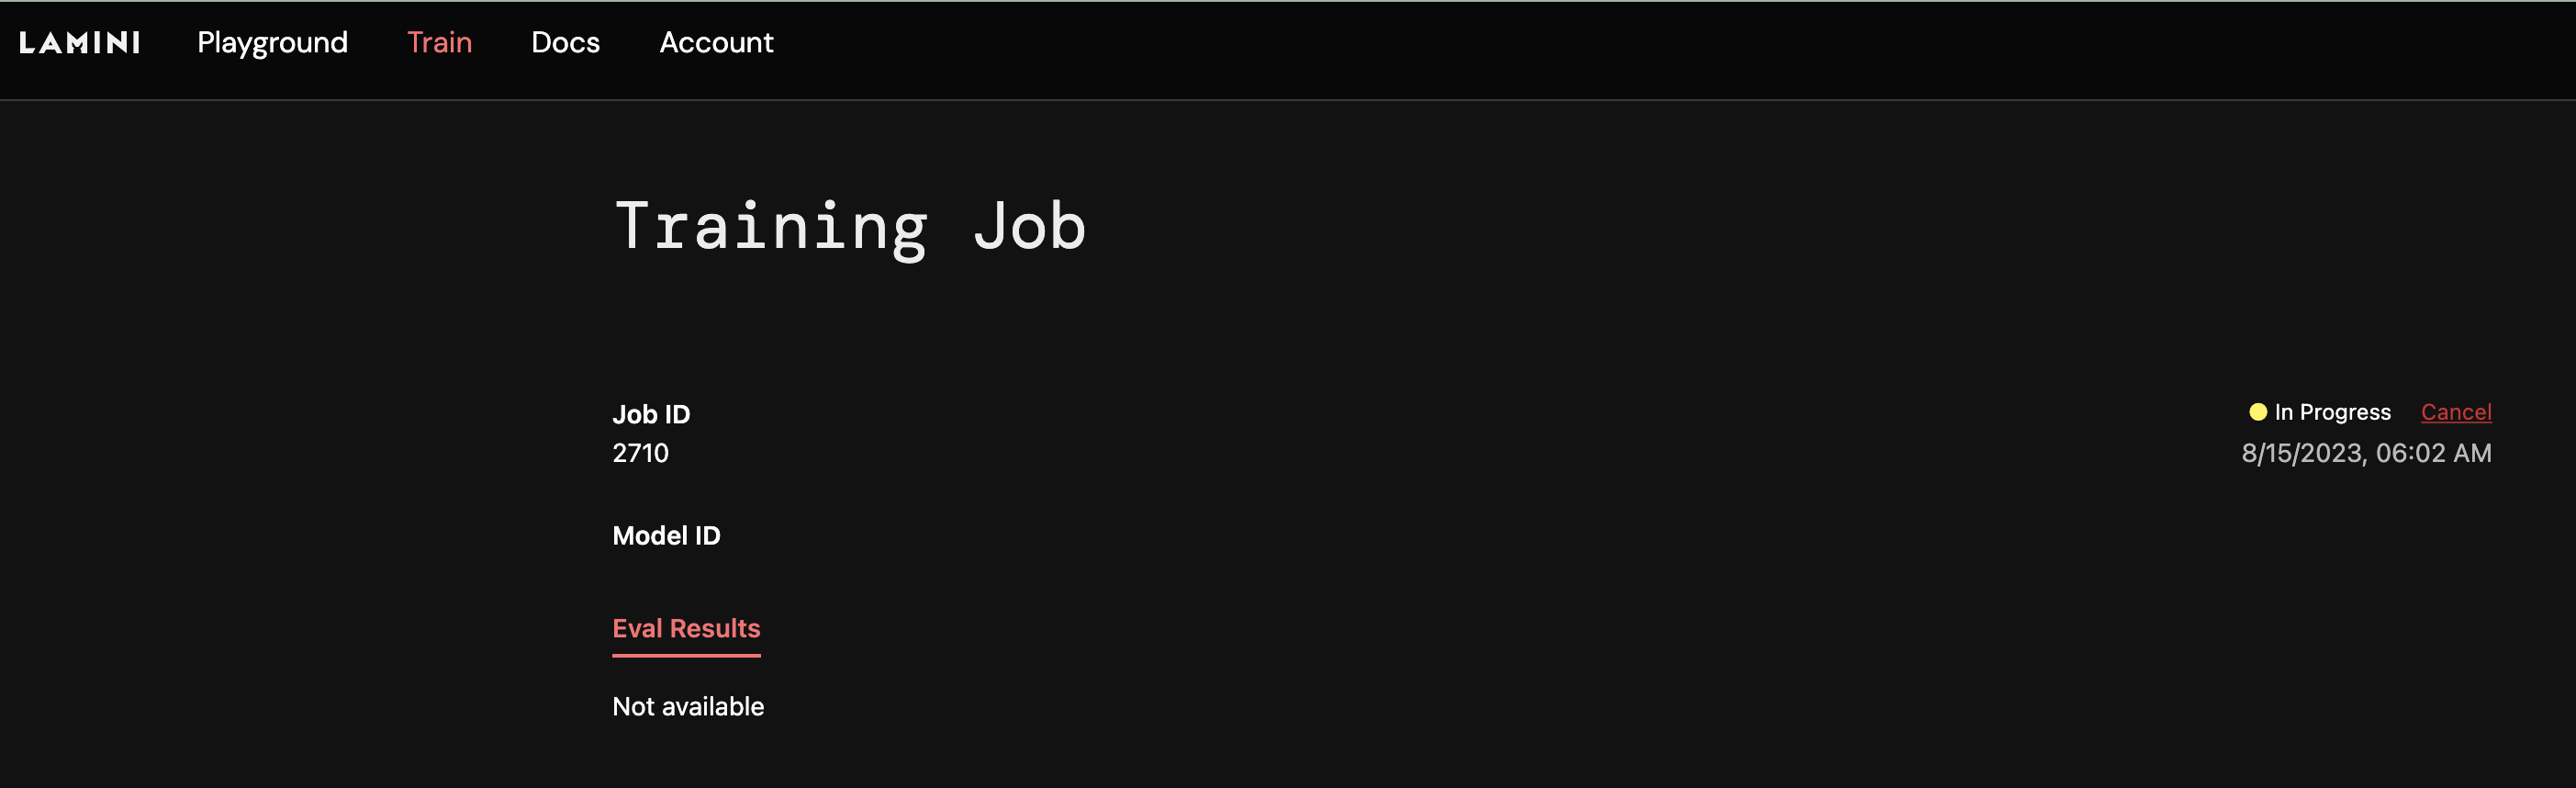

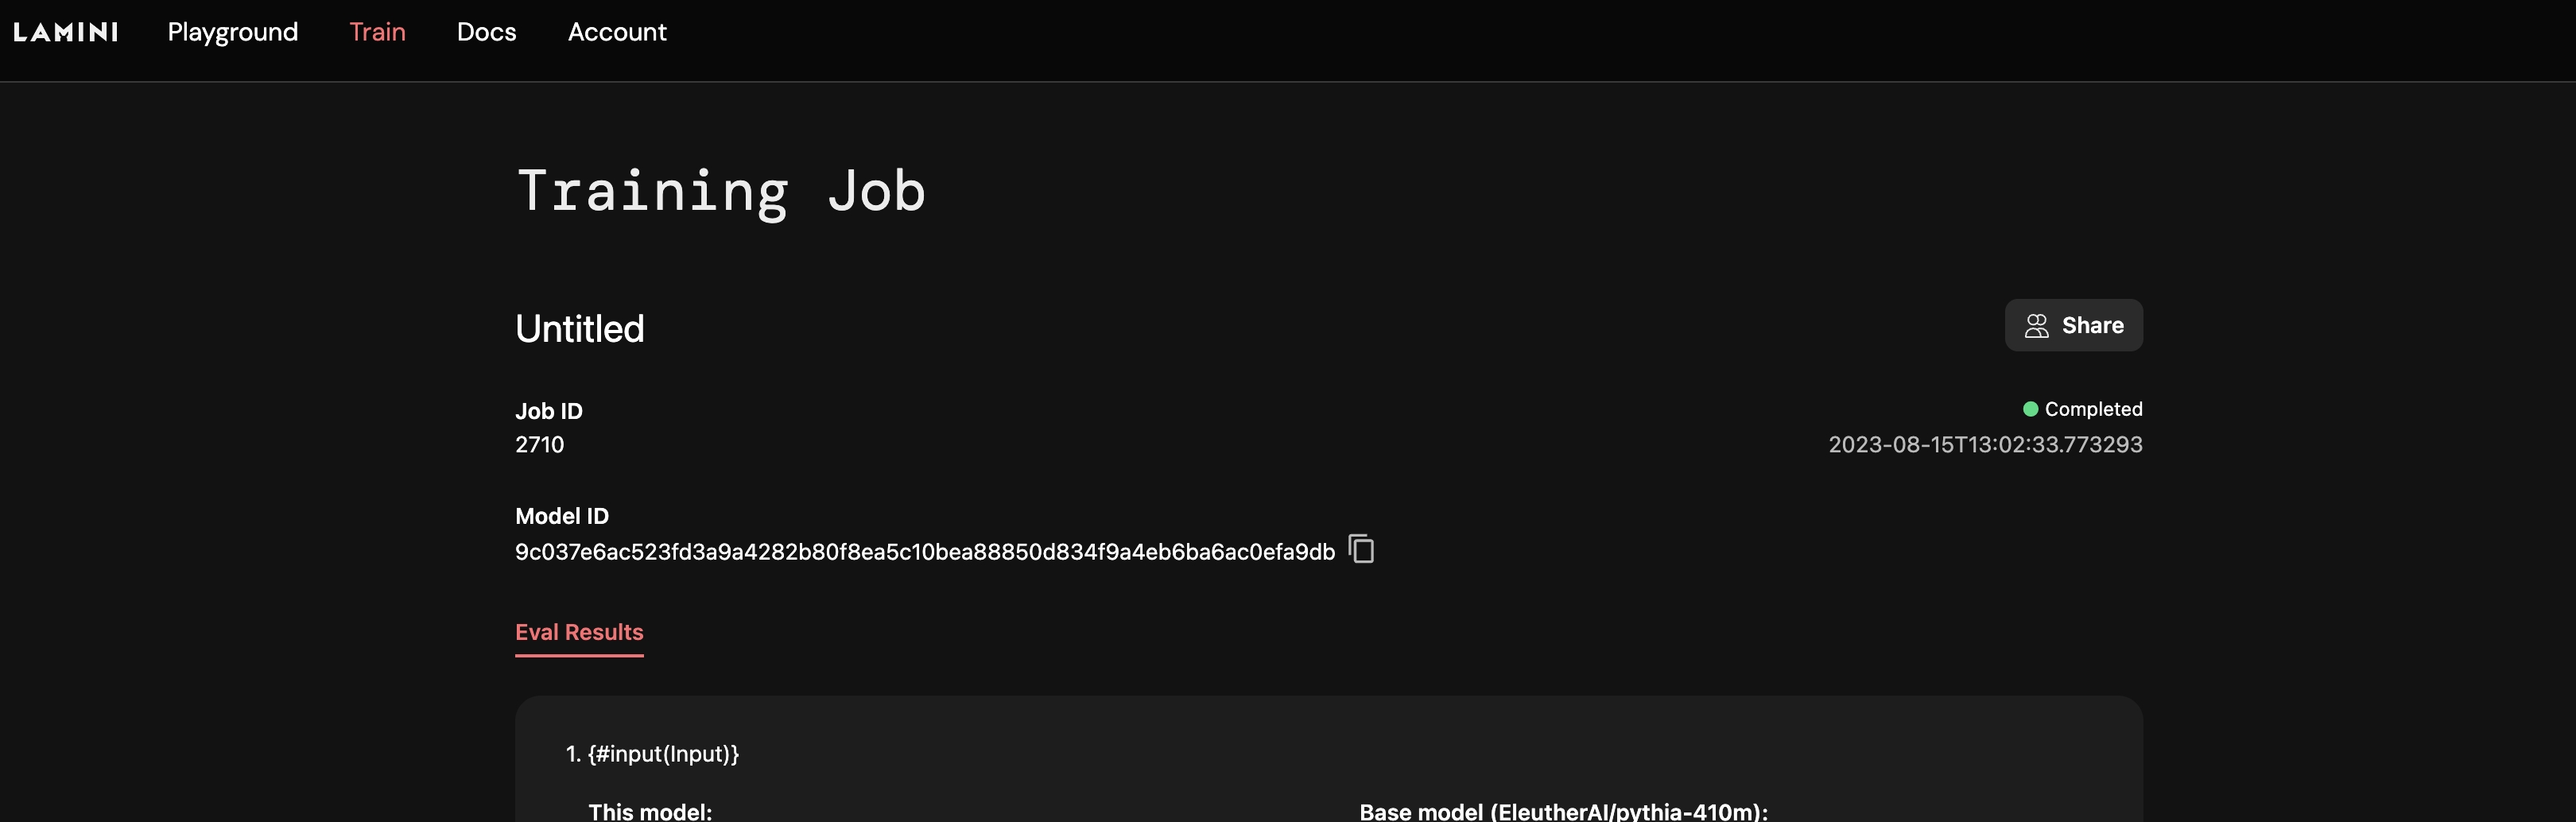